In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:
import abc
from collections import defaultdict
import json
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from pathlib import Path
import tensorflow as tf
import tf_utilities as tfu
from tqdm.auto import tqdm
from typing import Iterable, Generator, Optional
import time
import wandb

from dnadb.datasets import Greengenes, Silva
from dnadb import dna, fasta, sample, taxonomy

from deepdna.data.dataset import Dataset
from deepdna.nn.models import custom_model, dnabert, load_model
from deepdna.nn.utils import encapsulate_model
from deepdna.nn import layers, functional, utils

In [3]:
tfu.devices.select_gpu(0)

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

## Dataset

In [4]:
dataset = Dataset("/home/dwl2x/work/Datasets/Silva2/0")
train_fastas = tuple(map(sample.load_fasta, dataset.fasta_dbs(Dataset.Split.Train)))
train_tax = tuple(map(taxonomy.TaxonomyDb, dataset.taxonomy_dbs(Dataset.Split.Train)))
test_fastas = tuple(map(sample.load_fasta, dataset.fasta_dbs(Dataset.Split.Test)))
test_tax = tuple(map(taxonomy.TaxonomyDb, dataset.taxonomy_dbs(Dataset.Split.Test)))

In [7]:
n = 0
for label in train_tax[0]:
    n += len(list(train_tax[0].fasta_ids_with_label(train_tax[0].label_to_index(label))))
n

2113503

In [8]:
n = 0
for label in test_tax[0]:
    n += len(list(test_tax[0].fasta_ids_with_label(test_tax[0].label_to_index(label))))
n

111237

In [5]:
for label in test_tax[0]:
    assert train_tax[0].contains_label(label)

In [21]:
from deepdna.data.samplers import SampleSampler, SequenceSampler
from deepdna.nn.data_generators import _encode_sequences, BatchGenerator
from typing import Any, cast

class SequenceTaxonomyGenerator(BatchGenerator):
    def __init__(
        self,
        fasta_taxonomy_pairs: Iterable[tuple[sample.FastaSample, taxonomy.TaxonomyDb]],
        sequence_length: int,
        taxonomy_id_map: taxonomy.TaxonomyIdMap,
        kmer: int = 1,
        subsample_size: int|None = None,
        batch_size: int = 32,
        batches_per_epoch: int = 100,
        augment_slide: bool = True,
        augment_ambiguous_bases: bool = True,
        balance: bool = False,
        shuffle: bool = True,
        rng: np.random.Generator = np.random.default_rng()
    ):
        super().__init__(
            batch_size=batch_size,
            batches_per_epoch=batches_per_epoch,
            shuffle=shuffle,
            rng=rng
        )
        fasta_samples, taxonomy_dbs = zip(*fasta_taxonomy_pairs)
        self.sample_sampler = SampleSampler(cast(tuple[sample.FastaSample, ...], fasta_samples))
        self.sequence_sampler = SequenceSampler(sequence_length, augment_slide)
        self.taxonomy_dbs: tuple[taxonomy.TaxonomyDb, ...] = cast(Any, taxonomy_dbs)
        self.kmer = kmer
        self.taxonomy_id_map = taxonomy_id_map
        self.subsample_size = subsample_size
        self.augment_ambiguous_bases = augment_ambiguous_bases
        self.balance = balance

    @property
    def sequence_length(self) -> int:
        return self.sequence_sampler.sequence_length

    def generate_batch(
        self,
        rng: np.random.Generator
    ) -> tuple[npt.NDArray[np.int32], npt.NDArray[np.int32]]:
        subsample_size = self.subsample_size or 1
        sequences = np.empty((self.batch_size, subsample_size), dtype=f"<U{self.sequence_length}")
        sample_ids = np.empty(self.batch_size, dtype=np.int32)
        sequence_ids = [None] * self.batch_size
        label_ids = np.empty((self.batch_size, subsample_size), dtype=np.int32)
        samples = self.sample_sampler.sample_with_ids(self.batch_size, self.balance, rng)
        for i, (sample_id, sample) in enumerate(samples):
            tax_db = self.taxonomy_dbs[sample_id]
            sequence_info = tuple(self.sequence_sampler.sample_with_ids(sample, subsample_size, rng))
            sequence_ids[i], sequences[i] = zip(*sequence_info)
            sample_ids[i] = sample_id
            label_ids[i] = [self.taxonomy_id_map[tax_db.fasta_id_to_label(fasta_id)] for fasta_id in sequence_ids[i]]
        sequences = _encode_sequences(sequences, self.augment_ambiguous_bases, self.rng)
        if self.subsample_size is None:
            sequences = np.squeeze(sequences, axis=1)
            label_ids = np.squeeze(label_ids, axis=1)
        sequences = sequences.astype(np.int32)
        if self.kmer > 1:
            sequences = dna.encode_kmers(sequences, self.kmer, not self.augment_ambiguous_bases).astype(np.int32) # type: ignore
        return sample_ids, sequence_ids, sequences, label_ids

    def reduce_batch(self, batch):
        # remove sample IDs and sequence IDs
        return batch[2:]

## Model

In [7]:
# api = wandb.Api()
run = wandb.init(project="dnabert-taxonomy-naive", name="64d-150l")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sirdavidludwig. Use `wandb login --relogin` to force relogin


In [8]:
# path = api.artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:v3").download()
path = run.use_artifact("sirdavidludwig/dnabert-pretrain/dnabert-pretrain-silva-64:v3").download()
dnabert_model = load_model(path, dnabert.DnaBertPretrainModel).base

wandb:   4 of 4 files downloaded.  


In [9]:
class NaiveTaxonomyClassificationModel(custom_model.ModelWrapper, custom_model.CustomModel[tf.Tensor, tuple[tf.Tensor, ...]]):
    def __init__(
        self,
        base: tf.keras.Model,
        taxonomies: Iterable[str],
        **kwargs
    ):
        super().__init__(**kwargs)
        self.base = base
        self.taxonomy_id_map = {}
        for tax in taxonomies:
            if tax not in self.taxonomy_id_map:
                assert isinstance(tax, str), "Taxonomy label must be a string."
                self.taxonomy_id_map[tax] = len(self.taxonomy_id_map)
        self.model = self.build_model()

    def default_loss(self):
        return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def default_metrics(self):
        return [
            tf.keras.metrics.SparseCategoricalAccuracy()
        ]

    def build_model(self):
        x, y = encapsulate_model(self.base)
        y = tf.keras.layers.Dense(len(self.taxonomy_id_map))(y)
        model = tf.keras.Model(x, y)
        return model

    def get_config(self):
        return super().get_config() | {
            "base": self.base,
            "taxonomies": list(self.taxonomy_id_map.keys())
        }

In [10]:
encoder = dnabert.DnaBertEncoderModel(dnabert_model, 256)
model = NaiveTaxonomyClassificationModel(encoder, chain(*map(iter, train_tax)))
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [11]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 148)]             0         
                                                                 
 dna_bert_encoder_model (Dna  (None, 64)               1210496   
 BertEncoderModel)                                               
                                                                 
 dense_18 (Dense)            (None, 11070)             719550    
                                                                 
Total params: 1,930,046
Trainable params: 1,930,046
Non-trainable params: 0
_________________________________________________________________


In [30]:
common_args = dict(
    sequence_length = 150,
    kmer = 3,
    taxonomy_id_map = model.taxonomy_id_map,
    batch_size = 256,
)

train_data = SequenceTaxonomyGenerator(
    zip(train_fastas, train_tax),
    batches_per_epoch=100,
    **common_args)
test_data = SequenceTaxonomyGenerator(
    zip(test_fastas, test_tax),
    batches_per_epoch=20,
    shuffle=False,
    **common_args)

In [13]:
train_data[0][1]

array([[   30],
       [  226],
       [  258],
       [ 2033],
       [ 2105],
       [ 1636],
       [ 3122],
       [ 1258],
       [   69],
       [   98],
       [ 2827],
       [ 3489],
       [  224],
       [  643],
       [  360],
       [   50],
       [ 5017],
       [  554],
       [ 2286],
       [   13],
       [  491],
       [  374],
       [ 6266],
       [  623],
       [  239],
       [   50],
       [ 6610],
       [ 6126],
       [ 3802],
       [    5],
       [  984],
       [  325],
       [  258],
       [  239],
       [  623],
       [  716],
       [  987],
       [  223],
       [  647],
       [ 3650],
       [  223],
       [ 1788],
       [ 4724],
       [  775],
       [   48],
       [  239],
       [ 3663],
       [  239],
       [ 2001],
       [   46],
       [ 6102],
       [ 1753],
       [  623],
       [   48],
       [  760],
       [  239],
       [  258],
       [ 4619],
       [ 1666],
       [ 7781],
       [ 5735],
       [  239],
       [

In [14]:
test_data[0][1]

array([[ 239],
       [1753],
       [  11],
       [ 239],
       [1133],
       [ 215],
       [   8],
       [  43],
       [8298],
       [ 787],
       [2944],
       [ 623],
       [ 698],
       [ 699],
       [1130],
       [ 169],
       [ 239],
       [4663],
       [  13],
       [ 340],
       [ 282],
       [1842],
       [4064],
       [2894],
       [4221],
       [ 716],
       [ 159],
       [ 141],
       [ 159],
       [ 686],
       [  46],
       [ 488],
       [  56],
       [  48],
       [ 423],
       [ 196],
       [  48],
       [   8],
       [  50],
       [ 225],
       [8863],
       [5767],
       [  17],
       [3489],
       [ 239],
       [7562],
       [5329],
       [ 196],
       [ 615],
       [6661],
       [ 471],
       [  82],
       [   8],
       [ 170],
       [3309],
       [ 226],
       [  75],
       [1065],
       [ 202],
       [   4],
       [ 683],
       [ 615],
       [  48],
       [ 239],
       [ 239],
       [  79],
       [ 9

In [15]:
model(train_data[0][0])

<tf.Tensor: shape=(256, 11070), dtype=float32, numpy=
array([[ 0.00583833, -0.08855611,  0.18546222, ..., -0.016127  ,
        -0.2977479 , -0.18200122],
       [-0.3335538 , -0.1786217 ,  0.09431156, ..., -0.13177276,
        -0.19796431,  0.03931923],
       [ 0.32255176, -0.0689109 ,  0.10260673, ..., -0.05669966,
        -0.14712423, -0.1045833 ],
       ...,
       [-0.13978443, -0.44564387, -0.08463553, ..., -0.13566524,
         0.00341579,  0.09858178],
       [-0.23548141, -0.1444789 , -0.02358536, ...,  0.2709653 ,
        -0.11341795, -0.24591446],
       [-0.08897561, -0.0622659 ,  0.06874194, ..., -0.00876656,
        -0.19912681, -0.20852236]], dtype=float32)>

In [16]:
wandb_callback = wandb.keras.WandbCallback(save_model=False)
wandb_callback.save_model_as_artifact = False
checkpoint = tf.keras.callbacks.ModelCheckpoint("logs/models/dnabert_taxonomy_naive", save_best=True)

In [14]:
model.fit(train_data, validation_data=test_data, epochs=3000, initial_epoch=1000, callbacks=[wandb_callback, checkpoint])

Epoch 1001/3000
  6/100 [>.............................] - ETA: 19s - loss: 1.1965 - sparse_categorical_accuracy: 0.7350WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0906s vs `on_train_batch_end` time: 0.1198s). Check your callbacks.


100/100 [==============================] - ETA: 0s - loss: 1.3637 - sparse_categorical_accuracy: 0.7031

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3637 - sparse_categorical_accuracy: 0.7031 - val_loss: 1.2305 - val_sparse_categorical_accuracy: 0.7275
Epoch 1002/3000
100/100 [==============================] - ETA: 0s - loss: 1.3905 - sparse_categorical_accuracy: 0.7036

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3905 - sparse_categorical_accuracy: 0.7036 - val_loss: 1.1834 - val_sparse_categorical_accuracy: 0.7414
Epoch 1003/3000
100/100 [==============================] - ETA: 0s - loss: 1.3872 - sparse_categorical_accuracy: 0.6982

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3872 - sparse_categorical_accuracy: 0.6982 - val_loss: 1.2171 - val_sparse_categorical_accuracy: 0.7359
Epoch 1004/3000
100/100 [==============================] - ETA: 0s - loss: 1.3898 - sparse_categorical_accuracy: 0.7020

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.3898 - sparse_categorical_accuracy: 0.7020 - val_loss: 1.2569 - val_sparse_categorical_accuracy: 0.7271
Epoch 1005/3000
100/100 [==============================] - ETA: 0s - loss: 1.3927 - sparse_categorical_accuracy: 0.7014

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3927 - sparse_categorical_accuracy: 0.7014 - val_loss: 1.1819 - val_sparse_categorical_accuracy: 0.7365
Epoch 1006/3000
100/100 [==============================] - ETA: 0s - loss: 1.3816 - sparse_categorical_accuracy: 0.6987

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3816 - sparse_categorical_accuracy: 0.6987 - val_loss: 1.1799 - val_sparse_categorical_accuracy: 0.7404
Epoch 1007/3000
100/100 [==============================] - ETA: 0s - loss: 1.3919 - sparse_categorical_accuracy: 0.7013

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3919 - sparse_categorical_accuracy: 0.7013 - val_loss: 1.2412 - val_sparse_categorical_accuracy: 0.7229
Epoch 1008/3000
100/100 [==============================] - ETA: 0s - loss: 1.3633 - sparse_categorical_accuracy: 0.7057

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3633 - sparse_categorical_accuracy: 0.7057 - val_loss: 1.1865 - val_sparse_categorical_accuracy: 0.7344
Epoch 1009/3000
100/100 [==============================] - ETA: 0s - loss: 1.3927 - sparse_categorical_accuracy: 0.6988

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3927 - sparse_categorical_accuracy: 0.6988 - val_loss: 1.2271 - val_sparse_categorical_accuracy: 0.7379
Epoch 1010/3000
100/100 [==============================] - ETA: 0s - loss: 1.3779 - sparse_categorical_accuracy: 0.7026

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3779 - sparse_categorical_accuracy: 0.7026 - val_loss: 1.2064 - val_sparse_categorical_accuracy: 0.7367
Epoch 1011/3000
100/100 [==============================] - ETA: 0s - loss: 1.4142 - sparse_categorical_accuracy: 0.6936

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.4142 - sparse_categorical_accuracy: 0.6936 - val_loss: 1.1549 - val_sparse_categorical_accuracy: 0.7432
Epoch 1012/3000
100/100 [==============================] - ETA: 0s - loss: 1.4061 - sparse_categorical_accuracy: 0.6971

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.4061 - sparse_categorical_accuracy: 0.6971 - val_loss: 1.2056 - val_sparse_categorical_accuracy: 0.7346
Epoch 1013/3000
100/100 [==============================] - ETA: 0s - loss: 1.3711 - sparse_categorical_accuracy: 0.7021

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3711 - sparse_categorical_accuracy: 0.7021 - val_loss: 1.1952 - val_sparse_categorical_accuracy: 0.7350
Epoch 1014/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3988 - sparse_categorical_accuracy: 0.6963

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3988 - sparse_categorical_accuracy: 0.6963 - val_loss: 1.2296 - val_sparse_categorical_accuracy: 0.7285
Epoch 1015/3000
100/100 [==============================] - ETA: 0s - loss: 1.3679 - sparse_categorical_accuracy: 0.7086

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3679 - sparse_categorical_accuracy: 0.7086 - val_loss: 1.2081 - val_sparse_categorical_accuracy: 0.7365
Epoch 1016/3000
100/100 [==============================] - ETA: 0s - loss: 1.3908 - sparse_categorical_accuracy: 0.6976

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3908 - sparse_categorical_accuracy: 0.6976 - val_loss: 1.1553 - val_sparse_categorical_accuracy: 0.7383
Epoch 1017/3000
100/100 [==============================] - ETA: 0s - loss: 1.3801 - sparse_categorical_accuracy: 0.7034

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3801 - sparse_categorical_accuracy: 0.7034 - val_loss: 1.1983 - val_sparse_categorical_accuracy: 0.7381
Epoch 1018/3000
100/100 [==============================] - ETA: 0s - loss: 1.3836 - sparse_categorical_accuracy: 0.7023

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3836 - sparse_categorical_accuracy: 0.7023 - val_loss: 1.2216 - val_sparse_categorical_accuracy: 0.7385
Epoch 1019/3000
100/100 [==============================] - ETA: 0s - loss: 1.3909 - sparse_categorical_accuracy: 0.7003

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3909 - sparse_categorical_accuracy: 0.7003 - val_loss: 1.1756 - val_sparse_categorical_accuracy: 0.7332
Epoch 1020/3000
100/100 [==============================] - ETA: 0s - loss: 1.3868 - sparse_categorical_accuracy: 0.7030

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3868 - sparse_categorical_accuracy: 0.7030 - val_loss: 1.1989 - val_sparse_categorical_accuracy: 0.7377
Epoch 1021/3000
100/100 [==============================] - ETA: 0s - loss: 1.3905 - sparse_categorical_accuracy: 0.7016

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3905 - sparse_categorical_accuracy: 0.7016 - val_loss: 1.1807 - val_sparse_categorical_accuracy: 0.7400
Epoch 1022/3000
100/100 [==============================] - ETA: 0s - loss: 1.3986 - sparse_categorical_accuracy: 0.6985

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3986 - sparse_categorical_accuracy: 0.6985 - val_loss: 1.1229 - val_sparse_categorical_accuracy: 0.7561
Epoch 1023/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3911 - sparse_categorical_accuracy: 0.7014

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3911 - sparse_categorical_accuracy: 0.7014 - val_loss: 1.2120 - val_sparse_categorical_accuracy: 0.7205
Epoch 1024/3000
100/100 [==============================] - ETA: 0s - loss: 1.3831 - sparse_categorical_accuracy: 0.6996

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3831 - sparse_categorical_accuracy: 0.6996 - val_loss: 1.1664 - val_sparse_categorical_accuracy: 0.7404
Epoch 1025/3000
100/100 [==============================] - ETA: 0s - loss: 1.3900 - sparse_categorical_accuracy: 0.6989

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3900 - sparse_categorical_accuracy: 0.6989 - val_loss: 1.1743 - val_sparse_categorical_accuracy: 0.7334
Epoch 1026/3000
100/100 [==============================] - ETA: 0s - loss: 1.3863 - sparse_categorical_accuracy: 0.6965

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3863 - sparse_categorical_accuracy: 0.6965 - val_loss: 1.1760 - val_sparse_categorical_accuracy: 0.7381
Epoch 1027/3000
100/100 [==============================] - ETA: 0s - loss: 1.3801 - sparse_categorical_accuracy: 0.7027

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3801 - sparse_categorical_accuracy: 0.7027 - val_loss: 1.2027 - val_sparse_categorical_accuracy: 0.7379
Epoch 1028/3000
100/100 [==============================] - ETA: 0s - loss: 1.4124 - sparse_categorical_accuracy: 0.7032

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.4124 - sparse_categorical_accuracy: 0.7032 - val_loss: 1.2091 - val_sparse_categorical_accuracy: 0.7342
Epoch 1029/3000
100/100 [==============================] - ETA: 0s - loss: 1.3712 - sparse_categorical_accuracy: 0.7046

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3712 - sparse_categorical_accuracy: 0.7046 - val_loss: 1.1851 - val_sparse_categorical_accuracy: 0.7414
Epoch 1030/3000
100/100 [==============================] - ETA: 0s - loss: 1.3699 - sparse_categorical_accuracy: 0.7015

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3699 - sparse_categorical_accuracy: 0.7015 - val_loss: 1.1153 - val_sparse_categorical_accuracy: 0.7545
Epoch 1031/3000
100/100 [==============================] - ETA: 0s - loss: 1.3786 - sparse_categorical_accuracy: 0.7043

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3786 - sparse_categorical_accuracy: 0.7043 - val_loss: 1.2022 - val_sparse_categorical_accuracy: 0.7326
Epoch 1032/3000
100/100 [==============================] - ETA: 0s - loss: 1.3826 - sparse_categorical_accuracy: 0.7007

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3826 - sparse_categorical_accuracy: 0.7007 - val_loss: 1.2538 - val_sparse_categorical_accuracy: 0.7209
Epoch 1033/3000
100/100 [==============================] - ETA: 0s - loss: 1.3680 - sparse_categorical_accuracy: 0.7037

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3680 - sparse_categorical_accuracy: 0.7037 - val_loss: 1.1913 - val_sparse_categorical_accuracy: 0.7352
Epoch 1034/3000
100/100 [==============================] - ETA: 0s - loss: 1.3898 - sparse_categorical_accuracy: 0.6986

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3898 - sparse_categorical_accuracy: 0.6986 - val_loss: 1.1727 - val_sparse_categorical_accuracy: 0.7402
Epoch 1035/3000
100/100 [==============================] - ETA: 0s - loss: 1.3973 - sparse_categorical_accuracy: 0.6984

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3973 - sparse_categorical_accuracy: 0.6984 - val_loss: 1.2529 - val_sparse_categorical_accuracy: 0.7281
Epoch 1036/3000
100/100 [==============================] - ETA: 0s - loss: 1.3663 - sparse_categorical_accuracy: 0.7059

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3663 - sparse_categorical_accuracy: 0.7059 - val_loss: 1.1696 - val_sparse_categorical_accuracy: 0.7369
Epoch 1037/3000
100/100 [==============================] - ETA: 0s - loss: 1.3455 - sparse_categorical_accuracy: 0.7082

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.3455 - sparse_categorical_accuracy: 0.7082 - val_loss: 1.1736 - val_sparse_categorical_accuracy: 0.7396
Epoch 1038/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3772 - sparse_categorical_accuracy: 0.7015

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3772 - sparse_categorical_accuracy: 0.7015 - val_loss: 1.1641 - val_sparse_categorical_accuracy: 0.7354
Epoch 1039/3000
100/100 [==============================] - ETA: 0s - loss: 1.3724 - sparse_categorical_accuracy: 0.7035

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3724 - sparse_categorical_accuracy: 0.7035 - val_loss: 1.1385 - val_sparse_categorical_accuracy: 0.7520
Epoch 1040/3000
100/100 [==============================] - ETA: 0s - loss: 1.3661 - sparse_categorical_accuracy: 0.7042

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3661 - sparse_categorical_accuracy: 0.7042 - val_loss: 1.1795 - val_sparse_categorical_accuracy: 0.7436
Epoch 1041/3000
100/100 [==============================] - ETA: 0s - loss: 1.3685 - sparse_categorical_accuracy: 0.7053

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3685 - sparse_categorical_accuracy: 0.7053 - val_loss: 1.1356 - val_sparse_categorical_accuracy: 0.7451
Epoch 1042/3000
100/100 [==============================] - ETA: 0s - loss: 1.3729 - sparse_categorical_accuracy: 0.7026

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3729 - sparse_categorical_accuracy: 0.7026 - val_loss: 1.1661 - val_sparse_categorical_accuracy: 0.7367
Epoch 1043/3000
100/100 [==============================] - ETA: 0s - loss: 1.3969 - sparse_categorical_accuracy: 0.7017

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3969 - sparse_categorical_accuracy: 0.7017 - val_loss: 1.0852 - val_sparse_categorical_accuracy: 0.7543
Epoch 1044/3000
100/100 [==============================] - ETA: 0s - loss: 1.3554 - sparse_categorical_accuracy: 0.7044

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3554 - sparse_categorical_accuracy: 0.7044 - val_loss: 1.1732 - val_sparse_categorical_accuracy: 0.7416
Epoch 1045/3000
100/100 [==============================] - ETA: 0s - loss: 1.3780 - sparse_categorical_accuracy: 0.7008

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3780 - sparse_categorical_accuracy: 0.7008 - val_loss: 1.1471 - val_sparse_categorical_accuracy: 0.7350
Epoch 1046/3000
100/100 [==============================] - ETA: 0s - loss: 1.3947 - sparse_categorical_accuracy: 0.6979

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3947 - sparse_categorical_accuracy: 0.6979 - val_loss: 1.1689 - val_sparse_categorical_accuracy: 0.7457
Epoch 1047/3000
100/100 [==============================] - ETA: 0s - loss: 1.3605 - sparse_categorical_accuracy: 0.7052

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3605 - sparse_categorical_accuracy: 0.7052 - val_loss: 1.2150 - val_sparse_categorical_accuracy: 0.7391
Epoch 1048/3000
100/100 [==============================] - ETA: 0s - loss: 1.3804 - sparse_categorical_accuracy: 0.7019

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3804 - sparse_categorical_accuracy: 0.7019 - val_loss: 1.2239 - val_sparse_categorical_accuracy: 0.7309
Epoch 1049/3000
100/100 [==============================] - ETA: 0s - loss: 1.3847 - sparse_categorical_accuracy: 0.6979

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.3847 - sparse_categorical_accuracy: 0.6979 - val_loss: 1.1723 - val_sparse_categorical_accuracy: 0.7387
Epoch 1050/3000
100/100 [==============================] - ETA: 0s - loss: 1.3842 - sparse_categorical_accuracy: 0.7012

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3842 - sparse_categorical_accuracy: 0.7012 - val_loss: 1.1513 - val_sparse_categorical_accuracy: 0.7516
Epoch 1051/3000
100/100 [==============================] - ETA: 0s - loss: 1.3525 - sparse_categorical_accuracy: 0.7054

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3525 - sparse_categorical_accuracy: 0.7054 - val_loss: 1.1423 - val_sparse_categorical_accuracy: 0.7457
Epoch 1052/3000
100/100 [==============================] - ETA: 0s - loss: 1.3816 - sparse_categorical_accuracy: 0.7020

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3816 - sparse_categorical_accuracy: 0.7020 - val_loss: 1.1803 - val_sparse_categorical_accuracy: 0.7430
Epoch 1053/3000
100/100 [==============================] - ETA: 0s - loss: 1.3859 - sparse_categorical_accuracy: 0.6993

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 60s 598ms/step - loss: 1.3859 - sparse_categorical_accuracy: 0.6993 - val_loss: 1.2027 - val_sparse_categorical_accuracy: 0.7295
Epoch 1054/3000
100/100 [==============================] - ETA: 0s - loss: 1.3770 - sparse_categorical_accuracy: 0.7043

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3770 - sparse_categorical_accuracy: 0.7043 - val_loss: 1.1967 - val_sparse_categorical_accuracy: 0.7352
Epoch 1055/3000
100/100 [==============================] - ETA: 0s - loss: 1.3647 - sparse_categorical_accuracy: 0.7064

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3647 - sparse_categorical_accuracy: 0.7064 - val_loss: 1.1405 - val_sparse_categorical_accuracy: 0.7416
Epoch 1056/3000
100/100 [==============================] - ETA: 0s - loss: 1.3692 - sparse_categorical_accuracy: 0.7058

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3692 - sparse_categorical_accuracy: 0.7058 - val_loss: 1.2055 - val_sparse_categorical_accuracy: 0.7336
Epoch 1057/3000
100/100 [==============================] - ETA: 0s - loss: 1.3692 - sparse_categorical_accuracy: 0.7062

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 382ms/step - loss: 1.3692 - sparse_categorical_accuracy: 0.7062 - val_loss: 1.1435 - val_sparse_categorical_accuracy: 0.7488
Epoch 1058/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3547 - sparse_categorical_accuracy: 0.7034

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3547 - sparse_categorical_accuracy: 0.7034 - val_loss: 1.1266 - val_sparse_categorical_accuracy: 0.7512
Epoch 1059/3000
100/100 [==============================] - ETA: 0s - loss: 1.3722 - sparse_categorical_accuracy: 0.7014

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3722 - sparse_categorical_accuracy: 0.7014 - val_loss: 1.1574 - val_sparse_categorical_accuracy: 0.7410
Epoch 1060/3000
100/100 [==============================] - ETA: 0s - loss: 1.3578 - sparse_categorical_accuracy: 0.7036

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3578 - sparse_categorical_accuracy: 0.7036 - val_loss: 1.1868 - val_sparse_categorical_accuracy: 0.7338
Epoch 1061/3000
100/100 [==============================] - ETA: 0s - loss: 1.3816 - sparse_categorical_accuracy: 0.7002

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3816 - sparse_categorical_accuracy: 0.7002 - val_loss: 1.1954 - val_sparse_categorical_accuracy: 0.7348
Epoch 1062/3000
100/100 [==============================] - ETA: 0s - loss: 1.3709 - sparse_categorical_accuracy: 0.7044

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3709 - sparse_categorical_accuracy: 0.7044 - val_loss: 1.2448 - val_sparse_categorical_accuracy: 0.7262
Epoch 1063/3000
100/100 [==============================] - ETA: 0s - loss: 1.3788 - sparse_categorical_accuracy: 0.7025

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3788 - sparse_categorical_accuracy: 0.7025 - val_loss: 1.1130 - val_sparse_categorical_accuracy: 0.7453
Epoch 1064/3000
100/100 [==============================] - ETA: 0s - loss: 1.3794 - sparse_categorical_accuracy: 0.6996

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3794 - sparse_categorical_accuracy: 0.6996 - val_loss: 1.1474 - val_sparse_categorical_accuracy: 0.7504
Epoch 1065/3000
100/100 [==============================] - ETA: 0s - loss: 1.3541 - sparse_categorical_accuracy: 0.7032

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3541 - sparse_categorical_accuracy: 0.7032 - val_loss: 1.0984 - val_sparse_categorical_accuracy: 0.7531
Epoch 1066/3000
100/100 [==============================] - ETA: 0s - loss: 1.3582 - sparse_categorical_accuracy: 0.7092

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3582 - sparse_categorical_accuracy: 0.7092 - val_loss: 1.1651 - val_sparse_categorical_accuracy: 0.7459
Epoch 1067/3000
100/100 [==============================] - ETA: 0s - loss: 1.3845 - sparse_categorical_accuracy: 0.7030

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3845 - sparse_categorical_accuracy: 0.7030 - val_loss: 1.1438 - val_sparse_categorical_accuracy: 0.7418
Epoch 1068/3000
100/100 [==============================] - ETA: 0s - loss: 1.3814 - sparse_categorical_accuracy: 0.7032

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3814 - sparse_categorical_accuracy: 0.7032 - val_loss: 1.1769 - val_sparse_categorical_accuracy: 0.7406
Epoch 1069/3000
100/100 [==============================] - ETA: 0s - loss: 1.3709 - sparse_categorical_accuracy: 0.7025

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3709 - sparse_categorical_accuracy: 0.7025 - val_loss: 1.1860 - val_sparse_categorical_accuracy: 0.7420
Epoch 1070/3000
100/100 [==============================] - ETA: 0s - loss: 1.3505 - sparse_categorical_accuracy: 0.7053

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3505 - sparse_categorical_accuracy: 0.7053 - val_loss: 1.1447 - val_sparse_categorical_accuracy: 0.7465
Epoch 1071/3000
100/100 [==============================] - ETA: 0s - loss: 1.3588 - sparse_categorical_accuracy: 0.7007

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3588 - sparse_categorical_accuracy: 0.7007 - val_loss: 1.2256 - val_sparse_categorical_accuracy: 0.7291
Epoch 1072/3000
100/100 [==============================] - ETA: 0s - loss: 1.3568 - sparse_categorical_accuracy: 0.7055

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3568 - sparse_categorical_accuracy: 0.7055 - val_loss: 1.1806 - val_sparse_categorical_accuracy: 0.7381
Epoch 1073/3000
100/100 [==============================] - ETA: 0s - loss: 1.3531 - sparse_categorical_accuracy: 0.7063

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3531 - sparse_categorical_accuracy: 0.7063 - val_loss: 1.1663 - val_sparse_categorical_accuracy: 0.7426
Epoch 1074/3000
100/100 [==============================] - ETA: 0s - loss: 1.3894 - sparse_categorical_accuracy: 0.6988

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3894 - sparse_categorical_accuracy: 0.6988 - val_loss: 1.1318 - val_sparse_categorical_accuracy: 0.7453
Epoch 1075/3000
100/100 [==============================] - ETA: 0s - loss: 1.3333 - sparse_categorical_accuracy: 0.7122

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3333 - sparse_categorical_accuracy: 0.7122 - val_loss: 1.1198 - val_sparse_categorical_accuracy: 0.7437
Epoch 1076/3000
100/100 [==============================] - ETA: 0s - loss: 1.3920 - sparse_categorical_accuracy: 0.7001

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3920 - sparse_categorical_accuracy: 0.7001 - val_loss: 1.2426 - val_sparse_categorical_accuracy: 0.7303
Epoch 1077/3000
100/100 [==============================] - ETA: 0s - loss: 1.3446 - sparse_categorical_accuracy: 0.7066

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3446 - sparse_categorical_accuracy: 0.7066 - val_loss: 1.1520 - val_sparse_categorical_accuracy: 0.7330
Epoch 1078/3000
100/100 [==============================] - ETA: 0s - loss: 1.3708 - sparse_categorical_accuracy: 0.7048

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3708 - sparse_categorical_accuracy: 0.7048 - val_loss: 1.1769 - val_sparse_categorical_accuracy: 0.7420
Epoch 1079/3000
100/100 [==============================] - ETA: 0s - loss: 1.3630 - sparse_categorical_accuracy: 0.7065

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3630 - sparse_categorical_accuracy: 0.7065 - val_loss: 1.1910 - val_sparse_categorical_accuracy: 0.7357
Epoch 1080/3000
100/100 [==============================] - ETA: 0s - loss: 1.3721 - sparse_categorical_accuracy: 0.7055

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3721 - sparse_categorical_accuracy: 0.7055 - val_loss: 1.2162 - val_sparse_categorical_accuracy: 0.7346
Epoch 1081/3000
100/100 [==============================] - ETA: 0s - loss: 1.3621 - sparse_categorical_accuracy: 0.7061

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.3621 - sparse_categorical_accuracy: 0.7061 - val_loss: 1.1325 - val_sparse_categorical_accuracy: 0.7533
Epoch 1082/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3772 - sparse_categorical_accuracy: 0.7021

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3772 - sparse_categorical_accuracy: 0.7021 - val_loss: 1.1448 - val_sparse_categorical_accuracy: 0.7482
Epoch 1083/3000
100/100 [==============================] - ETA: 0s - loss: 1.3793 - sparse_categorical_accuracy: 0.7018

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3793 - sparse_categorical_accuracy: 0.7018 - val_loss: 1.1771 - val_sparse_categorical_accuracy: 0.7379
Epoch 1084/3000
100/100 [==============================] - ETA: 0s - loss: 1.3766 - sparse_categorical_accuracy: 0.7020

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3766 - sparse_categorical_accuracy: 0.7020 - val_loss: 1.1249 - val_sparse_categorical_accuracy: 0.7557
Epoch 1085/3000
100/100 [==============================] - ETA: 0s - loss: 1.3470 - sparse_categorical_accuracy: 0.7113

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.3470 - sparse_categorical_accuracy: 0.7113 - val_loss: 1.1141 - val_sparse_categorical_accuracy: 0.7494
Epoch 1086/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3690 - sparse_categorical_accuracy: 0.7029

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3690 - sparse_categorical_accuracy: 0.7029 - val_loss: 1.1484 - val_sparse_categorical_accuracy: 0.7393
Epoch 1087/3000
100/100 [==============================] - ETA: 0s - loss: 1.3545 - sparse_categorical_accuracy: 0.7052

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.3545 - sparse_categorical_accuracy: 0.7052 - val_loss: 1.2170 - val_sparse_categorical_accuracy: 0.7414
Epoch 1088/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3454 - sparse_categorical_accuracy: 0.7088

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3454 - sparse_categorical_accuracy: 0.7088 - val_loss: 1.2102 - val_sparse_categorical_accuracy: 0.7379
Epoch 1089/3000
100/100 [==============================] - ETA: 0s - loss: 1.3506 - sparse_categorical_accuracy: 0.7065

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3506 - sparse_categorical_accuracy: 0.7065 - val_loss: 1.1281 - val_sparse_categorical_accuracy: 0.7492
Epoch 1090/3000
100/100 [==============================] - ETA: 0s - loss: 1.3355 - sparse_categorical_accuracy: 0.7090

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3355 - sparse_categorical_accuracy: 0.7090 - val_loss: 1.1783 - val_sparse_categorical_accuracy: 0.7391
Epoch 1091/3000
100/100 [==============================] - ETA: 0s - loss: 1.3748 - sparse_categorical_accuracy: 0.7018

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3748 - sparse_categorical_accuracy: 0.7018 - val_loss: 1.2125 - val_sparse_categorical_accuracy: 0.7340
Epoch 1092/3000
100/100 [==============================] - ETA: 0s - loss: 1.3738 - sparse_categorical_accuracy: 0.7041

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3738 - sparse_categorical_accuracy: 0.7041 - val_loss: 1.1457 - val_sparse_categorical_accuracy: 0.7455
Epoch 1093/3000
100/100 [==============================] - ETA: 0s - loss: 1.3640 - sparse_categorical_accuracy: 0.7036

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3640 - sparse_categorical_accuracy: 0.7036 - val_loss: 1.1329 - val_sparse_categorical_accuracy: 0.7479
Epoch 1094/3000
100/100 [==============================] - ETA: 0s - loss: 1.3985 - sparse_categorical_accuracy: 0.7014

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3985 - sparse_categorical_accuracy: 0.7014 - val_loss: 1.1348 - val_sparse_categorical_accuracy: 0.7531
Epoch 1095/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3443 - sparse_categorical_accuracy: 0.7081

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3443 - sparse_categorical_accuracy: 0.7081 - val_loss: 1.1626 - val_sparse_categorical_accuracy: 0.7453
Epoch 1096/3000
100/100 [==============================] - ETA: 0s - loss: 1.3630 - sparse_categorical_accuracy: 0.7070

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.3630 - sparse_categorical_accuracy: 0.7070 - val_loss: 1.1282 - val_sparse_categorical_accuracy: 0.7551
Epoch 1097/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3742 - sparse_categorical_accuracy: 0.7037

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3742 - sparse_categorical_accuracy: 0.7037 - val_loss: 1.1497 - val_sparse_categorical_accuracy: 0.7457
Epoch 1098/3000
100/100 [==============================] - ETA: 0s - loss: 1.3344 - sparse_categorical_accuracy: 0.7133

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3344 - sparse_categorical_accuracy: 0.7133 - val_loss: 1.1237 - val_sparse_categorical_accuracy: 0.7473
Epoch 1099/3000
100/100 [==============================] - ETA: 0s - loss: 1.3395 - sparse_categorical_accuracy: 0.7090

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3395 - sparse_categorical_accuracy: 0.7090 - val_loss: 1.1371 - val_sparse_categorical_accuracy: 0.7477
Epoch 1100/3000
100/100 [==============================] - ETA: 0s - loss: 1.3688 - sparse_categorical_accuracy: 0.7063

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.3688 - sparse_categorical_accuracy: 0.7063 - val_loss: 1.2107 - val_sparse_categorical_accuracy: 0.7301
Epoch 1101/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3736 - sparse_categorical_accuracy: 0.7046

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3736 - sparse_categorical_accuracy: 0.7046 - val_loss: 1.1109 - val_sparse_categorical_accuracy: 0.7533
Epoch 1102/3000
100/100 [==============================] - ETA: 0s - loss: 1.3675 - sparse_categorical_accuracy: 0.7054

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3675 - sparse_categorical_accuracy: 0.7054 - val_loss: 1.1666 - val_sparse_categorical_accuracy: 0.7449
Epoch 1103/3000
100/100 [==============================] - ETA: 0s - loss: 1.3871 - sparse_categorical_accuracy: 0.7013

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3871 - sparse_categorical_accuracy: 0.7013 - val_loss: 1.1939 - val_sparse_categorical_accuracy: 0.7363
Epoch 1104/3000
100/100 [==============================] - ETA: 0s - loss: 1.3672 - sparse_categorical_accuracy: 0.7015

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3672 - sparse_categorical_accuracy: 0.7015 - val_loss: 1.2133 - val_sparse_categorical_accuracy: 0.7393
Epoch 1105/3000
100/100 [==============================] - ETA: 0s - loss: 1.3661 - sparse_categorical_accuracy: 0.7021

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.3661 - sparse_categorical_accuracy: 0.7021 - val_loss: 1.1733 - val_sparse_categorical_accuracy: 0.7398
Epoch 1106/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3643 - sparse_categorical_accuracy: 0.7048

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3643 - sparse_categorical_accuracy: 0.7048 - val_loss: 1.1682 - val_sparse_categorical_accuracy: 0.7441
Epoch 1107/3000
100/100 [==============================] - ETA: 0s - loss: 1.3523 - sparse_categorical_accuracy: 0.7062

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.3523 - sparse_categorical_accuracy: 0.7062 - val_loss: 1.1268 - val_sparse_categorical_accuracy: 0.7461
Epoch 1108/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3492 - sparse_categorical_accuracy: 0.7053

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3492 - sparse_categorical_accuracy: 0.7053 - val_loss: 1.1902 - val_sparse_categorical_accuracy: 0.7404
Epoch 1109/3000
100/100 [==============================] - ETA: 0s - loss: 1.3743 - sparse_categorical_accuracy: 0.7046

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.3743 - sparse_categorical_accuracy: 0.7046 - val_loss: 1.1742 - val_sparse_categorical_accuracy: 0.7418
Epoch 1110/3000
100/100 [==============================] - ETA: 0s - loss: 1.3406 - sparse_categorical_accuracy: 0.7060

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3406 - sparse_categorical_accuracy: 0.7060 - val_loss: 1.1415 - val_sparse_categorical_accuracy: 0.7436
Epoch 1111/3000
100/100 [==============================] - ETA: 0s - loss: 1.3837 - sparse_categorical_accuracy: 0.7043

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3837 - sparse_categorical_accuracy: 0.7043 - val_loss: 1.1436 - val_sparse_categorical_accuracy: 0.7400
Epoch 1112/3000
100/100 [==============================] - ETA: 0s - loss: 1.3707 - sparse_categorical_accuracy: 0.7063

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3707 - sparse_categorical_accuracy: 0.7063 - val_loss: 1.1403 - val_sparse_categorical_accuracy: 0.7414
Epoch 1113/3000
100/100 [==============================] - ETA: 0s - loss: 1.3614 - sparse_categorical_accuracy: 0.7063

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3614 - sparse_categorical_accuracy: 0.7063 - val_loss: 1.1531 - val_sparse_categorical_accuracy: 0.7510
Epoch 1114/3000
100/100 [==============================] - ETA: 0s - loss: 1.3474 - sparse_categorical_accuracy: 0.7064

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3474 - sparse_categorical_accuracy: 0.7064 - val_loss: 1.1294 - val_sparse_categorical_accuracy: 0.7439
Epoch 1115/3000
100/100 [==============================] - ETA: 0s - loss: 1.3589 - sparse_categorical_accuracy: 0.7073

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3589 - sparse_categorical_accuracy: 0.7073 - val_loss: 1.1192 - val_sparse_categorical_accuracy: 0.7490
Epoch 1116/3000
100/100 [==============================] - ETA: 0s - loss: 1.3429 - sparse_categorical_accuracy: 0.7096

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.3429 - sparse_categorical_accuracy: 0.7096 - val_loss: 1.1821 - val_sparse_categorical_accuracy: 0.7398
Epoch 1117/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3435 - sparse_categorical_accuracy: 0.7085

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3435 - sparse_categorical_accuracy: 0.7085 - val_loss: 1.1535 - val_sparse_categorical_accuracy: 0.7467
Epoch 1118/3000
100/100 [==============================] - ETA: 0s - loss: 1.3473 - sparse_categorical_accuracy: 0.7088

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3473 - sparse_categorical_accuracy: 0.7088 - val_loss: 1.1366 - val_sparse_categorical_accuracy: 0.7436
Epoch 1119/3000
100/100 [==============================] - ETA: 0s - loss: 1.3548 - sparse_categorical_accuracy: 0.7056

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3548 - sparse_categorical_accuracy: 0.7056 - val_loss: 1.1942 - val_sparse_categorical_accuracy: 0.7426
Epoch 1120/3000
100/100 [==============================] - ETA: 0s - loss: 1.3408 - sparse_categorical_accuracy: 0.7066

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3408 - sparse_categorical_accuracy: 0.7066 - val_loss: 1.2032 - val_sparse_categorical_accuracy: 0.7359
Epoch 1121/3000
100/100 [==============================] - ETA: 0s - loss: 1.3518 - sparse_categorical_accuracy: 0.7051

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3518 - sparse_categorical_accuracy: 0.7051 - val_loss: 1.1467 - val_sparse_categorical_accuracy: 0.7459
Epoch 1122/3000
100/100 [==============================] - ETA: 0s - loss: 1.3334 - sparse_categorical_accuracy: 0.7084

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3334 - sparse_categorical_accuracy: 0.7084 - val_loss: 1.2033 - val_sparse_categorical_accuracy: 0.7363
Epoch 1123/3000
100/100 [==============================] - ETA: 0s - loss: 1.3638 - sparse_categorical_accuracy: 0.7041

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.3638 - sparse_categorical_accuracy: 0.7041 - val_loss: 1.1437 - val_sparse_categorical_accuracy: 0.7439
Epoch 1124/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3541 - sparse_categorical_accuracy: 0.7041

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3541 - sparse_categorical_accuracy: 0.7041 - val_loss: 1.1530 - val_sparse_categorical_accuracy: 0.7434
Epoch 1125/3000
100/100 [==============================] - ETA: 0s - loss: 1.3742 - sparse_categorical_accuracy: 0.7006

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3742 - sparse_categorical_accuracy: 0.7006 - val_loss: 1.1477 - val_sparse_categorical_accuracy: 0.7537
Epoch 1126/3000
100/100 [==============================] - ETA: 0s - loss: 1.3712 - sparse_categorical_accuracy: 0.7068

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3712 - sparse_categorical_accuracy: 0.7068 - val_loss: 1.1623 - val_sparse_categorical_accuracy: 0.7432
Epoch 1127/3000
100/100 [==============================] - ETA: 0s - loss: 1.3530 - sparse_categorical_accuracy: 0.7052

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3530 - sparse_categorical_accuracy: 0.7052 - val_loss: 1.1560 - val_sparse_categorical_accuracy: 0.7467
Epoch 1128/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3591 - sparse_categorical_accuracy: 0.7083

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3591 - sparse_categorical_accuracy: 0.7083 - val_loss: 1.2135 - val_sparse_categorical_accuracy: 0.7381
Epoch 1129/3000
100/100 [==============================] - ETA: 0s - loss: 1.3174 - sparse_categorical_accuracy: 0.7126

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3174 - sparse_categorical_accuracy: 0.7126 - val_loss: 1.1774 - val_sparse_categorical_accuracy: 0.7469
Epoch 1130/3000
100/100 [==============================] - ETA: 0s - loss: 1.3507 - sparse_categorical_accuracy: 0.7080

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3507 - sparse_categorical_accuracy: 0.7080 - val_loss: 1.1461 - val_sparse_categorical_accuracy: 0.7461
Epoch 1131/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3546 - sparse_categorical_accuracy: 0.7095

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3546 - sparse_categorical_accuracy: 0.7095 - val_loss: 1.1495 - val_sparse_categorical_accuracy: 0.7416
Epoch 1132/3000
100/100 [==============================] - ETA: 0s - loss: 1.3689 - sparse_categorical_accuracy: 0.7042

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.3689 - sparse_categorical_accuracy: 0.7042 - val_loss: 1.1570 - val_sparse_categorical_accuracy: 0.7455
Epoch 1133/3000
100/100 [==============================] - ETA: 0s - loss: 1.3691 - sparse_categorical_accuracy: 0.7029

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3691 - sparse_categorical_accuracy: 0.7029 - val_loss: 1.1548 - val_sparse_categorical_accuracy: 0.7486
Epoch 1134/3000
100/100 [==============================] - ETA: 0s - loss: 1.3317 - sparse_categorical_accuracy: 0.7076

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3317 - sparse_categorical_accuracy: 0.7076 - val_loss: 1.1310 - val_sparse_categorical_accuracy: 0.7514
Epoch 1135/3000
100/100 [==============================] - ETA: 0s - loss: 1.3515 - sparse_categorical_accuracy: 0.7057

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3515 - sparse_categorical_accuracy: 0.7057 - val_loss: 1.1574 - val_sparse_categorical_accuracy: 0.7482
Epoch 1136/3000
100/100 [==============================] - ETA: 0s - loss: 1.3373 - sparse_categorical_accuracy: 0.7103

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3373 - sparse_categorical_accuracy: 0.7103 - val_loss: 1.1785 - val_sparse_categorical_accuracy: 0.7355
Epoch 1137/3000
100/100 [==============================] - ETA: 0s - loss: 1.3632 - sparse_categorical_accuracy: 0.7048

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3632 - sparse_categorical_accuracy: 0.7048 - val_loss: 1.1420 - val_sparse_categorical_accuracy: 0.7410
Epoch 1138/3000
100/100 [==============================] - ETA: 0s - loss: 1.3630 - sparse_categorical_accuracy: 0.7064

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3630 - sparse_categorical_accuracy: 0.7064 - val_loss: 1.1159 - val_sparse_categorical_accuracy: 0.7553
Epoch 1139/3000
100/100 [==============================] - ETA: 0s - loss: 1.3453 - sparse_categorical_accuracy: 0.7119

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3453 - sparse_categorical_accuracy: 0.7119 - val_loss: 1.1561 - val_sparse_categorical_accuracy: 0.7463
Epoch 1140/3000
100/100 [==============================] - ETA: 0s - loss: 1.3494 - sparse_categorical_accuracy: 0.7082

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3494 - sparse_categorical_accuracy: 0.7082 - val_loss: 1.1496 - val_sparse_categorical_accuracy: 0.7430
Epoch 1141/3000
100/100 [==============================] - ETA: 0s - loss: 1.3455 - sparse_categorical_accuracy: 0.7083

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.3455 - sparse_categorical_accuracy: 0.7083 - val_loss: 1.1881 - val_sparse_categorical_accuracy: 0.7375
Epoch 1142/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3483 - sparse_categorical_accuracy: 0.7050

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3483 - sparse_categorical_accuracy: 0.7050 - val_loss: 1.1838 - val_sparse_categorical_accuracy: 0.7426
Epoch 1143/3000
100/100 [==============================] - ETA: 0s - loss: 1.3606 - sparse_categorical_accuracy: 0.7073

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3606 - sparse_categorical_accuracy: 0.7073 - val_loss: 1.1459 - val_sparse_categorical_accuracy: 0.7430
Epoch 1144/3000
100/100 [==============================] - ETA: 0s - loss: 1.3170 - sparse_categorical_accuracy: 0.7135

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3170 - sparse_categorical_accuracy: 0.7135 - val_loss: 1.1417 - val_sparse_categorical_accuracy: 0.7512
Epoch 1145/3000
100/100 [==============================] - ETA: 0s - loss: 1.3530 - sparse_categorical_accuracy: 0.7100

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3530 - sparse_categorical_accuracy: 0.7100 - val_loss: 1.1984 - val_sparse_categorical_accuracy: 0.7350
Epoch 1146/3000
100/100 [==============================] - ETA: 0s - loss: 1.3517 - sparse_categorical_accuracy: 0.7075

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 383ms/step - loss: 1.3517 - sparse_categorical_accuracy: 0.7075 - val_loss: 1.1356 - val_sparse_categorical_accuracy: 0.7543
Epoch 1147/3000
100/100 [==============================] - ETA: 0s - loss: 1.3432 - sparse_categorical_accuracy: 0.7087

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3432 - sparse_categorical_accuracy: 0.7087 - val_loss: 1.1165 - val_sparse_categorical_accuracy: 0.7496
Epoch 1148/3000
100/100 [==============================] - ETA: 0s - loss: 1.3467 - sparse_categorical_accuracy: 0.7087

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.3467 - sparse_categorical_accuracy: 0.7087 - val_loss: 1.1380 - val_sparse_categorical_accuracy: 0.7445
Epoch 1149/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3346 - sparse_categorical_accuracy: 0.7114

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3346 - sparse_categorical_accuracy: 0.7114 - val_loss: 1.1680 - val_sparse_categorical_accuracy: 0.7420
Epoch 1150/3000
100/100 [==============================] - ETA: 0s - loss: 1.3470 - sparse_categorical_accuracy: 0.7083

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.3470 - sparse_categorical_accuracy: 0.7083 - val_loss: 1.0941 - val_sparse_categorical_accuracy: 0.7576
Epoch 1151/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3622 - sparse_categorical_accuracy: 0.7091

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3622 - sparse_categorical_accuracy: 0.7091 - val_loss: 1.1118 - val_sparse_categorical_accuracy: 0.7516
Epoch 1152/3000
100/100 [==============================] - ETA: 0s - loss: 1.3449 - sparse_categorical_accuracy: 0.7093

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3449 - sparse_categorical_accuracy: 0.7093 - val_loss: 1.2065 - val_sparse_categorical_accuracy: 0.7437
Epoch 1153/3000
100/100 [==============================] - ETA: 0s - loss: 1.3361 - sparse_categorical_accuracy: 0.7088

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3361 - sparse_categorical_accuracy: 0.7088 - val_loss: 1.1398 - val_sparse_categorical_accuracy: 0.7510
Epoch 1154/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3623 - sparse_categorical_accuracy: 0.7046

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3623 - sparse_categorical_accuracy: 0.7046 - val_loss: 1.1496 - val_sparse_categorical_accuracy: 0.7437
Epoch 1155/3000
100/100 [==============================] - ETA: 0s - loss: 1.3539 - sparse_categorical_accuracy: 0.7080

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.3539 - sparse_categorical_accuracy: 0.7080 - val_loss: 1.1536 - val_sparse_categorical_accuracy: 0.7455
Epoch 1156/3000
100/100 [==============================] - ETA: 0s - loss: 1.3190 - sparse_categorical_accuracy: 0.7129

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3190 - sparse_categorical_accuracy: 0.7129 - val_loss: 1.1199 - val_sparse_categorical_accuracy: 0.7490
Epoch 1157/3000
100/100 [==============================] - ETA: 0s - loss: 1.3317 - sparse_categorical_accuracy: 0.7113

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3317 - sparse_categorical_accuracy: 0.7113 - val_loss: 1.1836 - val_sparse_categorical_accuracy: 0.7432
Epoch 1158/3000
100/100 [==============================] - ETA: 0s - loss: 1.3617 - sparse_categorical_accuracy: 0.7018

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3617 - sparse_categorical_accuracy: 0.7018 - val_loss: 1.1469 - val_sparse_categorical_accuracy: 0.7414
Epoch 1159/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3533 - sparse_categorical_accuracy: 0.7080

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3533 - sparse_categorical_accuracy: 0.7080 - val_loss: 1.1996 - val_sparse_categorical_accuracy: 0.7434
Epoch 1160/3000
100/100 [==============================] - ETA: 0s - loss: 1.3541 - sparse_categorical_accuracy: 0.7058

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3541 - sparse_categorical_accuracy: 0.7058 - val_loss: 1.1586 - val_sparse_categorical_accuracy: 0.7385
Epoch 1161/3000
100/100 [==============================] - ETA: 0s - loss: 1.3345 - sparse_categorical_accuracy: 0.7120

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3345 - sparse_categorical_accuracy: 0.7120 - val_loss: 1.1967 - val_sparse_categorical_accuracy: 0.7451
Epoch 1162/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3406 - sparse_categorical_accuracy: 0.7080

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3406 - sparse_categorical_accuracy: 0.7080 - val_loss: 1.0743 - val_sparse_categorical_accuracy: 0.7553
Epoch 1163/3000
100/100 [==============================] - ETA: 0s - loss: 1.3226 - sparse_categorical_accuracy: 0.7128

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3226 - sparse_categorical_accuracy: 0.7128 - val_loss: 1.1579 - val_sparse_categorical_accuracy: 0.7471
Epoch 1164/3000
100/100 [==============================] - ETA: 0s - loss: 1.3405 - sparse_categorical_accuracy: 0.7089

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3405 - sparse_categorical_accuracy: 0.7089 - val_loss: 1.1577 - val_sparse_categorical_accuracy: 0.7436
Epoch 1165/3000
100/100 [==============================] - ETA: 0s - loss: 1.3316 - sparse_categorical_accuracy: 0.7106

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3316 - sparse_categorical_accuracy: 0.7106 - val_loss: 1.1783 - val_sparse_categorical_accuracy: 0.7488
Epoch 1166/3000
100/100 [==============================] - ETA: 0s - loss: 1.3151 - sparse_categorical_accuracy: 0.7123

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.3151 - sparse_categorical_accuracy: 0.7123 - val_loss: 1.1273 - val_sparse_categorical_accuracy: 0.7480
Epoch 1167/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3424 - sparse_categorical_accuracy: 0.7103

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3424 - sparse_categorical_accuracy: 0.7103 - val_loss: 1.1164 - val_sparse_categorical_accuracy: 0.7445
Epoch 1168/3000
100/100 [==============================] - ETA: 0s - loss: 1.3341 - sparse_categorical_accuracy: 0.7078

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3341 - sparse_categorical_accuracy: 0.7078 - val_loss: 1.1344 - val_sparse_categorical_accuracy: 0.7482
Epoch 1169/3000
100/100 [==============================] - ETA: 0s - loss: 1.3325 - sparse_categorical_accuracy: 0.7116

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3325 - sparse_categorical_accuracy: 0.7116 - val_loss: 1.1679 - val_sparse_categorical_accuracy: 0.7322
Epoch 1170/3000
100/100 [==============================] - ETA: 0s - loss: 1.3283 - sparse_categorical_accuracy: 0.7103

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3283 - sparse_categorical_accuracy: 0.7103 - val_loss: 1.1356 - val_sparse_categorical_accuracy: 0.7469
Epoch 1171/3000
100/100 [==============================] - ETA: 0s - loss: 1.3566 - sparse_categorical_accuracy: 0.7071

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3566 - sparse_categorical_accuracy: 0.7071 - val_loss: 1.1357 - val_sparse_categorical_accuracy: 0.7439
Epoch 1172/3000
100/100 [==============================] - ETA: 0s - loss: 1.3498 - sparse_categorical_accuracy: 0.7057

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3498 - sparse_categorical_accuracy: 0.7057 - val_loss: 1.0777 - val_sparse_categorical_accuracy: 0.7533
Epoch 1173/3000
100/100 [==============================] - ETA: 0s - loss: 1.3459 - sparse_categorical_accuracy: 0.7066

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.3459 - sparse_categorical_accuracy: 0.7066 - val_loss: 1.1457 - val_sparse_categorical_accuracy: 0.7527
Epoch 1174/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3273 - sparse_categorical_accuracy: 0.7140

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3273 - sparse_categorical_accuracy: 0.7140 - val_loss: 1.1161 - val_sparse_categorical_accuracy: 0.7543
Epoch 1175/3000
100/100 [==============================] - ETA: 0s - loss: 1.3162 - sparse_categorical_accuracy: 0.7142

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3162 - sparse_categorical_accuracy: 0.7142 - val_loss: 1.1419 - val_sparse_categorical_accuracy: 0.7498
Epoch 1176/3000
100/100 [==============================] - ETA: 0s - loss: 1.3235 - sparse_categorical_accuracy: 0.7154

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3235 - sparse_categorical_accuracy: 0.7154 - val_loss: 1.1643 - val_sparse_categorical_accuracy: 0.7514
Epoch 1177/3000
100/100 [==============================] - ETA: 0s - loss: 1.3123 - sparse_categorical_accuracy: 0.7161

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3123 - sparse_categorical_accuracy: 0.7161 - val_loss: 1.1263 - val_sparse_categorical_accuracy: 0.7506
Epoch 1178/3000
100/100 [==============================] - ETA: 0s - loss: 1.3427 - sparse_categorical_accuracy: 0.7086

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3427 - sparse_categorical_accuracy: 0.7086 - val_loss: 1.1682 - val_sparse_categorical_accuracy: 0.7426
Epoch 1179/3000
100/100 [==============================] - ETA: 0s - loss: 1.3588 - sparse_categorical_accuracy: 0.7077

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.3588 - sparse_categorical_accuracy: 0.7077 - val_loss: 1.1264 - val_sparse_categorical_accuracy: 0.7506
Epoch 1180/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3324 - sparse_categorical_accuracy: 0.7097

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3324 - sparse_categorical_accuracy: 0.7097 - val_loss: 1.1122 - val_sparse_categorical_accuracy: 0.7607
Epoch 1181/3000
100/100 [==============================] - ETA: 0s - loss: 1.3338 - sparse_categorical_accuracy: 0.7073

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3338 - sparse_categorical_accuracy: 0.7073 - val_loss: 1.1301 - val_sparse_categorical_accuracy: 0.7479
Epoch 1182/3000
100/100 [==============================] - ETA: 0s - loss: 1.3657 - sparse_categorical_accuracy: 0.7046

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.3657 - sparse_categorical_accuracy: 0.7046 - val_loss: 1.1687 - val_sparse_categorical_accuracy: 0.7445
Epoch 1183/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3774 - sparse_categorical_accuracy: 0.7050

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3774 - sparse_categorical_accuracy: 0.7050 - val_loss: 1.1843 - val_sparse_categorical_accuracy: 0.7437
Epoch 1184/3000
100/100 [==============================] - ETA: 0s - loss: 1.3403 - sparse_categorical_accuracy: 0.7099

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3403 - sparse_categorical_accuracy: 0.7099 - val_loss: 1.1439 - val_sparse_categorical_accuracy: 0.7467
Epoch 1185/3000
100/100 [==============================] - ETA: 0s - loss: 1.3641 - sparse_categorical_accuracy: 0.7031

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3641 - sparse_categorical_accuracy: 0.7031 - val_loss: 1.1166 - val_sparse_categorical_accuracy: 0.7523
Epoch 1186/3000
100/100 [==============================] - ETA: 0s - loss: 1.3129 - sparse_categorical_accuracy: 0.7127

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3129 - sparse_categorical_accuracy: 0.7127 - val_loss: 1.1549 - val_sparse_categorical_accuracy: 0.7479
Epoch 1187/3000
100/100 [==============================] - ETA: 0s - loss: 1.3534 - sparse_categorical_accuracy: 0.7060

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3534 - sparse_categorical_accuracy: 0.7060 - val_loss: 1.1081 - val_sparse_categorical_accuracy: 0.7516
Epoch 1188/3000
100/100 [==============================] - ETA: 0s - loss: 1.3487 - sparse_categorical_accuracy: 0.7058

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3487 - sparse_categorical_accuracy: 0.7058 - val_loss: 1.1452 - val_sparse_categorical_accuracy: 0.7504
Epoch 1189/3000
100/100 [==============================] - ETA: 0s - loss: 1.3398 - sparse_categorical_accuracy: 0.7096

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.3398 - sparse_categorical_accuracy: 0.7096 - val_loss: 1.1596 - val_sparse_categorical_accuracy: 0.7512
Epoch 1190/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2891 - sparse_categorical_accuracy: 0.7192

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2891 - sparse_categorical_accuracy: 0.7192 - val_loss: 1.0912 - val_sparse_categorical_accuracy: 0.7615
Epoch 1191/3000
100/100 [==============================] - ETA: 0s - loss: 1.3175 - sparse_categorical_accuracy: 0.7120

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3175 - sparse_categorical_accuracy: 0.7120 - val_loss: 1.1076 - val_sparse_categorical_accuracy: 0.7580
Epoch 1192/3000
100/100 [==============================] - ETA: 0s - loss: 1.3016 - sparse_categorical_accuracy: 0.7184

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3016 - sparse_categorical_accuracy: 0.7184 - val_loss: 1.1670 - val_sparse_categorical_accuracy: 0.7482
Epoch 1193/3000
100/100 [==============================] - ETA: 0s - loss: 1.3202 - sparse_categorical_accuracy: 0.7130

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3202 - sparse_categorical_accuracy: 0.7130 - val_loss: 1.1902 - val_sparse_categorical_accuracy: 0.7389
Epoch 1194/3000
100/100 [==============================] - ETA: 0s - loss: 1.3165 - sparse_categorical_accuracy: 0.7160

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3165 - sparse_categorical_accuracy: 0.7160 - val_loss: 1.1544 - val_sparse_categorical_accuracy: 0.7426
Epoch 1195/3000
100/100 [==============================] - ETA: 0s - loss: 1.3512 - sparse_categorical_accuracy: 0.7056

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.3512 - sparse_categorical_accuracy: 0.7056 - val_loss: 1.1471 - val_sparse_categorical_accuracy: 0.7434
Epoch 1196/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3373 - sparse_categorical_accuracy: 0.7103

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3373 - sparse_categorical_accuracy: 0.7103 - val_loss: 1.0852 - val_sparse_categorical_accuracy: 0.7516
Epoch 1197/3000
100/100 [==============================] - ETA: 0s - loss: 1.3427 - sparse_categorical_accuracy: 0.7074

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3427 - sparse_categorical_accuracy: 0.7074 - val_loss: 1.1285 - val_sparse_categorical_accuracy: 0.7479
Epoch 1198/3000
100/100 [==============================] - ETA: 0s - loss: 1.3221 - sparse_categorical_accuracy: 0.7152

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3221 - sparse_categorical_accuracy: 0.7152 - val_loss: 1.1396 - val_sparse_categorical_accuracy: 0.7486
Epoch 1199/3000
100/100 [==============================] - ETA: 0s - loss: 1.3414 - sparse_categorical_accuracy: 0.7097

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3414 - sparse_categorical_accuracy: 0.7097 - val_loss: 1.0918 - val_sparse_categorical_accuracy: 0.7572
Epoch 1200/3000
100/100 [==============================] - ETA: 0s - loss: 1.3448 - sparse_categorical_accuracy: 0.7061

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3448 - sparse_categorical_accuracy: 0.7061 - val_loss: 1.1188 - val_sparse_categorical_accuracy: 0.7564
Epoch 1201/3000
100/100 [==============================] - ETA: 0s - loss: 1.3469 - sparse_categorical_accuracy: 0.7078

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3469 - sparse_categorical_accuracy: 0.7078 - val_loss: 1.1344 - val_sparse_categorical_accuracy: 0.7504
Epoch 1202/3000
100/100 [==============================] - ETA: 0s - loss: 1.3082 - sparse_categorical_accuracy: 0.7146

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.3082 - sparse_categorical_accuracy: 0.7146 - val_loss: 1.1408 - val_sparse_categorical_accuracy: 0.7488
Epoch 1203/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3404 - sparse_categorical_accuracy: 0.7077

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3404 - sparse_categorical_accuracy: 0.7077 - val_loss: 1.1204 - val_sparse_categorical_accuracy: 0.7486
Epoch 1204/3000
100/100 [==============================] - ETA: 0s - loss: 1.3187 - sparse_categorical_accuracy: 0.7159

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3187 - sparse_categorical_accuracy: 0.7159 - val_loss: 1.1406 - val_sparse_categorical_accuracy: 0.7488
Epoch 1205/3000
100/100 [==============================] - ETA: 0s - loss: 1.3247 - sparse_categorical_accuracy: 0.7106

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3247 - sparse_categorical_accuracy: 0.7106 - val_loss: 1.1771 - val_sparse_categorical_accuracy: 0.7430
Epoch 1206/3000
100/100 [==============================] - ETA: 0s - loss: 1.3449 - sparse_categorical_accuracy: 0.7069

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3449 - sparse_categorical_accuracy: 0.7069 - val_loss: 1.1325 - val_sparse_categorical_accuracy: 0.7512
Epoch 1207/3000
100/100 [==============================] - ETA: 0s - loss: 1.3160 - sparse_categorical_accuracy: 0.7163

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3160 - sparse_categorical_accuracy: 0.7163 - val_loss: 1.0894 - val_sparse_categorical_accuracy: 0.7656
Epoch 1208/3000
100/100 [==============================] - ETA: 0s - loss: 1.3423 - sparse_categorical_accuracy: 0.7105

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.3423 - sparse_categorical_accuracy: 0.7105 - val_loss: 1.1255 - val_sparse_categorical_accuracy: 0.7482
Epoch 1209/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3109 - sparse_categorical_accuracy: 0.7120

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3109 - sparse_categorical_accuracy: 0.7120 - val_loss: 1.1545 - val_sparse_categorical_accuracy: 0.7447
Epoch 1210/3000
100/100 [==============================] - ETA: 0s - loss: 1.3277 - sparse_categorical_accuracy: 0.7111

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3277 - sparse_categorical_accuracy: 0.7111 - val_loss: 1.1377 - val_sparse_categorical_accuracy: 0.7465
Epoch 1211/3000
100/100 [==============================] - ETA: 0s - loss: 1.3151 - sparse_categorical_accuracy: 0.7127

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3151 - sparse_categorical_accuracy: 0.7127 - val_loss: 1.1673 - val_sparse_categorical_accuracy: 0.7447
Epoch 1212/3000
100/100 [==============================] - ETA: 0s - loss: 1.3111 - sparse_categorical_accuracy: 0.7170

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3111 - sparse_categorical_accuracy: 0.7170 - val_loss: 1.1319 - val_sparse_categorical_accuracy: 0.7541
Epoch 1213/3000
100/100 [==============================] - ETA: 0s - loss: 1.3054 - sparse_categorical_accuracy: 0.7161

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3054 - sparse_categorical_accuracy: 0.7161 - val_loss: 1.1152 - val_sparse_categorical_accuracy: 0.7545
Epoch 1214/3000
100/100 [==============================] - ETA: 0s - loss: 1.3170 - sparse_categorical_accuracy: 0.7140

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3170 - sparse_categorical_accuracy: 0.7140 - val_loss: 1.1631 - val_sparse_categorical_accuracy: 0.7469
Epoch 1215/3000
100/100 [==============================] - ETA: 0s - loss: 1.3293 - sparse_categorical_accuracy: 0.7096

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3293 - sparse_categorical_accuracy: 0.7096 - val_loss: 1.1408 - val_sparse_categorical_accuracy: 0.7402
Epoch 1216/3000
100/100 [==============================] - ETA: 0s - loss: 1.2867 - sparse_categorical_accuracy: 0.7159

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2867 - sparse_categorical_accuracy: 0.7159 - val_loss: 1.1419 - val_sparse_categorical_accuracy: 0.7437
Epoch 1217/3000
100/100 [==============================] - ETA: 0s - loss: 1.3136 - sparse_categorical_accuracy: 0.7110

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3136 - sparse_categorical_accuracy: 0.7110 - val_loss: 1.1264 - val_sparse_categorical_accuracy: 0.7568
Epoch 1218/3000
100/100 [==============================] - ETA: 0s - loss: 1.3124 - sparse_categorical_accuracy: 0.7182

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3124 - sparse_categorical_accuracy: 0.7182 - val_loss: 1.1101 - val_sparse_categorical_accuracy: 0.7541
Epoch 1219/3000
100/100 [==============================] - ETA: 0s - loss: 1.2885 - sparse_categorical_accuracy: 0.7195

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2885 - sparse_categorical_accuracy: 0.7195 - val_loss: 1.1261 - val_sparse_categorical_accuracy: 0.7488
Epoch 1220/3000
100/100 [==============================] - ETA: 0s - loss: 1.3305 - sparse_categorical_accuracy: 0.7125

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3305 - sparse_categorical_accuracy: 0.7125 - val_loss: 1.1538 - val_sparse_categorical_accuracy: 0.7506
Epoch 1221/3000
100/100 [==============================] - ETA: 0s - loss: 1.3017 - sparse_categorical_accuracy: 0.7155

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3017 - sparse_categorical_accuracy: 0.7155 - val_loss: 1.1323 - val_sparse_categorical_accuracy: 0.7420
Epoch 1222/3000
100/100 [==============================] - ETA: 0s - loss: 1.3071 - sparse_categorical_accuracy: 0.7139

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3071 - sparse_categorical_accuracy: 0.7139 - val_loss: 1.1749 - val_sparse_categorical_accuracy: 0.7408
Epoch 1223/3000
100/100 [==============================] - ETA: 0s - loss: 1.3155 - sparse_categorical_accuracy: 0.7142

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3155 - sparse_categorical_accuracy: 0.7142 - val_loss: 1.1237 - val_sparse_categorical_accuracy: 0.7498
Epoch 1224/3000
100/100 [==============================] - ETA: 0s - loss: 1.3426 - sparse_categorical_accuracy: 0.7072

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.3426 - sparse_categorical_accuracy: 0.7072 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.7602
Epoch 1225/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3060 - sparse_categorical_accuracy: 0.7138

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3060 - sparse_categorical_accuracy: 0.7138 - val_loss: 1.1110 - val_sparse_categorical_accuracy: 0.7531
Epoch 1226/3000
100/100 [==============================] - ETA: 0s - loss: 1.3212 - sparse_categorical_accuracy: 0.7139

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3212 - sparse_categorical_accuracy: 0.7139 - val_loss: 1.1045 - val_sparse_categorical_accuracy: 0.7594
Epoch 1227/3000
100/100 [==============================] - ETA: 0s - loss: 1.3110 - sparse_categorical_accuracy: 0.7137

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3110 - sparse_categorical_accuracy: 0.7137 - val_loss: 1.1774 - val_sparse_categorical_accuracy: 0.7375
Epoch 1228/3000
100/100 [==============================] - ETA: 0s - loss: 1.3200 - sparse_categorical_accuracy: 0.7145

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3200 - sparse_categorical_accuracy: 0.7145 - val_loss: 1.1326 - val_sparse_categorical_accuracy: 0.7506
Epoch 1229/3000
100/100 [==============================] - ETA: 0s - loss: 1.3207 - sparse_categorical_accuracy: 0.7124

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3207 - sparse_categorical_accuracy: 0.7124 - val_loss: 1.0450 - val_sparse_categorical_accuracy: 0.7607
Epoch 1230/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3405 - sparse_categorical_accuracy: 0.7106

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3405 - sparse_categorical_accuracy: 0.7106 - val_loss: 1.1447 - val_sparse_categorical_accuracy: 0.7482
Epoch 1231/3000
100/100 [==============================] - ETA: 0s - loss: 1.3043 - sparse_categorical_accuracy: 0.7160

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3043 - sparse_categorical_accuracy: 0.7160 - val_loss: 1.1669 - val_sparse_categorical_accuracy: 0.7461
Epoch 1232/3000
100/100 [==============================] - ETA: 0s - loss: 1.3303 - sparse_categorical_accuracy: 0.7086

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.3303 - sparse_categorical_accuracy: 0.7086 - val_loss: 1.1217 - val_sparse_categorical_accuracy: 0.7492
Epoch 1233/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3143 - sparse_categorical_accuracy: 0.7112

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3143 - sparse_categorical_accuracy: 0.7112 - val_loss: 1.1247 - val_sparse_categorical_accuracy: 0.7564
Epoch 1234/3000
100/100 [==============================] - ETA: 0s - loss: 1.3253 - sparse_categorical_accuracy: 0.7123

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3253 - sparse_categorical_accuracy: 0.7123 - val_loss: 1.1567 - val_sparse_categorical_accuracy: 0.7486
Epoch 1235/3000
100/100 [==============================] - ETA: 0s - loss: 1.3252 - sparse_categorical_accuracy: 0.7105

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3252 - sparse_categorical_accuracy: 0.7105 - val_loss: 1.1006 - val_sparse_categorical_accuracy: 0.7605
Epoch 1236/3000
100/100 [==============================] - ETA: 0s - loss: 1.3256 - sparse_categorical_accuracy: 0.7127

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3256 - sparse_categorical_accuracy: 0.7127 - val_loss: 1.0761 - val_sparse_categorical_accuracy: 0.7586
Epoch 1237/3000
100/100 [==============================] - ETA: 0s - loss: 1.3216 - sparse_categorical_accuracy: 0.7120

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3216 - sparse_categorical_accuracy: 0.7120 - val_loss: 1.0945 - val_sparse_categorical_accuracy: 0.7541
Epoch 1238/3000
100/100 [==============================] - ETA: 0s - loss: 1.3130 - sparse_categorical_accuracy: 0.7173

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3130 - sparse_categorical_accuracy: 0.7173 - val_loss: 1.1100 - val_sparse_categorical_accuracy: 0.7541
Epoch 1239/3000
100/100 [==============================] - ETA: 0s - loss: 1.3166 - sparse_categorical_accuracy: 0.7176

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.3166 - sparse_categorical_accuracy: 0.7176 - val_loss: 1.1634 - val_sparse_categorical_accuracy: 0.7516
Epoch 1240/3000
100/100 [==============================] - ETA: 0s - loss: 1.3072 - sparse_categorical_accuracy: 0.7130

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3072 - sparse_categorical_accuracy: 0.7130 - val_loss: 1.1574 - val_sparse_categorical_accuracy: 0.7434
Epoch 1241/3000
100/100 [==============================] - ETA: 0s - loss: 1.3386 - sparse_categorical_accuracy: 0.7101

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 380ms/step - loss: 1.3386 - sparse_categorical_accuracy: 0.7101 - val_loss: 1.0757 - val_sparse_categorical_accuracy: 0.7531
Epoch 1242/3000
100/100 [==============================] - ETA: 0s - loss: 1.3081 - sparse_categorical_accuracy: 0.7136

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3081 - sparse_categorical_accuracy: 0.7136 - val_loss: 1.0950 - val_sparse_categorical_accuracy: 0.7586
Epoch 1243/3000
100/100 [==============================] - ETA: 0s - loss: 1.3369 - sparse_categorical_accuracy: 0.7109

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3369 - sparse_categorical_accuracy: 0.7109 - val_loss: 1.1243 - val_sparse_categorical_accuracy: 0.7561
Epoch 1244/3000
100/100 [==============================] - ETA: 0s - loss: 1.3005 - sparse_categorical_accuracy: 0.7172

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3005 - sparse_categorical_accuracy: 0.7172 - val_loss: 1.1392 - val_sparse_categorical_accuracy: 0.7494
Epoch 1245/3000
100/100 [==============================] - ETA: 0s - loss: 1.3231 - sparse_categorical_accuracy: 0.7135

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3231 - sparse_categorical_accuracy: 0.7135 - val_loss: 1.1729 - val_sparse_categorical_accuracy: 0.7418
Epoch 1246/3000
100/100 [==============================] - ETA: 0s - loss: 1.3052 - sparse_categorical_accuracy: 0.7145

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.3052 - sparse_categorical_accuracy: 0.7145 - val_loss: 1.1310 - val_sparse_categorical_accuracy: 0.7475
Epoch 1247/3000
100/100 [==============================] - ETA: 0s - loss: 1.3088 - sparse_categorical_accuracy: 0.7153

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3088 - sparse_categorical_accuracy: 0.7153 - val_loss: 1.0903 - val_sparse_categorical_accuracy: 0.7543
Epoch 1248/3000
100/100 [==============================] - ETA: 0s - loss: 1.3201 - sparse_categorical_accuracy: 0.7153

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3201 - sparse_categorical_accuracy: 0.7153 - val_loss: 1.1053 - val_sparse_categorical_accuracy: 0.7539
Epoch 1249/3000
100/100 [==============================] - ETA: 0s - loss: 1.3023 - sparse_categorical_accuracy: 0.7151

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3023 - sparse_categorical_accuracy: 0.7151 - val_loss: 1.0714 - val_sparse_categorical_accuracy: 0.7541
Epoch 1250/3000
100/100 [==============================] - ETA: 0s - loss: 1.3054 - sparse_categorical_accuracy: 0.7154

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3054 - sparse_categorical_accuracy: 0.7154 - val_loss: 1.0390 - val_sparse_categorical_accuracy: 0.7641
Epoch 1251/3000
100/100 [==============================] - ETA: 0s - loss: 1.3378 - sparse_categorical_accuracy: 0.7087

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3378 - sparse_categorical_accuracy: 0.7087 - val_loss: 1.1250 - val_sparse_categorical_accuracy: 0.7492
Epoch 1252/3000
100/100 [==============================] - ETA: 0s - loss: 1.3229 - sparse_categorical_accuracy: 0.7138

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3229 - sparse_categorical_accuracy: 0.7138 - val_loss: 1.0980 - val_sparse_categorical_accuracy: 0.7537
Epoch 1253/3000
100/100 [==============================] - ETA: 0s - loss: 1.3071 - sparse_categorical_accuracy: 0.7140

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3071 - sparse_categorical_accuracy: 0.7140 - val_loss: 1.1207 - val_sparse_categorical_accuracy: 0.7498
Epoch 1254/3000
100/100 [==============================] - ETA: 0s - loss: 1.2888 - sparse_categorical_accuracy: 0.7167

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.2888 - sparse_categorical_accuracy: 0.7167 - val_loss: 1.1290 - val_sparse_categorical_accuracy: 0.7523
Epoch 1255/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3140 - sparse_categorical_accuracy: 0.7161

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3140 - sparse_categorical_accuracy: 0.7161 - val_loss: 1.0774 - val_sparse_categorical_accuracy: 0.7621
Epoch 1256/3000
100/100 [==============================] - ETA: 0s - loss: 1.3100 - sparse_categorical_accuracy: 0.7168

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.3100 - sparse_categorical_accuracy: 0.7168 - val_loss: 1.1361 - val_sparse_categorical_accuracy: 0.7480
Epoch 1257/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3391 - sparse_categorical_accuracy: 0.7116

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.3391 - sparse_categorical_accuracy: 0.7116 - val_loss: 1.1845 - val_sparse_categorical_accuracy: 0.7418
Epoch 1258/3000
100/100 [==============================] - ETA: 0s - loss: 1.3009 - sparse_categorical_accuracy: 0.7169

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3009 - sparse_categorical_accuracy: 0.7169 - val_loss: 1.1425 - val_sparse_categorical_accuracy: 0.7490
Epoch 1259/3000
100/100 [==============================] - ETA: 0s - loss: 1.3139 - sparse_categorical_accuracy: 0.7169

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3139 - sparse_categorical_accuracy: 0.7169 - val_loss: 1.1574 - val_sparse_categorical_accuracy: 0.7404
Epoch 1260/3000
100/100 [==============================] - ETA: 0s - loss: 1.3535 - sparse_categorical_accuracy: 0.7091

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3535 - sparse_categorical_accuracy: 0.7091 - val_loss: 1.1867 - val_sparse_categorical_accuracy: 0.7383
Epoch 1261/3000
100/100 [==============================] - ETA: 0s - loss: 1.3398 - sparse_categorical_accuracy: 0.7093

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3398 - sparse_categorical_accuracy: 0.7093 - val_loss: 1.1310 - val_sparse_categorical_accuracy: 0.7480
Epoch 1262/3000
100/100 [==============================] - ETA: 0s - loss: 1.2929 - sparse_categorical_accuracy: 0.7181

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2929 - sparse_categorical_accuracy: 0.7181 - val_loss: 1.1046 - val_sparse_categorical_accuracy: 0.7543
Epoch 1263/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3159 - sparse_categorical_accuracy: 0.7151

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3159 - sparse_categorical_accuracy: 0.7151 - val_loss: 1.1430 - val_sparse_categorical_accuracy: 0.7484
Epoch 1264/3000
100/100 [==============================] - ETA: 0s - loss: 1.3216 - sparse_categorical_accuracy: 0.7127

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3216 - sparse_categorical_accuracy: 0.7127 - val_loss: 1.1355 - val_sparse_categorical_accuracy: 0.7494
Epoch 1265/3000
100/100 [==============================] - ETA: 0s - loss: 1.3367 - sparse_categorical_accuracy: 0.7102

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3367 - sparse_categorical_accuracy: 0.7102 - val_loss: 1.0708 - val_sparse_categorical_accuracy: 0.7572
Epoch 1266/3000
100/100 [==============================] - ETA: 0s - loss: 1.3004 - sparse_categorical_accuracy: 0.7168

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3004 - sparse_categorical_accuracy: 0.7168 - val_loss: 1.1372 - val_sparse_categorical_accuracy: 0.7529
Epoch 1267/3000
100/100 [==============================] - ETA: 0s - loss: 1.3005 - sparse_categorical_accuracy: 0.7174

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.3005 - sparse_categorical_accuracy: 0.7174 - val_loss: 1.1542 - val_sparse_categorical_accuracy: 0.7363
Epoch 1268/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3168 - sparse_categorical_accuracy: 0.7158

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3168 - sparse_categorical_accuracy: 0.7158 - val_loss: 1.0870 - val_sparse_categorical_accuracy: 0.7594
Epoch 1269/3000
100/100 [==============================] - ETA: 0s - loss: 1.3036 - sparse_categorical_accuracy: 0.7145

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3036 - sparse_categorical_accuracy: 0.7145 - val_loss: 1.1639 - val_sparse_categorical_accuracy: 0.7473
Epoch 1270/3000
100/100 [==============================] - ETA: 0s - loss: 1.3044 - sparse_categorical_accuracy: 0.7164

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3044 - sparse_categorical_accuracy: 0.7164 - val_loss: 1.0869 - val_sparse_categorical_accuracy: 0.7541
Epoch 1271/3000
100/100 [==============================] - ETA: 0s - loss: 1.3056 - sparse_categorical_accuracy: 0.7155

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3056 - sparse_categorical_accuracy: 0.7155 - val_loss: 1.1617 - val_sparse_categorical_accuracy: 0.7520
Epoch 1272/3000
100/100 [==============================] - ETA: 0s - loss: 1.3034 - sparse_categorical_accuracy: 0.7146

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.3034 - sparse_categorical_accuracy: 0.7146 - val_loss: 1.0928 - val_sparse_categorical_accuracy: 0.7609
Epoch 1273/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2842 - sparse_categorical_accuracy: 0.7187

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2842 - sparse_categorical_accuracy: 0.7187 - val_loss: 1.0717 - val_sparse_categorical_accuracy: 0.7643
Epoch 1274/3000
100/100 [==============================] - ETA: 0s - loss: 1.3209 - sparse_categorical_accuracy: 0.7147

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.3209 - sparse_categorical_accuracy: 0.7147 - val_loss: 1.1133 - val_sparse_categorical_accuracy: 0.7621
Epoch 1275/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3225 - sparse_categorical_accuracy: 0.7128

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3225 - sparse_categorical_accuracy: 0.7128 - val_loss: 1.1577 - val_sparse_categorical_accuracy: 0.7502
Epoch 1276/3000
100/100 [==============================] - ETA: 0s - loss: 1.3247 - sparse_categorical_accuracy: 0.7136

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3247 - sparse_categorical_accuracy: 0.7136 - val_loss: 1.0876 - val_sparse_categorical_accuracy: 0.7549
Epoch 1277/3000
100/100 [==============================] - ETA: 0s - loss: 1.3325 - sparse_categorical_accuracy: 0.7110

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3325 - sparse_categorical_accuracy: 0.7110 - val_loss: 1.1497 - val_sparse_categorical_accuracy: 0.7498
Epoch 1278/3000
100/100 [==============================] - ETA: 0s - loss: 1.3164 - sparse_categorical_accuracy: 0.7138

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3164 - sparse_categorical_accuracy: 0.7138 - val_loss: 1.1514 - val_sparse_categorical_accuracy: 0.7434
Epoch 1279/3000
100/100 [==============================] - ETA: 0s - loss: 1.3068 - sparse_categorical_accuracy: 0.7151

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3068 - sparse_categorical_accuracy: 0.7151 - val_loss: 1.1514 - val_sparse_categorical_accuracy: 0.7500
Epoch 1280/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3044 - sparse_categorical_accuracy: 0.7148

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3044 - sparse_categorical_accuracy: 0.7148 - val_loss: 1.1377 - val_sparse_categorical_accuracy: 0.7447
Epoch 1281/3000
100/100 [==============================] - ETA: 0s - loss: 1.3221 - sparse_categorical_accuracy: 0.7109

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3221 - sparse_categorical_accuracy: 0.7109 - val_loss: 1.1580 - val_sparse_categorical_accuracy: 0.7484
Epoch 1282/3000
100/100 [==============================] - ETA: 0s - loss: 1.2977 - sparse_categorical_accuracy: 0.7166

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.2977 - sparse_categorical_accuracy: 0.7166 - val_loss: 1.0892 - val_sparse_categorical_accuracy: 0.7512
Epoch 1283/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3074 - sparse_categorical_accuracy: 0.7158

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3074 - sparse_categorical_accuracy: 0.7158 - val_loss: 1.1586 - val_sparse_categorical_accuracy: 0.7365
Epoch 1284/3000
100/100 [==============================] - ETA: 0s - loss: 1.3327 - sparse_categorical_accuracy: 0.7121

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.3327 - sparse_categorical_accuracy: 0.7121 - val_loss: 1.1618 - val_sparse_categorical_accuracy: 0.7480
Epoch 1285/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3132 - sparse_categorical_accuracy: 0.7132

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3132 - sparse_categorical_accuracy: 0.7132 - val_loss: 1.1804 - val_sparse_categorical_accuracy: 0.7389
Epoch 1286/3000
100/100 [==============================] - ETA: 0s - loss: 1.3133 - sparse_categorical_accuracy: 0.7146

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3133 - sparse_categorical_accuracy: 0.7146 - val_loss: 1.1089 - val_sparse_categorical_accuracy: 0.7563
Epoch 1287/3000
100/100 [==============================] - ETA: 0s - loss: 1.3132 - sparse_categorical_accuracy: 0.7146

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3132 - sparse_categorical_accuracy: 0.7146 - val_loss: 1.1494 - val_sparse_categorical_accuracy: 0.7451
Epoch 1288/3000
100/100 [==============================] - ETA: 0s - loss: 1.3215 - sparse_categorical_accuracy: 0.7118

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.3215 - sparse_categorical_accuracy: 0.7118 - val_loss: 1.1015 - val_sparse_categorical_accuracy: 0.7582
Epoch 1289/3000
100/100 [==============================] - ETA: 0s - loss: 1.3079 - sparse_categorical_accuracy: 0.7159

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.3079 - sparse_categorical_accuracy: 0.7159 - val_loss: 1.1137 - val_sparse_categorical_accuracy: 0.7514
Epoch 1290/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2812 - sparse_categorical_accuracy: 0.7205

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2812 - sparse_categorical_accuracy: 0.7205 - val_loss: 1.0918 - val_sparse_categorical_accuracy: 0.7549
Epoch 1291/3000
100/100 [==============================] - ETA: 0s - loss: 1.3203 - sparse_categorical_accuracy: 0.7138

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3203 - sparse_categorical_accuracy: 0.7138 - val_loss: 1.1584 - val_sparse_categorical_accuracy: 0.7398
Epoch 1292/3000
100/100 [==============================] - ETA: 0s - loss: 1.2820 - sparse_categorical_accuracy: 0.7215

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2820 - sparse_categorical_accuracy: 0.7215 - val_loss: 1.1225 - val_sparse_categorical_accuracy: 0.7537
Epoch 1293/3000
100/100 [==============================] - ETA: 0s - loss: 1.2765 - sparse_categorical_accuracy: 0.7214

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2765 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.0724 - val_sparse_categorical_accuracy: 0.7602
Epoch 1294/3000
100/100 [==============================] - ETA: 0s - loss: 1.2894 - sparse_categorical_accuracy: 0.7211

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2894 - sparse_categorical_accuracy: 0.7211 - val_loss: 1.1023 - val_sparse_categorical_accuracy: 0.7557
Epoch 1295/3000
100/100 [==============================] - ETA: 0s - loss: 1.3095 - sparse_categorical_accuracy: 0.7139

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.3095 - sparse_categorical_accuracy: 0.7139 - val_loss: 1.0481 - val_sparse_categorical_accuracy: 0.7609
Epoch 1296/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2812 - sparse_categorical_accuracy: 0.7191

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2812 - sparse_categorical_accuracy: 0.7191 - val_loss: 1.0928 - val_sparse_categorical_accuracy: 0.7598
Epoch 1297/3000
100/100 [==============================] - ETA: 0s - loss: 1.3050 - sparse_categorical_accuracy: 0.7146

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3050 - sparse_categorical_accuracy: 0.7146 - val_loss: 1.1286 - val_sparse_categorical_accuracy: 0.7424
Epoch 1298/3000
100/100 [==============================] - ETA: 0s - loss: 1.2900 - sparse_categorical_accuracy: 0.7198

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2900 - sparse_categorical_accuracy: 0.7198 - val_loss: 1.0976 - val_sparse_categorical_accuracy: 0.7551
Epoch 1299/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3031 - sparse_categorical_accuracy: 0.7183

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3031 - sparse_categorical_accuracy: 0.7183 - val_loss: 1.1165 - val_sparse_categorical_accuracy: 0.7510
Epoch 1300/3000
100/100 [==============================] - ETA: 0s - loss: 1.2875 - sparse_categorical_accuracy: 0.7168

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2875 - sparse_categorical_accuracy: 0.7168 - val_loss: 1.0712 - val_sparse_categorical_accuracy: 0.7613
Epoch 1301/3000
100/100 [==============================] - ETA: 0s - loss: 1.3052 - sparse_categorical_accuracy: 0.7174

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3052 - sparse_categorical_accuracy: 0.7174 - val_loss: 1.0962 - val_sparse_categorical_accuracy: 0.7574
Epoch 1302/3000
100/100 [==============================] - ETA: 0s - loss: 1.3073 - sparse_categorical_accuracy: 0.7181

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3073 - sparse_categorical_accuracy: 0.7181 - val_loss: 1.1394 - val_sparse_categorical_accuracy: 0.7510
Epoch 1303/3000
100/100 [==============================] - ETA: 0s - loss: 1.2780 - sparse_categorical_accuracy: 0.7175

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2780 - sparse_categorical_accuracy: 0.7175 - val_loss: 1.1369 - val_sparse_categorical_accuracy: 0.7529
Epoch 1304/3000
100/100 [==============================] - ETA: 0s - loss: 1.3215 - sparse_categorical_accuracy: 0.7148

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.3215 - sparse_categorical_accuracy: 0.7148 - val_loss: 1.1783 - val_sparse_categorical_accuracy: 0.7441
Epoch 1305/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3025 - sparse_categorical_accuracy: 0.7189

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3025 - sparse_categorical_accuracy: 0.7189 - val_loss: 1.2073 - val_sparse_categorical_accuracy: 0.7369
Epoch 1306/3000
100/100 [==============================] - ETA: 0s - loss: 1.3115 - sparse_categorical_accuracy: 0.7147

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3115 - sparse_categorical_accuracy: 0.7147 - val_loss: 1.0873 - val_sparse_categorical_accuracy: 0.7607
Epoch 1307/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3117 - sparse_categorical_accuracy: 0.7164

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3117 - sparse_categorical_accuracy: 0.7164 - val_loss: 1.1292 - val_sparse_categorical_accuracy: 0.7521
Epoch 1308/3000
100/100 [==============================] - ETA: 0s - loss: 1.3178 - sparse_categorical_accuracy: 0.7162

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.3178 - sparse_categorical_accuracy: 0.7162 - val_loss: 1.1251 - val_sparse_categorical_accuracy: 0.7512
Epoch 1309/3000
100/100 [==============================] - ETA: 0s - loss: 1.2944 - sparse_categorical_accuracy: 0.7175

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2944 - sparse_categorical_accuracy: 0.7175 - val_loss: 1.0475 - val_sparse_categorical_accuracy: 0.7695
Epoch 1310/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3007 - sparse_categorical_accuracy: 0.7159

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3007 - sparse_categorical_accuracy: 0.7159 - val_loss: 1.0964 - val_sparse_categorical_accuracy: 0.7646
Epoch 1311/3000
100/100 [==============================] - ETA: 0s - loss: 1.3124 - sparse_categorical_accuracy: 0.7152

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3124 - sparse_categorical_accuracy: 0.7152 - val_loss: 1.1262 - val_sparse_categorical_accuracy: 0.7619
Epoch 1312/3000
100/100 [==============================] - ETA: 0s - loss: 1.3063 - sparse_categorical_accuracy: 0.7142

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3063 - sparse_categorical_accuracy: 0.7142 - val_loss: 1.1218 - val_sparse_categorical_accuracy: 0.7471
Epoch 1313/3000
100/100 [==============================] - ETA: 0s - loss: 1.3060 - sparse_categorical_accuracy: 0.7166

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3060 - sparse_categorical_accuracy: 0.7166 - val_loss: 1.1495 - val_sparse_categorical_accuracy: 0.7451
Epoch 1314/3000
100/100 [==============================] - ETA: 0s - loss: 1.2830 - sparse_categorical_accuracy: 0.7187

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.2830 - sparse_categorical_accuracy: 0.7187 - val_loss: 1.1010 - val_sparse_categorical_accuracy: 0.7535
Epoch 1315/3000
100/100 [==============================] - ETA: 0s - loss: 1.3006 - sparse_categorical_accuracy: 0.7172

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3006 - sparse_categorical_accuracy: 0.7172 - val_loss: 1.0918 - val_sparse_categorical_accuracy: 0.7508
Epoch 1316/3000
100/100 [==============================] - ETA: 0s - loss: 1.2943 - sparse_categorical_accuracy: 0.7167

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.2943 - sparse_categorical_accuracy: 0.7167 - val_loss: 1.1185 - val_sparse_categorical_accuracy: 0.7527
Epoch 1317/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2565 - sparse_categorical_accuracy: 0.7249

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2565 - sparse_categorical_accuracy: 0.7249 - val_loss: 1.1668 - val_sparse_categorical_accuracy: 0.7369
Epoch 1318/3000
100/100 [==============================] - ETA: 0s - loss: 1.2932 - sparse_categorical_accuracy: 0.7162

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2932 - sparse_categorical_accuracy: 0.7162 - val_loss: 1.0860 - val_sparse_categorical_accuracy: 0.7563
Epoch 1319/3000
100/100 [==============================] - ETA: 0s - loss: 1.3026 - sparse_categorical_accuracy: 0.7199

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.3026 - sparse_categorical_accuracy: 0.7199 - val_loss: 1.1183 - val_sparse_categorical_accuracy: 0.7527
Epoch 1320/3000
100/100 [==============================] - ETA: 0s - loss: 1.2992 - sparse_categorical_accuracy: 0.7163

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2992 - sparse_categorical_accuracy: 0.7163 - val_loss: 1.1071 - val_sparse_categorical_accuracy: 0.7484
Epoch 1321/3000
100/100 [==============================] - ETA: 0s - loss: 1.3066 - sparse_categorical_accuracy: 0.7162

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3066 - sparse_categorical_accuracy: 0.7162 - val_loss: 1.1304 - val_sparse_categorical_accuracy: 0.7439
Epoch 1322/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2793 - sparse_categorical_accuracy: 0.7186

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2793 - sparse_categorical_accuracy: 0.7186 - val_loss: 1.0978 - val_sparse_categorical_accuracy: 0.7564
Epoch 1323/3000
100/100 [==============================] - ETA: 0s - loss: 1.2970 - sparse_categorical_accuracy: 0.7168

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2970 - sparse_categorical_accuracy: 0.7168 - val_loss: 1.0785 - val_sparse_categorical_accuracy: 0.7572
Epoch 1324/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3014 - sparse_categorical_accuracy: 0.7178

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.3014 - sparse_categorical_accuracy: 0.7178 - val_loss: 1.1242 - val_sparse_categorical_accuracy: 0.7471
Epoch 1325/3000
100/100 [==============================] - ETA: 0s - loss: 1.2718 - sparse_categorical_accuracy: 0.7211

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2718 - sparse_categorical_accuracy: 0.7211 - val_loss: 1.0479 - val_sparse_categorical_accuracy: 0.7609
Epoch 1326/3000
100/100 [==============================] - ETA: 0s - loss: 1.2967 - sparse_categorical_accuracy: 0.7206

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2967 - sparse_categorical_accuracy: 0.7206 - val_loss: 1.1237 - val_sparse_categorical_accuracy: 0.7533
Epoch 1327/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2923 - sparse_categorical_accuracy: 0.7177

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2923 - sparse_categorical_accuracy: 0.7177 - val_loss: 1.0566 - val_sparse_categorical_accuracy: 0.7621
Epoch 1328/3000
100/100 [==============================] - ETA: 0s - loss: 1.2861 - sparse_categorical_accuracy: 0.7190

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2861 - sparse_categorical_accuracy: 0.7190 - val_loss: 1.1205 - val_sparse_categorical_accuracy: 0.7512
Epoch 1329/3000
100/100 [==============================] - ETA: 0s - loss: 1.2789 - sparse_categorical_accuracy: 0.7201

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2789 - sparse_categorical_accuracy: 0.7201 - val_loss: 1.0886 - val_sparse_categorical_accuracy: 0.7598
Epoch 1330/3000
100/100 [==============================] - ETA: 0s - loss: 1.2884 - sparse_categorical_accuracy: 0.7188

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2884 - sparse_categorical_accuracy: 0.7188 - val_loss: 1.0538 - val_sparse_categorical_accuracy: 0.7635
Epoch 1331/3000
100/100 [==============================] - ETA: 0s - loss: 1.2817 - sparse_categorical_accuracy: 0.7204

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.2817 - sparse_categorical_accuracy: 0.7204 - val_loss: 1.0747 - val_sparse_categorical_accuracy: 0.7598
Epoch 1332/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2857 - sparse_categorical_accuracy: 0.7175

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2857 - sparse_categorical_accuracy: 0.7175 - val_loss: 1.0539 - val_sparse_categorical_accuracy: 0.7678
Epoch 1333/3000
100/100 [==============================] - ETA: 0s - loss: 1.3217 - sparse_categorical_accuracy: 0.7122

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3217 - sparse_categorical_accuracy: 0.7122 - val_loss: 1.1068 - val_sparse_categorical_accuracy: 0.7586
Epoch 1334/3000
100/100 [==============================] - ETA: 0s - loss: 1.2597 - sparse_categorical_accuracy: 0.7249

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2597 - sparse_categorical_accuracy: 0.7249 - val_loss: 1.1203 - val_sparse_categorical_accuracy: 0.7523
Epoch 1335/3000
100/100 [==============================] - ETA: 0s - loss: 1.2817 - sparse_categorical_accuracy: 0.7189

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2817 - sparse_categorical_accuracy: 0.7189 - val_loss: 1.0871 - val_sparse_categorical_accuracy: 0.7596
Epoch 1336/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2956 - sparse_categorical_accuracy: 0.7186

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2956 - sparse_categorical_accuracy: 0.7186 - val_loss: 1.0812 - val_sparse_categorical_accuracy: 0.7561
Epoch 1337/3000
100/100 [==============================] - ETA: 0s - loss: 1.3107 - sparse_categorical_accuracy: 0.7163

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.3107 - sparse_categorical_accuracy: 0.7163 - val_loss: 1.0756 - val_sparse_categorical_accuracy: 0.7611
Epoch 1338/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2611 - sparse_categorical_accuracy: 0.7209

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2611 - sparse_categorical_accuracy: 0.7209 - val_loss: 1.1170 - val_sparse_categorical_accuracy: 0.7518
Epoch 1339/3000
100/100 [==============================] - ETA: 0s - loss: 1.2767 - sparse_categorical_accuracy: 0.7207

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2767 - sparse_categorical_accuracy: 0.7207 - val_loss: 1.1170 - val_sparse_categorical_accuracy: 0.7498
Epoch 1340/3000
100/100 [==============================] - ETA: 0s - loss: 1.3026 - sparse_categorical_accuracy: 0.7169

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.3026 - sparse_categorical_accuracy: 0.7169 - val_loss: 1.1015 - val_sparse_categorical_accuracy: 0.7598
Epoch 1341/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2979 - sparse_categorical_accuracy: 0.7175

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2979 - sparse_categorical_accuracy: 0.7175 - val_loss: 1.1387 - val_sparse_categorical_accuracy: 0.7443
Epoch 1342/3000
100/100 [==============================] - ETA: 0s - loss: 1.2848 - sparse_categorical_accuracy: 0.7157

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2848 - sparse_categorical_accuracy: 0.7157 - val_loss: 1.0697 - val_sparse_categorical_accuracy: 0.7615
Epoch 1343/3000
100/100 [==============================] - ETA: 0s - loss: 1.2971 - sparse_categorical_accuracy: 0.7191

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2971 - sparse_categorical_accuracy: 0.7191 - val_loss: 1.0809 - val_sparse_categorical_accuracy: 0.7545
Epoch 1344/3000
100/100 [==============================] - ETA: 0s - loss: 1.2717 - sparse_categorical_accuracy: 0.7226

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2717 - sparse_categorical_accuracy: 0.7226 - val_loss: 1.0552 - val_sparse_categorical_accuracy: 0.7691
Epoch 1345/3000
100/100 [==============================] - ETA: 0s - loss: 1.3056 - sparse_categorical_accuracy: 0.7167

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.3056 - sparse_categorical_accuracy: 0.7167 - val_loss: 1.0872 - val_sparse_categorical_accuracy: 0.7561
Epoch 1346/3000
100/100 [==============================] - ETA: 0s - loss: 1.3154 - sparse_categorical_accuracy: 0.7116

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.3154 - sparse_categorical_accuracy: 0.7116 - val_loss: 1.1078 - val_sparse_categorical_accuracy: 0.7623
Epoch 1347/3000
100/100 [==============================] - ETA: 0s - loss: 1.2983 - sparse_categorical_accuracy: 0.7161

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2983 - sparse_categorical_accuracy: 0.7161 - val_loss: 1.1131 - val_sparse_categorical_accuracy: 0.7570
Epoch 1348/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2842 - sparse_categorical_accuracy: 0.7234

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2842 - sparse_categorical_accuracy: 0.7234 - val_loss: 1.1023 - val_sparse_categorical_accuracy: 0.7596
Epoch 1349/3000
100/100 [==============================] - ETA: 0s - loss: 1.2772 - sparse_categorical_accuracy: 0.7192

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2772 - sparse_categorical_accuracy: 0.7192 - val_loss: 1.0733 - val_sparse_categorical_accuracy: 0.7621
Epoch 1350/3000
100/100 [==============================] - ETA: 0s - loss: 1.2926 - sparse_categorical_accuracy: 0.7172

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2926 - sparse_categorical_accuracy: 0.7172 - val_loss: 1.0746 - val_sparse_categorical_accuracy: 0.7580
Epoch 1351/3000
100/100 [==============================] - ETA: 0s - loss: 1.2948 - sparse_categorical_accuracy: 0.7161

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2948 - sparse_categorical_accuracy: 0.7161 - val_loss: 1.1144 - val_sparse_categorical_accuracy: 0.7563
Epoch 1352/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2734 - sparse_categorical_accuracy: 0.7204

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2734 - sparse_categorical_accuracy: 0.7204 - val_loss: 1.1002 - val_sparse_categorical_accuracy: 0.7570
Epoch 1353/3000
100/100 [==============================] - ETA: 0s - loss: 1.3006 - sparse_categorical_accuracy: 0.7155

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.3006 - sparse_categorical_accuracy: 0.7155 - val_loss: 1.1054 - val_sparse_categorical_accuracy: 0.7535
Epoch 1354/3000
100/100 [==============================] - ETA: 0s - loss: 1.3150 - sparse_categorical_accuracy: 0.7145

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3150 - sparse_categorical_accuracy: 0.7145 - val_loss: 1.1514 - val_sparse_categorical_accuracy: 0.7506
Epoch 1355/3000
100/100 [==============================] - ETA: 0s - loss: 1.2804 - sparse_categorical_accuracy: 0.7209

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2804 - sparse_categorical_accuracy: 0.7209 - val_loss: 1.0643 - val_sparse_categorical_accuracy: 0.7607
Epoch 1356/3000
100/100 [==============================] - ETA: 0s - loss: 1.2920 - sparse_categorical_accuracy: 0.7164

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2920 - sparse_categorical_accuracy: 0.7164 - val_loss: 1.1137 - val_sparse_categorical_accuracy: 0.7484
Epoch 1357/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2777 - sparse_categorical_accuracy: 0.7207

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2777 - sparse_categorical_accuracy: 0.7207 - val_loss: 1.0695 - val_sparse_categorical_accuracy: 0.7555
Epoch 1358/3000
100/100 [==============================] - ETA: 0s - loss: 1.2733 - sparse_categorical_accuracy: 0.7229

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2733 - sparse_categorical_accuracy: 0.7229 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.7561
Epoch 1359/3000
100/100 [==============================] - ETA: 0s - loss: 1.2717 - sparse_categorical_accuracy: 0.7207

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.2717 - sparse_categorical_accuracy: 0.7207 - val_loss: 1.1117 - val_sparse_categorical_accuracy: 0.7482
Epoch 1360/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2750 - sparse_categorical_accuracy: 0.7211

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2750 - sparse_categorical_accuracy: 0.7211 - val_loss: 1.0684 - val_sparse_categorical_accuracy: 0.7568
Epoch 1361/3000
100/100 [==============================] - ETA: 0s - loss: 1.2876 - sparse_categorical_accuracy: 0.7204

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2876 - sparse_categorical_accuracy: 0.7204 - val_loss: 1.1354 - val_sparse_categorical_accuracy: 0.7428
Epoch 1362/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2747 - sparse_categorical_accuracy: 0.7211

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2747 - sparse_categorical_accuracy: 0.7211 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.7482
Epoch 1363/3000
100/100 [==============================] - ETA: 0s - loss: 1.2771 - sparse_categorical_accuracy: 0.7196

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2771 - sparse_categorical_accuracy: 0.7196 - val_loss: 1.0664 - val_sparse_categorical_accuracy: 0.7590
Epoch 1364/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2841 - sparse_categorical_accuracy: 0.7245

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2841 - sparse_categorical_accuracy: 0.7245 - val_loss: 1.1516 - val_sparse_categorical_accuracy: 0.7498
Epoch 1365/3000
100/100 [==============================] - ETA: 0s - loss: 1.3004 - sparse_categorical_accuracy: 0.7205

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3004 - sparse_categorical_accuracy: 0.7205 - val_loss: 1.1879 - val_sparse_categorical_accuracy: 0.7426
Epoch 1366/3000
100/100 [==============================] - ETA: 0s - loss: 1.2882 - sparse_categorical_accuracy: 0.7200

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2882 - sparse_categorical_accuracy: 0.7200 - val_loss: 1.0841 - val_sparse_categorical_accuracy: 0.7490
Epoch 1367/3000
100/100 [==============================] - ETA: 0s - loss: 1.2853 - sparse_categorical_accuracy: 0.7169

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2853 - sparse_categorical_accuracy: 0.7169 - val_loss: 1.1098 - val_sparse_categorical_accuracy: 0.7545
Epoch 1368/3000
100/100 [==============================] - ETA: 0s - loss: 1.2824 - sparse_categorical_accuracy: 0.7190

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2824 - sparse_categorical_accuracy: 0.7190 - val_loss: 1.0985 - val_sparse_categorical_accuracy: 0.7590
Epoch 1369/3000
100/100 [==============================] - ETA: 0s - loss: 1.2880 - sparse_categorical_accuracy: 0.7197

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2880 - sparse_categorical_accuracy: 0.7197 - val_loss: 1.1349 - val_sparse_categorical_accuracy: 0.7525
Epoch 1370/3000
100/100 [==============================] - ETA: 0s - loss: 1.2979 - sparse_categorical_accuracy: 0.7170

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2979 - sparse_categorical_accuracy: 0.7170 - val_loss: 1.1167 - val_sparse_categorical_accuracy: 0.7486
Epoch 1371/3000
100/100 [==============================] - ETA: 0s - loss: 1.2982 - sparse_categorical_accuracy: 0.7193

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2982 - sparse_categorical_accuracy: 0.7193 - val_loss: 1.0816 - val_sparse_categorical_accuracy: 0.7533
Epoch 1372/3000
100/100 [==============================] - ETA: 0s - loss: 1.2859 - sparse_categorical_accuracy: 0.7188

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2859 - sparse_categorical_accuracy: 0.7188 - val_loss: 1.1276 - val_sparse_categorical_accuracy: 0.7400
Epoch 1373/3000
100/100 [==============================] - ETA: 0s - loss: 1.2711 - sparse_categorical_accuracy: 0.7218

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2711 - sparse_categorical_accuracy: 0.7218 - val_loss: 1.1105 - val_sparse_categorical_accuracy: 0.7570
Epoch 1374/3000
100/100 [==============================] - ETA: 0s - loss: 1.2617 - sparse_categorical_accuracy: 0.7264

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2617 - sparse_categorical_accuracy: 0.7264 - val_loss: 1.0810 - val_sparse_categorical_accuracy: 0.7605
Epoch 1375/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2802 - sparse_categorical_accuracy: 0.7183

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2802 - sparse_categorical_accuracy: 0.7183 - val_loss: 1.0553 - val_sparse_categorical_accuracy: 0.7639
Epoch 1376/3000
100/100 [==============================] - ETA: 0s - loss: 1.3116 - sparse_categorical_accuracy: 0.7157

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.3116 - sparse_categorical_accuracy: 0.7157 - val_loss: 1.0768 - val_sparse_categorical_accuracy: 0.7633
Epoch 1377/3000
100/100 [==============================] - ETA: 0s - loss: 1.2880 - sparse_categorical_accuracy: 0.7194

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2880 - sparse_categorical_accuracy: 0.7194 - val_loss: 1.0889 - val_sparse_categorical_accuracy: 0.7609
Epoch 1378/3000
100/100 [==============================] - ETA: 0s - loss: 1.2762 - sparse_categorical_accuracy: 0.7214

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.2762 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.0644 - val_sparse_categorical_accuracy: 0.7545
Epoch 1379/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2744 - sparse_categorical_accuracy: 0.7230

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2744 - sparse_categorical_accuracy: 0.7230 - val_loss: 1.1160 - val_sparse_categorical_accuracy: 0.7494
Epoch 1380/3000
100/100 [==============================] - ETA: 0s - loss: 1.2707 - sparse_categorical_accuracy: 0.7247

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2707 - sparse_categorical_accuracy: 0.7247 - val_loss: 1.1525 - val_sparse_categorical_accuracy: 0.7617
Epoch 1381/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2706 - sparse_categorical_accuracy: 0.7186

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2706 - sparse_categorical_accuracy: 0.7186 - val_loss: 1.1269 - val_sparse_categorical_accuracy: 0.7471
Epoch 1382/3000
100/100 [==============================] - ETA: 0s - loss: 1.2711 - sparse_categorical_accuracy: 0.7199

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2711 - sparse_categorical_accuracy: 0.7199 - val_loss: 1.0394 - val_sparse_categorical_accuracy: 0.7646
Epoch 1383/3000
100/100 [==============================] - ETA: 0s - loss: 1.2732 - sparse_categorical_accuracy: 0.7194

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2732 - sparse_categorical_accuracy: 0.7194 - val_loss: 1.1376 - val_sparse_categorical_accuracy: 0.7539
Epoch 1384/3000
100/100 [==============================] - ETA: 0s - loss: 1.2994 - sparse_categorical_accuracy: 0.7179

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2994 - sparse_categorical_accuracy: 0.7179 - val_loss: 1.1223 - val_sparse_categorical_accuracy: 0.7418
Epoch 1385/3000
100/100 [==============================] - ETA: 0s - loss: 1.2589 - sparse_categorical_accuracy: 0.7254

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2589 - sparse_categorical_accuracy: 0.7254 - val_loss: 1.0324 - val_sparse_categorical_accuracy: 0.7635
Epoch 1386/3000
100/100 [==============================] - ETA: 0s - loss: 1.2799 - sparse_categorical_accuracy: 0.7172

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2799 - sparse_categorical_accuracy: 0.7172 - val_loss: 1.0728 - val_sparse_categorical_accuracy: 0.7613
Epoch 1387/3000
100/100 [==============================] - ETA: 0s - loss: 1.2848 - sparse_categorical_accuracy: 0.7185

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2848 - sparse_categorical_accuracy: 0.7185 - val_loss: 1.0580 - val_sparse_categorical_accuracy: 0.7658
Epoch 1388/3000
100/100 [==============================] - ETA: 0s - loss: 1.2747 - sparse_categorical_accuracy: 0.7196

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2747 - sparse_categorical_accuracy: 0.7196 - val_loss: 1.0921 - val_sparse_categorical_accuracy: 0.7570
Epoch 1389/3000
100/100 [==============================] - ETA: 0s - loss: 1.2704 - sparse_categorical_accuracy: 0.7194

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2704 - sparse_categorical_accuracy: 0.7194 - val_loss: 1.0475 - val_sparse_categorical_accuracy: 0.7725
Epoch 1390/3000
100/100 [==============================] - ETA: 0s - loss: 1.2862 - sparse_categorical_accuracy: 0.7185

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2862 - sparse_categorical_accuracy: 0.7185 - val_loss: 1.0854 - val_sparse_categorical_accuracy: 0.7590
Epoch 1391/3000
100/100 [==============================] - ETA: 0s - loss: 1.2703 - sparse_categorical_accuracy: 0.7230

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2703 - sparse_categorical_accuracy: 0.7230 - val_loss: 1.0227 - val_sparse_categorical_accuracy: 0.7697
Epoch 1392/3000
100/100 [==============================] - ETA: 0s - loss: 1.2455 - sparse_categorical_accuracy: 0.7278

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2455 - sparse_categorical_accuracy: 0.7278 - val_loss: 1.0710 - val_sparse_categorical_accuracy: 0.7576
Epoch 1393/3000
100/100 [==============================] - ETA: 0s - loss: 1.2786 - sparse_categorical_accuracy: 0.7200

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2786 - sparse_categorical_accuracy: 0.7200 - val_loss: 1.0399 - val_sparse_categorical_accuracy: 0.7635
Epoch 1394/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2748 - sparse_categorical_accuracy: 0.7203

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2748 - sparse_categorical_accuracy: 0.7203 - val_loss: 1.0875 - val_sparse_categorical_accuracy: 0.7615
Epoch 1395/3000
100/100 [==============================] - ETA: 0s - loss: 1.2819 - sparse_categorical_accuracy: 0.7208

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2819 - sparse_categorical_accuracy: 0.7208 - val_loss: 1.1074 - val_sparse_categorical_accuracy: 0.7455
Epoch 1396/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2922 - sparse_categorical_accuracy: 0.7194

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2922 - sparse_categorical_accuracy: 0.7194 - val_loss: 1.1035 - val_sparse_categorical_accuracy: 0.7484
Epoch 1397/3000
100/100 [==============================] - ETA: 0s - loss: 1.2751 - sparse_categorical_accuracy: 0.7235

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2751 - sparse_categorical_accuracy: 0.7235 - val_loss: 1.1393 - val_sparse_categorical_accuracy: 0.7404
Epoch 1398/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2980 - sparse_categorical_accuracy: 0.7192

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2980 - sparse_categorical_accuracy: 0.7192 - val_loss: 1.0432 - val_sparse_categorical_accuracy: 0.7670
Epoch 1399/3000
100/100 [==============================] - ETA: 0s - loss: 1.3202 - sparse_categorical_accuracy: 0.7137

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.3202 - sparse_categorical_accuracy: 0.7137 - val_loss: 1.1012 - val_sparse_categorical_accuracy: 0.7537
Epoch 1400/3000
100/100 [==============================] - ETA: 0s - loss: 1.2712 - sparse_categorical_accuracy: 0.7239

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2712 - sparse_categorical_accuracy: 0.7239 - val_loss: 1.1278 - val_sparse_categorical_accuracy: 0.7467
Epoch 1401/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2894 - sparse_categorical_accuracy: 0.7181

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2894 - sparse_categorical_accuracy: 0.7181 - val_loss: 1.1102 - val_sparse_categorical_accuracy: 0.7502
Epoch 1402/3000
100/100 [==============================] - ETA: 0s - loss: 1.2561 - sparse_categorical_accuracy: 0.7227

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2561 - sparse_categorical_accuracy: 0.7227 - val_loss: 1.0898 - val_sparse_categorical_accuracy: 0.7615
Epoch 1403/3000
100/100 [==============================] - ETA: 0s - loss: 1.2635 - sparse_categorical_accuracy: 0.7242

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2635 - sparse_categorical_accuracy: 0.7242 - val_loss: 1.0886 - val_sparse_categorical_accuracy: 0.7607
Epoch 1404/3000
100/100 [==============================] - ETA: 0s - loss: 1.2641 - sparse_categorical_accuracy: 0.7232

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2641 - sparse_categorical_accuracy: 0.7232 - val_loss: 1.0326 - val_sparse_categorical_accuracy: 0.7682
Epoch 1405/3000
100/100 [==============================] - ETA: 0s - loss: 1.2630 - sparse_categorical_accuracy: 0.7247

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2630 - sparse_categorical_accuracy: 0.7247 - val_loss: 1.0840 - val_sparse_categorical_accuracy: 0.7576
Epoch 1406/3000
100/100 [==============================] - ETA: 0s - loss: 1.2457 - sparse_categorical_accuracy: 0.7289

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.2457 - sparse_categorical_accuracy: 0.7289 - val_loss: 1.1263 - val_sparse_categorical_accuracy: 0.7521
Epoch 1407/3000
100/100 [==============================] - ETA: 0s - loss: 1.2723 - sparse_categorical_accuracy: 0.7227

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2723 - sparse_categorical_accuracy: 0.7227 - val_loss: 1.0864 - val_sparse_categorical_accuracy: 0.7592
Epoch 1408/3000
100/100 [==============================] - ETA: 0s - loss: 1.2760 - sparse_categorical_accuracy: 0.7184

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2760 - sparse_categorical_accuracy: 0.7184 - val_loss: 1.1524 - val_sparse_categorical_accuracy: 0.7447
Epoch 1409/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3027 - sparse_categorical_accuracy: 0.7167

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3027 - sparse_categorical_accuracy: 0.7167 - val_loss: 1.1539 - val_sparse_categorical_accuracy: 0.7465
Epoch 1410/3000
100/100 [==============================] - ETA: 0s - loss: 1.2940 - sparse_categorical_accuracy: 0.7204

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2940 - sparse_categorical_accuracy: 0.7204 - val_loss: 1.0848 - val_sparse_categorical_accuracy: 0.7557
Epoch 1411/3000
100/100 [==============================] - ETA: 0s - loss: 1.2861 - sparse_categorical_accuracy: 0.7197

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2861 - sparse_categorical_accuracy: 0.7197 - val_loss: 1.0865 - val_sparse_categorical_accuracy: 0.7594
Epoch 1412/3000
100/100 [==============================] - ETA: 0s - loss: 1.2882 - sparse_categorical_accuracy: 0.7190

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2882 - sparse_categorical_accuracy: 0.7190 - val_loss: 1.1103 - val_sparse_categorical_accuracy: 0.7492
Epoch 1413/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2914 - sparse_categorical_accuracy: 0.7182

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2914 - sparse_categorical_accuracy: 0.7182 - val_loss: 1.0856 - val_sparse_categorical_accuracy: 0.7537
Epoch 1414/3000
100/100 [==============================] - ETA: 0s - loss: 1.2810 - sparse_categorical_accuracy: 0.7212

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2810 - sparse_categorical_accuracy: 0.7212 - val_loss: 1.0912 - val_sparse_categorical_accuracy: 0.7592
Epoch 1415/3000
100/100 [==============================] - ETA: 0s - loss: 1.2568 - sparse_categorical_accuracy: 0.7265

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2568 - sparse_categorical_accuracy: 0.7265 - val_loss: 1.0706 - val_sparse_categorical_accuracy: 0.7631
Epoch 1416/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2761 - sparse_categorical_accuracy: 0.7214

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2761 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.0487 - val_sparse_categorical_accuracy: 0.7629
Epoch 1417/3000
100/100 [==============================] - ETA: 0s - loss: 1.2756 - sparse_categorical_accuracy: 0.7196

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2756 - sparse_categorical_accuracy: 0.7196 - val_loss: 1.0886 - val_sparse_categorical_accuracy: 0.7619
Epoch 1418/3000
100/100 [==============================] - ETA: 0s - loss: 1.2727 - sparse_categorical_accuracy: 0.7220

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2727 - sparse_categorical_accuracy: 0.7220 - val_loss: 1.0779 - val_sparse_categorical_accuracy: 0.7635
Epoch 1419/3000
100/100 [==============================] - ETA: 0s - loss: 1.2808 - sparse_categorical_accuracy: 0.7195

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2808 - sparse_categorical_accuracy: 0.7195 - val_loss: 1.1319 - val_sparse_categorical_accuracy: 0.7529
Epoch 1420/3000
100/100 [==============================] - ETA: 0s - loss: 1.2725 - sparse_categorical_accuracy: 0.7216

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.2725 - sparse_categorical_accuracy: 0.7216 - val_loss: 1.1169 - val_sparse_categorical_accuracy: 0.7566
Epoch 1421/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2856 - sparse_categorical_accuracy: 0.7214

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2856 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.1026 - val_sparse_categorical_accuracy: 0.7586
Epoch 1422/3000
100/100 [==============================] - ETA: 0s - loss: 1.2716 - sparse_categorical_accuracy: 0.7206

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2716 - sparse_categorical_accuracy: 0.7206 - val_loss: 1.1109 - val_sparse_categorical_accuracy: 0.7477
Epoch 1423/3000
100/100 [==============================] - ETA: 0s - loss: 1.2492 - sparse_categorical_accuracy: 0.7263

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2492 - sparse_categorical_accuracy: 0.7263 - val_loss: 1.0906 - val_sparse_categorical_accuracy: 0.7607
Epoch 1424/3000
100/100 [==============================] - ETA: 0s - loss: 1.2706 - sparse_categorical_accuracy: 0.7230

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2706 - sparse_categorical_accuracy: 0.7230 - val_loss: 1.0752 - val_sparse_categorical_accuracy: 0.7607
Epoch 1425/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2921 - sparse_categorical_accuracy: 0.7197

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2921 - sparse_categorical_accuracy: 0.7197 - val_loss: 1.1188 - val_sparse_categorical_accuracy: 0.7592
Epoch 1426/3000
100/100 [==============================] - ETA: 0s - loss: 1.2735 - sparse_categorical_accuracy: 0.7236

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2735 - sparse_categorical_accuracy: 0.7236 - val_loss: 1.0947 - val_sparse_categorical_accuracy: 0.7576
Epoch 1427/3000
100/100 [==============================] - ETA: 0s - loss: 1.2626 - sparse_categorical_accuracy: 0.7216

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2626 - sparse_categorical_accuracy: 0.7216 - val_loss: 1.0780 - val_sparse_categorical_accuracy: 0.7566
Epoch 1428/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2797 - sparse_categorical_accuracy: 0.7214

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2797 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.0942 - val_sparse_categorical_accuracy: 0.7570
Epoch 1429/3000
100/100 [==============================] - ETA: 0s - loss: 1.2970 - sparse_categorical_accuracy: 0.7213

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2970 - sparse_categorical_accuracy: 0.7213 - val_loss: 1.0812 - val_sparse_categorical_accuracy: 0.7666
Epoch 1430/3000
100/100 [==============================] - ETA: 0s - loss: 1.2733 - sparse_categorical_accuracy: 0.7242

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2733 - sparse_categorical_accuracy: 0.7242 - val_loss: 1.0805 - val_sparse_categorical_accuracy: 0.7621
Epoch 1431/3000
100/100 [==============================] - ETA: 0s - loss: 1.2758 - sparse_categorical_accuracy: 0.7206

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2758 - sparse_categorical_accuracy: 0.7206 - val_loss: 1.0751 - val_sparse_categorical_accuracy: 0.7590
Epoch 1432/3000
100/100 [==============================] - ETA: 0s - loss: 1.2591 - sparse_categorical_accuracy: 0.7236

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.2591 - sparse_categorical_accuracy: 0.7236 - val_loss: 1.0686 - val_sparse_categorical_accuracy: 0.7602
Epoch 1433/3000
100/100 [==============================] - ETA: 0s - loss: 1.2829 - sparse_categorical_accuracy: 0.7233

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2829 - sparse_categorical_accuracy: 0.7233 - val_loss: 1.0420 - val_sparse_categorical_accuracy: 0.7654
Epoch 1434/3000
100/100 [==============================] - ETA: 0s - loss: 1.2543 - sparse_categorical_accuracy: 0.7267

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.7267 - val_loss: 1.0898 - val_sparse_categorical_accuracy: 0.7615
Epoch 1435/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.3102 - sparse_categorical_accuracy: 0.7162

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.3102 - sparse_categorical_accuracy: 0.7162 - val_loss: 1.0832 - val_sparse_categorical_accuracy: 0.7623
Epoch 1436/3000
100/100 [==============================] - ETA: 0s - loss: 1.2729 - sparse_categorical_accuracy: 0.7243

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2729 - sparse_categorical_accuracy: 0.7243 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.7637
Epoch 1437/3000
100/100 [==============================] - ETA: 0s - loss: 1.2696 - sparse_categorical_accuracy: 0.7208

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2696 - sparse_categorical_accuracy: 0.7208 - val_loss: 1.0859 - val_sparse_categorical_accuracy: 0.7604
Epoch 1438/3000
100/100 [==============================] - ETA: 0s - loss: 1.2635 - sparse_categorical_accuracy: 0.7225

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2635 - sparse_categorical_accuracy: 0.7225 - val_loss: 1.0306 - val_sparse_categorical_accuracy: 0.7701
Epoch 1439/3000
100/100 [==============================] - ETA: 0s - loss: 1.2642 - sparse_categorical_accuracy: 0.7243

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2642 - sparse_categorical_accuracy: 0.7243 - val_loss: 1.0957 - val_sparse_categorical_accuracy: 0.7604
Epoch 1440/3000
100/100 [==============================] - ETA: 0s - loss: 1.2821 - sparse_categorical_accuracy: 0.7221

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2821 - sparse_categorical_accuracy: 0.7221 - val_loss: 1.0359 - val_sparse_categorical_accuracy: 0.7641
Epoch 1441/3000
100/100 [==============================] - ETA: 0s - loss: 1.2609 - sparse_categorical_accuracy: 0.7251

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2609 - sparse_categorical_accuracy: 0.7251 - val_loss: 1.0870 - val_sparse_categorical_accuracy: 0.7627
Epoch 1442/3000
100/100 [==============================] - ETA: 0s - loss: 1.2781 - sparse_categorical_accuracy: 0.7210

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2781 - sparse_categorical_accuracy: 0.7210 - val_loss: 1.0411 - val_sparse_categorical_accuracy: 0.7684
Epoch 1443/3000
100/100 [==============================] - ETA: 0s - loss: 1.2812 - sparse_categorical_accuracy: 0.7205

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2812 - sparse_categorical_accuracy: 0.7205 - val_loss: 1.0821 - val_sparse_categorical_accuracy: 0.7621
Epoch 1444/3000
100/100 [==============================] - ETA: 0s - loss: 1.2659 - sparse_categorical_accuracy: 0.7243

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2659 - sparse_categorical_accuracy: 0.7243 - val_loss: 1.0434 - val_sparse_categorical_accuracy: 0.7654
Epoch 1445/3000
100/100 [==============================] - ETA: 0s - loss: 1.2732 - sparse_categorical_accuracy: 0.7243

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2732 - sparse_categorical_accuracy: 0.7243 - val_loss: 1.0688 - val_sparse_categorical_accuracy: 0.7639
Epoch 1446/3000
100/100 [==============================] - ETA: 0s - loss: 1.2564 - sparse_categorical_accuracy: 0.7259

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2564 - sparse_categorical_accuracy: 0.7259 - val_loss: 1.0706 - val_sparse_categorical_accuracy: 0.7563
Epoch 1447/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2639 - sparse_categorical_accuracy: 0.7236

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2639 - sparse_categorical_accuracy: 0.7236 - val_loss: 1.0695 - val_sparse_categorical_accuracy: 0.7596
Epoch 1448/3000
100/100 [==============================] - ETA: 0s - loss: 1.2675 - sparse_categorical_accuracy: 0.7236

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2675 - sparse_categorical_accuracy: 0.7236 - val_loss: 1.0308 - val_sparse_categorical_accuracy: 0.7676
Epoch 1449/3000
100/100 [==============================] - ETA: 0s - loss: 1.2485 - sparse_categorical_accuracy: 0.7254

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2485 - sparse_categorical_accuracy: 0.7254 - val_loss: 1.0625 - val_sparse_categorical_accuracy: 0.7572
Epoch 1450/3000
100/100 [==============================] - ETA: 0s - loss: 1.2619 - sparse_categorical_accuracy: 0.7240

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2619 - sparse_categorical_accuracy: 0.7240 - val_loss: 1.0525 - val_sparse_categorical_accuracy: 0.7584
Epoch 1451/3000
100/100 [==============================] - ETA: 0s - loss: 1.2556 - sparse_categorical_accuracy: 0.7242

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2556 - sparse_categorical_accuracy: 0.7242 - val_loss: 1.1182 - val_sparse_categorical_accuracy: 0.7531
Epoch 1452/3000
100/100 [==============================] - ETA: 0s - loss: 1.2626 - sparse_categorical_accuracy: 0.7241

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2626 - sparse_categorical_accuracy: 0.7241 - val_loss: 1.0960 - val_sparse_categorical_accuracy: 0.7561
Epoch 1453/3000
100/100 [==============================] - ETA: 0s - loss: 1.2503 - sparse_categorical_accuracy: 0.7252

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2503 - sparse_categorical_accuracy: 0.7252 - val_loss: 1.0552 - val_sparse_categorical_accuracy: 0.7662
Epoch 1454/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2578 - sparse_categorical_accuracy: 0.7269

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2578 - sparse_categorical_accuracy: 0.7269 - val_loss: 1.1033 - val_sparse_categorical_accuracy: 0.7555
Epoch 1455/3000
100/100 [==============================] - ETA: 0s - loss: 1.2569 - sparse_categorical_accuracy: 0.7245

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2569 - sparse_categorical_accuracy: 0.7245 - val_loss: 1.0887 - val_sparse_categorical_accuracy: 0.7553
Epoch 1456/3000
100/100 [==============================] - ETA: 0s - loss: 1.2840 - sparse_categorical_accuracy: 0.7212

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2840 - sparse_categorical_accuracy: 0.7212 - val_loss: 1.0851 - val_sparse_categorical_accuracy: 0.7568
Epoch 1457/3000
100/100 [==============================] - ETA: 0s - loss: 1.2490 - sparse_categorical_accuracy: 0.7275

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2490 - sparse_categorical_accuracy: 0.7275 - val_loss: 1.0486 - val_sparse_categorical_accuracy: 0.7576
Epoch 1458/3000
100/100 [==============================] - ETA: 0s - loss: 1.2608 - sparse_categorical_accuracy: 0.7255

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2608 - sparse_categorical_accuracy: 0.7255 - val_loss: 1.0559 - val_sparse_categorical_accuracy: 0.7602
Epoch 1459/3000
100/100 [==============================] - ETA: 0s - loss: 1.2415 - sparse_categorical_accuracy: 0.7263

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2415 - sparse_categorical_accuracy: 0.7263 - val_loss: 1.0768 - val_sparse_categorical_accuracy: 0.7631
Epoch 1460/3000
100/100 [==============================] - ETA: 0s - loss: 1.2671 - sparse_categorical_accuracy: 0.7209

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2671 - sparse_categorical_accuracy: 0.7209 - val_loss: 1.0569 - val_sparse_categorical_accuracy: 0.7566
Epoch 1461/3000
100/100 [==============================] - ETA: 0s - loss: 1.2689 - sparse_categorical_accuracy: 0.7203

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2689 - sparse_categorical_accuracy: 0.7203 - val_loss: 1.1016 - val_sparse_categorical_accuracy: 0.7549
Epoch 1462/3000
100/100 [==============================] - ETA: 0s - loss: 1.2680 - sparse_categorical_accuracy: 0.7258

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2680 - sparse_categorical_accuracy: 0.7258 - val_loss: 1.0614 - val_sparse_categorical_accuracy: 0.7652
Epoch 1463/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2715 - sparse_categorical_accuracy: 0.7214

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2715 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.1014 - val_sparse_categorical_accuracy: 0.7553
Epoch 1464/3000
100/100 [==============================] - ETA: 0s - loss: 1.2720 - sparse_categorical_accuracy: 0.7226

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2720 - sparse_categorical_accuracy: 0.7226 - val_loss: 1.0362 - val_sparse_categorical_accuracy: 0.7584
Epoch 1465/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2634 - sparse_categorical_accuracy: 0.7221

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2634 - sparse_categorical_accuracy: 0.7221 - val_loss: 1.0960 - val_sparse_categorical_accuracy: 0.7559
Epoch 1466/3000
100/100 [==============================] - ETA: 0s - loss: 1.2502 - sparse_categorical_accuracy: 0.7243

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.7243 - val_loss: 1.0582 - val_sparse_categorical_accuracy: 0.7627
Epoch 1467/3000
100/100 [==============================] - ETA: 0s - loss: 1.2647 - sparse_categorical_accuracy: 0.7229

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2647 - sparse_categorical_accuracy: 0.7229 - val_loss: 1.1195 - val_sparse_categorical_accuracy: 0.7617
Epoch 1468/3000
100/100 [==============================] - ETA: 0s - loss: 1.2791 - sparse_categorical_accuracy: 0.7196

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2791 - sparse_categorical_accuracy: 0.7196 - val_loss: 1.0418 - val_sparse_categorical_accuracy: 0.7672
Epoch 1469/3000
100/100 [==============================] - ETA: 0s - loss: 1.2713 - sparse_categorical_accuracy: 0.7233

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2713 - sparse_categorical_accuracy: 0.7233 - val_loss: 1.1201 - val_sparse_categorical_accuracy: 0.7506
Epoch 1470/3000
100/100 [==============================] - ETA: 0s - loss: 1.2706 - sparse_categorical_accuracy: 0.7220

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2706 - sparse_categorical_accuracy: 0.7220 - val_loss: 1.0649 - val_sparse_categorical_accuracy: 0.7623
Epoch 1471/3000
100/100 [==============================] - ETA: 0s - loss: 1.2583 - sparse_categorical_accuracy: 0.7251

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.7251 - val_loss: 1.1156 - val_sparse_categorical_accuracy: 0.7482
Epoch 1472/3000
100/100 [==============================] - ETA: 0s - loss: 1.2773 - sparse_categorical_accuracy: 0.7223

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2773 - sparse_categorical_accuracy: 0.7223 - val_loss: 1.0905 - val_sparse_categorical_accuracy: 0.7594
Epoch 1473/3000
100/100 [==============================] - ETA: 0s - loss: 1.2809 - sparse_categorical_accuracy: 0.7193

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2809 - sparse_categorical_accuracy: 0.7193 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.7547
Epoch 1474/3000
100/100 [==============================] - ETA: 0s - loss: 1.2723 - sparse_categorical_accuracy: 0.7223

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2723 - sparse_categorical_accuracy: 0.7223 - val_loss: 1.0437 - val_sparse_categorical_accuracy: 0.7643
Epoch 1475/3000
100/100 [==============================] - ETA: 0s - loss: 1.2452 - sparse_categorical_accuracy: 0.7272

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2452 - sparse_categorical_accuracy: 0.7272 - val_loss: 1.0133 - val_sparse_categorical_accuracy: 0.7736
Epoch 1476/3000
100/100 [==============================] - ETA: 0s - loss: 1.2374 - sparse_categorical_accuracy: 0.7245

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2374 - sparse_categorical_accuracy: 0.7245 - val_loss: 1.0870 - val_sparse_categorical_accuracy: 0.7586
Epoch 1477/3000
100/100 [==============================] - ETA: 0s - loss: 1.2876 - sparse_categorical_accuracy: 0.7204

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2876 - sparse_categorical_accuracy: 0.7204 - val_loss: 1.0129 - val_sparse_categorical_accuracy: 0.7654
Epoch 1478/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2754 - sparse_categorical_accuracy: 0.7209

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2754 - sparse_categorical_accuracy: 0.7209 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.7631
Epoch 1479/3000
100/100 [==============================] - ETA: 0s - loss: 1.2596 - sparse_categorical_accuracy: 0.7248

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2596 - sparse_categorical_accuracy: 0.7248 - val_loss: 1.1089 - val_sparse_categorical_accuracy: 0.7568
Epoch 1480/3000
100/100 [==============================] - ETA: 0s - loss: 1.2423 - sparse_categorical_accuracy: 0.7273

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2423 - sparse_categorical_accuracy: 0.7273 - val_loss: 1.0772 - val_sparse_categorical_accuracy: 0.7596
Epoch 1481/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2660 - sparse_categorical_accuracy: 0.7202

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2660 - sparse_categorical_accuracy: 0.7202 - val_loss: 1.0748 - val_sparse_categorical_accuracy: 0.7621
Epoch 1482/3000
100/100 [==============================] - ETA: 0s - loss: 1.2533 - sparse_categorical_accuracy: 0.7241

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2533 - sparse_categorical_accuracy: 0.7241 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.7525
Epoch 1483/3000
100/100 [==============================] - ETA: 0s - loss: 1.2745 - sparse_categorical_accuracy: 0.7214

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2745 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.0620 - val_sparse_categorical_accuracy: 0.7604
Epoch 1484/3000
100/100 [==============================] - ETA: 0s - loss: 1.2758 - sparse_categorical_accuracy: 0.7201

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2758 - sparse_categorical_accuracy: 0.7201 - val_loss: 1.0484 - val_sparse_categorical_accuracy: 0.7660
Epoch 1485/3000
100/100 [==============================] - ETA: 0s - loss: 1.2500 - sparse_categorical_accuracy: 0.7275

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2500 - sparse_categorical_accuracy: 0.7275 - val_loss: 1.1336 - val_sparse_categorical_accuracy: 0.7479
Epoch 1486/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2456 - sparse_categorical_accuracy: 0.7263

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2456 - sparse_categorical_accuracy: 0.7263 - val_loss: 1.0655 - val_sparse_categorical_accuracy: 0.7643
Epoch 1487/3000
100/100 [==============================] - ETA: 0s - loss: 1.2603 - sparse_categorical_accuracy: 0.7245

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2603 - sparse_categorical_accuracy: 0.7245 - val_loss: 1.0825 - val_sparse_categorical_accuracy: 0.7600
Epoch 1488/3000
100/100 [==============================] - ETA: 0s - loss: 1.2495 - sparse_categorical_accuracy: 0.7287

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2495 - sparse_categorical_accuracy: 0.7287 - val_loss: 1.0907 - val_sparse_categorical_accuracy: 0.7600
Epoch 1489/3000
100/100 [==============================] - ETA: 0s - loss: 1.2478 - sparse_categorical_accuracy: 0.7264

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2478 - sparse_categorical_accuracy: 0.7264 - val_loss: 1.0938 - val_sparse_categorical_accuracy: 0.7535
Epoch 1490/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2834 - sparse_categorical_accuracy: 0.7239

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2834 - sparse_categorical_accuracy: 0.7239 - val_loss: 1.0733 - val_sparse_categorical_accuracy: 0.7656
Epoch 1491/3000
100/100 [==============================] - ETA: 0s - loss: 1.2725 - sparse_categorical_accuracy: 0.7226

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2725 - sparse_categorical_accuracy: 0.7226 - val_loss: 1.0395 - val_sparse_categorical_accuracy: 0.7725
Epoch 1492/3000
100/100 [==============================] - ETA: 0s - loss: 1.2574 - sparse_categorical_accuracy: 0.7243

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.2574 - sparse_categorical_accuracy: 0.7243 - val_loss: 1.0520 - val_sparse_categorical_accuracy: 0.7588
Epoch 1493/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2723 - sparse_categorical_accuracy: 0.7228

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2723 - sparse_categorical_accuracy: 0.7228 - val_loss: 1.0801 - val_sparse_categorical_accuracy: 0.7574
Epoch 1494/3000
100/100 [==============================] - ETA: 0s - loss: 1.2548 - sparse_categorical_accuracy: 0.7214

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2548 - sparse_categorical_accuracy: 0.7214 - val_loss: 1.1082 - val_sparse_categorical_accuracy: 0.7531
Epoch 1495/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2830 - sparse_categorical_accuracy: 0.7213

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2830 - sparse_categorical_accuracy: 0.7213 - val_loss: 1.0634 - val_sparse_categorical_accuracy: 0.7549
Epoch 1496/3000
100/100 [==============================] - ETA: 0s - loss: 1.2623 - sparse_categorical_accuracy: 0.7243

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2623 - sparse_categorical_accuracy: 0.7243 - val_loss: 1.1508 - val_sparse_categorical_accuracy: 0.7527
Epoch 1497/3000
100/100 [==============================] - ETA: 0s - loss: 1.2382 - sparse_categorical_accuracy: 0.7279

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2382 - sparse_categorical_accuracy: 0.7279 - val_loss: 1.1179 - val_sparse_categorical_accuracy: 0.7553
Epoch 1498/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2770 - sparse_categorical_accuracy: 0.7199

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2770 - sparse_categorical_accuracy: 0.7199 - val_loss: 1.0213 - val_sparse_categorical_accuracy: 0.7748
Epoch 1499/3000
100/100 [==============================] - ETA: 0s - loss: 1.2657 - sparse_categorical_accuracy: 0.7237

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2657 - sparse_categorical_accuracy: 0.7237 - val_loss: 1.0640 - val_sparse_categorical_accuracy: 0.7611
Epoch 1500/3000
100/100 [==============================] - ETA: 0s - loss: 1.2509 - sparse_categorical_accuracy: 0.7289

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2509 - sparse_categorical_accuracy: 0.7289 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.7592
Epoch 1501/3000
100/100 [==============================] - ETA: 0s - loss: 1.2570 - sparse_categorical_accuracy: 0.7283

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2570 - sparse_categorical_accuracy: 0.7283 - val_loss: 1.0959 - val_sparse_categorical_accuracy: 0.7641
Epoch 1502/3000
100/100 [==============================] - ETA: 0s - loss: 1.2710 - sparse_categorical_accuracy: 0.7261

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2710 - sparse_categorical_accuracy: 0.7261 - val_loss: 1.1199 - val_sparse_categorical_accuracy: 0.7576
Epoch 1503/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2567 - sparse_categorical_accuracy: 0.7252

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2567 - sparse_categorical_accuracy: 0.7252 - val_loss: 1.0694 - val_sparse_categorical_accuracy: 0.7617
Epoch 1504/3000
100/100 [==============================] - ETA: 0s - loss: 1.2708 - sparse_categorical_accuracy: 0.7227

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2708 - sparse_categorical_accuracy: 0.7227 - val_loss: 1.0434 - val_sparse_categorical_accuracy: 0.7707
Epoch 1505/3000
100/100 [==============================] - ETA: 0s - loss: 1.2526 - sparse_categorical_accuracy: 0.7265

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2526 - sparse_categorical_accuracy: 0.7265 - val_loss: 1.0557 - val_sparse_categorical_accuracy: 0.7621
Epoch 1506/3000
100/100 [==============================] - ETA: 0s - loss: 1.2578 - sparse_categorical_accuracy: 0.7229

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2578 - sparse_categorical_accuracy: 0.7229 - val_loss: 1.0917 - val_sparse_categorical_accuracy: 0.7555
Epoch 1507/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2494 - sparse_categorical_accuracy: 0.7225

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.7225 - val_loss: 1.0310 - val_sparse_categorical_accuracy: 0.7711
Epoch 1508/3000
100/100 [==============================] - ETA: 0s - loss: 1.2421 - sparse_categorical_accuracy: 0.7269

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2421 - sparse_categorical_accuracy: 0.7269 - val_loss: 0.9879 - val_sparse_categorical_accuracy: 0.7738
Epoch 1509/3000
100/100 [==============================] - ETA: 0s - loss: 1.2698 - sparse_categorical_accuracy: 0.7234

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2698 - sparse_categorical_accuracy: 0.7234 - val_loss: 1.0578 - val_sparse_categorical_accuracy: 0.7566
Epoch 1510/3000
100/100 [==============================] - ETA: 0s - loss: 1.2725 - sparse_categorical_accuracy: 0.7223

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2725 - sparse_categorical_accuracy: 0.7223 - val_loss: 1.0513 - val_sparse_categorical_accuracy: 0.7637
Epoch 1511/3000
100/100 [==============================] - ETA: 0s - loss: 1.2478 - sparse_categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2478 - sparse_categorical_accuracy: 0.7266 - val_loss: 1.0990 - val_sparse_categorical_accuracy: 0.7582


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 1512/3000
100/100 [==============================] - ETA: 0s - loss: 1.2141 - sparse_categorical_accuracy: 0.7307

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2141 - sparse_categorical_accuracy: 0.7307 - val_loss: 1.0993 - val_sparse_categorical_accuracy: 0.7543
Epoch 1513/3000
100/100 [==============================] - ETA: 0s - loss: 1.2518 - sparse_categorical_accuracy: 0.7249

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.7249 - val_loss: 1.1215 - val_sparse_categorical_accuracy: 0.7551
Epoch 1514/3000
100/100 [==============================] - ETA: 0s - loss: 1.2675 - sparse_categorical_accuracy: 0.7222

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 382ms/step - loss: 1.2675 - sparse_categorical_accuracy: 0.7222 - val_loss: 1.0305 - val_sparse_categorical_accuracy: 0.7707
Epoch 1515/3000
100/100 [==============================] - ETA: 0s - loss: 1.2582 - sparse_categorical_accuracy: 0.7254

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2582 - sparse_categorical_accuracy: 0.7254 - val_loss: 1.0725 - val_sparse_categorical_accuracy: 0.7572
Epoch 1516/3000
100/100 [==============================] - ETA: 0s - loss: 1.2404 - sparse_categorical_accuracy: 0.7281

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2404 - sparse_categorical_accuracy: 0.7281 - val_loss: 1.0419 - val_sparse_categorical_accuracy: 0.7594
Epoch 1517/3000
100/100 [==============================] - ETA: 0s - loss: 1.2518 - sparse_categorical_accuracy: 0.7287

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.7287 - val_loss: 1.0971 - val_sparse_categorical_accuracy: 0.7613
Epoch 1518/3000
100/100 [==============================] - ETA: 0s - loss: 1.2576 - sparse_categorical_accuracy: 0.7274

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2576 - sparse_categorical_accuracy: 0.7274 - val_loss: 1.0735 - val_sparse_categorical_accuracy: 0.7611
Epoch 1519/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2479 - sparse_categorical_accuracy: 0.7249

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2479 - sparse_categorical_accuracy: 0.7249 - val_loss: 1.0316 - val_sparse_categorical_accuracy: 0.7732
Epoch 1520/3000
100/100 [==============================] - ETA: 0s - loss: 1.2560 - sparse_categorical_accuracy: 0.7267

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 382ms/step - loss: 1.2560 - sparse_categorical_accuracy: 0.7267 - val_loss: 1.0546 - val_sparse_categorical_accuracy: 0.7639
Epoch 1521/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2609 - sparse_categorical_accuracy: 0.7269

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2609 - sparse_categorical_accuracy: 0.7269 - val_loss: 1.0919 - val_sparse_categorical_accuracy: 0.7498
Epoch 1522/3000
100/100 [==============================] - ETA: 0s - loss: 1.2739 - sparse_categorical_accuracy: 0.7224

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2739 - sparse_categorical_accuracy: 0.7224 - val_loss: 1.0592 - val_sparse_categorical_accuracy: 0.7646
Epoch 1523/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2540 - sparse_categorical_accuracy: 0.7247

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2540 - sparse_categorical_accuracy: 0.7247 - val_loss: 1.0623 - val_sparse_categorical_accuracy: 0.7676
Epoch 1524/3000
100/100 [==============================] - ETA: 0s - loss: 1.2633 - sparse_categorical_accuracy: 0.7239

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2633 - sparse_categorical_accuracy: 0.7239 - val_loss: 1.1020 - val_sparse_categorical_accuracy: 0.7576
Epoch 1525/3000
100/100 [==============================] - ETA: 0s - loss: 1.2685 - sparse_categorical_accuracy: 0.7236

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2685 - sparse_categorical_accuracy: 0.7236 - val_loss: 1.0332 - val_sparse_categorical_accuracy: 0.7633
Epoch 1526/3000
100/100 [==============================] - ETA: 0s - loss: 1.2494 - sparse_categorical_accuracy: 0.7240

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.7240 - val_loss: 1.0518 - val_sparse_categorical_accuracy: 0.7615
Epoch 1527/3000
100/100 [==============================] - ETA: 0s - loss: 1.2475 - sparse_categorical_accuracy: 0.7253

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 384ms/step - loss: 1.2475 - sparse_categorical_accuracy: 0.7253 - val_loss: 1.0566 - val_sparse_categorical_accuracy: 0.7566
Epoch 1528/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2667 - sparse_categorical_accuracy: 0.7259

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2667 - sparse_categorical_accuracy: 0.7259 - val_loss: 1.0814 - val_sparse_categorical_accuracy: 0.7557
Epoch 1529/3000
100/100 [==============================] - ETA: 0s - loss: 1.2716 - sparse_categorical_accuracy: 0.7229

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2716 - sparse_categorical_accuracy: 0.7229 - val_loss: 1.0955 - val_sparse_categorical_accuracy: 0.7492
Epoch 1530/3000
100/100 [==============================] - ETA: 0s - loss: 1.2480 - sparse_categorical_accuracy: 0.7232

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.7232 - val_loss: 1.0856 - val_sparse_categorical_accuracy: 0.7627
Epoch 1531/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2489 - sparse_categorical_accuracy: 0.7271

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2489 - sparse_categorical_accuracy: 0.7271 - val_loss: 1.0328 - val_sparse_categorical_accuracy: 0.7645
Epoch 1532/3000
100/100 [==============================] - ETA: 0s - loss: 1.2385 - sparse_categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2385 - sparse_categorical_accuracy: 0.7266 - val_loss: 1.0568 - val_sparse_categorical_accuracy: 0.7676
Epoch 1533/3000
100/100 [==============================] - ETA: 0s - loss: 1.2733 - sparse_categorical_accuracy: 0.7206

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2733 - sparse_categorical_accuracy: 0.7206 - val_loss: 1.0689 - val_sparse_categorical_accuracy: 0.7670
Epoch 1534/3000
100/100 [==============================] - ETA: 0s - loss: 1.2806 - sparse_categorical_accuracy: 0.7233

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2806 - sparse_categorical_accuracy: 0.7233 - val_loss: 1.0614 - val_sparse_categorical_accuracy: 0.7648
Epoch 1535/3000
100/100 [==============================] - ETA: 0s - loss: 1.2336 - sparse_categorical_accuracy: 0.7283

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2336 - sparse_categorical_accuracy: 0.7283 - val_loss: 1.0682 - val_sparse_categorical_accuracy: 0.7574
Epoch 1536/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2792 - sparse_categorical_accuracy: 0.7216

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2792 - sparse_categorical_accuracy: 0.7216 - val_loss: 1.1563 - val_sparse_categorical_accuracy: 0.7555
Epoch 1537/3000
100/100 [==============================] - ETA: 0s - loss: 1.2520 - sparse_categorical_accuracy: 0.7252

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2520 - sparse_categorical_accuracy: 0.7252 - val_loss: 1.0405 - val_sparse_categorical_accuracy: 0.7705
Epoch 1538/3000
100/100 [==============================] - ETA: 0s - loss: 1.2437 - sparse_categorical_accuracy: 0.7234

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.2437 - sparse_categorical_accuracy: 0.7234 - val_loss: 1.0528 - val_sparse_categorical_accuracy: 0.7652
Epoch 1539/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2645 - sparse_categorical_accuracy: 0.7232

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2645 - sparse_categorical_accuracy: 0.7232 - val_loss: 1.0430 - val_sparse_categorical_accuracy: 0.7762
Epoch 1540/3000
100/100 [==============================] - ETA: 0s - loss: 1.2297 - sparse_categorical_accuracy: 0.7293

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2297 - sparse_categorical_accuracy: 0.7293 - val_loss: 1.0232 - val_sparse_categorical_accuracy: 0.7734
Epoch 1541/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2706 - sparse_categorical_accuracy: 0.7249

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2706 - sparse_categorical_accuracy: 0.7249 - val_loss: 1.0941 - val_sparse_categorical_accuracy: 0.7547
Epoch 1542/3000
100/100 [==============================] - ETA: 0s - loss: 1.2360 - sparse_categorical_accuracy: 0.7299

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2360 - sparse_categorical_accuracy: 0.7299 - val_loss: 1.0838 - val_sparse_categorical_accuracy: 0.7637
Epoch 1543/3000
100/100 [==============================] - ETA: 0s - loss: 1.2283 - sparse_categorical_accuracy: 0.7327

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2283 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0391 - val_sparse_categorical_accuracy: 0.7605
Epoch 1544/3000
100/100 [==============================] - ETA: 0s - loss: 1.2319 - sparse_categorical_accuracy: 0.7287

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.2319 - sparse_categorical_accuracy: 0.7287 - val_loss: 1.0944 - val_sparse_categorical_accuracy: 0.7572
Epoch 1545/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2376 - sparse_categorical_accuracy: 0.7283

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2376 - sparse_categorical_accuracy: 0.7283 - val_loss: 1.0153 - val_sparse_categorical_accuracy: 0.7682
Epoch 1546/3000
100/100 [==============================] - ETA: 0s - loss: 1.2241 - sparse_categorical_accuracy: 0.7295

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2241 - sparse_categorical_accuracy: 0.7295 - val_loss: 1.0918 - val_sparse_categorical_accuracy: 0.7572
Epoch 1547/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2477 - sparse_categorical_accuracy: 0.7270

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2477 - sparse_categorical_accuracy: 0.7270 - val_loss: 1.0388 - val_sparse_categorical_accuracy: 0.7709
Epoch 1548/3000
100/100 [==============================] - ETA: 0s - loss: 1.2460 - sparse_categorical_accuracy: 0.7245

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2460 - sparse_categorical_accuracy: 0.7245 - val_loss: 1.0639 - val_sparse_categorical_accuracy: 0.7633
Epoch 1549/3000
100/100 [==============================] - ETA: 0s - loss: 1.2595 - sparse_categorical_accuracy: 0.7231

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2595 - sparse_categorical_accuracy: 0.7231 - val_loss: 1.0218 - val_sparse_categorical_accuracy: 0.7664
Epoch 1550/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2484 - sparse_categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2484 - sparse_categorical_accuracy: 0.7266 - val_loss: 1.1218 - val_sparse_categorical_accuracy: 0.7584
Epoch 1551/3000
100/100 [==============================] - ETA: 0s - loss: 1.2583 - sparse_categorical_accuracy: 0.7250

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2583 - sparse_categorical_accuracy: 0.7250 - val_loss: 1.0823 - val_sparse_categorical_accuracy: 0.7590
Epoch 1552/3000
100/100 [==============================] - ETA: 0s - loss: 1.2517 - sparse_categorical_accuracy: 0.7247

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2517 - sparse_categorical_accuracy: 0.7247 - val_loss: 1.1153 - val_sparse_categorical_accuracy: 0.7541
Epoch 1553/3000
100/100 [==============================] - ETA: 0s - loss: 1.2535 - sparse_categorical_accuracy: 0.7253

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2535 - sparse_categorical_accuracy: 0.7253 - val_loss: 1.0769 - val_sparse_categorical_accuracy: 0.7602
Epoch 1554/3000
100/100 [==============================] - ETA: 0s - loss: 1.2354 - sparse_categorical_accuracy: 0.7238

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2354 - sparse_categorical_accuracy: 0.7238 - val_loss: 1.0826 - val_sparse_categorical_accuracy: 0.7572
Epoch 1555/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2380 - sparse_categorical_accuracy: 0.7314

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2380 - sparse_categorical_accuracy: 0.7314 - val_loss: 1.0756 - val_sparse_categorical_accuracy: 0.7666
Epoch 1556/3000
100/100 [==============================] - ETA: 0s - loss: 1.2672 - sparse_categorical_accuracy: 0.7256

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2672 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.9942 - val_sparse_categorical_accuracy: 0.7707
Epoch 1557/3000
100/100 [==============================] - ETA: 0s - loss: 1.2626 - sparse_categorical_accuracy: 0.7225

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2626 - sparse_categorical_accuracy: 0.7225 - val_loss: 1.1008 - val_sparse_categorical_accuracy: 0.7547
Epoch 1558/3000
100/100 [==============================] - ETA: 0s - loss: 1.2582 - sparse_categorical_accuracy: 0.7226

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2582 - sparse_categorical_accuracy: 0.7226 - val_loss: 1.1004 - val_sparse_categorical_accuracy: 0.7584
Epoch 1559/3000
100/100 [==============================] - ETA: 0s - loss: 1.2483 - sparse_categorical_accuracy: 0.7246

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2483 - sparse_categorical_accuracy: 0.7246 - val_loss: 1.1023 - val_sparse_categorical_accuracy: 0.7674
Epoch 1560/3000
100/100 [==============================] - ETA: 0s - loss: 1.2517 - sparse_categorical_accuracy: 0.7244

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2517 - sparse_categorical_accuracy: 0.7244 - val_loss: 1.1175 - val_sparse_categorical_accuracy: 0.7518
Epoch 1561/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2494 - sparse_categorical_accuracy: 0.7268

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2494 - sparse_categorical_accuracy: 0.7268 - val_loss: 1.0347 - val_sparse_categorical_accuracy: 0.7711
Epoch 1562/3000
100/100 [==============================] - ETA: 0s - loss: 1.2496 - sparse_categorical_accuracy: 0.7280

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2496 - sparse_categorical_accuracy: 0.7280 - val_loss: 1.0943 - val_sparse_categorical_accuracy: 0.7617
Epoch 1563/3000
100/100 [==============================] - ETA: 0s - loss: 1.2468 - sparse_categorical_accuracy: 0.7277

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2468 - sparse_categorical_accuracy: 0.7277 - val_loss: 1.0469 - val_sparse_categorical_accuracy: 0.7646
Epoch 1564/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2601 - sparse_categorical_accuracy: 0.7246

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2601 - sparse_categorical_accuracy: 0.7246 - val_loss: 1.0793 - val_sparse_categorical_accuracy: 0.7600
Epoch 1565/3000
100/100 [==============================] - ETA: 0s - loss: 1.2340 - sparse_categorical_accuracy: 0.7337

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2340 - sparse_categorical_accuracy: 0.7337 - val_loss: 1.0715 - val_sparse_categorical_accuracy: 0.7672
Epoch 1566/3000
100/100 [==============================] - ETA: 0s - loss: 1.2513 - sparse_categorical_accuracy: 0.7296

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2513 - sparse_categorical_accuracy: 0.7296 - val_loss: 1.0675 - val_sparse_categorical_accuracy: 0.7555
Epoch 1567/3000
100/100 [==============================] - ETA: 0s - loss: 1.2147 - sparse_categorical_accuracy: 0.7322

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2147 - sparse_categorical_accuracy: 0.7322 - val_loss: 1.0511 - val_sparse_categorical_accuracy: 0.7643
Epoch 1568/3000
100/100 [==============================] - ETA: 0s - loss: 1.2612 - sparse_categorical_accuracy: 0.7261

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 386ms/step - loss: 1.2612 - sparse_categorical_accuracy: 0.7261 - val_loss: 1.0842 - val_sparse_categorical_accuracy: 0.7660
Epoch 1569/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2578 - sparse_categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2578 - sparse_categorical_accuracy: 0.7266 - val_loss: 1.0263 - val_sparse_categorical_accuracy: 0.7691
Epoch 1570/3000
100/100 [==============================] - ETA: 0s - loss: 1.2602 - sparse_categorical_accuracy: 0.7270

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2602 - sparse_categorical_accuracy: 0.7270 - val_loss: 1.0948 - val_sparse_categorical_accuracy: 0.7605
Epoch 1571/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2374 - sparse_categorical_accuracy: 0.7265

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2374 - sparse_categorical_accuracy: 0.7265 - val_loss: 1.0052 - val_sparse_categorical_accuracy: 0.7680
Epoch 1572/3000
100/100 [==============================] - ETA: 0s - loss: 1.2373 - sparse_categorical_accuracy: 0.7312

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2373 - sparse_categorical_accuracy: 0.7312 - val_loss: 1.0215 - val_sparse_categorical_accuracy: 0.7705
Epoch 1573/3000
100/100 [==============================] - ETA: 0s - loss: 1.2520 - sparse_categorical_accuracy: 0.7280

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2520 - sparse_categorical_accuracy: 0.7280 - val_loss: 1.0275 - val_sparse_categorical_accuracy: 0.7672
Epoch 1574/3000
100/100 [==============================] - ETA: 0s - loss: 1.2607 - sparse_categorical_accuracy: 0.7260

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2607 - sparse_categorical_accuracy: 0.7260 - val_loss: 1.0307 - val_sparse_categorical_accuracy: 0.7631
Epoch 1575/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2659 - sparse_categorical_accuracy: 0.7262

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2659 - sparse_categorical_accuracy: 0.7262 - val_loss: 1.0271 - val_sparse_categorical_accuracy: 0.7635
Epoch 1576/3000
100/100 [==============================] - ETA: 0s - loss: 1.2269 - sparse_categorical_accuracy: 0.7307

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2269 - sparse_categorical_accuracy: 0.7307 - val_loss: 1.0740 - val_sparse_categorical_accuracy: 0.7711
Epoch 1577/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2399 - sparse_categorical_accuracy: 0.7261

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2399 - sparse_categorical_accuracy: 0.7261 - val_loss: 1.0503 - val_sparse_categorical_accuracy: 0.7678
Epoch 1578/3000
100/100 [==============================] - ETA: 0s - loss: 1.2578 - sparse_categorical_accuracy: 0.7275

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2578 - sparse_categorical_accuracy: 0.7275 - val_loss: 1.0989 - val_sparse_categorical_accuracy: 0.7568
Epoch 1579/3000
100/100 [==============================] - ETA: 0s - loss: 1.2331 - sparse_categorical_accuracy: 0.7290

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2331 - sparse_categorical_accuracy: 0.7290 - val_loss: 1.0935 - val_sparse_categorical_accuracy: 0.7598
Epoch 1580/3000
100/100 [==============================] - ETA: 0s - loss: 1.2292 - sparse_categorical_accuracy: 0.7314

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2292 - sparse_categorical_accuracy: 0.7314 - val_loss: 1.0296 - val_sparse_categorical_accuracy: 0.7688
Epoch 1581/3000
100/100 [==============================] - ETA: 0s - loss: 1.2411 - sparse_categorical_accuracy: 0.7312

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2411 - sparse_categorical_accuracy: 0.7312 - val_loss: 1.0394 - val_sparse_categorical_accuracy: 0.7680
Epoch 1582/3000
100/100 [==============================] - ETA: 0s - loss: 1.2620 - sparse_categorical_accuracy: 0.7275

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2620 - sparse_categorical_accuracy: 0.7275 - val_loss: 1.1028 - val_sparse_categorical_accuracy: 0.7580
Epoch 1583/3000
100/100 [==============================] - ETA: 0s - loss: 1.2323 - sparse_categorical_accuracy: 0.7282

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2323 - sparse_categorical_accuracy: 0.7282 - val_loss: 1.0458 - val_sparse_categorical_accuracy: 0.7686
Epoch 1584/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2524 - sparse_categorical_accuracy: 0.7226

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2524 - sparse_categorical_accuracy: 0.7226 - val_loss: 1.0495 - val_sparse_categorical_accuracy: 0.7723
Epoch 1585/3000
100/100 [==============================] - ETA: 0s - loss: 1.2637 - sparse_categorical_accuracy: 0.7270

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2637 - sparse_categorical_accuracy: 0.7270 - val_loss: 1.0514 - val_sparse_categorical_accuracy: 0.7584
Epoch 1586/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2413 - sparse_categorical_accuracy: 0.7252

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2413 - sparse_categorical_accuracy: 0.7252 - val_loss: 1.0744 - val_sparse_categorical_accuracy: 0.7629
Epoch 1587/3000
100/100 [==============================] - ETA: 0s - loss: 1.2675 - sparse_categorical_accuracy: 0.7241

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2675 - sparse_categorical_accuracy: 0.7241 - val_loss: 1.1084 - val_sparse_categorical_accuracy: 0.7539
Epoch 1588/3000
100/100 [==============================] - ETA: 0s - loss: 1.2328 - sparse_categorical_accuracy: 0.7297

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2328 - sparse_categorical_accuracy: 0.7297 - val_loss: 1.0568 - val_sparse_categorical_accuracy: 0.7697
Epoch 1589/3000
100/100 [==============================] - ETA: 0s - loss: 1.2628 - sparse_categorical_accuracy: 0.7237

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2628 - sparse_categorical_accuracy: 0.7237 - val_loss: 1.0799 - val_sparse_categorical_accuracy: 0.7674
Epoch 1590/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2351 - sparse_categorical_accuracy: 0.7265

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2351 - sparse_categorical_accuracy: 0.7265 - val_loss: 1.0239 - val_sparse_categorical_accuracy: 0.7719
Epoch 1591/3000
100/100 [==============================] - ETA: 0s - loss: 1.2223 - sparse_categorical_accuracy: 0.7318

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2223 - sparse_categorical_accuracy: 0.7318 - val_loss: 1.0749 - val_sparse_categorical_accuracy: 0.7652
Epoch 1592/3000
100/100 [==============================] - ETA: 0s - loss: 1.2401 - sparse_categorical_accuracy: 0.7297

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2401 - sparse_categorical_accuracy: 0.7297 - val_loss: 1.0252 - val_sparse_categorical_accuracy: 0.7699
Epoch 1593/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2430 - sparse_categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2430 - sparse_categorical_accuracy: 0.7266 - val_loss: 1.0661 - val_sparse_categorical_accuracy: 0.7582
Epoch 1594/3000
100/100 [==============================] - ETA: 0s - loss: 1.2387 - sparse_categorical_accuracy: 0.7310

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.7310 - val_loss: 1.0363 - val_sparse_categorical_accuracy: 0.7672
Epoch 1595/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2136 - sparse_categorical_accuracy: 0.7322

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2136 - sparse_categorical_accuracy: 0.7322 - val_loss: 1.0971 - val_sparse_categorical_accuracy: 0.7635
Epoch 1596/3000
100/100 [==============================] - ETA: 0s - loss: 1.2293 - sparse_categorical_accuracy: 0.7314

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2293 - sparse_categorical_accuracy: 0.7314 - val_loss: 1.0227 - val_sparse_categorical_accuracy: 0.7707
Epoch 1597/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2638 - sparse_categorical_accuracy: 0.7257

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2638 - sparse_categorical_accuracy: 0.7257 - val_loss: 1.1024 - val_sparse_categorical_accuracy: 0.7596
Epoch 1598/3000
100/100 [==============================] - ETA: 0s - loss: 1.2320 - sparse_categorical_accuracy: 0.7315

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2320 - sparse_categorical_accuracy: 0.7315 - val_loss: 1.0370 - val_sparse_categorical_accuracy: 0.7688
Epoch 1599/3000
100/100 [==============================] - ETA: 0s - loss: 1.2410 - sparse_categorical_accuracy: 0.7325

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2410 - sparse_categorical_accuracy: 0.7325 - val_loss: 1.0781 - val_sparse_categorical_accuracy: 0.7527
Epoch 1600/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2646 - sparse_categorical_accuracy: 0.7233

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2646 - sparse_categorical_accuracy: 0.7233 - val_loss: 1.0624 - val_sparse_categorical_accuracy: 0.7689
Epoch 1601/3000
100/100 [==============================] - ETA: 0s - loss: 1.2399 - sparse_categorical_accuracy: 0.7260

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2399 - sparse_categorical_accuracy: 0.7260 - val_loss: 1.0271 - val_sparse_categorical_accuracy: 0.7750
Epoch 1602/3000
100/100 [==============================] - ETA: 0s - loss: 1.2324 - sparse_categorical_accuracy: 0.7294

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2324 - sparse_categorical_accuracy: 0.7294 - val_loss: 1.0575 - val_sparse_categorical_accuracy: 0.7668
Epoch 1603/3000
100/100 [==============================] - ETA: 0s - loss: 1.2452 - sparse_categorical_accuracy: 0.7262

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2452 - sparse_categorical_accuracy: 0.7262 - val_loss: 1.0185 - val_sparse_categorical_accuracy: 0.7631
Epoch 1604/3000
100/100 [==============================] - ETA: 0s - loss: 1.2174 - sparse_categorical_accuracy: 0.7317

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.7317 - val_loss: 1.0602 - val_sparse_categorical_accuracy: 0.7639
Epoch 1605/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2271 - sparse_categorical_accuracy: 0.7316

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2271 - sparse_categorical_accuracy: 0.7316 - val_loss: 1.0820 - val_sparse_categorical_accuracy: 0.7703
Epoch 1606/3000
100/100 [==============================] - ETA: 0s - loss: 1.2087 - sparse_categorical_accuracy: 0.7350

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2087 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.0608 - val_sparse_categorical_accuracy: 0.7580
Epoch 1607/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2388 - sparse_categorical_accuracy: 0.7295

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2388 - sparse_categorical_accuracy: 0.7295 - val_loss: 1.1364 - val_sparse_categorical_accuracy: 0.7523
Epoch 1608/3000
100/100 [==============================] - ETA: 0s - loss: 1.2266 - sparse_categorical_accuracy: 0.7289

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2266 - sparse_categorical_accuracy: 0.7289 - val_loss: 1.0480 - val_sparse_categorical_accuracy: 0.7711
Epoch 1609/3000
100/100 [==============================] - ETA: 0s - loss: 1.2318 - sparse_categorical_accuracy: 0.7301

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2318 - sparse_categorical_accuracy: 0.7301 - val_loss: 1.0725 - val_sparse_categorical_accuracy: 0.7654


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 1610/3000
100/100 [==============================] - ETA: 0s - loss: 1.2421 - sparse_categorical_accuracy: 0.7273

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2421 - sparse_categorical_accuracy: 0.7273 - val_loss: 0.9861 - val_sparse_categorical_accuracy: 0.7818
Epoch 1611/3000
100/100 [==============================] - ETA: 0s - loss: 1.2032 - sparse_categorical_accuracy: 0.7351

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2032 - sparse_categorical_accuracy: 0.7351 - val_loss: 1.0093 - val_sparse_categorical_accuracy: 0.7734
Epoch 1612/3000
100/100 [==============================] - ETA: 0s - loss: 1.2173 - sparse_categorical_accuracy: 0.7334

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2173 - sparse_categorical_accuracy: 0.7334 - val_loss: 1.0980 - val_sparse_categorical_accuracy: 0.7619
Epoch 1613/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2466 - sparse_categorical_accuracy: 0.7270

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2466 - sparse_categorical_accuracy: 0.7270 - val_loss: 1.0348 - val_sparse_categorical_accuracy: 0.7670
Epoch 1614/3000
100/100 [==============================] - ETA: 0s - loss: 1.2428 - sparse_categorical_accuracy: 0.7271

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2428 - sparse_categorical_accuracy: 0.7271 - val_loss: 1.0512 - val_sparse_categorical_accuracy: 0.7672
Epoch 1615/3000
100/100 [==============================] - ETA: 0s - loss: 1.2588 - sparse_categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2588 - sparse_categorical_accuracy: 0.7266 - val_loss: 1.0862 - val_sparse_categorical_accuracy: 0.7564
Epoch 1616/3000
100/100 [==============================] - ETA: 0s - loss: 1.2374 - sparse_categorical_accuracy: 0.7260

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2374 - sparse_categorical_accuracy: 0.7260 - val_loss: 1.0852 - val_sparse_categorical_accuracy: 0.7563
Epoch 1617/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2822 - sparse_categorical_accuracy: 0.7234

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2822 - sparse_categorical_accuracy: 0.7234 - val_loss: 1.0847 - val_sparse_categorical_accuracy: 0.7678
Epoch 1618/3000
100/100 [==============================] - ETA: 0s - loss: 1.2359 - sparse_categorical_accuracy: 0.7287

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2359 - sparse_categorical_accuracy: 0.7287 - val_loss: 1.0160 - val_sparse_categorical_accuracy: 0.7693
Epoch 1619/3000
100/100 [==============================] - ETA: 0s - loss: 1.2315 - sparse_categorical_accuracy: 0.7286

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2315 - sparse_categorical_accuracy: 0.7286 - val_loss: 1.0107 - val_sparse_categorical_accuracy: 0.7750
Epoch 1620/3000
100/100 [==============================] - ETA: 0s - loss: 1.2207 - sparse_categorical_accuracy: 0.7318

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2207 - sparse_categorical_accuracy: 0.7318 - val_loss: 1.0816 - val_sparse_categorical_accuracy: 0.7605
Epoch 1621/3000
100/100 [==============================] - ETA: 0s - loss: 1.2550 - sparse_categorical_accuracy: 0.7231

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2550 - sparse_categorical_accuracy: 0.7231 - val_loss: 1.0294 - val_sparse_categorical_accuracy: 0.7756
Epoch 1622/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2598 - sparse_categorical_accuracy: 0.7279

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2598 - sparse_categorical_accuracy: 0.7279 - val_loss: 1.0476 - val_sparse_categorical_accuracy: 0.7686
Epoch 1623/3000
100/100 [==============================] - ETA: 0s - loss: 1.2336 - sparse_categorical_accuracy: 0.7285

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2336 - sparse_categorical_accuracy: 0.7285 - val_loss: 1.0867 - val_sparse_categorical_accuracy: 0.7539
Epoch 1624/3000
100/100 [==============================] - ETA: 0s - loss: 1.2505 - sparse_categorical_accuracy: 0.7239

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.2505 - sparse_categorical_accuracy: 0.7239 - val_loss: 1.0398 - val_sparse_categorical_accuracy: 0.7725
Epoch 1625/3000
100/100 [==============================] - ETA: 0s - loss: 1.2334 - sparse_categorical_accuracy: 0.7293

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2334 - sparse_categorical_accuracy: 0.7293 - val_loss: 1.0144 - val_sparse_categorical_accuracy: 0.7686
Epoch 1626/3000
100/100 [==============================] - ETA: 0s - loss: 1.2434 - sparse_categorical_accuracy: 0.7262

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.2434 - sparse_categorical_accuracy: 0.7262 - val_loss: 1.0045 - val_sparse_categorical_accuracy: 0.7736
Epoch 1627/3000
100/100 [==============================] - ETA: 0s - loss: 1.2543 - sparse_categorical_accuracy: 0.7259

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2543 - sparse_categorical_accuracy: 0.7259 - val_loss: 1.0398 - val_sparse_categorical_accuracy: 0.7691
Epoch 1628/3000
100/100 [==============================] - ETA: 0s - loss: 1.2266 - sparse_categorical_accuracy: 0.7317

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 384ms/step - loss: 1.2266 - sparse_categorical_accuracy: 0.7317 - val_loss: 1.0077 - val_sparse_categorical_accuracy: 0.7775
Epoch 1629/3000
100/100 [==============================] - ETA: 0s - loss: 1.2104 - sparse_categorical_accuracy: 0.7335

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2104 - sparse_categorical_accuracy: 0.7335 - val_loss: 1.0109 - val_sparse_categorical_accuracy: 0.7777
Epoch 1630/3000
100/100 [==============================] - ETA: 0s - loss: 1.2380 - sparse_categorical_accuracy: 0.7288

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2380 - sparse_categorical_accuracy: 0.7288 - val_loss: 1.0567 - val_sparse_categorical_accuracy: 0.7611
Epoch 1631/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2325 - sparse_categorical_accuracy: 0.7299

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2325 - sparse_categorical_accuracy: 0.7299 - val_loss: 1.0059 - val_sparse_categorical_accuracy: 0.7764
Epoch 1632/3000
100/100 [==============================] - ETA: 0s - loss: 1.2290 - sparse_categorical_accuracy: 0.7289

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2290 - sparse_categorical_accuracy: 0.7289 - val_loss: 1.0423 - val_sparse_categorical_accuracy: 0.7609
Epoch 1633/3000
100/100 [==============================] - ETA: 0s - loss: 1.2317 - sparse_categorical_accuracy: 0.7294

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2317 - sparse_categorical_accuracy: 0.7294 - val_loss: 1.0454 - val_sparse_categorical_accuracy: 0.7680
Epoch 1634/3000
100/100 [==============================] - ETA: 0s - loss: 1.2344 - sparse_categorical_accuracy: 0.7282

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2344 - sparse_categorical_accuracy: 0.7282 - val_loss: 0.9887 - val_sparse_categorical_accuracy: 0.7781
Epoch 1635/3000
100/100 [==============================] - ETA: 0s - loss: 1.2246 - sparse_categorical_accuracy: 0.7334

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 388ms/step - loss: 1.2246 - sparse_categorical_accuracy: 0.7334 - val_loss: 1.0248 - val_sparse_categorical_accuracy: 0.7752


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 1636/3000
100/100 [==============================] - ETA: 0s - loss: 1.2304 - sparse_categorical_accuracy: 0.7298

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2304 - sparse_categorical_accuracy: 0.7298 - val_loss: 1.0605 - val_sparse_categorical_accuracy: 0.7658
Epoch 1637/3000
100/100 [==============================] - ETA: 0s - loss: 1.2403 - sparse_categorical_accuracy: 0.7278

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2403 - sparse_categorical_accuracy: 0.7278 - val_loss: 1.0796 - val_sparse_categorical_accuracy: 0.7586
Epoch 1638/3000
100/100 [==============================] - ETA: 0s - loss: 1.2192 - sparse_categorical_accuracy: 0.7311

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.2192 - sparse_categorical_accuracy: 0.7311 - val_loss: 1.0648 - val_sparse_categorical_accuracy: 0.7701
Epoch 1639/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2503 - sparse_categorical_accuracy: 0.7277

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2503 - sparse_categorical_accuracy: 0.7277 - val_loss: 1.0334 - val_sparse_categorical_accuracy: 0.7697
Epoch 1640/3000
100/100 [==============================] - ETA: 0s - loss: 1.2311 - sparse_categorical_accuracy: 0.7282

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.2311 - sparse_categorical_accuracy: 0.7282 - val_loss: 1.0247 - val_sparse_categorical_accuracy: 0.7723
Epoch 1641/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2204 - sparse_categorical_accuracy: 0.7290

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2204 - sparse_categorical_accuracy: 0.7290 - val_loss: 1.0182 - val_sparse_categorical_accuracy: 0.7736
Epoch 1642/3000
100/100 [==============================] - ETA: 0s - loss: 1.2412 - sparse_categorical_accuracy: 0.7286

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2412 - sparse_categorical_accuracy: 0.7286 - val_loss: 1.0132 - val_sparse_categorical_accuracy: 0.7689
Epoch 1643/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2104 - sparse_categorical_accuracy: 0.7356

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2104 - sparse_categorical_accuracy: 0.7356 - val_loss: 1.0662 - val_sparse_categorical_accuracy: 0.7594
Epoch 1644/3000
100/100 [==============================] - ETA: 0s - loss: 1.2598 - sparse_categorical_accuracy: 0.7257

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2598 - sparse_categorical_accuracy: 0.7257 - val_loss: 1.0636 - val_sparse_categorical_accuracy: 0.7744
Epoch 1645/3000
100/100 [==============================] - ETA: 0s - loss: 1.2349 - sparse_categorical_accuracy: 0.7306

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2349 - sparse_categorical_accuracy: 0.7306 - val_loss: 1.0368 - val_sparse_categorical_accuracy: 0.7617
Epoch 1646/3000
100/100 [==============================] - ETA: 0s - loss: 1.2275 - sparse_categorical_accuracy: 0.7321

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2275 - sparse_categorical_accuracy: 0.7321 - val_loss: 1.0706 - val_sparse_categorical_accuracy: 0.7656
Epoch 1647/3000
100/100 [==============================] - ETA: 0s - loss: 1.2257 - sparse_categorical_accuracy: 0.7297

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2257 - sparse_categorical_accuracy: 0.7297 - val_loss: 1.1041 - val_sparse_categorical_accuracy: 0.7689
Epoch 1648/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2377 - sparse_categorical_accuracy: 0.7282

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2377 - sparse_categorical_accuracy: 0.7282 - val_loss: 1.0697 - val_sparse_categorical_accuracy: 0.7602
Epoch 1649/3000
100/100 [==============================] - ETA: 0s - loss: 1.2370 - sparse_categorical_accuracy: 0.7294

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2370 - sparse_categorical_accuracy: 0.7294 - val_loss: 1.0467 - val_sparse_categorical_accuracy: 0.7652
Epoch 1650/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2362 - sparse_categorical_accuracy: 0.7327

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2362 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0198 - val_sparse_categorical_accuracy: 0.7660
Epoch 1651/3000
100/100 [==============================] - ETA: 0s - loss: 1.2346 - sparse_categorical_accuracy: 0.7321

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2346 - sparse_categorical_accuracy: 0.7321 - val_loss: 1.0677 - val_sparse_categorical_accuracy: 0.7615
Epoch 1652/3000
100/100 [==============================] - ETA: 0s - loss: 1.2465 - sparse_categorical_accuracy: 0.7270

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2465 - sparse_categorical_accuracy: 0.7270 - val_loss: 1.0119 - val_sparse_categorical_accuracy: 0.7703
Epoch 1653/3000
100/100 [==============================] - ETA: 0s - loss: 1.2154 - sparse_categorical_accuracy: 0.7310

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2154 - sparse_categorical_accuracy: 0.7310 - val_loss: 1.0326 - val_sparse_categorical_accuracy: 0.7721
Epoch 1654/3000
100/100 [==============================] - ETA: 0s - loss: 1.2319 - sparse_categorical_accuracy: 0.7312

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2319 - sparse_categorical_accuracy: 0.7312 - val_loss: 1.0648 - val_sparse_categorical_accuracy: 0.7686
Epoch 1655/3000
100/100 [==============================] - ETA: 0s - loss: 1.2255 - sparse_categorical_accuracy: 0.7311

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2255 - sparse_categorical_accuracy: 0.7311 - val_loss: 1.0503 - val_sparse_categorical_accuracy: 0.7682
Epoch 1656/3000
100/100 [==============================] - ETA: 0s - loss: 1.2371 - sparse_categorical_accuracy: 0.7279

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2371 - sparse_categorical_accuracy: 0.7279 - val_loss: 0.9882 - val_sparse_categorical_accuracy: 0.7754
Epoch 1657/3000
100/100 [==============================] - ETA: 0s - loss: 1.2069 - sparse_categorical_accuracy: 0.7370

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2069 - sparse_categorical_accuracy: 0.7370 - val_loss: 1.0804 - val_sparse_categorical_accuracy: 0.7633
Epoch 1658/3000
100/100 [==============================] - ETA: 0s - loss: 1.1963 - sparse_categorical_accuracy: 0.7377

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1963 - sparse_categorical_accuracy: 0.7377 - val_loss: 1.0437 - val_sparse_categorical_accuracy: 0.7695
Epoch 1659/3000
100/100 [==============================] - ETA: 0s - loss: 1.2239 - sparse_categorical_accuracy: 0.7309

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2239 - sparse_categorical_accuracy: 0.7309 - val_loss: 1.0448 - val_sparse_categorical_accuracy: 0.7719
Epoch 1660/3000
100/100 [==============================] - ETA: 0s - loss: 1.2360 - sparse_categorical_accuracy: 0.7292

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2360 - sparse_categorical_accuracy: 0.7292 - val_loss: 1.0768 - val_sparse_categorical_accuracy: 0.7652
Epoch 1661/3000
100/100 [==============================] - ETA: 0s - loss: 1.2223 - sparse_categorical_accuracy: 0.7293

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2223 - sparse_categorical_accuracy: 0.7293 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.7672
Epoch 1662/3000
100/100 [==============================] - ETA: 0s - loss: 1.2202 - sparse_categorical_accuracy: 0.7310

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2202 - sparse_categorical_accuracy: 0.7310 - val_loss: 1.0542 - val_sparse_categorical_accuracy: 0.7643
Epoch 1663/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2338 - sparse_categorical_accuracy: 0.7300

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2338 - sparse_categorical_accuracy: 0.7300 - val_loss: 0.9764 - val_sparse_categorical_accuracy: 0.7742
Epoch 1664/3000
100/100 [==============================] - ETA: 0s - loss: 1.2239 - sparse_categorical_accuracy: 0.7311

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2239 - sparse_categorical_accuracy: 0.7311 - val_loss: 1.0617 - val_sparse_categorical_accuracy: 0.7648
Epoch 1665/3000
100/100 [==============================] - ETA: 0s - loss: 1.2396 - sparse_categorical_accuracy: 0.7312

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2396 - sparse_categorical_accuracy: 0.7312 - val_loss: 1.0089 - val_sparse_categorical_accuracy: 0.7734
Epoch 1666/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1843 - sparse_categorical_accuracy: 0.7380

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1843 - sparse_categorical_accuracy: 0.7380 - val_loss: 1.0245 - val_sparse_categorical_accuracy: 0.7682
Epoch 1667/3000
100/100 [==============================] - ETA: 0s - loss: 1.2473 - sparse_categorical_accuracy: 0.7302

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2473 - sparse_categorical_accuracy: 0.7302 - val_loss: 1.0484 - val_sparse_categorical_accuracy: 0.7672
Epoch 1668/3000
100/100 [==============================] - ETA: 0s - loss: 1.2284 - sparse_categorical_accuracy: 0.7309

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2284 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.9882 - val_sparse_categorical_accuracy: 0.7850
Epoch 1669/3000
100/100 [==============================] - ETA: 0s - loss: 1.2223 - sparse_categorical_accuracy: 0.7297

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2223 - sparse_categorical_accuracy: 0.7297 - val_loss: 1.0572 - val_sparse_categorical_accuracy: 0.7645
Epoch 1670/3000
100/100 [==============================] - ETA: 0s - loss: 1.2356 - sparse_categorical_accuracy: 0.7286

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2356 - sparse_categorical_accuracy: 0.7286 - val_loss: 1.0212 - val_sparse_categorical_accuracy: 0.7664
Epoch 1671/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2394 - sparse_categorical_accuracy: 0.7284

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2394 - sparse_categorical_accuracy: 0.7284 - val_loss: 1.0604 - val_sparse_categorical_accuracy: 0.7650
Epoch 1672/3000
100/100 [==============================] - ETA: 0s - loss: 1.2134 - sparse_categorical_accuracy: 0.7340

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2134 - sparse_categorical_accuracy: 0.7340 - val_loss: 1.0474 - val_sparse_categorical_accuracy: 0.7711
Epoch 1673/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2461 - sparse_categorical_accuracy: 0.7253

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2461 - sparse_categorical_accuracy: 0.7253 - val_loss: 1.0064 - val_sparse_categorical_accuracy: 0.7729
Epoch 1674/3000
100/100 [==============================] - ETA: 0s - loss: 1.2049 - sparse_categorical_accuracy: 0.7308

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2049 - sparse_categorical_accuracy: 0.7308 - val_loss: 1.0297 - val_sparse_categorical_accuracy: 0.7654
Epoch 1675/3000
100/100 [==============================] - ETA: 0s - loss: 1.2060 - sparse_categorical_accuracy: 0.7361

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2060 - sparse_categorical_accuracy: 0.7361 - val_loss: 1.0580 - val_sparse_categorical_accuracy: 0.7594
Epoch 1676/3000
100/100 [==============================] - ETA: 0s - loss: 1.2360 - sparse_categorical_accuracy: 0.7295

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2360 - sparse_categorical_accuracy: 0.7295 - val_loss: 1.0583 - val_sparse_categorical_accuracy: 0.7668
Epoch 1677/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2151 - sparse_categorical_accuracy: 0.7350

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2151 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.1021 - val_sparse_categorical_accuracy: 0.7592
Epoch 1678/3000
100/100 [==============================] - ETA: 0s - loss: 1.2088 - sparse_categorical_accuracy: 0.7353

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2088 - sparse_categorical_accuracy: 0.7353 - val_loss: 1.0355 - val_sparse_categorical_accuracy: 0.7688


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 1679/3000
100/100 [==============================] - ETA: 0s - loss: 1.2457 - sparse_categorical_accuracy: 0.7270

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2457 - sparse_categorical_accuracy: 0.7270 - val_loss: 1.0074 - val_sparse_categorical_accuracy: 0.7762
Epoch 1680/3000
100/100 [==============================] - ETA: 0s - loss: 1.2279 - sparse_categorical_accuracy: 0.7324

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2279 - sparse_categorical_accuracy: 0.7324 - val_loss: 1.0434 - val_sparse_categorical_accuracy: 0.7635
Epoch 1681/3000
100/100 [==============================] - ETA: 0s - loss: 1.2527 - sparse_categorical_accuracy: 0.7295

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2527 - sparse_categorical_accuracy: 0.7295 - val_loss: 1.0461 - val_sparse_categorical_accuracy: 0.7660
Epoch 1682/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2534 - sparse_categorical_accuracy: 0.7245

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2534 - sparse_categorical_accuracy: 0.7245 - val_loss: 1.0678 - val_sparse_categorical_accuracy: 0.7648
Epoch 1683/3000
100/100 [==============================] - ETA: 0s - loss: 1.2356 - sparse_categorical_accuracy: 0.7297

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2356 - sparse_categorical_accuracy: 0.7297 - val_loss: 1.0523 - val_sparse_categorical_accuracy: 0.7637
Epoch 1684/3000
100/100 [==============================] - ETA: 0s - loss: 1.2355 - sparse_categorical_accuracy: 0.7286

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2355 - sparse_categorical_accuracy: 0.7286 - val_loss: 1.0276 - val_sparse_categorical_accuracy: 0.7717
Epoch 1685/3000
100/100 [==============================] - ETA: 0s - loss: 1.2387 - sparse_categorical_accuracy: 0.7309

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2387 - sparse_categorical_accuracy: 0.7309 - val_loss: 1.0544 - val_sparse_categorical_accuracy: 0.7688
Epoch 1686/3000
100/100 [==============================] - ETA: 0s - loss: 1.2256 - sparse_categorical_accuracy: 0.7301

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.2256 - sparse_categorical_accuracy: 0.7301 - val_loss: 1.0284 - val_sparse_categorical_accuracy: 0.7691
Epoch 1687/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2288 - sparse_categorical_accuracy: 0.7307

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2288 - sparse_categorical_accuracy: 0.7307 - val_loss: 1.0080 - val_sparse_categorical_accuracy: 0.7744
Epoch 1688/3000
100/100 [==============================] - ETA: 0s - loss: 1.2248 - sparse_categorical_accuracy: 0.7312

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2248 - sparse_categorical_accuracy: 0.7312 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.7662
Epoch 1689/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2001 - sparse_categorical_accuracy: 0.7364

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2001 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.9649 - val_sparse_categorical_accuracy: 0.7838
Epoch 1690/3000
100/100 [==============================] - ETA: 0s - loss: 1.2370 - sparse_categorical_accuracy: 0.7286

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2370 - sparse_categorical_accuracy: 0.7286 - val_loss: 1.0537 - val_sparse_categorical_accuracy: 0.7668
Epoch 1691/3000
100/100 [==============================] - ETA: 0s - loss: 1.2174 - sparse_categorical_accuracy: 0.7327

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2174 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0396 - val_sparse_categorical_accuracy: 0.7670
Epoch 1692/3000
100/100 [==============================] - ETA: 0s - loss: 1.2421 - sparse_categorical_accuracy: 0.7291

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.2421 - sparse_categorical_accuracy: 0.7291 - val_loss: 1.0618 - val_sparse_categorical_accuracy: 0.7658
Epoch 1693/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2678 - sparse_categorical_accuracy: 0.7234

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2678 - sparse_categorical_accuracy: 0.7234 - val_loss: 0.9963 - val_sparse_categorical_accuracy: 0.7760
Epoch 1694/3000
100/100 [==============================] - ETA: 0s - loss: 1.2206 - sparse_categorical_accuracy: 0.7311

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2206 - sparse_categorical_accuracy: 0.7311 - val_loss: 0.9915 - val_sparse_categorical_accuracy: 0.7762
Epoch 1695/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2561 - sparse_categorical_accuracy: 0.7266

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2561 - sparse_categorical_accuracy: 0.7266 - val_loss: 1.0238 - val_sparse_categorical_accuracy: 0.7703
Epoch 1696/3000
100/100 [==============================] - ETA: 0s - loss: 1.2232 - sparse_categorical_accuracy: 0.7336

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2232 - sparse_categorical_accuracy: 0.7336 - val_loss: 1.0070 - val_sparse_categorical_accuracy: 0.7738
Epoch 1697/3000
100/100 [==============================] - ETA: 0s - loss: 1.2131 - sparse_categorical_accuracy: 0.7325

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2131 - sparse_categorical_accuracy: 0.7325 - val_loss: 1.0518 - val_sparse_categorical_accuracy: 0.7680
Epoch 1698/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2087 - sparse_categorical_accuracy: 0.7369

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2087 - sparse_categorical_accuracy: 0.7369 - val_loss: 1.0609 - val_sparse_categorical_accuracy: 0.7631
Epoch 1699/3000
100/100 [==============================] - ETA: 0s - loss: 1.2322 - sparse_categorical_accuracy: 0.7294

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2322 - sparse_categorical_accuracy: 0.7294 - val_loss: 1.0660 - val_sparse_categorical_accuracy: 0.7658
Epoch 1700/3000
100/100 [==============================] - ETA: 0s - loss: 1.2374 - sparse_categorical_accuracy: 0.7323

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2374 - sparse_categorical_accuracy: 0.7323 - val_loss: 1.0724 - val_sparse_categorical_accuracy: 0.7613
Epoch 1701/3000
100/100 [==============================] - ETA: 0s - loss: 1.2251 - sparse_categorical_accuracy: 0.7292

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2251 - sparse_categorical_accuracy: 0.7292 - val_loss: 1.0348 - val_sparse_categorical_accuracy: 0.7748
Epoch 1702/3000
100/100 [==============================] - ETA: 0s - loss: 1.2295 - sparse_categorical_accuracy: 0.7314

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2295 - sparse_categorical_accuracy: 0.7314 - val_loss: 1.0574 - val_sparse_categorical_accuracy: 0.7658
Epoch 1703/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2204 - sparse_categorical_accuracy: 0.7295

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2204 - sparse_categorical_accuracy: 0.7295 - val_loss: 1.0807 - val_sparse_categorical_accuracy: 0.7670
Epoch 1704/3000
100/100 [==============================] - ETA: 0s - loss: 1.2381 - sparse_categorical_accuracy: 0.7302

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 383ms/step - loss: 1.2381 - sparse_categorical_accuracy: 0.7302 - val_loss: 1.0338 - val_sparse_categorical_accuracy: 0.7803
Epoch 1705/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2322 - sparse_categorical_accuracy: 0.7281

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2322 - sparse_categorical_accuracy: 0.7281 - val_loss: 1.0146 - val_sparse_categorical_accuracy: 0.7719
Epoch 1706/3000
100/100 [==============================] - ETA: 0s - loss: 1.2245 - sparse_categorical_accuracy: 0.7307

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2245 - sparse_categorical_accuracy: 0.7307 - val_loss: 1.0166 - val_sparse_categorical_accuracy: 0.7697
Epoch 1707/3000
100/100 [==============================] - ETA: 0s - loss: 1.2259 - sparse_categorical_accuracy: 0.7315

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2259 - sparse_categorical_accuracy: 0.7315 - val_loss: 1.0499 - val_sparse_categorical_accuracy: 0.7613
Epoch 1708/3000
100/100 [==============================] - ETA: 0s - loss: 1.2234 - sparse_categorical_accuracy: 0.7296

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.2234 - sparse_categorical_accuracy: 0.7296 - val_loss: 1.0247 - val_sparse_categorical_accuracy: 0.7670
Epoch 1709/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2024 - sparse_categorical_accuracy: 0.7333

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.7333 - val_loss: 1.0653 - val_sparse_categorical_accuracy: 0.7615
Epoch 1710/3000
100/100 [==============================] - ETA: 0s - loss: 1.2251 - sparse_categorical_accuracy: 0.7306

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2251 - sparse_categorical_accuracy: 0.7306 - val_loss: 0.9897 - val_sparse_categorical_accuracy: 0.7793
Epoch 1711/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2252 - sparse_categorical_accuracy: 0.7313

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2252 - sparse_categorical_accuracy: 0.7313 - val_loss: 1.0225 - val_sparse_categorical_accuracy: 0.7729
Epoch 1712/3000
100/100 [==============================] - ETA: 0s - loss: 1.2150 - sparse_categorical_accuracy: 0.7313

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2150 - sparse_categorical_accuracy: 0.7313 - val_loss: 0.9755 - val_sparse_categorical_accuracy: 0.7803
Epoch 1713/3000
100/100 [==============================] - ETA: 0s - loss: 1.2179 - sparse_categorical_accuracy: 0.7346

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2179 - sparse_categorical_accuracy: 0.7346 - val_loss: 1.0390 - val_sparse_categorical_accuracy: 0.7689
Epoch 1714/3000
100/100 [==============================] - ETA: 0s - loss: 1.2001 - sparse_categorical_accuracy: 0.7324

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2001 - sparse_categorical_accuracy: 0.7324 - val_loss: 0.9723 - val_sparse_categorical_accuracy: 0.7713
Epoch 1715/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2153 - sparse_categorical_accuracy: 0.7324

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2153 - sparse_categorical_accuracy: 0.7324 - val_loss: 1.0081 - val_sparse_categorical_accuracy: 0.7684
Epoch 1716/3000
100/100 [==============================] - ETA: 0s - loss: 1.2373 - sparse_categorical_accuracy: 0.7285

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.2373 - sparse_categorical_accuracy: 0.7285 - val_loss: 1.0835 - val_sparse_categorical_accuracy: 0.7607
Epoch 1717/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2005 - sparse_categorical_accuracy: 0.7353

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 385ms/step - loss: 1.2005 - sparse_categorical_accuracy: 0.7353 - val_loss: 1.0900 - val_sparse_categorical_accuracy: 0.7650
Epoch 1718/3000
100/100 [==============================] - ETA: 0s - loss: 1.2121 - sparse_categorical_accuracy: 0.7339

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2121 - sparse_categorical_accuracy: 0.7339 - val_loss: 1.0553 - val_sparse_categorical_accuracy: 0.7658
Epoch 1719/3000
100/100 [==============================] - ETA: 0s - loss: 1.2323 - sparse_categorical_accuracy: 0.7311

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2323 - sparse_categorical_accuracy: 0.7311 - val_loss: 1.0203 - val_sparse_categorical_accuracy: 0.7656
Epoch 1720/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1916 - sparse_categorical_accuracy: 0.7394

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1916 - sparse_categorical_accuracy: 0.7394 - val_loss: 1.0270 - val_sparse_categorical_accuracy: 0.7670
Epoch 1721/3000
100/100 [==============================] - ETA: 0s - loss: 1.2112 - sparse_categorical_accuracy: 0.7344

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2112 - sparse_categorical_accuracy: 0.7344 - val_loss: 1.0584 - val_sparse_categorical_accuracy: 0.7643
Epoch 1722/3000
100/100 [==============================] - ETA: 0s - loss: 1.2008 - sparse_categorical_accuracy: 0.7377

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.7377 - val_loss: 1.0032 - val_sparse_categorical_accuracy: 0.7658
Epoch 1723/3000
100/100 [==============================] - ETA: 0s - loss: 1.2364 - sparse_categorical_accuracy: 0.7257

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2364 - sparse_categorical_accuracy: 0.7257 - val_loss: 1.0054 - val_sparse_categorical_accuracy: 0.7750
Epoch 1724/3000
100/100 [==============================] - ETA: 0s - loss: 1.2334 - sparse_categorical_accuracy: 0.7338

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2334 - sparse_categorical_accuracy: 0.7338 - val_loss: 1.0379 - val_sparse_categorical_accuracy: 0.7641
Epoch 1725/3000
100/100 [==============================] - ETA: 0s - loss: 1.2273 - sparse_categorical_accuracy: 0.7343

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2273 - sparse_categorical_accuracy: 0.7343 - val_loss: 1.0097 - val_sparse_categorical_accuracy: 0.7697
Epoch 1726/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2065 - sparse_categorical_accuracy: 0.7358

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2065 - sparse_categorical_accuracy: 0.7358 - val_loss: 1.0189 - val_sparse_categorical_accuracy: 0.7730
Epoch 1727/3000
100/100 [==============================] - ETA: 0s - loss: 1.1991 - sparse_categorical_accuracy: 0.7309

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1991 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.9965 - val_sparse_categorical_accuracy: 0.7736
Epoch 1728/3000
100/100 [==============================] - ETA: 0s - loss: 1.2146 - sparse_categorical_accuracy: 0.7340

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2146 - sparse_categorical_accuracy: 0.7340 - val_loss: 1.0382 - val_sparse_categorical_accuracy: 0.7703
Epoch 1729/3000
100/100 [==============================] - ETA: 0s - loss: 1.2103 - sparse_categorical_accuracy: 0.7315

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2103 - sparse_categorical_accuracy: 0.7315 - val_loss: 0.9898 - val_sparse_categorical_accuracy: 0.7834
Epoch 1730/3000
100/100 [==============================] - ETA: 0s - loss: 1.2335 - sparse_categorical_accuracy: 0.7283

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2335 - sparse_categorical_accuracy: 0.7283 - val_loss: 1.0186 - val_sparse_categorical_accuracy: 0.7723
Epoch 1731/3000
100/100 [==============================] - ETA: 0s - loss: 1.2233 - sparse_categorical_accuracy: 0.7323

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2233 - sparse_categorical_accuracy: 0.7323 - val_loss: 1.0601 - val_sparse_categorical_accuracy: 0.7686
Epoch 1732/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2427 - sparse_categorical_accuracy: 0.7301

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2427 - sparse_categorical_accuracy: 0.7301 - val_loss: 1.0160 - val_sparse_categorical_accuracy: 0.7744
Epoch 1733/3000
100/100 [==============================] - ETA: 0s - loss: 1.2162 - sparse_categorical_accuracy: 0.7342

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2162 - sparse_categorical_accuracy: 0.7342 - val_loss: 1.0268 - val_sparse_categorical_accuracy: 0.7717
Epoch 1734/3000
100/100 [==============================] - ETA: 0s - loss: 1.2113 - sparse_categorical_accuracy: 0.7350

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2113 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.0160 - val_sparse_categorical_accuracy: 0.7711
Epoch 1735/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1926 - sparse_categorical_accuracy: 0.7353

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1926 - sparse_categorical_accuracy: 0.7353 - val_loss: 1.0576 - val_sparse_categorical_accuracy: 0.7719
Epoch 1736/3000
100/100 [==============================] - ETA: 0s - loss: 1.2095 - sparse_categorical_accuracy: 0.7344

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2095 - sparse_categorical_accuracy: 0.7344 - val_loss: 1.0103 - val_sparse_categorical_accuracy: 0.7754
Epoch 1737/3000
100/100 [==============================] - ETA: 0s - loss: 1.2147 - sparse_categorical_accuracy: 0.7350

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2147 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.7738
Epoch 1738/3000
100/100 [==============================] - ETA: 0s - loss: 1.2276 - sparse_categorical_accuracy: 0.7316

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2276 - sparse_categorical_accuracy: 0.7316 - val_loss: 1.0360 - val_sparse_categorical_accuracy: 0.7678
Epoch 1739/3000
100/100 [==============================] - ETA: 0s - loss: 1.2302 - sparse_categorical_accuracy: 0.7308

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2302 - sparse_categorical_accuracy: 0.7308 - val_loss: 1.0567 - val_sparse_categorical_accuracy: 0.7641
Epoch 1740/3000
100/100 [==============================] - ETA: 0s - loss: 1.2474 - sparse_categorical_accuracy: 0.7307

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2474 - sparse_categorical_accuracy: 0.7307 - val_loss: 0.9972 - val_sparse_categorical_accuracy: 0.7709


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 1741/3000
100/100 [==============================] - ETA: 0s - loss: 1.2253 - sparse_categorical_accuracy: 0.7345

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2253 - sparse_categorical_accuracy: 0.7345 - val_loss: 0.9889 - val_sparse_categorical_accuracy: 0.7729
Epoch 1742/3000
100/100 [==============================] - ETA: 0s - loss: 1.2137 - sparse_categorical_accuracy: 0.7350

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2137 - sparse_categorical_accuracy: 0.7350 - val_loss: 0.9838 - val_sparse_categorical_accuracy: 0.7834
Epoch 1743/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2351 - sparse_categorical_accuracy: 0.7342

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2351 - sparse_categorical_accuracy: 0.7342 - val_loss: 1.0566 - val_sparse_categorical_accuracy: 0.7521
Epoch 1744/3000
100/100 [==============================] - ETA: 0s - loss: 1.2082 - sparse_categorical_accuracy: 0.7329

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2082 - sparse_categorical_accuracy: 0.7329 - val_loss: 1.0523 - val_sparse_categorical_accuracy: 0.7678
Epoch 1745/3000
100/100 [==============================] - ETA: 0s - loss: 1.1885 - sparse_categorical_accuracy: 0.7366

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1885 - sparse_categorical_accuracy: 0.7366 - val_loss: 1.0385 - val_sparse_categorical_accuracy: 0.7730
Epoch 1746/3000
100/100 [==============================] - ETA: 0s - loss: 1.2073 - sparse_categorical_accuracy: 0.7335

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2073 - sparse_categorical_accuracy: 0.7335 - val_loss: 1.0434 - val_sparse_categorical_accuracy: 0.7627
Epoch 1747/3000
100/100 [==============================] - ETA: 0s - loss: 1.2308 - sparse_categorical_accuracy: 0.7281

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.2308 - sparse_categorical_accuracy: 0.7281 - val_loss: 1.0096 - val_sparse_categorical_accuracy: 0.7748
Epoch 1748/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2083 - sparse_categorical_accuracy: 0.7316

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2083 - sparse_categorical_accuracy: 0.7316 - val_loss: 1.0306 - val_sparse_categorical_accuracy: 0.7666
Epoch 1749/3000
100/100 [==============================] - ETA: 0s - loss: 1.2028 - sparse_categorical_accuracy: 0.7344

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2028 - sparse_categorical_accuracy: 0.7344 - val_loss: 1.0040 - val_sparse_categorical_accuracy: 0.7711
Epoch 1750/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2319 - sparse_categorical_accuracy: 0.7331

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2319 - sparse_categorical_accuracy: 0.7331 - val_loss: 1.0324 - val_sparse_categorical_accuracy: 0.7641
Epoch 1751/3000
100/100 [==============================] - ETA: 0s - loss: 1.2150 - sparse_categorical_accuracy: 0.7329

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2150 - sparse_categorical_accuracy: 0.7329 - val_loss: 1.0746 - val_sparse_categorical_accuracy: 0.7605
Epoch 1752/3000
100/100 [==============================] - ETA: 0s - loss: 1.2147 - sparse_categorical_accuracy: 0.7339

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2147 - sparse_categorical_accuracy: 0.7339 - val_loss: 1.0320 - val_sparse_categorical_accuracy: 0.7668
Epoch 1753/3000
100/100 [==============================] - ETA: 0s - loss: 1.2065 - sparse_categorical_accuracy: 0.7361

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2065 - sparse_categorical_accuracy: 0.7361 - val_loss: 1.0305 - val_sparse_categorical_accuracy: 0.7705
Epoch 1754/3000
100/100 [==============================] - ETA: 0s - loss: 1.2198 - sparse_categorical_accuracy: 0.7325

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.2198 - sparse_categorical_accuracy: 0.7325 - val_loss: 0.9889 - val_sparse_categorical_accuracy: 0.7848
Epoch 1755/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2242 - sparse_categorical_accuracy: 0.7312

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2242 - sparse_categorical_accuracy: 0.7312 - val_loss: 1.0392 - val_sparse_categorical_accuracy: 0.7668
Epoch 1756/3000
100/100 [==============================] - ETA: 0s - loss: 1.2316 - sparse_categorical_accuracy: 0.7308

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2316 - sparse_categorical_accuracy: 0.7308 - val_loss: 1.0022 - val_sparse_categorical_accuracy: 0.7764
Epoch 1757/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2227 - sparse_categorical_accuracy: 0.7341

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2227 - sparse_categorical_accuracy: 0.7341 - val_loss: 1.0573 - val_sparse_categorical_accuracy: 0.7615
Epoch 1758/3000
100/100 [==============================] - ETA: 0s - loss: 1.2358 - sparse_categorical_accuracy: 0.7312

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2358 - sparse_categorical_accuracy: 0.7312 - val_loss: 1.0544 - val_sparse_categorical_accuracy: 0.7602
Epoch 1759/3000
100/100 [==============================] - ETA: 0s - loss: 1.2117 - sparse_categorical_accuracy: 0.7368

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2117 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.9989 - val_sparse_categorical_accuracy: 0.7754
Epoch 1760/3000
100/100 [==============================] - ETA: 0s - loss: 1.2148 - sparse_categorical_accuracy: 0.7338

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2148 - sparse_categorical_accuracy: 0.7338 - val_loss: 1.0376 - val_sparse_categorical_accuracy: 0.7713
Epoch 1761/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2262 - sparse_categorical_accuracy: 0.7318

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2262 - sparse_categorical_accuracy: 0.7318 - val_loss: 1.1116 - val_sparse_categorical_accuracy: 0.7582
Epoch 1762/3000
100/100 [==============================] - ETA: 0s - loss: 1.2041 - sparse_categorical_accuracy: 0.7343

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2041 - sparse_categorical_accuracy: 0.7343 - val_loss: 1.0441 - val_sparse_categorical_accuracy: 0.7672
Epoch 1763/3000
100/100 [==============================] - ETA: 0s - loss: 1.2424 - sparse_categorical_accuracy: 0.7275

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2424 - sparse_categorical_accuracy: 0.7275 - val_loss: 1.0204 - val_sparse_categorical_accuracy: 0.7697
Epoch 1764/3000
100/100 [==============================] - ETA: 0s - loss: 1.2204 - sparse_categorical_accuracy: 0.7330

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2204 - sparse_categorical_accuracy: 0.7330 - val_loss: 1.0304 - val_sparse_categorical_accuracy: 0.7660
Epoch 1765/3000
100/100 [==============================] - ETA: 0s - loss: 1.2144 - sparse_categorical_accuracy: 0.7339

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2144 - sparse_categorical_accuracy: 0.7339 - val_loss: 1.0671 - val_sparse_categorical_accuracy: 0.7662
Epoch 1766/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2266 - sparse_categorical_accuracy: 0.7331

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2266 - sparse_categorical_accuracy: 0.7331 - val_loss: 1.0188 - val_sparse_categorical_accuracy: 0.7662
Epoch 1767/3000
100/100 [==============================] - ETA: 0s - loss: 1.2093 - sparse_categorical_accuracy: 0.7347

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2093 - sparse_categorical_accuracy: 0.7347 - val_loss: 1.0179 - val_sparse_categorical_accuracy: 0.7699
Epoch 1768/3000
100/100 [==============================] - ETA: 0s - loss: 1.2108 - sparse_categorical_accuracy: 0.7351

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.2108 - sparse_categorical_accuracy: 0.7351 - val_loss: 1.0528 - val_sparse_categorical_accuracy: 0.7650
Epoch 1769/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1988 - sparse_categorical_accuracy: 0.7354

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1988 - sparse_categorical_accuracy: 0.7354 - val_loss: 1.0528 - val_sparse_categorical_accuracy: 0.7629
Epoch 1770/3000
100/100 [==============================] - ETA: 0s - loss: 1.2048 - sparse_categorical_accuracy: 0.7363

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.2048 - sparse_categorical_accuracy: 0.7363 - val_loss: 1.0256 - val_sparse_categorical_accuracy: 0.7736
Epoch 1771/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1722 - sparse_categorical_accuracy: 0.7407

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1722 - sparse_categorical_accuracy: 0.7407 - val_loss: 1.0092 - val_sparse_categorical_accuracy: 0.7764
Epoch 1772/3000
100/100 [==============================] - ETA: 0s - loss: 1.2142 - sparse_categorical_accuracy: 0.7350

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.2142 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.0178 - val_sparse_categorical_accuracy: 0.7697
Epoch 1773/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2163 - sparse_categorical_accuracy: 0.7337

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2163 - sparse_categorical_accuracy: 0.7337 - val_loss: 1.0219 - val_sparse_categorical_accuracy: 0.7689
Epoch 1774/3000
100/100 [==============================] - ETA: 0s - loss: 1.1996 - sparse_categorical_accuracy: 0.7362

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1996 - sparse_categorical_accuracy: 0.7362 - val_loss: 1.0156 - val_sparse_categorical_accuracy: 0.7707
Epoch 1775/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1828 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1828 - sparse_categorical_accuracy: 0.7416 - val_loss: 1.0555 - val_sparse_categorical_accuracy: 0.7604
Epoch 1776/3000
100/100 [==============================] - ETA: 0s - loss: 1.2198 - sparse_categorical_accuracy: 0.7327

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2198 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0003 - val_sparse_categorical_accuracy: 0.7768
Epoch 1777/3000
100/100 [==============================] - ETA: 0s - loss: 1.2244 - sparse_categorical_accuracy: 0.7308

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2244 - sparse_categorical_accuracy: 0.7308 - val_loss: 1.0382 - val_sparse_categorical_accuracy: 0.7650
Epoch 1778/3000
100/100 [==============================] - ETA: 0s - loss: 1.2078 - sparse_categorical_accuracy: 0.7368

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2078 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.9542 - val_sparse_categorical_accuracy: 0.7820
Epoch 1779/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2079 - sparse_categorical_accuracy: 0.7352

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2079 - sparse_categorical_accuracy: 0.7352 - val_loss: 1.0641 - val_sparse_categorical_accuracy: 0.7697
Epoch 1780/3000
100/100 [==============================] - ETA: 0s - loss: 1.2113 - sparse_categorical_accuracy: 0.7350

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2113 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.0209 - val_sparse_categorical_accuracy: 0.7648
Epoch 1781/3000
100/100 [==============================] - ETA: 0s - loss: 1.2234 - sparse_categorical_accuracy: 0.7331

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.2234 - sparse_categorical_accuracy: 0.7331 - val_loss: 1.0235 - val_sparse_categorical_accuracy: 0.7697
Epoch 1782/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1987 - sparse_categorical_accuracy: 0.7366

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1987 - sparse_categorical_accuracy: 0.7366 - val_loss: 1.0195 - val_sparse_categorical_accuracy: 0.7713
Epoch 1783/3000
100/100 [==============================] - ETA: 0s - loss: 1.2034 - sparse_categorical_accuracy: 0.7338

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2034 - sparse_categorical_accuracy: 0.7338 - val_loss: 1.0457 - val_sparse_categorical_accuracy: 0.7754
Epoch 1784/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1825 - sparse_categorical_accuracy: 0.7417

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1825 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.9944 - val_sparse_categorical_accuracy: 0.7873
Epoch 1785/3000
100/100 [==============================] - ETA: 0s - loss: 1.1966 - sparse_categorical_accuracy: 0.7373

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.7373 - val_loss: 1.0265 - val_sparse_categorical_accuracy: 0.7680
Epoch 1786/3000
100/100 [==============================] - ETA: 0s - loss: 1.1865 - sparse_categorical_accuracy: 0.7384

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1865 - sparse_categorical_accuracy: 0.7384 - val_loss: 1.0507 - val_sparse_categorical_accuracy: 0.7711
Epoch 1787/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2127 - sparse_categorical_accuracy: 0.7318

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2127 - sparse_categorical_accuracy: 0.7318 - val_loss: 1.0082 - val_sparse_categorical_accuracy: 0.7725
Epoch 1788/3000
100/100 [==============================] - ETA: 0s - loss: 1.2055 - sparse_categorical_accuracy: 0.7331

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2055 - sparse_categorical_accuracy: 0.7331 - val_loss: 1.0038 - val_sparse_categorical_accuracy: 0.7695
Epoch 1789/3000
100/100 [==============================] - ETA: 0s - loss: 1.2063 - sparse_categorical_accuracy: 0.7345

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2063 - sparse_categorical_accuracy: 0.7345 - val_loss: 1.0257 - val_sparse_categorical_accuracy: 0.7732
Epoch 1790/3000
100/100 [==============================] - ETA: 0s - loss: 1.2165 - sparse_categorical_accuracy: 0.7346

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2165 - sparse_categorical_accuracy: 0.7346 - val_loss: 1.0199 - val_sparse_categorical_accuracy: 0.7691
Epoch 1791/3000
100/100 [==============================] - ETA: 0s - loss: 1.1930 - sparse_categorical_accuracy: 0.7394

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1930 - sparse_categorical_accuracy: 0.7394 - val_loss: 1.0023 - val_sparse_categorical_accuracy: 0.7768
Epoch 1792/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1912 - sparse_categorical_accuracy: 0.7368

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1912 - sparse_categorical_accuracy: 0.7368 - val_loss: 1.0047 - val_sparse_categorical_accuracy: 0.7762
Epoch 1793/3000
100/100 [==============================] - ETA: 0s - loss: 1.2024 - sparse_categorical_accuracy: 0.7361

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2024 - sparse_categorical_accuracy: 0.7361 - val_loss: 1.0449 - val_sparse_categorical_accuracy: 0.7643
Epoch 1794/3000
100/100 [==============================] - ETA: 0s - loss: 1.2084 - sparse_categorical_accuracy: 0.7353

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2084 - sparse_categorical_accuracy: 0.7353 - val_loss: 1.0418 - val_sparse_categorical_accuracy: 0.7744
Epoch 1795/3000
100/100 [==============================] - ETA: 0s - loss: 1.1997 - sparse_categorical_accuracy: 0.7339

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1997 - sparse_categorical_accuracy: 0.7339 - val_loss: 1.0125 - val_sparse_categorical_accuracy: 0.7719
Epoch 1796/3000
100/100 [==============================] - ETA: 0s - loss: 1.2182 - sparse_categorical_accuracy: 0.7349

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2182 - sparse_categorical_accuracy: 0.7349 - val_loss: 0.9584 - val_sparse_categorical_accuracy: 0.7736
Epoch 1797/3000
100/100 [==============================] - ETA: 0s - loss: 1.2427 - sparse_categorical_accuracy: 0.7283

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2427 - sparse_categorical_accuracy: 0.7283 - val_loss: 0.9315 - val_sparse_categorical_accuracy: 0.7857
Epoch 1798/3000
100/100 [==============================] - ETA: 0s - loss: 1.2051 - sparse_categorical_accuracy: 0.7354

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2051 - sparse_categorical_accuracy: 0.7354 - val_loss: 1.0384 - val_sparse_categorical_accuracy: 0.7717
Epoch 1799/3000
100/100 [==============================] - ETA: 0s - loss: 1.2086 - sparse_categorical_accuracy: 0.7345

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2086 - sparse_categorical_accuracy: 0.7345 - val_loss: 1.0094 - val_sparse_categorical_accuracy: 0.7676
Epoch 1800/3000
100/100 [==============================] - ETA: 0s - loss: 1.1940 - sparse_categorical_accuracy: 0.7379

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.7379 - val_loss: 1.0361 - val_sparse_categorical_accuracy: 0.7691
Epoch 1801/3000
100/100 [==============================] - ETA: 0s - loss: 1.2157 - sparse_categorical_accuracy: 0.7321

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2157 - sparse_categorical_accuracy: 0.7321 - val_loss: 1.0173 - val_sparse_categorical_accuracy: 0.7736
Epoch 1802/3000
100/100 [==============================] - ETA: 0s - loss: 1.2244 - sparse_categorical_accuracy: 0.7336

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2244 - sparse_categorical_accuracy: 0.7336 - val_loss: 1.0467 - val_sparse_categorical_accuracy: 0.7656
Epoch 1803/3000
100/100 [==============================] - ETA: 0s - loss: 1.2156 - sparse_categorical_accuracy: 0.7312

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2156 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.9886 - val_sparse_categorical_accuracy: 0.7758
Epoch 1804/3000
100/100 [==============================] - ETA: 0s - loss: 1.2130 - sparse_categorical_accuracy: 0.7327

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2130 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0605 - val_sparse_categorical_accuracy: 0.7582
Epoch 1805/3000
100/100 [==============================] - ETA: 0s - loss: 1.1981 - sparse_categorical_accuracy: 0.7362

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1981 - sparse_categorical_accuracy: 0.7362 - val_loss: 0.9912 - val_sparse_categorical_accuracy: 0.7773
Epoch 1806/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2188 - sparse_categorical_accuracy: 0.7379

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.2188 - sparse_categorical_accuracy: 0.7379 - val_loss: 1.0304 - val_sparse_categorical_accuracy: 0.7670
Epoch 1807/3000
100/100 [==============================] - ETA: 0s - loss: 1.2173 - sparse_categorical_accuracy: 0.7350

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2173 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.0031 - val_sparse_categorical_accuracy: 0.7834
Epoch 1808/3000
100/100 [==============================] - ETA: 0s - loss: 1.1973 - sparse_categorical_accuracy: 0.7380

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1973 - sparse_categorical_accuracy: 0.7380 - val_loss: 1.0477 - val_sparse_categorical_accuracy: 0.7707
Epoch 1809/3000
100/100 [==============================] - ETA: 0s - loss: 1.2143 - sparse_categorical_accuracy: 0.7355

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2143 - sparse_categorical_accuracy: 0.7355 - val_loss: 1.0379 - val_sparse_categorical_accuracy: 0.7666
Epoch 1810/3000
100/100 [==============================] - ETA: 0s - loss: 1.2223 - sparse_categorical_accuracy: 0.7326

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2223 - sparse_categorical_accuracy: 0.7326 - val_loss: 1.0598 - val_sparse_categorical_accuracy: 0.7680
Epoch 1811/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2133 - sparse_categorical_accuracy: 0.7375

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2133 - sparse_categorical_accuracy: 0.7375 - val_loss: 1.0005 - val_sparse_categorical_accuracy: 0.7777
Epoch 1812/3000
100/100 [==============================] - ETA: 0s - loss: 1.1967 - sparse_categorical_accuracy: 0.7390

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1967 - sparse_categorical_accuracy: 0.7390 - val_loss: 1.0220 - val_sparse_categorical_accuracy: 0.7725
Epoch 1813/3000
100/100 [==============================] - ETA: 0s - loss: 1.2196 - sparse_categorical_accuracy: 0.7333

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2196 - sparse_categorical_accuracy: 0.7333 - val_loss: 1.0216 - val_sparse_categorical_accuracy: 0.7672
Epoch 1814/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1815 - sparse_categorical_accuracy: 0.7420

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1815 - sparse_categorical_accuracy: 0.7420 - val_loss: 1.0619 - val_sparse_categorical_accuracy: 0.7680
Epoch 1815/3000
100/100 [==============================] - ETA: 0s - loss: 1.2325 - sparse_categorical_accuracy: 0.7293

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2325 - sparse_categorical_accuracy: 0.7293 - val_loss: 0.9865 - val_sparse_categorical_accuracy: 0.7768
Epoch 1816/3000
100/100 [==============================] - ETA: 0s - loss: 1.2355 - sparse_categorical_accuracy: 0.7285

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2355 - sparse_categorical_accuracy: 0.7285 - val_loss: 1.0257 - val_sparse_categorical_accuracy: 0.7719
Epoch 1817/3000
100/100 [==============================] - ETA: 0s - loss: 1.2203 - sparse_categorical_accuracy: 0.7301

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2203 - sparse_categorical_accuracy: 0.7301 - val_loss: 1.0556 - val_sparse_categorical_accuracy: 0.7623
Epoch 1818/3000
100/100 [==============================] - ETA: 0s - loss: 1.1984 - sparse_categorical_accuracy: 0.7363

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1984 - sparse_categorical_accuracy: 0.7363 - val_loss: 1.0321 - val_sparse_categorical_accuracy: 0.7727
Epoch 1819/3000
100/100 [==============================] - ETA: 0s - loss: 1.1958 - sparse_categorical_accuracy: 0.7359

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1958 - sparse_categorical_accuracy: 0.7359 - val_loss: 1.0518 - val_sparse_categorical_accuracy: 0.7695
Epoch 1820/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2124 - sparse_categorical_accuracy: 0.7343

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2124 - sparse_categorical_accuracy: 0.7343 - val_loss: 0.9900 - val_sparse_categorical_accuracy: 0.7738
Epoch 1821/3000
100/100 [==============================] - ETA: 0s - loss: 1.1930 - sparse_categorical_accuracy: 0.7410

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1930 - sparse_categorical_accuracy: 0.7410 - val_loss: 1.0421 - val_sparse_categorical_accuracy: 0.7764
Epoch 1822/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2013 - sparse_categorical_accuracy: 0.7345

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.7345 - val_loss: 1.0406 - val_sparse_categorical_accuracy: 0.7695
Epoch 1823/3000
100/100 [==============================] - ETA: 0s - loss: 1.2146 - sparse_categorical_accuracy: 0.7323

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2146 - sparse_categorical_accuracy: 0.7323 - val_loss: 1.0606 - val_sparse_categorical_accuracy: 0.7656
Epoch 1824/3000
100/100 [==============================] - ETA: 0s - loss: 1.1913 - sparse_categorical_accuracy: 0.7370

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1913 - sparse_categorical_accuracy: 0.7370 - val_loss: 1.0407 - val_sparse_categorical_accuracy: 0.7654
Epoch 1825/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2242 - sparse_categorical_accuracy: 0.7308

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.2242 - sparse_categorical_accuracy: 0.7308 - val_loss: 0.9776 - val_sparse_categorical_accuracy: 0.7750
Epoch 1826/3000
100/100 [==============================] - ETA: 0s - loss: 1.2030 - sparse_categorical_accuracy: 0.7337

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2030 - sparse_categorical_accuracy: 0.7337 - val_loss: 0.9856 - val_sparse_categorical_accuracy: 0.7777
Epoch 1827/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1985 - sparse_categorical_accuracy: 0.7377

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1985 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.9958 - val_sparse_categorical_accuracy: 0.7730
Epoch 1828/3000
100/100 [==============================] - ETA: 0s - loss: 1.2034 - sparse_categorical_accuracy: 0.7364

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2034 - sparse_categorical_accuracy: 0.7364 - val_loss: 1.0320 - val_sparse_categorical_accuracy: 0.7631
Epoch 1829/3000
100/100 [==============================] - ETA: 0s - loss: 1.2011 - sparse_categorical_accuracy: 0.7353

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2011 - sparse_categorical_accuracy: 0.7353 - val_loss: 1.0486 - val_sparse_categorical_accuracy: 0.7715
Epoch 1830/3000
100/100 [==============================] - ETA: 0s - loss: 1.1925 - sparse_categorical_accuracy: 0.7379

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1925 - sparse_categorical_accuracy: 0.7379 - val_loss: 1.0457 - val_sparse_categorical_accuracy: 0.7674
Epoch 1831/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1897 - sparse_categorical_accuracy: 0.7336

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1897 - sparse_categorical_accuracy: 0.7336 - val_loss: 0.9844 - val_sparse_categorical_accuracy: 0.7779
Epoch 1832/3000
100/100 [==============================] - ETA: 0s - loss: 1.2072 - sparse_categorical_accuracy: 0.7365

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2072 - sparse_categorical_accuracy: 0.7365 - val_loss: 1.0064 - val_sparse_categorical_accuracy: 0.7719
Epoch 1833/3000
100/100 [==============================] - ETA: 0s - loss: 1.1996 - sparse_categorical_accuracy: 0.7334

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1996 - sparse_categorical_accuracy: 0.7334 - val_loss: 1.0464 - val_sparse_categorical_accuracy: 0.7697
Epoch 1834/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1993 - sparse_categorical_accuracy: 0.7349

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1993 - sparse_categorical_accuracy: 0.7349 - val_loss: 1.0304 - val_sparse_categorical_accuracy: 0.7656
Epoch 1835/3000
100/100 [==============================] - ETA: 0s - loss: 1.2090 - sparse_categorical_accuracy: 0.7332

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2090 - sparse_categorical_accuracy: 0.7332 - val_loss: 1.0686 - val_sparse_categorical_accuracy: 0.7693
Epoch 1836/3000
100/100 [==============================] - ETA: 0s - loss: 1.2065 - sparse_categorical_accuracy: 0.7367

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2065 - sparse_categorical_accuracy: 0.7367 - val_loss: 1.0448 - val_sparse_categorical_accuracy: 0.7689
Epoch 1837/3000
100/100 [==============================] - ETA: 0s - loss: 1.2173 - sparse_categorical_accuracy: 0.7336

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.2173 - sparse_categorical_accuracy: 0.7336 - val_loss: 1.0095 - val_sparse_categorical_accuracy: 0.7768
Epoch 1838/3000
100/100 [==============================] - ETA: 0s - loss: 1.1918 - sparse_categorical_accuracy: 0.7404

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1918 - sparse_categorical_accuracy: 0.7404 - val_loss: 1.0570 - val_sparse_categorical_accuracy: 0.7611
Epoch 1839/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1854 - sparse_categorical_accuracy: 0.7383

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1854 - sparse_categorical_accuracy: 0.7383 - val_loss: 0.9989 - val_sparse_categorical_accuracy: 0.7729
Epoch 1840/3000
100/100 [==============================] - ETA: 0s - loss: 1.2013 - sparse_categorical_accuracy: 0.7354

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2013 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.9969 - val_sparse_categorical_accuracy: 0.7754
Epoch 1841/3000
100/100 [==============================] - ETA: 0s - loss: 1.1978 - sparse_categorical_accuracy: 0.7365

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1978 - sparse_categorical_accuracy: 0.7365 - val_loss: 1.0296 - val_sparse_categorical_accuracy: 0.7707
Epoch 1842/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1785 - sparse_categorical_accuracy: 0.7414

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1785 - sparse_categorical_accuracy: 0.7414 - val_loss: 1.0673 - val_sparse_categorical_accuracy: 0.7656
Epoch 1843/3000
100/100 [==============================] - ETA: 0s - loss: 1.1994 - sparse_categorical_accuracy: 0.7365

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1994 - sparse_categorical_accuracy: 0.7365 - val_loss: 0.9657 - val_sparse_categorical_accuracy: 0.7824
Epoch 1844/3000
100/100 [==============================] - ETA: 0s - loss: 1.1861 - sparse_categorical_accuracy: 0.7372

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1861 - sparse_categorical_accuracy: 0.7372 - val_loss: 1.0520 - val_sparse_categorical_accuracy: 0.7684
Epoch 1845/3000
100/100 [==============================] - ETA: 0s - loss: 1.1851 - sparse_categorical_accuracy: 0.7368

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1851 - sparse_categorical_accuracy: 0.7368 - val_loss: 1.0491 - val_sparse_categorical_accuracy: 0.7662
Epoch 1846/3000
100/100 [==============================] - ETA: 0s - loss: 1.1956 - sparse_categorical_accuracy: 0.7372

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1956 - sparse_categorical_accuracy: 0.7372 - val_loss: 1.0702 - val_sparse_categorical_accuracy: 0.7629
Epoch 1847/3000
100/100 [==============================] - ETA: 0s - loss: 1.1849 - sparse_categorical_accuracy: 0.7415

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1849 - sparse_categorical_accuracy: 0.7415 - val_loss: 1.0073 - val_sparse_categorical_accuracy: 0.7756
Epoch 1848/3000
100/100 [==============================] - ETA: 0s - loss: 1.2123 - sparse_categorical_accuracy: 0.7376

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2123 - sparse_categorical_accuracy: 0.7376 - val_loss: 0.9835 - val_sparse_categorical_accuracy: 0.7830
Epoch 1849/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1964 - sparse_categorical_accuracy: 0.7360

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1964 - sparse_categorical_accuracy: 0.7360 - val_loss: 1.0580 - val_sparse_categorical_accuracy: 0.7594
Epoch 1850/3000
100/100 [==============================] - ETA: 0s - loss: 1.1985 - sparse_categorical_accuracy: 0.7388

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1985 - sparse_categorical_accuracy: 0.7388 - val_loss: 1.0304 - val_sparse_categorical_accuracy: 0.7680
Epoch 1851/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2001 - sparse_categorical_accuracy: 0.7361

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2001 - sparse_categorical_accuracy: 0.7361 - val_loss: 0.9661 - val_sparse_categorical_accuracy: 0.7795
Epoch 1852/3000
100/100 [==============================] - ETA: 0s - loss: 1.2096 - sparse_categorical_accuracy: 0.7327

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2096 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0015 - val_sparse_categorical_accuracy: 0.7789
Epoch 1853/3000
100/100 [==============================] - ETA: 0s - loss: 1.2167 - sparse_categorical_accuracy: 0.7334

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2167 - sparse_categorical_accuracy: 0.7334 - val_loss: 1.0062 - val_sparse_categorical_accuracy: 0.7725
Epoch 1854/3000
100/100 [==============================] - ETA: 0s - loss: 1.1880 - sparse_categorical_accuracy: 0.7366

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1880 - sparse_categorical_accuracy: 0.7366 - val_loss: 1.0212 - val_sparse_categorical_accuracy: 0.7730
Epoch 1855/3000
100/100 [==============================] - ETA: 0s - loss: 1.1836 - sparse_categorical_accuracy: 0.7388

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1836 - sparse_categorical_accuracy: 0.7388 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.7779
Epoch 1856/3000
100/100 [==============================] - ETA: 0s - loss: 1.2176 - sparse_categorical_accuracy: 0.7330

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.2176 - sparse_categorical_accuracy: 0.7330 - val_loss: 1.0954 - val_sparse_categorical_accuracy: 0.7561
Epoch 1857/3000
100/100 [==============================] - ETA: 0s - loss: 1.2031 - sparse_categorical_accuracy: 0.7361

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2031 - sparse_categorical_accuracy: 0.7361 - val_loss: 1.0221 - val_sparse_categorical_accuracy: 0.7719
Epoch 1858/3000
100/100 [==============================] - ETA: 0s - loss: 1.1844 - sparse_categorical_accuracy: 0.7398

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1844 - sparse_categorical_accuracy: 0.7398 - val_loss: 1.0353 - val_sparse_categorical_accuracy: 0.7680
Epoch 1859/3000
100/100 [==============================] - ETA: 0s - loss: 1.2046 - sparse_categorical_accuracy: 0.7352

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2046 - sparse_categorical_accuracy: 0.7352 - val_loss: 1.0628 - val_sparse_categorical_accuracy: 0.7646
Epoch 1860/3000
100/100 [==============================] - ETA: 0s - loss: 1.2015 - sparse_categorical_accuracy: 0.7344

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2015 - sparse_categorical_accuracy: 0.7344 - val_loss: 1.0260 - val_sparse_categorical_accuracy: 0.7750
Epoch 1861/3000
100/100 [==============================] - ETA: 0s - loss: 1.1960 - sparse_categorical_accuracy: 0.7373

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1960 - sparse_categorical_accuracy: 0.7373 - val_loss: 1.0366 - val_sparse_categorical_accuracy: 0.7697
Epoch 1862/3000
100/100 [==============================] - ETA: 0s - loss: 1.2102 - sparse_categorical_accuracy: 0.7337

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2102 - sparse_categorical_accuracy: 0.7337 - val_loss: 1.0020 - val_sparse_categorical_accuracy: 0.7775
Epoch 1863/3000
100/100 [==============================] - ETA: 0s - loss: 1.2119 - sparse_categorical_accuracy: 0.7335

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.2119 - sparse_categorical_accuracy: 0.7335 - val_loss: 1.0416 - val_sparse_categorical_accuracy: 0.7705
Epoch 1864/3000
100/100 [==============================] - ETA: 0s - loss: 1.1914 - sparse_categorical_accuracy: 0.7357

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1914 - sparse_categorical_accuracy: 0.7357 - val_loss: 1.0470 - val_sparse_categorical_accuracy: 0.7713
Epoch 1865/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2126 - sparse_categorical_accuracy: 0.7354

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2126 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.9809 - val_sparse_categorical_accuracy: 0.7863
Epoch 1866/3000
100/100 [==============================] - ETA: 0s - loss: 1.1795 - sparse_categorical_accuracy: 0.7424

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1795 - sparse_categorical_accuracy: 0.7424 - val_loss: 1.0089 - val_sparse_categorical_accuracy: 0.7727
Epoch 1867/3000
100/100 [==============================] - ETA: 0s - loss: 1.1991 - sparse_categorical_accuracy: 0.7359

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.1991 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.9596 - val_sparse_categorical_accuracy: 0.7857
Epoch 1868/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1778 - sparse_categorical_accuracy: 0.7392

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1778 - sparse_categorical_accuracy: 0.7392 - val_loss: 1.0653 - val_sparse_categorical_accuracy: 0.7641
Epoch 1869/3000
100/100 [==============================] - ETA: 0s - loss: 1.2183 - sparse_categorical_accuracy: 0.7373

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2183 - sparse_categorical_accuracy: 0.7373 - val_loss: 1.0658 - val_sparse_categorical_accuracy: 0.7629
Epoch 1870/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2238 - sparse_categorical_accuracy: 0.7327

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2238 - sparse_categorical_accuracy: 0.7327 - val_loss: 1.0344 - val_sparse_categorical_accuracy: 0.7734
Epoch 1871/3000
100/100 [==============================] - ETA: 0s - loss: 1.1836 - sparse_categorical_accuracy: 0.7362

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1836 - sparse_categorical_accuracy: 0.7362 - val_loss: 0.9857 - val_sparse_categorical_accuracy: 0.7768
Epoch 1872/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1936 - sparse_categorical_accuracy: 0.7389

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1936 - sparse_categorical_accuracy: 0.7389 - val_loss: 1.0282 - val_sparse_categorical_accuracy: 0.7742
Epoch 1873/3000
100/100 [==============================] - ETA: 0s - loss: 1.1940 - sparse_categorical_accuracy: 0.7375

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.7375 - val_loss: 0.9751 - val_sparse_categorical_accuracy: 0.7748
Epoch 1874/3000
100/100 [==============================] - ETA: 0s - loss: 1.1829 - sparse_categorical_accuracy: 0.7371

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1829 - sparse_categorical_accuracy: 0.7371 - val_loss: 1.0004 - val_sparse_categorical_accuracy: 0.7799
Epoch 1875/3000
100/100 [==============================] - ETA: 0s - loss: 1.1887 - sparse_categorical_accuracy: 0.7374

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1887 - sparse_categorical_accuracy: 0.7374 - val_loss: 1.0537 - val_sparse_categorical_accuracy: 0.7711
Epoch 1876/3000
100/100 [==============================] - ETA: 0s - loss: 1.1941 - sparse_categorical_accuracy: 0.7387

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.7387 - val_loss: 1.0332 - val_sparse_categorical_accuracy: 0.7689
Epoch 1877/3000
100/100 [==============================] - ETA: 0s - loss: 1.2008 - sparse_categorical_accuracy: 0.7388

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2008 - sparse_categorical_accuracy: 0.7388 - val_loss: 1.0450 - val_sparse_categorical_accuracy: 0.7707
Epoch 1878/3000
100/100 [==============================] - ETA: 0s - loss: 1.1960 - sparse_categorical_accuracy: 0.7382

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1960 - sparse_categorical_accuracy: 0.7382 - val_loss: 1.0094 - val_sparse_categorical_accuracy: 0.7686
Epoch 1879/3000
100/100 [==============================] - ETA: 0s - loss: 1.1862 - sparse_categorical_accuracy: 0.7408

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1862 - sparse_categorical_accuracy: 0.7408 - val_loss: 0.9988 - val_sparse_categorical_accuracy: 0.7752
Epoch 1880/3000
100/100 [==============================] - ETA: 0s - loss: 1.2058 - sparse_categorical_accuracy: 0.7339

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2058 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.9820 - val_sparse_categorical_accuracy: 0.7795
Epoch 1881/3000
100/100 [==============================] - ETA: 0s - loss: 1.1966 - sparse_categorical_accuracy: 0.7361

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1966 - sparse_categorical_accuracy: 0.7361 - val_loss: 1.0105 - val_sparse_categorical_accuracy: 0.7734
Epoch 1882/3000
100/100 [==============================] - ETA: 0s - loss: 1.1775 - sparse_categorical_accuracy: 0.7384

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1775 - sparse_categorical_accuracy: 0.7384 - val_loss: 1.0175 - val_sparse_categorical_accuracy: 0.7719
Epoch 1883/3000
100/100 [==============================] - ETA: 0s - loss: 1.1943 - sparse_categorical_accuracy: 0.7359

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1943 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.9635 - val_sparse_categorical_accuracy: 0.7814
Epoch 1884/3000
100/100 [==============================] - ETA: 0s - loss: 1.2143 - sparse_categorical_accuracy: 0.7332

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2143 - sparse_categorical_accuracy: 0.7332 - val_loss: 0.9634 - val_sparse_categorical_accuracy: 0.7797
Epoch 1885/3000
100/100 [==============================] - ETA: 0s - loss: 1.2001 - sparse_categorical_accuracy: 0.7371

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2001 - sparse_categorical_accuracy: 0.7371 - val_loss: 1.0361 - val_sparse_categorical_accuracy: 0.7744
Epoch 1886/3000
100/100 [==============================] - ETA: 0s - loss: 1.1958 - sparse_categorical_accuracy: 0.7405

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1958 - sparse_categorical_accuracy: 0.7405 - val_loss: 1.0059 - val_sparse_categorical_accuracy: 0.7717
Epoch 1887/3000
100/100 [==============================] - ETA: 0s - loss: 1.1919 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1919 - sparse_categorical_accuracy: 0.7416 - val_loss: 1.0398 - val_sparse_categorical_accuracy: 0.7662
Epoch 1888/3000
100/100 [==============================] - ETA: 0s - loss: 1.1881 - sparse_categorical_accuracy: 0.7384

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1881 - sparse_categorical_accuracy: 0.7384 - val_loss: 1.0055 - val_sparse_categorical_accuracy: 0.7688
Epoch 1889/3000
100/100 [==============================] - ETA: 0s - loss: 1.1659 - sparse_categorical_accuracy: 0.7434

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1659 - sparse_categorical_accuracy: 0.7434 - val_loss: 1.0619 - val_sparse_categorical_accuracy: 0.7607


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 1890/3000
100/100 [==============================] - ETA: 0s - loss: 1.2107 - sparse_categorical_accuracy: 0.7331

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2107 - sparse_categorical_accuracy: 0.7331 - val_loss: 0.9696 - val_sparse_categorical_accuracy: 0.7758
Epoch 1891/3000
100/100 [==============================] - ETA: 0s - loss: 1.1928 - sparse_categorical_accuracy: 0.7373

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1928 - sparse_categorical_accuracy: 0.7373 - val_loss: 0.9815 - val_sparse_categorical_accuracy: 0.7738
Epoch 1892/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2200 - sparse_categorical_accuracy: 0.7322

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2200 - sparse_categorical_accuracy: 0.7322 - val_loss: 0.9607 - val_sparse_categorical_accuracy: 0.7818
Epoch 1893/3000
100/100 [==============================] - ETA: 0s - loss: 1.1989 - sparse_categorical_accuracy: 0.7373

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1989 - sparse_categorical_accuracy: 0.7373 - val_loss: 1.0520 - val_sparse_categorical_accuracy: 0.7697
Epoch 1894/3000
100/100 [==============================] - ETA: 0s - loss: 1.1695 - sparse_categorical_accuracy: 0.7419

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1695 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.7771
Epoch 1895/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1965 - sparse_categorical_accuracy: 0.7359

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.9802 - val_sparse_categorical_accuracy: 0.7809
Epoch 1896/3000
100/100 [==============================] - ETA: 0s - loss: 1.2018 - sparse_categorical_accuracy: 0.7331

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.2018 - sparse_categorical_accuracy: 0.7331 - val_loss: 0.9794 - val_sparse_categorical_accuracy: 0.7809
Epoch 1897/3000
100/100 [==============================] - ETA: 0s - loss: 1.1940 - sparse_categorical_accuracy: 0.7365

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1940 - sparse_categorical_accuracy: 0.7365 - val_loss: 1.0151 - val_sparse_categorical_accuracy: 0.7797
Epoch 1898/3000
100/100 [==============================] - ETA: 0s - loss: 1.2274 - sparse_categorical_accuracy: 0.7286

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2274 - sparse_categorical_accuracy: 0.7286 - val_loss: 0.9891 - val_sparse_categorical_accuracy: 0.7785
Epoch 1899/3000
100/100 [==============================] - ETA: 0s - loss: 1.1932 - sparse_categorical_accuracy: 0.7386

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.1932 - sparse_categorical_accuracy: 0.7386 - val_loss: 1.0214 - val_sparse_categorical_accuracy: 0.7779
Epoch 1900/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1812 - sparse_categorical_accuracy: 0.7421

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1812 - sparse_categorical_accuracy: 0.7421 - val_loss: 0.9502 - val_sparse_categorical_accuracy: 0.7805
Epoch 1901/3000
100/100 [==============================] - ETA: 0s - loss: 1.1798 - sparse_categorical_accuracy: 0.7398

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.9390 - val_sparse_categorical_accuracy: 0.7900
Epoch 1902/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1997 - sparse_categorical_accuracy: 0.7358

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1997 - sparse_categorical_accuracy: 0.7358 - val_loss: 1.0055 - val_sparse_categorical_accuracy: 0.7762
Epoch 1903/3000
100/100 [==============================] - ETA: 0s - loss: 1.1933 - sparse_categorical_accuracy: 0.7368

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 59s 590ms/step - loss: 1.1933 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.9922 - val_sparse_categorical_accuracy: 0.7754
Epoch 1904/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1801 - sparse_categorical_accuracy: 0.7388

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1801 - sparse_categorical_accuracy: 0.7388 - val_loss: 0.9586 - val_sparse_categorical_accuracy: 0.7857
Epoch 1905/3000
100/100 [==============================] - ETA: 0s - loss: 1.1886 - sparse_categorical_accuracy: 0.7380

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1886 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.9951 - val_sparse_categorical_accuracy: 0.7768
Epoch 1906/3000
100/100 [==============================] - ETA: 0s - loss: 1.2067 - sparse_categorical_accuracy: 0.7356

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2067 - sparse_categorical_accuracy: 0.7356 - val_loss: 0.9828 - val_sparse_categorical_accuracy: 0.7832
Epoch 1907/3000
100/100 [==============================] - ETA: 0s - loss: 1.1917 - sparse_categorical_accuracy: 0.7398

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1917 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.9640 - val_sparse_categorical_accuracy: 0.7863
Epoch 1908/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1982 - sparse_categorical_accuracy: 0.7367

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.7367 - val_loss: 1.0763 - val_sparse_categorical_accuracy: 0.7666
Epoch 1909/3000
100/100 [==============================] - ETA: 0s - loss: 1.1929 - sparse_categorical_accuracy: 0.7351

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1929 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.9903 - val_sparse_categorical_accuracy: 0.7748
Epoch 1910/3000
100/100 [==============================] - ETA: 0s - loss: 1.1910 - sparse_categorical_accuracy: 0.7405

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 390ms/step - loss: 1.1910 - sparse_categorical_accuracy: 0.7405 - val_loss: 0.9699 - val_sparse_categorical_accuracy: 0.7754
Epoch 1911/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1914 - sparse_categorical_accuracy: 0.7364

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1914 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.9919 - val_sparse_categorical_accuracy: 0.7832
Epoch 1912/3000
100/100 [==============================] - ETA: 0s - loss: 1.1609 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1609 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.9970 - val_sparse_categorical_accuracy: 0.7723
Epoch 1913/3000
100/100 [==============================] - ETA: 0s - loss: 1.1726 - sparse_categorical_accuracy: 0.7432

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1726 - sparse_categorical_accuracy: 0.7432 - val_loss: 1.0629 - val_sparse_categorical_accuracy: 0.7633
Epoch 1914/3000
100/100 [==============================] - ETA: 0s - loss: 1.1979 - sparse_categorical_accuracy: 0.7382

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1979 - sparse_categorical_accuracy: 0.7382 - val_loss: 1.0044 - val_sparse_categorical_accuracy: 0.7795
Epoch 1915/3000
100/100 [==============================] - ETA: 0s - loss: 1.1929 - sparse_categorical_accuracy: 0.7393

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1929 - sparse_categorical_accuracy: 0.7393 - val_loss: 0.9929 - val_sparse_categorical_accuracy: 0.7754
Epoch 1916/3000
100/100 [==============================] - ETA: 0s - loss: 1.1616 - sparse_categorical_accuracy: 0.7431

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1616 - sparse_categorical_accuracy: 0.7431 - val_loss: 1.0330 - val_sparse_categorical_accuracy: 0.7713
Epoch 1917/3000
100/100 [==============================] - ETA: 0s - loss: 1.1908 - sparse_categorical_accuracy: 0.7384

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1908 - sparse_categorical_accuracy: 0.7384 - val_loss: 0.9919 - val_sparse_categorical_accuracy: 0.7760
Epoch 1918/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1755 - sparse_categorical_accuracy: 0.7376

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1755 - sparse_categorical_accuracy: 0.7376 - val_loss: 1.0090 - val_sparse_categorical_accuracy: 0.7746
Epoch 1919/3000
100/100 [==============================] - ETA: 0s - loss: 1.1750 - sparse_categorical_accuracy: 0.7441

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1750 - sparse_categorical_accuracy: 0.7441 - val_loss: 1.0365 - val_sparse_categorical_accuracy: 0.7721
Epoch 1920/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2164 - sparse_categorical_accuracy: 0.7325

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2164 - sparse_categorical_accuracy: 0.7325 - val_loss: 0.9932 - val_sparse_categorical_accuracy: 0.7762
Epoch 1921/3000
100/100 [==============================] - ETA: 0s - loss: 1.1748 - sparse_categorical_accuracy: 0.7400

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1748 - sparse_categorical_accuracy: 0.7400 - val_loss: 1.0542 - val_sparse_categorical_accuracy: 0.7711
Epoch 1922/3000
100/100 [==============================] - ETA: 0s - loss: 1.2070 - sparse_categorical_accuracy: 0.7343

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2070 - sparse_categorical_accuracy: 0.7343 - val_loss: 1.0280 - val_sparse_categorical_accuracy: 0.7689
Epoch 1923/3000
100/100 [==============================] - ETA: 0s - loss: 1.1812 - sparse_categorical_accuracy: 0.7374

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1812 - sparse_categorical_accuracy: 0.7374 - val_loss: 1.0154 - val_sparse_categorical_accuracy: 0.7760
Epoch 1924/3000
100/100 [==============================] - ETA: 0s - loss: 1.2057 - sparse_categorical_accuracy: 0.7339

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.2057 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.9409 - val_sparse_categorical_accuracy: 0.7900
Epoch 1925/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1912 - sparse_categorical_accuracy: 0.7386

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1912 - sparse_categorical_accuracy: 0.7386 - val_loss: 0.9912 - val_sparse_categorical_accuracy: 0.7807
Epoch 1926/3000
100/100 [==============================] - ETA: 0s - loss: 1.1987 - sparse_categorical_accuracy: 0.7335

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1987 - sparse_categorical_accuracy: 0.7335 - val_loss: 0.9929 - val_sparse_categorical_accuracy: 0.7695
Epoch 1927/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1770 - sparse_categorical_accuracy: 0.7418

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1770 - sparse_categorical_accuracy: 0.7418 - val_loss: 1.0053 - val_sparse_categorical_accuracy: 0.7715
Epoch 1928/3000
100/100 [==============================] - ETA: 0s - loss: 1.2025 - sparse_categorical_accuracy: 0.7324

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2025 - sparse_categorical_accuracy: 0.7324 - val_loss: 0.9886 - val_sparse_categorical_accuracy: 0.7838
Epoch 1929/3000
100/100 [==============================] - ETA: 0s - loss: 1.1597 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1597 - sparse_categorical_accuracy: 0.7437 - val_loss: 1.0460 - val_sparse_categorical_accuracy: 0.7686
Epoch 1930/3000
100/100 [==============================] - ETA: 0s - loss: 1.1754 - sparse_categorical_accuracy: 0.7374

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1754 - sparse_categorical_accuracy: 0.7374 - val_loss: 0.9578 - val_sparse_categorical_accuracy: 0.7805
Epoch 1931/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2108 - sparse_categorical_accuracy: 0.7351

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.2108 - sparse_categorical_accuracy: 0.7351 - val_loss: 1.0297 - val_sparse_categorical_accuracy: 0.7715
Epoch 1932/3000
100/100 [==============================] - ETA: 0s - loss: 1.1772 - sparse_categorical_accuracy: 0.7387

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1772 - sparse_categorical_accuracy: 0.7387 - val_loss: 1.0033 - val_sparse_categorical_accuracy: 0.7748
Epoch 1933/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1774 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1774 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.9903 - val_sparse_categorical_accuracy: 0.7791
Epoch 1934/3000
100/100 [==============================] - ETA: 0s - loss: 1.1802 - sparse_categorical_accuracy: 0.7403

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1802 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.9643 - val_sparse_categorical_accuracy: 0.7852
Epoch 1935/3000
100/100 [==============================] - ETA: 0s - loss: 1.1651 - sparse_categorical_accuracy: 0.7434

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1651 - sparse_categorical_accuracy: 0.7434 - val_loss: 0.9868 - val_sparse_categorical_accuracy: 0.7732
Epoch 1936/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1790 - sparse_categorical_accuracy: 0.7394

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1790 - sparse_categorical_accuracy: 0.7394 - val_loss: 1.0171 - val_sparse_categorical_accuracy: 0.7697
Epoch 1937/3000
100/100 [==============================] - ETA: 0s - loss: 1.1821 - sparse_categorical_accuracy: 0.7411

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1821 - sparse_categorical_accuracy: 0.7411 - val_loss: 1.0563 - val_sparse_categorical_accuracy: 0.7711
Epoch 1938/3000
100/100 [==============================] - ETA: 0s - loss: 1.1950 - sparse_categorical_accuracy: 0.7376

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1950 - sparse_categorical_accuracy: 0.7376 - val_loss: 0.9705 - val_sparse_categorical_accuracy: 0.7807
Epoch 1939/3000
100/100 [==============================] - ETA: 0s - loss: 1.1632 - sparse_categorical_accuracy: 0.7405

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1632 - sparse_categorical_accuracy: 0.7405 - val_loss: 1.0724 - val_sparse_categorical_accuracy: 0.7590
Epoch 1940/3000
100/100 [==============================] - ETA: 0s - loss: 1.1837 - sparse_categorical_accuracy: 0.7386

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1837 - sparse_categorical_accuracy: 0.7386 - val_loss: 1.0119 - val_sparse_categorical_accuracy: 0.7754
Epoch 1941/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1808 - sparse_categorical_accuracy: 0.7422

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1808 - sparse_categorical_accuracy: 0.7422 - val_loss: 1.0040 - val_sparse_categorical_accuracy: 0.7740
Epoch 1942/3000
100/100 [==============================] - ETA: 0s - loss: 1.2056 - sparse_categorical_accuracy: 0.7374

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.2056 - sparse_categorical_accuracy: 0.7374 - val_loss: 0.9862 - val_sparse_categorical_accuracy: 0.7766
Epoch 1943/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1893 - sparse_categorical_accuracy: 0.7374

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1893 - sparse_categorical_accuracy: 0.7374 - val_loss: 1.0527 - val_sparse_categorical_accuracy: 0.7697
Epoch 1944/3000
100/100 [==============================] - ETA: 0s - loss: 1.2061 - sparse_categorical_accuracy: 0.7347

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.2061 - sparse_categorical_accuracy: 0.7347 - val_loss: 0.9917 - val_sparse_categorical_accuracy: 0.7836
Epoch 1945/3000
100/100 [==============================] - ETA: 0s - loss: 1.1705 - sparse_categorical_accuracy: 0.7420

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1705 - sparse_categorical_accuracy: 0.7420 - val_loss: 1.0064 - val_sparse_categorical_accuracy: 0.7791
Epoch 1946/3000
100/100 [==============================] - ETA: 0s - loss: 1.1907 - sparse_categorical_accuracy: 0.7410

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1907 - sparse_categorical_accuracy: 0.7410 - val_loss: 1.0359 - val_sparse_categorical_accuracy: 0.7752
Epoch 1947/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1823 - sparse_categorical_accuracy: 0.7404

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1823 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.9881 - val_sparse_categorical_accuracy: 0.7736
Epoch 1948/3000
100/100 [==============================] - ETA: 0s - loss: 1.1988 - sparse_categorical_accuracy: 0.7417

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1988 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.9940 - val_sparse_categorical_accuracy: 0.7756
Epoch 1949/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1865 - sparse_categorical_accuracy: 0.7397

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1865 - sparse_categorical_accuracy: 0.7397 - val_loss: 1.0223 - val_sparse_categorical_accuracy: 0.7705
Epoch 1950/3000
100/100 [==============================] - ETA: 0s - loss: 1.1938 - sparse_categorical_accuracy: 0.7365

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1938 - sparse_categorical_accuracy: 0.7365 - val_loss: 0.9925 - val_sparse_categorical_accuracy: 0.7795
Epoch 1951/3000
100/100 [==============================] - ETA: 0s - loss: 1.1981 - sparse_categorical_accuracy: 0.7371

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1981 - sparse_categorical_accuracy: 0.7371 - val_loss: 1.0060 - val_sparse_categorical_accuracy: 0.7732
Epoch 1952/3000
100/100 [==============================] - ETA: 0s - loss: 1.1752 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1752 - sparse_categorical_accuracy: 0.7429 - val_loss: 1.0677 - val_sparse_categorical_accuracy: 0.7641
Epoch 1953/3000
100/100 [==============================] - ETA: 0s - loss: 1.1865 - sparse_categorical_accuracy: 0.7366

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 386ms/step - loss: 1.1865 - sparse_categorical_accuracy: 0.7366 - val_loss: 0.9434 - val_sparse_categorical_accuracy: 0.7824
Epoch 1954/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1918 - sparse_categorical_accuracy: 0.7367

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1918 - sparse_categorical_accuracy: 0.7367 - val_loss: 1.0057 - val_sparse_categorical_accuracy: 0.7783
Epoch 1955/3000
100/100 [==============================] - ETA: 0s - loss: 1.1729 - sparse_categorical_accuracy: 0.7395

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1729 - sparse_categorical_accuracy: 0.7395 - val_loss: 1.0209 - val_sparse_categorical_accuracy: 0.7785
Epoch 1956/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1637 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1637 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.9618 - val_sparse_categorical_accuracy: 0.7789
Epoch 1957/3000
100/100 [==============================] - ETA: 0s - loss: 1.1798 - sparse_categorical_accuracy: 0.7405

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.7405 - val_loss: 1.0045 - val_sparse_categorical_accuracy: 0.7797
Epoch 1958/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1747 - sparse_categorical_accuracy: 0.7422

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1747 - sparse_categorical_accuracy: 0.7422 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.7734
Epoch 1959/3000
100/100 [==============================] - ETA: 0s - loss: 1.1782 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1782 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.9823 - val_sparse_categorical_accuracy: 0.7785
Epoch 1960/3000
100/100 [==============================] - ETA: 0s - loss: 1.1938 - sparse_categorical_accuracy: 0.7404

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1938 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.9663 - val_sparse_categorical_accuracy: 0.7824


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 1961/3000
100/100 [==============================] - ETA: 0s - loss: 1.1821 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1821 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.9642 - val_sparse_categorical_accuracy: 0.7773
Epoch 1962/3000
100/100 [==============================] - ETA: 0s - loss: 1.1619 - sparse_categorical_accuracy: 0.7440

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1619 - sparse_categorical_accuracy: 0.7440 - val_loss: 1.0475 - val_sparse_categorical_accuracy: 0.7723
Epoch 1963/3000
100/100 [==============================] - ETA: 0s - loss: 1.1900 - sparse_categorical_accuracy: 0.7391

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1900 - sparse_categorical_accuracy: 0.7391 - val_loss: 1.0241 - val_sparse_categorical_accuracy: 0.7688
Epoch 1964/3000
100/100 [==============================] - ETA: 0s - loss: 1.1621 - sparse_categorical_accuracy: 0.7433

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1621 - sparse_categorical_accuracy: 0.7433 - val_loss: 1.0005 - val_sparse_categorical_accuracy: 0.7783
Epoch 1965/3000
100/100 [==============================] - ETA: 0s - loss: 1.1658 - sparse_categorical_accuracy: 0.7431

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1658 - sparse_categorical_accuracy: 0.7431 - val_loss: 1.0230 - val_sparse_categorical_accuracy: 0.7738
Epoch 1966/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1771 - sparse_categorical_accuracy: 0.7392

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1771 - sparse_categorical_accuracy: 0.7392 - val_loss: 1.0565 - val_sparse_categorical_accuracy: 0.7734
Epoch 1967/3000
100/100 [==============================] - ETA: 0s - loss: 1.1839 - sparse_categorical_accuracy: 0.7400

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1839 - sparse_categorical_accuracy: 0.7400 - val_loss: 1.0633 - val_sparse_categorical_accuracy: 0.7674
Epoch 1968/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2052 - sparse_categorical_accuracy: 0.7388

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2052 - sparse_categorical_accuracy: 0.7388 - val_loss: 1.0396 - val_sparse_categorical_accuracy: 0.7646
Epoch 1969/3000
100/100 [==============================] - ETA: 0s - loss: 1.1656 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1656 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.9798 - val_sparse_categorical_accuracy: 0.7869
Epoch 1970/3000
100/100 [==============================] - ETA: 0s - loss: 1.1741 - sparse_categorical_accuracy: 0.7423

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1741 - sparse_categorical_accuracy: 0.7423 - val_loss: 1.0207 - val_sparse_categorical_accuracy: 0.7783
Epoch 1971/3000
100/100 [==============================] - ETA: 0s - loss: 1.1758 - sparse_categorical_accuracy: 0.7399

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1758 - sparse_categorical_accuracy: 0.7399 - val_loss: 1.0209 - val_sparse_categorical_accuracy: 0.7707
Epoch 1972/3000
100/100 [==============================] - ETA: 0s - loss: 1.1813 - sparse_categorical_accuracy: 0.7400

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1813 - sparse_categorical_accuracy: 0.7400 - val_loss: 1.0061 - val_sparse_categorical_accuracy: 0.7760
Epoch 1973/3000
100/100 [==============================] - ETA: 0s - loss: 1.1654 - sparse_categorical_accuracy: 0.7445

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1654 - sparse_categorical_accuracy: 0.7445 - val_loss: 0.9998 - val_sparse_categorical_accuracy: 0.7717
Epoch 1974/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1854 - sparse_categorical_accuracy: 0.7393

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1854 - sparse_categorical_accuracy: 0.7393 - val_loss: 0.9670 - val_sparse_categorical_accuracy: 0.7848
Epoch 1975/3000
100/100 [==============================] - ETA: 0s - loss: 1.1763 - sparse_categorical_accuracy: 0.7393

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1763 - sparse_categorical_accuracy: 0.7393 - val_loss: 1.0007 - val_sparse_categorical_accuracy: 0.7689
Epoch 1976/3000
100/100 [==============================] - ETA: 0s - loss: 1.1916 - sparse_categorical_accuracy: 0.7382

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1916 - sparse_categorical_accuracy: 0.7382 - val_loss: 1.0236 - val_sparse_categorical_accuracy: 0.7754
Epoch 1977/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1871 - sparse_categorical_accuracy: 0.7391

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1871 - sparse_categorical_accuracy: 0.7391 - val_loss: 0.9900 - val_sparse_categorical_accuracy: 0.7764
Epoch 1978/3000
100/100 [==============================] - ETA: 0s - loss: 1.2132 - sparse_categorical_accuracy: 0.7359

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.2132 - sparse_categorical_accuracy: 0.7359 - val_loss: 0.9691 - val_sparse_categorical_accuracy: 0.7807
Epoch 1979/3000
100/100 [==============================] - ETA: 0s - loss: 1.1903 - sparse_categorical_accuracy: 0.7378

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1903 - sparse_categorical_accuracy: 0.7378 - val_loss: 1.0298 - val_sparse_categorical_accuracy: 0.7709
Epoch 1980/3000
100/100 [==============================] - ETA: 0s - loss: 1.1692 - sparse_categorical_accuracy: 0.7439

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1692 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.9808 - val_sparse_categorical_accuracy: 0.7715
Epoch 1981/3000
100/100 [==============================] - ETA: 0s - loss: 1.1645 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1645 - sparse_categorical_accuracy: 0.7416 - val_loss: 1.0208 - val_sparse_categorical_accuracy: 0.7730
Epoch 1982/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1889 - sparse_categorical_accuracy: 0.7377

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1889 - sparse_categorical_accuracy: 0.7377 - val_loss: 1.0155 - val_sparse_categorical_accuracy: 0.7730
Epoch 1983/3000
100/100 [==============================] - ETA: 0s - loss: 1.1727 - sparse_categorical_accuracy: 0.7384

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1727 - sparse_categorical_accuracy: 0.7384 - val_loss: 0.9864 - val_sparse_categorical_accuracy: 0.7836
Epoch 1984/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1468 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1468 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.9928 - val_sparse_categorical_accuracy: 0.7812
Epoch 1985/3000
100/100 [==============================] - ETA: 0s - loss: 1.1703 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1703 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.9755 - val_sparse_categorical_accuracy: 0.7754
Epoch 1986/3000
100/100 [==============================] - ETA: 0s - loss: 1.1786 - sparse_categorical_accuracy: 0.7412

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1786 - sparse_categorical_accuracy: 0.7412 - val_loss: 0.9924 - val_sparse_categorical_accuracy: 0.7762
Epoch 1987/3000
100/100 [==============================] - ETA: 0s - loss: 1.1893 - sparse_categorical_accuracy: 0.7409

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1893 - sparse_categorical_accuracy: 0.7409 - val_loss: 1.0305 - val_sparse_categorical_accuracy: 0.7721
Epoch 1988/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1614 - sparse_categorical_accuracy: 0.7445

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1614 - sparse_categorical_accuracy: 0.7445 - val_loss: 1.0073 - val_sparse_categorical_accuracy: 0.7727
Epoch 1989/3000
100/100 [==============================] - ETA: 0s - loss: 1.1669 - sparse_categorical_accuracy: 0.7451

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1669 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.9753 - val_sparse_categorical_accuracy: 0.7750
Epoch 1990/3000
100/100 [==============================] - ETA: 0s - loss: 1.1678 - sparse_categorical_accuracy: 0.7387

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1678 - sparse_categorical_accuracy: 0.7387 - val_loss: 1.0347 - val_sparse_categorical_accuracy: 0.7721
Epoch 1991/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1702 - sparse_categorical_accuracy: 0.7427

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1702 - sparse_categorical_accuracy: 0.7427 - val_loss: 1.0172 - val_sparse_categorical_accuracy: 0.7719
Epoch 1992/3000
100/100 [==============================] - ETA: 0s - loss: 1.1965 - sparse_categorical_accuracy: 0.7364

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1965 - sparse_categorical_accuracy: 0.7364 - val_loss: 0.9803 - val_sparse_categorical_accuracy: 0.7842
Epoch 1993/3000
100/100 [==============================] - ETA: 0s - loss: 1.1842 - sparse_categorical_accuracy: 0.7419

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1842 - sparse_categorical_accuracy: 0.7419 - val_loss: 1.0279 - val_sparse_categorical_accuracy: 0.7748
Epoch 1994/3000
100/100 [==============================] - ETA: 0s - loss: 1.1739 - sparse_categorical_accuracy: 0.7404

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1739 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.9927 - val_sparse_categorical_accuracy: 0.7799
Epoch 1995/3000
100/100 [==============================] - ETA: 0s - loss: 1.1967 - sparse_categorical_accuracy: 0.7376

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1967 - sparse_categorical_accuracy: 0.7376 - val_loss: 0.9500 - val_sparse_categorical_accuracy: 0.7922
Epoch 1996/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1902 - sparse_categorical_accuracy: 0.7407

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1902 - sparse_categorical_accuracy: 0.7407 - val_loss: 1.0279 - val_sparse_categorical_accuracy: 0.7672
Epoch 1997/3000
100/100 [==============================] - ETA: 0s - loss: 1.1529 - sparse_categorical_accuracy: 0.7440

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1529 - sparse_categorical_accuracy: 0.7440 - val_loss: 1.0017 - val_sparse_categorical_accuracy: 0.7789
Epoch 1998/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1862 - sparse_categorical_accuracy: 0.7400

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1862 - sparse_categorical_accuracy: 0.7400 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.7752
Epoch 1999/3000
100/100 [==============================] - ETA: 0s - loss: 1.1579 - sparse_categorical_accuracy: 0.7457

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1579 - sparse_categorical_accuracy: 0.7457 - val_loss: 1.0026 - val_sparse_categorical_accuracy: 0.7783
Epoch 2000/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1941 - sparse_categorical_accuracy: 0.7358

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1941 - sparse_categorical_accuracy: 0.7358 - val_loss: 1.0106 - val_sparse_categorical_accuracy: 0.7781
Epoch 2001/3000
100/100 [==============================] - ETA: 0s - loss: 1.1616 - sparse_categorical_accuracy: 0.7414

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1616 - sparse_categorical_accuracy: 0.7414 - val_loss: 1.0320 - val_sparse_categorical_accuracy: 0.7752
Epoch 2002/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.2006 - sparse_categorical_accuracy: 0.7354

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.2006 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.9797 - val_sparse_categorical_accuracy: 0.7771
Epoch 2003/3000
100/100 [==============================] - ETA: 0s - loss: 1.2130 - sparse_categorical_accuracy: 0.7371

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.2130 - sparse_categorical_accuracy: 0.7371 - val_loss: 1.0005 - val_sparse_categorical_accuracy: 0.7729
Epoch 2004/3000
100/100 [==============================] - ETA: 0s - loss: 1.1745 - sparse_categorical_accuracy: 0.7455

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1745 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.9718 - val_sparse_categorical_accuracy: 0.7787
Epoch 2005/3000
100/100 [==============================] - ETA: 0s - loss: 1.1633 - sparse_categorical_accuracy: 0.7387

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1633 - sparse_categorical_accuracy: 0.7387 - val_loss: 0.9484 - val_sparse_categorical_accuracy: 0.7787
Epoch 2006/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1906 - sparse_categorical_accuracy: 0.7405

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1906 - sparse_categorical_accuracy: 0.7405 - val_loss: 0.9743 - val_sparse_categorical_accuracy: 0.7701
Epoch 2007/3000
100/100 [==============================] - ETA: 0s - loss: 1.1816 - sparse_categorical_accuracy: 0.7391

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1816 - sparse_categorical_accuracy: 0.7391 - val_loss: 1.0102 - val_sparse_categorical_accuracy: 0.7744
Epoch 2008/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1824 - sparse_categorical_accuracy: 0.7379

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1824 - sparse_categorical_accuracy: 0.7379 - val_loss: 0.9970 - val_sparse_categorical_accuracy: 0.7725
Epoch 2009/3000
100/100 [==============================] - ETA: 0s - loss: 1.1735 - sparse_categorical_accuracy: 0.7435

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1735 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.9982 - val_sparse_categorical_accuracy: 0.7791
Epoch 2010/3000
100/100 [==============================] - ETA: 0s - loss: 1.1767 - sparse_categorical_accuracy: 0.7432

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1767 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.9884 - val_sparse_categorical_accuracy: 0.7816
Epoch 2011/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1824 - sparse_categorical_accuracy: 0.7389

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1824 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.9764 - val_sparse_categorical_accuracy: 0.7789
Epoch 2012/3000
100/100 [==============================] - ETA: 0s - loss: 1.1793 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1793 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.9788 - val_sparse_categorical_accuracy: 0.7824
Epoch 2013/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1723 - sparse_categorical_accuracy: 0.7380

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1723 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.9874 - val_sparse_categorical_accuracy: 0.7760
Epoch 2014/3000
100/100 [==============================] - ETA: 0s - loss: 1.1653 - sparse_categorical_accuracy: 0.7395

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1653 - sparse_categorical_accuracy: 0.7395 - val_loss: 1.0355 - val_sparse_categorical_accuracy: 0.7697
Epoch 2015/3000
100/100 [==============================] - ETA: 0s - loss: 1.1717 - sparse_categorical_accuracy: 0.7424

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1717 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.9917 - val_sparse_categorical_accuracy: 0.7773
Epoch 2016/3000
100/100 [==============================] - ETA: 0s - loss: 1.1656 - sparse_categorical_accuracy: 0.7396

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1656 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.9408 - val_sparse_categorical_accuracy: 0.7887
Epoch 2017/3000
100/100 [==============================] - ETA: 0s - loss: 1.1855 - sparse_categorical_accuracy: 0.7389

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1855 - sparse_categorical_accuracy: 0.7389 - val_loss: 0.9610 - val_sparse_categorical_accuracy: 0.7852
Epoch 2018/3000
100/100 [==============================] - ETA: 0s - loss: 1.1829 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1829 - sparse_categorical_accuracy: 0.7416 - val_loss: 1.0151 - val_sparse_categorical_accuracy: 0.7732
Epoch 2019/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1682 - sparse_categorical_accuracy: 0.7410

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1682 - sparse_categorical_accuracy: 0.7410 - val_loss: 1.0122 - val_sparse_categorical_accuracy: 0.7770
Epoch 2020/3000
100/100 [==============================] - ETA: 0s - loss: 1.1943 - sparse_categorical_accuracy: 0.7379

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1943 - sparse_categorical_accuracy: 0.7379 - val_loss: 1.0005 - val_sparse_categorical_accuracy: 0.7838
Epoch 2021/3000
100/100 [==============================] - ETA: 0s - loss: 1.1715 - sparse_categorical_accuracy: 0.7385

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1715 - sparse_categorical_accuracy: 0.7385 - val_loss: 0.9990 - val_sparse_categorical_accuracy: 0.7758
Epoch 2022/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1720 - sparse_categorical_accuracy: 0.7397

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1720 - sparse_categorical_accuracy: 0.7397 - val_loss: 0.9566 - val_sparse_categorical_accuracy: 0.7820
Epoch 2023/3000
100/100 [==============================] - ETA: 0s - loss: 1.1734 - sparse_categorical_accuracy: 0.7443

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1734 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.9913 - val_sparse_categorical_accuracy: 0.7723
Epoch 2024/3000
100/100 [==============================] - ETA: 0s - loss: 1.1652 - sparse_categorical_accuracy: 0.7434

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1652 - sparse_categorical_accuracy: 0.7434 - val_loss: 0.9753 - val_sparse_categorical_accuracy: 0.7752
Epoch 2025/3000
100/100 [==============================] - ETA: 0s - loss: 1.1701 - sparse_categorical_accuracy: 0.7444

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1701 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.9944 - val_sparse_categorical_accuracy: 0.7705
Epoch 2026/3000
100/100 [==============================] - ETA: 0s - loss: 1.1682 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1682 - sparse_categorical_accuracy: 0.7437 - val_loss: 1.0469 - val_sparse_categorical_accuracy: 0.7676
Epoch 2027/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1901 - sparse_categorical_accuracy: 0.7395

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1901 - sparse_categorical_accuracy: 0.7395 - val_loss: 1.0051 - val_sparse_categorical_accuracy: 0.7812
Epoch 2028/3000
100/100 [==============================] - ETA: 0s - loss: 1.1671 - sparse_categorical_accuracy: 0.7424

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1671 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.9747 - val_sparse_categorical_accuracy: 0.7783
Epoch 2029/3000
100/100 [==============================] - ETA: 0s - loss: 1.1756 - sparse_categorical_accuracy: 0.7386

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1756 - sparse_categorical_accuracy: 0.7386 - val_loss: 1.0659 - val_sparse_categorical_accuracy: 0.7631
Epoch 2030/3000
100/100 [==============================] - ETA: 0s - loss: 1.1513 - sparse_categorical_accuracy: 0.7452

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.1513 - sparse_categorical_accuracy: 0.7452 - val_loss: 1.0150 - val_sparse_categorical_accuracy: 0.7727
Epoch 2031/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1550 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1550 - sparse_categorical_accuracy: 0.7437 - val_loss: 1.0031 - val_sparse_categorical_accuracy: 0.7771
Epoch 2032/3000
100/100 [==============================] - ETA: 0s - loss: 1.1659 - sparse_categorical_accuracy: 0.7418

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1659 - sparse_categorical_accuracy: 0.7418 - val_loss: 0.9619 - val_sparse_categorical_accuracy: 0.7801
Epoch 2033/3000
100/100 [==============================] - ETA: 0s - loss: 1.1761 - sparse_categorical_accuracy: 0.7393

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1761 - sparse_categorical_accuracy: 0.7393 - val_loss: 1.0073 - val_sparse_categorical_accuracy: 0.7826
Epoch 2034/3000
100/100 [==============================] - ETA: 0s - loss: 1.1562 - sparse_categorical_accuracy: 0.7462

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1562 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.9714 - val_sparse_categorical_accuracy: 0.7842
Epoch 2035/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1944 - sparse_categorical_accuracy: 0.7401

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1944 - sparse_categorical_accuracy: 0.7401 - val_loss: 0.9838 - val_sparse_categorical_accuracy: 0.7770
Epoch 2036/3000
100/100 [==============================] - ETA: 0s - loss: 1.1656 - sparse_categorical_accuracy: 0.7423

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1656 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.9941 - val_sparse_categorical_accuracy: 0.7711
Epoch 2037/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1796 - sparse_categorical_accuracy: 0.7403

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1796 - sparse_categorical_accuracy: 0.7403 - val_loss: 1.0213 - val_sparse_categorical_accuracy: 0.7709
Epoch 2038/3000
100/100 [==============================] - ETA: 0s - loss: 1.1936 - sparse_categorical_accuracy: 0.7368

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1936 - sparse_categorical_accuracy: 0.7368 - val_loss: 1.0263 - val_sparse_categorical_accuracy: 0.7797
Epoch 2039/3000
100/100 [==============================] - ETA: 0s - loss: 1.1761 - sparse_categorical_accuracy: 0.7380

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1761 - sparse_categorical_accuracy: 0.7380 - val_loss: 0.9993 - val_sparse_categorical_accuracy: 0.7785
Epoch 2040/3000
100/100 [==============================] - ETA: 0s - loss: 1.1586 - sparse_categorical_accuracy: 0.7440

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1586 - sparse_categorical_accuracy: 0.7440 - val_loss: 0.9946 - val_sparse_categorical_accuracy: 0.7707
Epoch 2041/3000
100/100 [==============================] - ETA: 0s - loss: 1.1777 - sparse_categorical_accuracy: 0.7395

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1777 - sparse_categorical_accuracy: 0.7395 - val_loss: 1.0092 - val_sparse_categorical_accuracy: 0.7740
Epoch 2042/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1628 - sparse_categorical_accuracy: 0.7414

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1628 - sparse_categorical_accuracy: 0.7414 - val_loss: 1.0067 - val_sparse_categorical_accuracy: 0.7803
Epoch 2043/3000
100/100 [==============================] - ETA: 0s - loss: 1.1687 - sparse_categorical_accuracy: 0.7435

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1687 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.9724 - val_sparse_categorical_accuracy: 0.7734
Epoch 2044/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1839 - sparse_categorical_accuracy: 0.7402

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1839 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.7807
Epoch 2045/3000
100/100 [==============================] - ETA: 0s - loss: 1.1578 - sparse_categorical_accuracy: 0.7423

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1578 - sparse_categorical_accuracy: 0.7423 - val_loss: 0.9915 - val_sparse_categorical_accuracy: 0.7797
Epoch 2046/3000
100/100 [==============================] - ETA: 0s - loss: 1.1532 - sparse_categorical_accuracy: 0.7465

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1532 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.9500 - val_sparse_categorical_accuracy: 0.7781
Epoch 2047/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1602 - sparse_categorical_accuracy: 0.7413

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1602 - sparse_categorical_accuracy: 0.7413 - val_loss: 1.0051 - val_sparse_categorical_accuracy: 0.7760
Epoch 2048/3000
100/100 [==============================] - ETA: 0s - loss: 1.1649 - sparse_categorical_accuracy: 0.7441

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1649 - sparse_categorical_accuracy: 0.7441 - val_loss: 1.0264 - val_sparse_categorical_accuracy: 0.7682


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2049/3000
100/100 [==============================] - ETA: 0s - loss: 1.1935 - sparse_categorical_accuracy: 0.7370

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1935 - sparse_categorical_accuracy: 0.7370 - val_loss: 0.9881 - val_sparse_categorical_accuracy: 0.7771
Epoch 2050/3000
100/100 [==============================] - ETA: 0s - loss: 1.1523 - sparse_categorical_accuracy: 0.7441

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1523 - sparse_categorical_accuracy: 0.7441 - val_loss: 1.0120 - val_sparse_categorical_accuracy: 0.7707
Epoch 2051/3000
100/100 [==============================] - ETA: 0s - loss: 1.1835 - sparse_categorical_accuracy: 0.7400

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1835 - sparse_categorical_accuracy: 0.7400 - val_loss: 1.0006 - val_sparse_categorical_accuracy: 0.7740
Epoch 2052/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1802 - sparse_categorical_accuracy: 0.7414

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1802 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.9871 - val_sparse_categorical_accuracy: 0.7811
Epoch 2053/3000
100/100 [==============================] - ETA: 0s - loss: 1.1701 - sparse_categorical_accuracy: 0.7419

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1701 - sparse_categorical_accuracy: 0.7419 - val_loss: 1.0343 - val_sparse_categorical_accuracy: 0.7758
Epoch 2054/3000
100/100 [==============================] - ETA: 0s - loss: 1.1734 - sparse_categorical_accuracy: 0.7419

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1734 - sparse_categorical_accuracy: 0.7419 - val_loss: 1.0275 - val_sparse_categorical_accuracy: 0.7748
Epoch 2055/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1662 - sparse_categorical_accuracy: 0.7415

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1662 - sparse_categorical_accuracy: 0.7415 - val_loss: 0.9824 - val_sparse_categorical_accuracy: 0.7789
Epoch 2056/3000
100/100 [==============================] - ETA: 0s - loss: 1.1627 - sparse_categorical_accuracy: 0.7454

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1627 - sparse_categorical_accuracy: 0.7454 - val_loss: 1.0180 - val_sparse_categorical_accuracy: 0.7838


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2057/3000
100/100 [==============================] - ETA: 0s - loss: 1.1686 - sparse_categorical_accuracy: 0.7426

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1686 - sparse_categorical_accuracy: 0.7426 - val_loss: 0.9321 - val_sparse_categorical_accuracy: 0.7941
Epoch 2058/3000
100/100 [==============================] - ETA: 0s - loss: 1.1975 - sparse_categorical_accuracy: 0.7406

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1975 - sparse_categorical_accuracy: 0.7406 - val_loss: 0.9958 - val_sparse_categorical_accuracy: 0.7734
Epoch 2059/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1596 - sparse_categorical_accuracy: 0.7456

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1596 - sparse_categorical_accuracy: 0.7456 - val_loss: 0.9868 - val_sparse_categorical_accuracy: 0.7809
Epoch 2060/3000
100/100 [==============================] - ETA: 0s - loss: 1.1877 - sparse_categorical_accuracy: 0.7377

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1877 - sparse_categorical_accuracy: 0.7377 - val_loss: 0.9458 - val_sparse_categorical_accuracy: 0.7779
Epoch 2061/3000
100/100 [==============================] - ETA: 0s - loss: 1.1665 - sparse_categorical_accuracy: 0.7439

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1665 - sparse_categorical_accuracy: 0.7439 - val_loss: 1.0051 - val_sparse_categorical_accuracy: 0.7809
Epoch 2062/3000
100/100 [==============================] - ETA: 0s - loss: 1.1664 - sparse_categorical_accuracy: 0.7428

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1664 - sparse_categorical_accuracy: 0.7428 - val_loss: 1.0186 - val_sparse_categorical_accuracy: 0.7812
Epoch 2063/3000
100/100 [==============================] - ETA: 0s - loss: 1.1764 - sparse_categorical_accuracy: 0.7408

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1764 - sparse_categorical_accuracy: 0.7408 - val_loss: 0.9802 - val_sparse_categorical_accuracy: 0.7787
Epoch 2064/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1659 - sparse_categorical_accuracy: 0.7448

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1659 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.9703 - val_sparse_categorical_accuracy: 0.7805
Epoch 2065/3000
100/100 [==============================] - ETA: 0s - loss: 1.1706 - sparse_categorical_accuracy: 0.7409

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1706 - sparse_categorical_accuracy: 0.7409 - val_loss: 1.0098 - val_sparse_categorical_accuracy: 0.7713
Epoch 2066/3000
100/100 [==============================] - ETA: 0s - loss: 1.2097 - sparse_categorical_accuracy: 0.7368

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.2097 - sparse_categorical_accuracy: 0.7368 - val_loss: 1.0040 - val_sparse_categorical_accuracy: 0.7795
Epoch 2067/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1740 - sparse_categorical_accuracy: 0.7434

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1740 - sparse_categorical_accuracy: 0.7434 - val_loss: 0.9978 - val_sparse_categorical_accuracy: 0.7775
Epoch 2068/3000
100/100 [==============================] - ETA: 0s - loss: 1.1735 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1735 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.9750 - val_sparse_categorical_accuracy: 0.7809
Epoch 2069/3000
100/100 [==============================] - ETA: 0s - loss: 1.1719 - sparse_categorical_accuracy: 0.7411

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1719 - sparse_categorical_accuracy: 0.7411 - val_loss: 0.9953 - val_sparse_categorical_accuracy: 0.7779
Epoch 2070/3000
100/100 [==============================] - ETA: 0s - loss: 1.1624 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1624 - sparse_categorical_accuracy: 0.7437 - val_loss: 1.0217 - val_sparse_categorical_accuracy: 0.7744
Epoch 2071/3000
100/100 [==============================] - ETA: 0s - loss: 1.1559 - sparse_categorical_accuracy: 0.7465

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1559 - sparse_categorical_accuracy: 0.7465 - val_loss: 1.0207 - val_sparse_categorical_accuracy: 0.7699
Epoch 2072/3000
100/100 [==============================] - ETA: 0s - loss: 1.1703 - sparse_categorical_accuracy: 0.7404

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1703 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.9872 - val_sparse_categorical_accuracy: 0.7775
Epoch 2073/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1704 - sparse_categorical_accuracy: 0.7410

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1704 - sparse_categorical_accuracy: 0.7410 - val_loss: 0.9417 - val_sparse_categorical_accuracy: 0.7820
Epoch 2074/3000
100/100 [==============================] - ETA: 0s - loss: 1.1651 - sparse_categorical_accuracy: 0.7436

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1651 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.9592 - val_sparse_categorical_accuracy: 0.7836
Epoch 2075/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1789 - sparse_categorical_accuracy: 0.7393

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1789 - sparse_categorical_accuracy: 0.7393 - val_loss: 0.9923 - val_sparse_categorical_accuracy: 0.7828
Epoch 2076/3000
100/100 [==============================] - ETA: 0s - loss: 1.1532 - sparse_categorical_accuracy: 0.7434

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1532 - sparse_categorical_accuracy: 0.7434 - val_loss: 1.0215 - val_sparse_categorical_accuracy: 0.7727
Epoch 2077/3000
100/100 [==============================] - ETA: 0s - loss: 1.1629 - sparse_categorical_accuracy: 0.7430

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1629 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.9945 - val_sparse_categorical_accuracy: 0.7746
Epoch 2078/3000
100/100 [==============================] - ETA: 0s - loss: 1.1627 - sparse_categorical_accuracy: 0.7420

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1627 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.9828 - val_sparse_categorical_accuracy: 0.7756
Epoch 2079/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1603 - sparse_categorical_accuracy: 0.7443

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1603 - sparse_categorical_accuracy: 0.7443 - val_loss: 1.0171 - val_sparse_categorical_accuracy: 0.7703
Epoch 2080/3000
100/100 [==============================] - ETA: 0s - loss: 1.1779 - sparse_categorical_accuracy: 0.7378

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1779 - sparse_categorical_accuracy: 0.7378 - val_loss: 0.9622 - val_sparse_categorical_accuracy: 0.7797
Epoch 2081/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1724 - sparse_categorical_accuracy: 0.7446

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1724 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.9940 - val_sparse_categorical_accuracy: 0.7727
Epoch 2082/3000
100/100 [==============================] - ETA: 0s - loss: 1.1496 - sparse_categorical_accuracy: 0.7461

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1496 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.9598 - val_sparse_categorical_accuracy: 0.7750
Epoch 2083/3000
100/100 [==============================] - ETA: 0s - loss: 1.1594 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1594 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.9852 - val_sparse_categorical_accuracy: 0.7734
Epoch 2084/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1621 - sparse_categorical_accuracy: 0.7427

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1621 - sparse_categorical_accuracy: 0.7427 - val_loss: 1.0281 - val_sparse_categorical_accuracy: 0.7703
Epoch 2085/3000
100/100 [==============================] - ETA: 0s - loss: 1.1888 - sparse_categorical_accuracy: 0.7400

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1888 - sparse_categorical_accuracy: 0.7400 - val_loss: 1.0238 - val_sparse_categorical_accuracy: 0.7729
Epoch 2086/3000
100/100 [==============================] - ETA: 0s - loss: 1.1667 - sparse_categorical_accuracy: 0.7405

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1667 - sparse_categorical_accuracy: 0.7405 - val_loss: 1.0483 - val_sparse_categorical_accuracy: 0.7668
Epoch 2087/3000
100/100 [==============================] - ETA: 0s - loss: 1.1619 - sparse_categorical_accuracy: 0.7454

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1619 - sparse_categorical_accuracy: 0.7454 - val_loss: 1.0771 - val_sparse_categorical_accuracy: 0.7680
Epoch 2088/3000
100/100 [==============================] - ETA: 0s - loss: 1.1570 - sparse_categorical_accuracy: 0.7446

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1570 - sparse_categorical_accuracy: 0.7446 - val_loss: 1.0033 - val_sparse_categorical_accuracy: 0.7766
Epoch 2089/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1820 - sparse_categorical_accuracy: 0.7368

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1820 - sparse_categorical_accuracy: 0.7368 - val_loss: 0.9574 - val_sparse_categorical_accuracy: 0.7816
Epoch 2090/3000
100/100 [==============================] - ETA: 0s - loss: 1.1710 - sparse_categorical_accuracy: 0.7401

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1710 - sparse_categorical_accuracy: 0.7401 - val_loss: 1.0047 - val_sparse_categorical_accuracy: 0.7764
Epoch 2091/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1507 - sparse_categorical_accuracy: 0.7466

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.7466 - val_loss: 1.0321 - val_sparse_categorical_accuracy: 0.7717
Epoch 2092/3000
100/100 [==============================] - ETA: 0s - loss: 1.1419 - sparse_categorical_accuracy: 0.7490

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1419 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.7779
Epoch 2093/3000
100/100 [==============================] - ETA: 0s - loss: 1.1373 - sparse_categorical_accuracy: 0.7466

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1373 - sparse_categorical_accuracy: 0.7466 - val_loss: 1.0096 - val_sparse_categorical_accuracy: 0.7750
Epoch 2094/3000
100/100 [==============================] - ETA: 0s - loss: 1.1653 - sparse_categorical_accuracy: 0.7420

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1653 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.9996 - val_sparse_categorical_accuracy: 0.7740
Epoch 2095/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1607 - sparse_categorical_accuracy: 0.7457

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1607 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.9690 - val_sparse_categorical_accuracy: 0.7766
Epoch 2096/3000
100/100 [==============================] - ETA: 0s - loss: 1.1547 - sparse_categorical_accuracy: 0.7446

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1547 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.9955 - val_sparse_categorical_accuracy: 0.7734
Epoch 2097/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1822 - sparse_categorical_accuracy: 0.7407

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1822 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.9611 - val_sparse_categorical_accuracy: 0.7869
Epoch 2098/3000
100/100 [==============================] - ETA: 0s - loss: 1.1625 - sparse_categorical_accuracy: 0.7430

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1625 - sparse_categorical_accuracy: 0.7430 - val_loss: 0.9895 - val_sparse_categorical_accuracy: 0.7805
Epoch 2099/3000
100/100 [==============================] - ETA: 0s - loss: 1.1657 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1657 - sparse_categorical_accuracy: 0.7429 - val_loss: 1.0367 - val_sparse_categorical_accuracy: 0.7645
Epoch 2100/3000
100/100 [==============================] - ETA: 0s - loss: 1.1694 - sparse_categorical_accuracy: 0.7443

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1694 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.9607 - val_sparse_categorical_accuracy: 0.7840
Epoch 2101/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1615 - sparse_categorical_accuracy: 0.7419

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.7419 - val_loss: 0.9927 - val_sparse_categorical_accuracy: 0.7795
Epoch 2102/3000
100/100 [==============================] - ETA: 0s - loss: 1.1705 - sparse_categorical_accuracy: 0.7448

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1705 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.9662 - val_sparse_categorical_accuracy: 0.7805
Epoch 2103/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1714 - sparse_categorical_accuracy: 0.7432

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1714 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.9978 - val_sparse_categorical_accuracy: 0.7770
Epoch 2104/3000
100/100 [==============================] - ETA: 0s - loss: 1.1287 - sparse_categorical_accuracy: 0.7499

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1287 - sparse_categorical_accuracy: 0.7499 - val_loss: 0.9624 - val_sparse_categorical_accuracy: 0.7814
Epoch 2105/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1703 - sparse_categorical_accuracy: 0.7407

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1703 - sparse_categorical_accuracy: 0.7407 - val_loss: 1.0096 - val_sparse_categorical_accuracy: 0.7752
Epoch 2106/3000
100/100 [==============================] - ETA: 0s - loss: 1.1495 - sparse_categorical_accuracy: 0.7460

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1495 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.9560 - val_sparse_categorical_accuracy: 0.7828
Epoch 2107/3000
100/100 [==============================] - ETA: 0s - loss: 1.1693 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1693 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.9530 - val_sparse_categorical_accuracy: 0.7863
Epoch 2108/3000
100/100 [==============================] - ETA: 0s - loss: 1.1352 - sparse_categorical_accuracy: 0.7464

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1352 - sparse_categorical_accuracy: 0.7464 - val_loss: 1.0342 - val_sparse_categorical_accuracy: 0.7744
Epoch 2109/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1821 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1821 - sparse_categorical_accuracy: 0.7416 - val_loss: 1.0572 - val_sparse_categorical_accuracy: 0.7660
Epoch 2110/3000
100/100 [==============================] - ETA: 0s - loss: 1.1627 - sparse_categorical_accuracy: 0.7426

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1627 - sparse_categorical_accuracy: 0.7426 - val_loss: 0.9315 - val_sparse_categorical_accuracy: 0.7893
Epoch 2111/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1757 - sparse_categorical_accuracy: 0.7394

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1757 - sparse_categorical_accuracy: 0.7394 - val_loss: 0.9893 - val_sparse_categorical_accuracy: 0.7820
Epoch 2112/3000
100/100 [==============================] - ETA: 0s - loss: 1.1595 - sparse_categorical_accuracy: 0.7457

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1595 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.9798 - val_sparse_categorical_accuracy: 0.7807
Epoch 2113/3000
100/100 [==============================] - ETA: 0s - loss: 1.1582 - sparse_categorical_accuracy: 0.7418

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1582 - sparse_categorical_accuracy: 0.7418 - val_loss: 1.0099 - val_sparse_categorical_accuracy: 0.7730
Epoch 2114/3000
100/100 [==============================] - ETA: 0s - loss: 1.1796 - sparse_categorical_accuracy: 0.7409

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1796 - sparse_categorical_accuracy: 0.7409 - val_loss: 0.9817 - val_sparse_categorical_accuracy: 0.7764
Epoch 2115/3000
100/100 [==============================] - ETA: 0s - loss: 1.1735 - sparse_categorical_accuracy: 0.7417

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1735 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.9578 - val_sparse_categorical_accuracy: 0.7820
Epoch 2116/3000
100/100 [==============================] - ETA: 0s - loss: 1.1661 - sparse_categorical_accuracy: 0.7407

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1661 - sparse_categorical_accuracy: 0.7407 - val_loss: 1.0438 - val_sparse_categorical_accuracy: 0.7744
Epoch 2117/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1677 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1677 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.9386 - val_sparse_categorical_accuracy: 0.7895
Epoch 2118/3000
100/100 [==============================] - ETA: 0s - loss: 1.1428 - sparse_categorical_accuracy: 0.7421

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1428 - sparse_categorical_accuracy: 0.7421 - val_loss: 1.0383 - val_sparse_categorical_accuracy: 0.7715
Epoch 2119/3000
100/100 [==============================] - ETA: 0s - loss: 1.1432 - sparse_categorical_accuracy: 0.7498

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1432 - sparse_categorical_accuracy: 0.7498 - val_loss: 1.0015 - val_sparse_categorical_accuracy: 0.7840
Epoch 2120/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1614 - sparse_categorical_accuracy: 0.7451

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1614 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.9706 - val_sparse_categorical_accuracy: 0.7828
Epoch 2121/3000
100/100 [==============================] - ETA: 0s - loss: 1.1623 - sparse_categorical_accuracy: 0.7428

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1623 - sparse_categorical_accuracy: 0.7428 - val_loss: 1.0185 - val_sparse_categorical_accuracy: 0.7750
Epoch 2122/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1615 - sparse_categorical_accuracy: 0.7430

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.7430 - val_loss: 1.0136 - val_sparse_categorical_accuracy: 0.7730
Epoch 2123/3000
100/100 [==============================] - ETA: 0s - loss: 1.1530 - sparse_categorical_accuracy: 0.7420

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1530 - sparse_categorical_accuracy: 0.7420 - val_loss: 1.0295 - val_sparse_categorical_accuracy: 0.7764
Epoch 2124/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1418 - sparse_categorical_accuracy: 0.7493

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1418 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.9430 - val_sparse_categorical_accuracy: 0.7957
Epoch 2125/3000
100/100 [==============================] - ETA: 0s - loss: 1.1543 - sparse_categorical_accuracy: 0.7431

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1543 - sparse_categorical_accuracy: 0.7431 - val_loss: 0.9922 - val_sparse_categorical_accuracy: 0.7797
Epoch 2126/3000
100/100 [==============================] - ETA: 0s - loss: 1.1495 - sparse_categorical_accuracy: 0.7448

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1495 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.9940 - val_sparse_categorical_accuracy: 0.7754
Epoch 2127/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1630 - sparse_categorical_accuracy: 0.7427

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1630 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.9961 - val_sparse_categorical_accuracy: 0.7785
Epoch 2128/3000
100/100 [==============================] - ETA: 0s - loss: 1.1799 - sparse_categorical_accuracy: 0.7407

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1799 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.9819 - val_sparse_categorical_accuracy: 0.7814
Epoch 2129/3000
100/100 [==============================] - ETA: 0s - loss: 1.1551 - sparse_categorical_accuracy: 0.7451

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1551 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.9748 - val_sparse_categorical_accuracy: 0.7781
Epoch 2130/3000
100/100 [==============================] - ETA: 0s - loss: 1.1650 - sparse_categorical_accuracy: 0.7461

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1650 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.9680 - val_sparse_categorical_accuracy: 0.7834
Epoch 2131/3000
100/100 [==============================] - ETA: 0s - loss: 1.1504 - sparse_categorical_accuracy: 0.7470

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1504 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.9893 - val_sparse_categorical_accuracy: 0.7809
Epoch 2132/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1662 - sparse_categorical_accuracy: 0.7419

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1662 - sparse_categorical_accuracy: 0.7419 - val_loss: 1.0382 - val_sparse_categorical_accuracy: 0.7654
Epoch 2133/3000
100/100 [==============================] - ETA: 0s - loss: 1.1737 - sparse_categorical_accuracy: 0.7432

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1737 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.9892 - val_sparse_categorical_accuracy: 0.7783
Epoch 2134/3000
100/100 [==============================] - ETA: 0s - loss: 1.1795 - sparse_categorical_accuracy: 0.7407

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1795 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.9550 - val_sparse_categorical_accuracy: 0.7793
Epoch 2135/3000
100/100 [==============================] - ETA: 0s - loss: 1.1405 - sparse_categorical_accuracy: 0.7445

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1405 - sparse_categorical_accuracy: 0.7445 - val_loss: 0.9795 - val_sparse_categorical_accuracy: 0.7732
Epoch 2136/3000
100/100 [==============================] - ETA: 0s - loss: 1.1637 - sparse_categorical_accuracy: 0.7424

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1637 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.9527 - val_sparse_categorical_accuracy: 0.7848
Epoch 2137/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1474 - sparse_categorical_accuracy: 0.7429

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1474 - sparse_categorical_accuracy: 0.7429 - val_loss: 0.9692 - val_sparse_categorical_accuracy: 0.7869
Epoch 2138/3000
100/100 [==============================] - ETA: 0s - loss: 1.1619 - sparse_categorical_accuracy: 0.7452

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1619 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.9670 - val_sparse_categorical_accuracy: 0.7789
Epoch 2139/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1531 - sparse_categorical_accuracy: 0.7464

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1531 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.9571 - val_sparse_categorical_accuracy: 0.7787
Epoch 2140/3000
100/100 [==============================] - ETA: 0s - loss: 1.1586 - sparse_categorical_accuracy: 0.7440

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1586 - sparse_categorical_accuracy: 0.7440 - val_loss: 0.9666 - val_sparse_categorical_accuracy: 0.7805
Epoch 2141/3000
100/100 [==============================] - ETA: 0s - loss: 1.1532 - sparse_categorical_accuracy: 0.7464

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1532 - sparse_categorical_accuracy: 0.7464 - val_loss: 1.0044 - val_sparse_categorical_accuracy: 0.7715
Epoch 2142/3000
100/100 [==============================] - ETA: 0s - loss: 1.1496 - sparse_categorical_accuracy: 0.7461

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1496 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.9414 - val_sparse_categorical_accuracy: 0.7861
Epoch 2143/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1332 - sparse_categorical_accuracy: 0.7461

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1332 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.9567 - val_sparse_categorical_accuracy: 0.7811
Epoch 2144/3000
100/100 [==============================] - ETA: 0s - loss: 1.1610 - sparse_categorical_accuracy: 0.7454

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1610 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.9912 - val_sparse_categorical_accuracy: 0.7799
Epoch 2145/3000
100/100 [==============================] - ETA: 0s - loss: 1.1678 - sparse_categorical_accuracy: 0.7458

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1678 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.9811 - val_sparse_categorical_accuracy: 0.7803
Epoch 2146/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1597 - sparse_categorical_accuracy: 0.7425

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1597 - sparse_categorical_accuracy: 0.7425 - val_loss: 1.0171 - val_sparse_categorical_accuracy: 0.7723
Epoch 2147/3000
100/100 [==============================] - ETA: 0s - loss: 1.1470 - sparse_categorical_accuracy: 0.7490

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.1470 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.9707 - val_sparse_categorical_accuracy: 0.7799
Epoch 2148/3000
100/100 [==============================] - ETA: 0s - loss: 1.1598 - sparse_categorical_accuracy: 0.7422

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1598 - sparse_categorical_accuracy: 0.7422 - val_loss: 0.9572 - val_sparse_categorical_accuracy: 0.7859
Epoch 2149/3000
100/100 [==============================] - ETA: 0s - loss: 1.1536 - sparse_categorical_accuracy: 0.7444

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1536 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.9548 - val_sparse_categorical_accuracy: 0.7795
Epoch 2150/3000
100/100 [==============================] - ETA: 0s - loss: 1.1459 - sparse_categorical_accuracy: 0.7465

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1459 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.9820 - val_sparse_categorical_accuracy: 0.7758
Epoch 2151/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1589 - sparse_categorical_accuracy: 0.7448

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1589 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.9939 - val_sparse_categorical_accuracy: 0.7814
Epoch 2152/3000
100/100 [==============================] - ETA: 0s - loss: 1.1441 - sparse_categorical_accuracy: 0.7456

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 38s 385ms/step - loss: 1.1441 - sparse_categorical_accuracy: 0.7456 - val_loss: 1.0253 - val_sparse_categorical_accuracy: 0.7742
Epoch 2153/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1669 - sparse_categorical_accuracy: 0.7432

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1669 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.7781
Epoch 2154/3000
100/100 [==============================] - ETA: 0s - loss: 1.1590 - sparse_categorical_accuracy: 0.7407

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1590 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.9341 - val_sparse_categorical_accuracy: 0.7887
Epoch 2155/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1291 - sparse_categorical_accuracy: 0.7467

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1291 - sparse_categorical_accuracy: 0.7467 - val_loss: 0.9894 - val_sparse_categorical_accuracy: 0.7803
Epoch 2156/3000
100/100 [==============================] - ETA: 0s - loss: 1.1628 - sparse_categorical_accuracy: 0.7441

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1628 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.9552 - val_sparse_categorical_accuracy: 0.7908
Epoch 2157/3000
100/100 [==============================] - ETA: 0s - loss: 1.1450 - sparse_categorical_accuracy: 0.7454

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1450 - sparse_categorical_accuracy: 0.7454 - val_loss: 1.0354 - val_sparse_categorical_accuracy: 0.7725
Epoch 2158/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1615 - sparse_categorical_accuracy: 0.7442

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1615 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.9554 - val_sparse_categorical_accuracy: 0.7836
Epoch 2159/3000
100/100 [==============================] - ETA: 0s - loss: 1.1346 - sparse_categorical_accuracy: 0.7481

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1346 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.9993 - val_sparse_categorical_accuracy: 0.7762
Epoch 2160/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1668 - sparse_categorical_accuracy: 0.7435

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1668 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.9630 - val_sparse_categorical_accuracy: 0.7818
Epoch 2161/3000
100/100 [==============================] - ETA: 0s - loss: 1.1934 - sparse_categorical_accuracy: 0.7387

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1934 - sparse_categorical_accuracy: 0.7387 - val_loss: 0.9933 - val_sparse_categorical_accuracy: 0.7734
Epoch 2162/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1634 - sparse_categorical_accuracy: 0.7459

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1634 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.9523 - val_sparse_categorical_accuracy: 0.7832
Epoch 2163/3000
100/100 [==============================] - ETA: 0s - loss: 1.1699 - sparse_categorical_accuracy: 0.7400

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1699 - sparse_categorical_accuracy: 0.7400 - val_loss: 0.9833 - val_sparse_categorical_accuracy: 0.7855
Epoch 2164/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1473 - sparse_categorical_accuracy: 0.7471

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1473 - sparse_categorical_accuracy: 0.7471 - val_loss: 1.0052 - val_sparse_categorical_accuracy: 0.7830
Epoch 2165/3000
100/100 [==============================] - ETA: 0s - loss: 1.1579 - sparse_categorical_accuracy: 0.7450

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1579 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.9720 - val_sparse_categorical_accuracy: 0.7820
Epoch 2166/3000
100/100 [==============================] - ETA: 0s - loss: 1.1487 - sparse_categorical_accuracy: 0.7463

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1487 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.9544 - val_sparse_categorical_accuracy: 0.7848
Epoch 2167/3000
100/100 [==============================] - ETA: 0s - loss: 1.1635 - sparse_categorical_accuracy: 0.7451

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1635 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.9847 - val_sparse_categorical_accuracy: 0.7803
Epoch 2168/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1635 - sparse_categorical_accuracy: 0.7417

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1635 - sparse_categorical_accuracy: 0.7417 - val_loss: 0.9850 - val_sparse_categorical_accuracy: 0.7844
Epoch 2169/3000
100/100 [==============================] - ETA: 0s - loss: 1.1376 - sparse_categorical_accuracy: 0.7469

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1376 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.9622 - val_sparse_categorical_accuracy: 0.7846
Epoch 2170/3000
100/100 [==============================] - ETA: 0s - loss: 1.1589 - sparse_categorical_accuracy: 0.7420

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1589 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.9498 - val_sparse_categorical_accuracy: 0.7896
Epoch 2171/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1506 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1506 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9865 - val_sparse_categorical_accuracy: 0.7781
Epoch 2172/3000
100/100 [==============================] - ETA: 0s - loss: 1.1631 - sparse_categorical_accuracy: 0.7438

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1631 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.9558 - val_sparse_categorical_accuracy: 0.7832
Epoch 2173/3000
100/100 [==============================] - ETA: 0s - loss: 1.1529 - sparse_categorical_accuracy: 0.7470

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1529 - sparse_categorical_accuracy: 0.7470 - val_loss: 1.0008 - val_sparse_categorical_accuracy: 0.7838
Epoch 2174/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1654 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1654 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.9720 - val_sparse_categorical_accuracy: 0.7818
Epoch 2175/3000
100/100 [==============================] - ETA: 0s - loss: 1.1659 - sparse_categorical_accuracy: 0.7459

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1659 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.9413 - val_sparse_categorical_accuracy: 0.7826
Epoch 2176/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1566 - sparse_categorical_accuracy: 0.7463

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1566 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.9809 - val_sparse_categorical_accuracy: 0.7742
Epoch 2177/3000
100/100 [==============================] - ETA: 0s - loss: 1.1547 - sparse_categorical_accuracy: 0.7472

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1547 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.7834
Epoch 2178/3000
100/100 [==============================] - ETA: 0s - loss: 1.1734 - sparse_categorical_accuracy: 0.7427

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1734 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.9946 - val_sparse_categorical_accuracy: 0.7787
Epoch 2179/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1880 - sparse_categorical_accuracy: 0.7404

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1880 - sparse_categorical_accuracy: 0.7404 - val_loss: 0.9841 - val_sparse_categorical_accuracy: 0.7785
Epoch 2180/3000
100/100 [==============================] - ETA: 0s - loss: 1.1658 - sparse_categorical_accuracy: 0.7448

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1658 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.9665 - val_sparse_categorical_accuracy: 0.7836
Epoch 2181/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1655 - sparse_categorical_accuracy: 0.7421

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1655 - sparse_categorical_accuracy: 0.7421 - val_loss: 0.9365 - val_sparse_categorical_accuracy: 0.7900
Epoch 2182/3000
100/100 [==============================] - ETA: 0s - loss: 1.1702 - sparse_categorical_accuracy: 0.7434

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1702 - sparse_categorical_accuracy: 0.7434 - val_loss: 1.0094 - val_sparse_categorical_accuracy: 0.7695
Epoch 2183/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1530 - sparse_categorical_accuracy: 0.7453

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1530 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.9917 - val_sparse_categorical_accuracy: 0.7693
Epoch 2184/3000
100/100 [==============================] - ETA: 0s - loss: 1.1579 - sparse_categorical_accuracy: 0.7421

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1579 - sparse_categorical_accuracy: 0.7421 - val_loss: 0.9189 - val_sparse_categorical_accuracy: 0.7885
Epoch 2185/3000
100/100 [==============================] - ETA: 0s - loss: 1.1424 - sparse_categorical_accuracy: 0.7465

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1424 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.9652 - val_sparse_categorical_accuracy: 0.7803
Epoch 2186/3000
100/100 [==============================] - ETA: 0s - loss: 1.1544 - sparse_categorical_accuracy: 0.7436

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1544 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.9827 - val_sparse_categorical_accuracy: 0.7775
Epoch 2187/3000
100/100 [==============================] - ETA: 0s - loss: 1.1642 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1642 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.9554 - val_sparse_categorical_accuracy: 0.7879
Epoch 2188/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1558 - sparse_categorical_accuracy: 0.7446

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1558 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.9899 - val_sparse_categorical_accuracy: 0.7715
Epoch 2189/3000
100/100 [==============================] - ETA: 0s - loss: 1.1642 - sparse_categorical_accuracy: 0.7420

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1642 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.9774 - val_sparse_categorical_accuracy: 0.7854
Epoch 2190/3000
100/100 [==============================] - ETA: 0s - loss: 1.1419 - sparse_categorical_accuracy: 0.7466

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1419 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.9539 - val_sparse_categorical_accuracy: 0.7896
Epoch 2191/3000
100/100 [==============================] - ETA: 0s - loss: 1.1802 - sparse_categorical_accuracy: 0.7442

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1802 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.9766 - val_sparse_categorical_accuracy: 0.7859
Epoch 2192/3000
100/100 [==============================] - ETA: 0s - loss: 1.1730 - sparse_categorical_accuracy: 0.7414

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1730 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.9759 - val_sparse_categorical_accuracy: 0.7830
Epoch 2193/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1507 - sparse_categorical_accuracy: 0.7475

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.9434 - val_sparse_categorical_accuracy: 0.7834
Epoch 2194/3000
100/100 [==============================] - ETA: 0s - loss: 1.1350 - sparse_categorical_accuracy: 0.7511

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1350 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.9827 - val_sparse_categorical_accuracy: 0.7779
Epoch 2195/3000
100/100 [==============================] - ETA: 0s - loss: 1.1247 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1247 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9311 - val_sparse_categorical_accuracy: 0.7926
Epoch 2196/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1483 - sparse_categorical_accuracy: 0.7457

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1483 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.9070 - val_sparse_categorical_accuracy: 0.7926
Epoch 2197/3000
100/100 [==============================] - ETA: 0s - loss: 1.1395 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1395 - sparse_categorical_accuracy: 0.7480 - val_loss: 1.0576 - val_sparse_categorical_accuracy: 0.7717


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2198/3000
100/100 [==============================] - ETA: 0s - loss: 1.1493 - sparse_categorical_accuracy: 0.7445

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1493 - sparse_categorical_accuracy: 0.7445 - val_loss: 0.9428 - val_sparse_categorical_accuracy: 0.7803
Epoch 2199/3000
100/100 [==============================] - ETA: 0s - loss: 1.1273 - sparse_categorical_accuracy: 0.7511

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1273 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.9826 - val_sparse_categorical_accuracy: 0.7760
Epoch 2200/3000
100/100 [==============================] - ETA: 0s - loss: 1.1732 - sparse_categorical_accuracy: 0.7416

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1732 - sparse_categorical_accuracy: 0.7416 - val_loss: 0.9802 - val_sparse_categorical_accuracy: 0.7795
Epoch 2201/3000
100/100 [==============================] - ETA: 0s - loss: 1.1250 - sparse_categorical_accuracy: 0.7515

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.1250 - sparse_categorical_accuracy: 0.7515 - val_loss: 1.0318 - val_sparse_categorical_accuracy: 0.7732
Epoch 2202/3000
100/100 [==============================] - ETA: 0s - loss: 1.1731 - sparse_categorical_accuracy: 0.7409

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1731 - sparse_categorical_accuracy: 0.7409 - val_loss: 0.9722 - val_sparse_categorical_accuracy: 0.7838
Epoch 2203/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1690 - sparse_categorical_accuracy: 0.7432

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1690 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.9443 - val_sparse_categorical_accuracy: 0.7863
Epoch 2204/3000
100/100 [==============================] - ETA: 0s - loss: 1.1541 - sparse_categorical_accuracy: 0.7448

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1541 - sparse_categorical_accuracy: 0.7448 - val_loss: 0.9839 - val_sparse_categorical_accuracy: 0.7783
Epoch 2205/3000
100/100 [==============================] - ETA: 0s - loss: 1.1418 - sparse_categorical_accuracy: 0.7459

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1418 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.9592 - val_sparse_categorical_accuracy: 0.7828
Epoch 2206/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1300 - sparse_categorical_accuracy: 0.7482

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1300 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.9583 - val_sparse_categorical_accuracy: 0.7822
Epoch 2207/3000
100/100 [==============================] - ETA: 0s - loss: 1.1188 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1188 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.9757 - val_sparse_categorical_accuracy: 0.7775
Epoch 2208/3000
100/100 [==============================] - ETA: 0s - loss: 1.1968 - sparse_categorical_accuracy: 0.7392

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1968 - sparse_categorical_accuracy: 0.7392 - val_loss: 0.9742 - val_sparse_categorical_accuracy: 0.7818
Epoch 2209/3000
100/100 [==============================] - ETA: 0s - loss: 1.1624 - sparse_categorical_accuracy: 0.7428

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1624 - sparse_categorical_accuracy: 0.7428 - val_loss: 1.0211 - val_sparse_categorical_accuracy: 0.7811
Epoch 2210/3000
100/100 [==============================] - ETA: 0s - loss: 1.1373 - sparse_categorical_accuracy: 0.7490

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1373 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.9992 - val_sparse_categorical_accuracy: 0.7811
Epoch 2211/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1680 - sparse_categorical_accuracy: 0.7409

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1680 - sparse_categorical_accuracy: 0.7409 - val_loss: 0.9542 - val_sparse_categorical_accuracy: 0.7828
Epoch 2212/3000
100/100 [==============================] - ETA: 0s - loss: 1.1496 - sparse_categorical_accuracy: 0.7450

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1496 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.9962 - val_sparse_categorical_accuracy: 0.7787
Epoch 2213/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1300 - sparse_categorical_accuracy: 0.7469

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1300 - sparse_categorical_accuracy: 0.7469 - val_loss: 0.9859 - val_sparse_categorical_accuracy: 0.7807
Epoch 2214/3000
100/100 [==============================] - ETA: 0s - loss: 1.1689 - sparse_categorical_accuracy: 0.7427

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1689 - sparse_categorical_accuracy: 0.7427 - val_loss: 1.0264 - val_sparse_categorical_accuracy: 0.7746
Epoch 2215/3000
100/100 [==============================] - ETA: 0s - loss: 1.1519 - sparse_categorical_accuracy: 0.7461

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1519 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.9600 - val_sparse_categorical_accuracy: 0.7832
Epoch 2216/3000
100/100 [==============================] - ETA: 0s - loss: 1.1510 - sparse_categorical_accuracy: 0.7474

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1510 - sparse_categorical_accuracy: 0.7474 - val_loss: 1.0110 - val_sparse_categorical_accuracy: 0.7812
Epoch 2217/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1761 - sparse_categorical_accuracy: 0.7420

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1761 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.9794 - val_sparse_categorical_accuracy: 0.7793
Epoch 2218/3000
100/100 [==============================] - ETA: 0s - loss: 1.1411 - sparse_categorical_accuracy: 0.7493

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1411 - sparse_categorical_accuracy: 0.7493 - val_loss: 1.0079 - val_sparse_categorical_accuracy: 0.7730
Epoch 2219/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1514 - sparse_categorical_accuracy: 0.7458

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1514 - sparse_categorical_accuracy: 0.7458 - val_loss: 0.9856 - val_sparse_categorical_accuracy: 0.7857
Epoch 2220/3000
100/100 [==============================] - ETA: 0s - loss: 1.1332 - sparse_categorical_accuracy: 0.7489

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1332 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.9644 - val_sparse_categorical_accuracy: 0.7770
Epoch 2221/3000
100/100 [==============================] - ETA: 0s - loss: 1.1557 - sparse_categorical_accuracy: 0.7467

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1557 - sparse_categorical_accuracy: 0.7467 - val_loss: 0.9093 - val_sparse_categorical_accuracy: 0.7893
Epoch 2222/3000
100/100 [==============================] - ETA: 0s - loss: 1.1507 - sparse_categorical_accuracy: 0.7447

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.7447 - val_loss: 0.9916 - val_sparse_categorical_accuracy: 0.7824
Epoch 2223/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1579 - sparse_categorical_accuracy: 0.7431

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1579 - sparse_categorical_accuracy: 0.7431 - val_loss: 1.0224 - val_sparse_categorical_accuracy: 0.7711
Epoch 2224/3000
100/100 [==============================] - ETA: 0s - loss: 1.1659 - sparse_categorical_accuracy: 0.7447

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1659 - sparse_categorical_accuracy: 0.7447 - val_loss: 0.9628 - val_sparse_categorical_accuracy: 0.7869
Epoch 2225/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1573 - sparse_categorical_accuracy: 0.7412

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1573 - sparse_categorical_accuracy: 0.7412 - val_loss: 0.9737 - val_sparse_categorical_accuracy: 0.7818
Epoch 2226/3000
100/100 [==============================] - ETA: 0s - loss: 1.1551 - sparse_categorical_accuracy: 0.7468

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1551 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.9529 - val_sparse_categorical_accuracy: 0.7887
Epoch 2227/3000
100/100 [==============================] - ETA: 0s - loss: 1.1458 - sparse_categorical_accuracy: 0.7484

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1458 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.9590 - val_sparse_categorical_accuracy: 0.7895
Epoch 2228/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1568 - sparse_categorical_accuracy: 0.7447

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1568 - sparse_categorical_accuracy: 0.7447 - val_loss: 0.9659 - val_sparse_categorical_accuracy: 0.7830
Epoch 2229/3000
100/100 [==============================] - ETA: 0s - loss: 1.1350 - sparse_categorical_accuracy: 0.7489

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1350 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.9351 - val_sparse_categorical_accuracy: 0.7912
Epoch 2230/3000
100/100 [==============================] - ETA: 0s - loss: 1.1528 - sparse_categorical_accuracy: 0.7451

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1528 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.9791 - val_sparse_categorical_accuracy: 0.7844
Epoch 2231/3000
100/100 [==============================] - ETA: 0s - loss: 1.1707 - sparse_categorical_accuracy: 0.7441

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1707 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.9662 - val_sparse_categorical_accuracy: 0.7869
Epoch 2232/3000
100/100 [==============================] - ETA: 0s - loss: 1.1483 - sparse_categorical_accuracy: 0.7457

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1483 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.9700 - val_sparse_categorical_accuracy: 0.7811
Epoch 2233/3000
100/100 [==============================] - ETA: 0s - loss: 1.1459 - sparse_categorical_accuracy: 0.7463

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1459 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.9819 - val_sparse_categorical_accuracy: 0.7842
Epoch 2234/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1509 - sparse_categorical_accuracy: 0.7424

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1509 - sparse_categorical_accuracy: 0.7424 - val_loss: 0.9112 - val_sparse_categorical_accuracy: 0.7949
Epoch 2235/3000
100/100 [==============================] - ETA: 0s - loss: 1.1513 - sparse_categorical_accuracy: 0.7455

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1513 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.9731 - val_sparse_categorical_accuracy: 0.7816
Epoch 2236/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1540 - sparse_categorical_accuracy: 0.7465

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1540 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.9651 - val_sparse_categorical_accuracy: 0.7766
Epoch 2237/3000
100/100 [==============================] - ETA: 0s - loss: 1.1378 - sparse_categorical_accuracy: 0.7477

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1378 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.9583 - val_sparse_categorical_accuracy: 0.7854
Epoch 2238/3000
100/100 [==============================] - ETA: 0s - loss: 1.1427 - sparse_categorical_accuracy: 0.7479

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1427 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.9710 - val_sparse_categorical_accuracy: 0.7855
Epoch 2239/3000
100/100 [==============================] - ETA: 0s - loss: 1.1445 - sparse_categorical_accuracy: 0.7479

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1445 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.9744 - val_sparse_categorical_accuracy: 0.7805
Epoch 2240/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1491 - sparse_categorical_accuracy: 0.7471

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1491 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.9814 - val_sparse_categorical_accuracy: 0.7834
Epoch 2241/3000
100/100 [==============================] - ETA: 0s - loss: 1.1361 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1361 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9941 - val_sparse_categorical_accuracy: 0.7783
Epoch 2242/3000
100/100 [==============================] - ETA: 0s - loss: 1.1698 - sparse_categorical_accuracy: 0.7436

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1698 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.9948 - val_sparse_categorical_accuracy: 0.7801
Epoch 2243/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1388 - sparse_categorical_accuracy: 0.7474

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1388 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.9729 - val_sparse_categorical_accuracy: 0.7803
Epoch 2244/3000
100/100 [==============================] - ETA: 0s - loss: 1.1257 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1257 - sparse_categorical_accuracy: 0.7495 - val_loss: 1.0203 - val_sparse_categorical_accuracy: 0.7719
Epoch 2245/3000
100/100 [==============================] - ETA: 0s - loss: 1.1548 - sparse_categorical_accuracy: 0.7471

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1548 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.9301 - val_sparse_categorical_accuracy: 0.7893
Epoch 2246/3000
100/100 [==============================] - ETA: 0s - loss: 1.1090 - sparse_categorical_accuracy: 0.7531

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1090 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.9882 - val_sparse_categorical_accuracy: 0.7748
Epoch 2247/3000
100/100 [==============================] - ETA: 0s - loss: 1.1470 - sparse_categorical_accuracy: 0.7470

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1470 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.9158 - val_sparse_categorical_accuracy: 0.7922
Epoch 2248/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1492 - sparse_categorical_accuracy: 0.7456

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1492 - sparse_categorical_accuracy: 0.7456 - val_loss: 0.9611 - val_sparse_categorical_accuracy: 0.7898
Epoch 2249/3000
100/100 [==============================] - ETA: 0s - loss: 1.1508 - sparse_categorical_accuracy: 0.7471

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1508 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.9722 - val_sparse_categorical_accuracy: 0.7766
Epoch 2250/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1511 - sparse_categorical_accuracy: 0.7449

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1511 - sparse_categorical_accuracy: 0.7449 - val_loss: 0.9629 - val_sparse_categorical_accuracy: 0.7854
Epoch 2251/3000
100/100 [==============================] - ETA: 0s - loss: 1.1469 - sparse_categorical_accuracy: 0.7446

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1469 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.9741 - val_sparse_categorical_accuracy: 0.7789
Epoch 2252/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1510 - sparse_categorical_accuracy: 0.7471

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1510 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.9851 - val_sparse_categorical_accuracy: 0.7762
Epoch 2253/3000
100/100 [==============================] - ETA: 0s - loss: 1.1458 - sparse_categorical_accuracy: 0.7462

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1458 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.9806 - val_sparse_categorical_accuracy: 0.7832
Epoch 2254/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1693 - sparse_categorical_accuracy: 0.7417

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.1693 - sparse_categorical_accuracy: 0.7417 - val_loss: 1.0084 - val_sparse_categorical_accuracy: 0.7775
Epoch 2255/3000
100/100 [==============================] - ETA: 0s - loss: 1.1554 - sparse_categorical_accuracy: 0.7452

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1554 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.9375 - val_sparse_categorical_accuracy: 0.7814
Epoch 2256/3000
100/100 [==============================] - ETA: 0s - loss: 1.1223 - sparse_categorical_accuracy: 0.7490

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1223 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.9440 - val_sparse_categorical_accuracy: 0.7885
Epoch 2257/3000
100/100 [==============================] - ETA: 0s - loss: 1.1346 - sparse_categorical_accuracy: 0.7482

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1346 - sparse_categorical_accuracy: 0.7482 - val_loss: 1.0432 - val_sparse_categorical_accuracy: 0.7736
Epoch 2258/3000
100/100 [==============================] - ETA: 0s - loss: 1.1589 - sparse_categorical_accuracy: 0.7443

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1589 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.9642 - val_sparse_categorical_accuracy: 0.7910
Epoch 2259/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1409 - sparse_categorical_accuracy: 0.7489

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1409 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.9761 - val_sparse_categorical_accuracy: 0.7816
Epoch 2260/3000
100/100 [==============================] - ETA: 0s - loss: 1.1308 - sparse_categorical_accuracy: 0.7483

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1308 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.9310 - val_sparse_categorical_accuracy: 0.7820
Epoch 2261/3000
100/100 [==============================] - ETA: 0s - loss: 1.1519 - sparse_categorical_accuracy: 0.7474

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1519 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.9835 - val_sparse_categorical_accuracy: 0.7801
Epoch 2262/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1555 - sparse_categorical_accuracy: 0.7439

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1555 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.9713 - val_sparse_categorical_accuracy: 0.7826
Epoch 2263/3000
100/100 [==============================] - ETA: 0s - loss: 1.1376 - sparse_categorical_accuracy: 0.7464

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.1376 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.9562 - val_sparse_categorical_accuracy: 0.7873
Epoch 2264/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1340 - sparse_categorical_accuracy: 0.7490

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1340 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.9476 - val_sparse_categorical_accuracy: 0.7814
Epoch 2265/3000
100/100 [==============================] - ETA: 0s - loss: 1.1288 - sparse_categorical_accuracy: 0.7522

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1288 - sparse_categorical_accuracy: 0.7522 - val_loss: 0.9629 - val_sparse_categorical_accuracy: 0.7768
Epoch 2266/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1630 - sparse_categorical_accuracy: 0.7435

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1630 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.9490 - val_sparse_categorical_accuracy: 0.7850
Epoch 2267/3000
100/100 [==============================] - ETA: 0s - loss: 1.1413 - sparse_categorical_accuracy: 0.7482

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1413 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.9391 - val_sparse_categorical_accuracy: 0.7932
Epoch 2268/3000
100/100 [==============================] - ETA: 0s - loss: 1.1601 - sparse_categorical_accuracy: 0.7442

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1601 - sparse_categorical_accuracy: 0.7442 - val_loss: 0.9830 - val_sparse_categorical_accuracy: 0.7738
Epoch 2269/3000
100/100 [==============================] - ETA: 0s - loss: 1.1261 - sparse_categorical_accuracy: 0.7488

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1261 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.9658 - val_sparse_categorical_accuracy: 0.7826
Epoch 2270/3000
100/100 [==============================] - ETA: 0s - loss: 1.1559 - sparse_categorical_accuracy: 0.7438

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1559 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.9568 - val_sparse_categorical_accuracy: 0.7895
Epoch 2271/3000
100/100 [==============================] - ETA: 0s - loss: 1.1302 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1302 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.9430 - val_sparse_categorical_accuracy: 0.7832
Epoch 2272/3000
100/100 [==============================] - ETA: 0s - loss: 1.1318 - sparse_categorical_accuracy: 0.7477

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1318 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.9848 - val_sparse_categorical_accuracy: 0.7855
Epoch 2273/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1459 - sparse_categorical_accuracy: 0.7476

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1459 - sparse_categorical_accuracy: 0.7476 - val_loss: 0.9668 - val_sparse_categorical_accuracy: 0.7838
Epoch 2274/3000
100/100 [==============================] - ETA: 0s - loss: 1.1592 - sparse_categorical_accuracy: 0.7462

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1592 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.9824 - val_sparse_categorical_accuracy: 0.7795
Epoch 2275/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1429 - sparse_categorical_accuracy: 0.7467

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1429 - sparse_categorical_accuracy: 0.7467 - val_loss: 1.0210 - val_sparse_categorical_accuracy: 0.7732
Epoch 2276/3000
100/100 [==============================] - ETA: 0s - loss: 1.1816 - sparse_categorical_accuracy: 0.7357

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1816 - sparse_categorical_accuracy: 0.7357 - val_loss: 0.9625 - val_sparse_categorical_accuracy: 0.7818
Epoch 2277/3000
100/100 [==============================] - ETA: 0s - loss: 1.1534 - sparse_categorical_accuracy: 0.7473

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1534 - sparse_categorical_accuracy: 0.7473 - val_loss: 0.9585 - val_sparse_categorical_accuracy: 0.7811
Epoch 2278/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1435 - sparse_categorical_accuracy: 0.7508

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1435 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.9851 - val_sparse_categorical_accuracy: 0.7730
Epoch 2279/3000
100/100 [==============================] - ETA: 0s - loss: 1.1287 - sparse_categorical_accuracy: 0.7461

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1287 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.9767 - val_sparse_categorical_accuracy: 0.7857
Epoch 2280/3000
100/100 [==============================] - ETA: 0s - loss: 1.1769 - sparse_categorical_accuracy: 0.7439

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1769 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.9237 - val_sparse_categorical_accuracy: 0.7844
Epoch 2281/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1542 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1542 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.9266 - val_sparse_categorical_accuracy: 0.7908
Epoch 2282/3000
100/100 [==============================] - ETA: 0s - loss: 1.1239 - sparse_categorical_accuracy: 0.7479

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1239 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.9460 - val_sparse_categorical_accuracy: 0.7859


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2283/3000
100/100 [==============================] - ETA: 0s - loss: 1.1376 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1376 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9426 - val_sparse_categorical_accuracy: 0.7881
Epoch 2284/3000
100/100 [==============================] - ETA: 0s - loss: 1.1571 - sparse_categorical_accuracy: 0.7470

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1571 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.9664 - val_sparse_categorical_accuracy: 0.7809
Epoch 2285/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1409 - sparse_categorical_accuracy: 0.7489

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1409 - sparse_categorical_accuracy: 0.7489 - val_loss: 1.0063 - val_sparse_categorical_accuracy: 0.7805
Epoch 2286/3000
100/100 [==============================] - ETA: 0s - loss: 1.1411 - sparse_categorical_accuracy: 0.7462

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1411 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.9687 - val_sparse_categorical_accuracy: 0.7801
Epoch 2287/3000
100/100 [==============================] - ETA: 0s - loss: 1.1500 - sparse_categorical_accuracy: 0.7466

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1500 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.9431 - val_sparse_categorical_accuracy: 0.7838
Epoch 2288/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1613 - sparse_categorical_accuracy: 0.7454

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1613 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.9950 - val_sparse_categorical_accuracy: 0.7764
Epoch 2289/3000
100/100 [==============================] - ETA: 0s - loss: 1.1580 - sparse_categorical_accuracy: 0.7414

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1580 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.9667 - val_sparse_categorical_accuracy: 0.7818
Epoch 2290/3000
100/100 [==============================] - ETA: 0s - loss: 1.1398 - sparse_categorical_accuracy: 0.7460

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1398 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.9385 - val_sparse_categorical_accuracy: 0.7918
Epoch 2291/3000
100/100 [==============================] - ETA: 0s - loss: 1.1423 - sparse_categorical_accuracy: 0.7474

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1423 - sparse_categorical_accuracy: 0.7474 - val_loss: 1.0049 - val_sparse_categorical_accuracy: 0.7762
Epoch 2292/3000
100/100 [==============================] - ETA: 0s - loss: 1.1410 - sparse_categorical_accuracy: 0.7464

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1410 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.9329 - val_sparse_categorical_accuracy: 0.7928
Epoch 2293/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1400 - sparse_categorical_accuracy: 0.7513

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1400 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.9912 - val_sparse_categorical_accuracy: 0.7785
Epoch 2294/3000
100/100 [==============================] - ETA: 0s - loss: 1.1261 - sparse_categorical_accuracy: 0.7497

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1261 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.9445 - val_sparse_categorical_accuracy: 0.7883
Epoch 2295/3000
100/100 [==============================] - ETA: 0s - loss: 1.1671 - sparse_categorical_accuracy: 0.7437

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1671 - sparse_categorical_accuracy: 0.7437 - val_loss: 0.9802 - val_sparse_categorical_accuracy: 0.7809
Epoch 2296/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1410 - sparse_categorical_accuracy: 0.7464

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1410 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.9545 - val_sparse_categorical_accuracy: 0.7830
Epoch 2297/3000
100/100 [==============================] - ETA: 0s - loss: 1.1279 - sparse_categorical_accuracy: 0.7507

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1279 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.9915 - val_sparse_categorical_accuracy: 0.7811
Epoch 2298/3000
100/100 [==============================] - ETA: 0s - loss: 1.1265 - sparse_categorical_accuracy: 0.7490

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1265 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.9336 - val_sparse_categorical_accuracy: 0.7867
Epoch 2299/3000
100/100 [==============================] - ETA: 0s - loss: 1.1301 - sparse_categorical_accuracy: 0.7498

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1301 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.9489 - val_sparse_categorical_accuracy: 0.7936
Epoch 2300/3000
100/100 [==============================] - ETA: 0s - loss: 1.1349 - sparse_categorical_accuracy: 0.7506

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1349 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.9721 - val_sparse_categorical_accuracy: 0.7779
Epoch 2301/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1458 - sparse_categorical_accuracy: 0.7477

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1458 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.9790 - val_sparse_categorical_accuracy: 0.7797
Epoch 2302/3000
100/100 [==============================] - ETA: 0s - loss: 1.1468 - sparse_categorical_accuracy: 0.7450

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1468 - sparse_categorical_accuracy: 0.7450 - val_loss: 0.9502 - val_sparse_categorical_accuracy: 0.7859
Epoch 2303/3000
100/100 [==============================] - ETA: 0s - loss: 1.1521 - sparse_categorical_accuracy: 0.7496

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1521 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.9299 - val_sparse_categorical_accuracy: 0.7883
Epoch 2304/3000
100/100 [==============================] - ETA: 0s - loss: 1.1583 - sparse_categorical_accuracy: 0.7440

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1583 - sparse_categorical_accuracy: 0.7440 - val_loss: 1.0063 - val_sparse_categorical_accuracy: 0.7729
Epoch 2305/3000
100/100 [==============================] - ETA: 0s - loss: 1.1491 - sparse_categorical_accuracy: 0.7468

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1491 - sparse_categorical_accuracy: 0.7468 - val_loss: 0.9367 - val_sparse_categorical_accuracy: 0.7889
Epoch 2306/3000
100/100 [==============================] - ETA: 0s - loss: 1.1357 - sparse_categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1357 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.9621 - val_sparse_categorical_accuracy: 0.7822
Epoch 2307/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1556 - sparse_categorical_accuracy: 0.7435

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1556 - sparse_categorical_accuracy: 0.7435 - val_loss: 0.9512 - val_sparse_categorical_accuracy: 0.7850
Epoch 2308/3000
100/100 [==============================] - ETA: 0s - loss: 1.1178 - sparse_categorical_accuracy: 0.7487

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1178 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.9660 - val_sparse_categorical_accuracy: 0.7814
Epoch 2309/3000
100/100 [==============================] - ETA: 0s - loss: 1.1482 - sparse_categorical_accuracy: 0.7457

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1482 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.9817 - val_sparse_categorical_accuracy: 0.7756
Epoch 2310/3000
100/100 [==============================] - ETA: 0s - loss: 1.1617 - sparse_categorical_accuracy: 0.7451

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1617 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.8894 - val_sparse_categorical_accuracy: 0.7914
Epoch 2311/3000
100/100 [==============================] - ETA: 0s - loss: 1.1701 - sparse_categorical_accuracy: 0.7415

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1701 - sparse_categorical_accuracy: 0.7415 - val_loss: 0.9670 - val_sparse_categorical_accuracy: 0.7830
Epoch 2312/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1528 - sparse_categorical_accuracy: 0.7452

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1528 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.9248 - val_sparse_categorical_accuracy: 0.7893
Epoch 2313/3000
100/100 [==============================] - ETA: 0s - loss: 1.1383 - sparse_categorical_accuracy: 0.7442

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1383 - sparse_categorical_accuracy: 0.7442 - val_loss: 1.0080 - val_sparse_categorical_accuracy: 0.7750
Epoch 2314/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1389 - sparse_categorical_accuracy: 0.7451

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.9603 - val_sparse_categorical_accuracy: 0.7834
Epoch 2315/3000
100/100 [==============================] - ETA: 0s - loss: 1.1158 - sparse_categorical_accuracy: 0.7507

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1158 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.9680 - val_sparse_categorical_accuracy: 0.7850
Epoch 2316/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1378 - sparse_categorical_accuracy: 0.7484

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1378 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.9383 - val_sparse_categorical_accuracy: 0.7850
Epoch 2317/3000
100/100 [==============================] - ETA: 0s - loss: 1.1381 - sparse_categorical_accuracy: 0.7463

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1381 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.9835 - val_sparse_categorical_accuracy: 0.7809
Epoch 2318/3000
100/100 [==============================] - ETA: 0s - loss: 1.1482 - sparse_categorical_accuracy: 0.7485

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1482 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.9346 - val_sparse_categorical_accuracy: 0.7934
Epoch 2319/3000
100/100 [==============================] - ETA: 0s - loss: 1.1375 - sparse_categorical_accuracy: 0.7492

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1375 - sparse_categorical_accuracy: 0.7492 - val_loss: 0.9340 - val_sparse_categorical_accuracy: 0.7904
Epoch 2320/3000
100/100 [==============================] - ETA: 0s - loss: 1.1543 - sparse_categorical_accuracy: 0.7483

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1543 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.9188 - val_sparse_categorical_accuracy: 0.7914
Epoch 2321/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1379 - sparse_categorical_accuracy: 0.7471

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1379 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.9625 - val_sparse_categorical_accuracy: 0.7855
Epoch 2322/3000
100/100 [==============================] - ETA: 0s - loss: 1.1313 - sparse_categorical_accuracy: 0.7477

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1313 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.9966 - val_sparse_categorical_accuracy: 0.7785
Epoch 2323/3000
100/100 [==============================] - ETA: 0s - loss: 1.1254 - sparse_categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1254 - sparse_categorical_accuracy: 0.7500 - val_loss: 1.0237 - val_sparse_categorical_accuracy: 0.7732
Epoch 2324/3000
100/100 [==============================] - ETA: 0s - loss: 1.1489 - sparse_categorical_accuracy: 0.7457

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1489 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.9453 - val_sparse_categorical_accuracy: 0.7873
Epoch 2325/3000
100/100 [==============================] - ETA: 0s - loss: 1.1415 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1415 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9681 - val_sparse_categorical_accuracy: 0.7838
Epoch 2326/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1493 - sparse_categorical_accuracy: 0.7472

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1493 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.9952 - val_sparse_categorical_accuracy: 0.7777
Epoch 2327/3000
100/100 [==============================] - ETA: 0s - loss: 1.1528 - sparse_categorical_accuracy: 0.7441

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1528 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.9412 - val_sparse_categorical_accuracy: 0.7820
Epoch 2328/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1231 - sparse_categorical_accuracy: 0.7513

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1231 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.9645 - val_sparse_categorical_accuracy: 0.7854
Epoch 2329/3000
100/100 [==============================] - ETA: 0s - loss: 1.1392 - sparse_categorical_accuracy: 0.7464

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1392 - sparse_categorical_accuracy: 0.7464 - val_loss: 0.9513 - val_sparse_categorical_accuracy: 0.7855
Epoch 2330/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1196 - sparse_categorical_accuracy: 0.7501

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1196 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.9126 - val_sparse_categorical_accuracy: 0.7908
Epoch 2331/3000
100/100 [==============================] - ETA: 0s - loss: 1.1342 - sparse_categorical_accuracy: 0.7453

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1342 - sparse_categorical_accuracy: 0.7453 - val_loss: 0.9426 - val_sparse_categorical_accuracy: 0.7803
Epoch 2332/3000
100/100 [==============================] - ETA: 0s - loss: 1.1364 - sparse_categorical_accuracy: 0.7475

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1364 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.9395 - val_sparse_categorical_accuracy: 0.7828
Epoch 2333/3000
100/100 [==============================] - ETA: 0s - loss: 1.1583 - sparse_categorical_accuracy: 0.7439

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1583 - sparse_categorical_accuracy: 0.7439 - val_loss: 0.9545 - val_sparse_categorical_accuracy: 0.7840
Epoch 2334/3000
100/100 [==============================] - ETA: 0s - loss: 1.1325 - sparse_categorical_accuracy: 0.7499

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1325 - sparse_categorical_accuracy: 0.7499 - val_loss: 0.9801 - val_sparse_categorical_accuracy: 0.7795
Epoch 2335/3000
100/100 [==============================] - ETA: 0s - loss: 1.1324 - sparse_categorical_accuracy: 0.7482

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1324 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.9536 - val_sparse_categorical_accuracy: 0.7855
Epoch 2336/3000
100/100 [==============================] - ETA: 0s - loss: 1.1507 - sparse_categorical_accuracy: 0.7436

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.9733 - val_sparse_categorical_accuracy: 0.7826
Epoch 2337/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1282 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1282 - sparse_categorical_accuracy: 0.7509 - val_loss: 1.0027 - val_sparse_categorical_accuracy: 0.7758
Epoch 2338/3000
100/100 [==============================] - ETA: 0s - loss: 1.1372 - sparse_categorical_accuracy: 0.7472

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1372 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.9215 - val_sparse_categorical_accuracy: 0.7893
Epoch 2339/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1400 - sparse_categorical_accuracy: 0.7459

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1400 - sparse_categorical_accuracy: 0.7459 - val_loss: 1.0238 - val_sparse_categorical_accuracy: 0.7754
Epoch 2340/3000
100/100 [==============================] - ETA: 0s - loss: 1.1389 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9551 - val_sparse_categorical_accuracy: 0.7812
Epoch 2341/3000
100/100 [==============================] - ETA: 0s - loss: 1.1528 - sparse_categorical_accuracy: 0.7432

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1528 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.9747 - val_sparse_categorical_accuracy: 0.7814
Epoch 2342/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1426 - sparse_categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1426 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.9548 - val_sparse_categorical_accuracy: 0.7883
Epoch 2343/3000
100/100 [==============================] - ETA: 0s - loss: 1.1298 - sparse_categorical_accuracy: 0.7503

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1298 - sparse_categorical_accuracy: 0.7503 - val_loss: 1.0026 - val_sparse_categorical_accuracy: 0.7746
Epoch 2344/3000
100/100 [==============================] - ETA: 0s - loss: 1.1438 - sparse_categorical_accuracy: 0.7475

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1438 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.9130 - val_sparse_categorical_accuracy: 0.7857
Epoch 2345/3000
100/100 [==============================] - ETA: 0s - loss: 1.1549 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1549 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9721 - val_sparse_categorical_accuracy: 0.7822
Epoch 2346/3000
100/100 [==============================] - ETA: 0s - loss: 1.1328 - sparse_categorical_accuracy: 0.7478

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1328 - sparse_categorical_accuracy: 0.7478 - val_loss: 0.9386 - val_sparse_categorical_accuracy: 0.7775
Epoch 2347/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1345 - sparse_categorical_accuracy: 0.7504

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1345 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.9627 - val_sparse_categorical_accuracy: 0.7770
Epoch 2348/3000
100/100 [==============================] - ETA: 0s - loss: 1.1512 - sparse_categorical_accuracy: 0.7451

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1512 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.9566 - val_sparse_categorical_accuracy: 0.7887
Epoch 2349/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1328 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1328 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9538 - val_sparse_categorical_accuracy: 0.7814
Epoch 2350/3000
100/100 [==============================] - ETA: 0s - loss: 1.1265 - sparse_categorical_accuracy: 0.7474

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1265 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.9223 - val_sparse_categorical_accuracy: 0.7918
Epoch 2351/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1017 - sparse_categorical_accuracy: 0.7542

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1017 - sparse_categorical_accuracy: 0.7542 - val_loss: 0.9553 - val_sparse_categorical_accuracy: 0.7881
Epoch 2352/3000
100/100 [==============================] - ETA: 0s - loss: 1.1236 - sparse_categorical_accuracy: 0.7518

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1236 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.9892 - val_sparse_categorical_accuracy: 0.7828
Epoch 2353/3000
100/100 [==============================] - ETA: 0s - loss: 1.1402 - sparse_categorical_accuracy: 0.7474

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1402 - sparse_categorical_accuracy: 0.7474 - val_loss: 0.9270 - val_sparse_categorical_accuracy: 0.7896
Epoch 2354/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1356 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1356 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9934 - val_sparse_categorical_accuracy: 0.7824
Epoch 2355/3000
100/100 [==============================] - ETA: 0s - loss: 1.1616 - sparse_categorical_accuracy: 0.7460

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1616 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.9328 - val_sparse_categorical_accuracy: 0.7953
Epoch 2356/3000
100/100 [==============================] - ETA: 0s - loss: 1.1452 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1452 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9022 - val_sparse_categorical_accuracy: 0.7934


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2357/3000
100/100 [==============================] - ETA: 0s - loss: 1.1266 - sparse_categorical_accuracy: 0.7529

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1266 - sparse_categorical_accuracy: 0.7529 - val_loss: 0.9607 - val_sparse_categorical_accuracy: 0.7867
Epoch 2358/3000
100/100 [==============================] - ETA: 0s - loss: 1.1326 - sparse_categorical_accuracy: 0.7474

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1326 - sparse_categorical_accuracy: 0.7474 - val_loss: 1.0049 - val_sparse_categorical_accuracy: 0.7760
Epoch 2359/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1411 - sparse_categorical_accuracy: 0.7498

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.1411 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.9464 - val_sparse_categorical_accuracy: 0.7891
Epoch 2360/3000
100/100 [==============================] - ETA: 0s - loss: 1.1298 - sparse_categorical_accuracy: 0.7472

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1298 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.9728 - val_sparse_categorical_accuracy: 0.7783
Epoch 2361/3000
100/100 [==============================] - ETA: 0s - loss: 1.1462 - sparse_categorical_accuracy: 0.7461

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1462 - sparse_categorical_accuracy: 0.7461 - val_loss: 0.9667 - val_sparse_categorical_accuracy: 0.7828
Epoch 2362/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1296 - sparse_categorical_accuracy: 0.7508

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.1296 - sparse_categorical_accuracy: 0.7508 - val_loss: 1.0028 - val_sparse_categorical_accuracy: 0.7814
Epoch 2363/3000
100/100 [==============================] - ETA: 0s - loss: 1.1246 - sparse_categorical_accuracy: 0.7505

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1246 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.9670 - val_sparse_categorical_accuracy: 0.7764
Epoch 2364/3000
100/100 [==============================] - ETA: 0s - loss: 1.1660 - sparse_categorical_accuracy: 0.7454

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1660 - sparse_categorical_accuracy: 0.7454 - val_loss: 0.9437 - val_sparse_categorical_accuracy: 0.7893
Epoch 2365/3000
100/100 [==============================] - ETA: 0s - loss: 1.1244 - sparse_categorical_accuracy: 0.7488

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1244 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.9355 - val_sparse_categorical_accuracy: 0.7805
Epoch 2366/3000
100/100 [==============================] - ETA: 0s - loss: 1.1384 - sparse_categorical_accuracy: 0.7483

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1384 - sparse_categorical_accuracy: 0.7483 - val_loss: 0.9714 - val_sparse_categorical_accuracy: 0.7803
Epoch 2367/3000
100/100 [==============================] - ETA: 0s - loss: 1.1243 - sparse_categorical_accuracy: 0.7524

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1243 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.9379 - val_sparse_categorical_accuracy: 0.7859
Epoch 2368/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1442 - sparse_categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1442 - sparse_categorical_accuracy: 0.7500 - val_loss: 1.0055 - val_sparse_categorical_accuracy: 0.7811
Epoch 2369/3000
100/100 [==============================] - ETA: 0s - loss: 1.1436 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1436 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.8929 - val_sparse_categorical_accuracy: 0.7977
Epoch 2370/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1359 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1359 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9574 - val_sparse_categorical_accuracy: 0.7789
Epoch 2371/3000
100/100 [==============================] - ETA: 0s - loss: 1.1494 - sparse_categorical_accuracy: 0.7459

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1494 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.9306 - val_sparse_categorical_accuracy: 0.7832
Epoch 2372/3000
100/100 [==============================] - ETA: 0s - loss: 1.1354 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1354 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9826 - val_sparse_categorical_accuracy: 0.7844
Epoch 2373/3000
100/100 [==============================] - ETA: 0s - loss: 1.1411 - sparse_categorical_accuracy: 0.7489

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1411 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.9225 - val_sparse_categorical_accuracy: 0.7918
Epoch 2374/3000
100/100 [==============================] - ETA: 0s - loss: 1.1092 - sparse_categorical_accuracy: 0.7513

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1092 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.9790 - val_sparse_categorical_accuracy: 0.7750
Epoch 2375/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1227 - sparse_categorical_accuracy: 0.7482

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1227 - sparse_categorical_accuracy: 0.7482 - val_loss: 0.9458 - val_sparse_categorical_accuracy: 0.7883
Epoch 2376/3000
100/100 [==============================] - ETA: 0s - loss: 1.1493 - sparse_categorical_accuracy: 0.7441

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1493 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.9830 - val_sparse_categorical_accuracy: 0.7869
Epoch 2377/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1264 - sparse_categorical_accuracy: 0.7521

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1264 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.9638 - val_sparse_categorical_accuracy: 0.7883
Epoch 2378/3000
100/100 [==============================] - ETA: 0s - loss: 1.1537 - sparse_categorical_accuracy: 0.7446

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1537 - sparse_categorical_accuracy: 0.7446 - val_loss: 0.9786 - val_sparse_categorical_accuracy: 0.7846
Epoch 2379/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1234 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1234 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9539 - val_sparse_categorical_accuracy: 0.7867
Epoch 2380/3000
100/100 [==============================] - ETA: 0s - loss: 1.1280 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1280 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9411 - val_sparse_categorical_accuracy: 0.7869
Epoch 2381/3000
100/100 [==============================] - ETA: 0s - loss: 1.1423 - sparse_categorical_accuracy: 0.7481

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1423 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.9248 - val_sparse_categorical_accuracy: 0.7885
Epoch 2382/3000
100/100 [==============================] - ETA: 0s - loss: 1.1320 - sparse_categorical_accuracy: 0.7511

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1320 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.9685 - val_sparse_categorical_accuracy: 0.7838
Epoch 2383/3000
100/100 [==============================] - ETA: 0s - loss: 1.1083 - sparse_categorical_accuracy: 0.7540

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1083 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.9329 - val_sparse_categorical_accuracy: 0.7951
Epoch 2384/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1287 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1287 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.9780 - val_sparse_categorical_accuracy: 0.7799
Epoch 2385/3000
100/100 [==============================] - ETA: 0s - loss: 1.1316 - sparse_categorical_accuracy: 0.7498

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1316 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.9040 - val_sparse_categorical_accuracy: 0.7937
Epoch 2386/3000
100/100 [==============================] - ETA: 0s - loss: 1.1134 - sparse_categorical_accuracy: 0.7550

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1134 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.9539 - val_sparse_categorical_accuracy: 0.7889
Epoch 2387/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1342 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1342 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9167 - val_sparse_categorical_accuracy: 0.7896
Epoch 2388/3000
100/100 [==============================] - ETA: 0s - loss: 1.1423 - sparse_categorical_accuracy: 0.7489

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1423 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.9748 - val_sparse_categorical_accuracy: 0.7801
Epoch 2389/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1401 - sparse_categorical_accuracy: 0.7503

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1401 - sparse_categorical_accuracy: 0.7503 - val_loss: 1.0058 - val_sparse_categorical_accuracy: 0.7717
Epoch 2390/3000
100/100 [==============================] - ETA: 0s - loss: 1.1436 - sparse_categorical_accuracy: 0.7466

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1436 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.9412 - val_sparse_categorical_accuracy: 0.7900
Epoch 2391/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1266 - sparse_categorical_accuracy: 0.7494

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1266 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.9512 - val_sparse_categorical_accuracy: 0.7891
Epoch 2392/3000
100/100 [==============================] - ETA: 0s - loss: 1.1216 - sparse_categorical_accuracy: 0.7491

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1216 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.9543 - val_sparse_categorical_accuracy: 0.7830
Epoch 2393/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1299 - sparse_categorical_accuracy: 0.7499

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1299 - sparse_categorical_accuracy: 0.7499 - val_loss: 0.9848 - val_sparse_categorical_accuracy: 0.7766
Epoch 2394/3000
100/100 [==============================] - ETA: 0s - loss: 1.1269 - sparse_categorical_accuracy: 0.7490

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1269 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.9444 - val_sparse_categorical_accuracy: 0.7859
Epoch 2395/3000
100/100 [==============================] - ETA: 0s - loss: 1.1318 - sparse_categorical_accuracy: 0.7501

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1318 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.8899 - val_sparse_categorical_accuracy: 0.7984
Epoch 2396/3000
100/100 [==============================] - ETA: 0s - loss: 1.1281 - sparse_categorical_accuracy: 0.7505

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1281 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.9826 - val_sparse_categorical_accuracy: 0.7859
Epoch 2397/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1385 - sparse_categorical_accuracy: 0.7463

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1385 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.9280 - val_sparse_categorical_accuracy: 0.7934
Epoch 2398/3000
100/100 [==============================] - ETA: 0s - loss: 1.1152 - sparse_categorical_accuracy: 0.7527

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1152 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.9630 - val_sparse_categorical_accuracy: 0.7826


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2399/3000
100/100 [==============================] - ETA: 0s - loss: 1.1253 - sparse_categorical_accuracy: 0.7517

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1253 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.9883 - val_sparse_categorical_accuracy: 0.7770
Epoch 2400/3000
100/100 [==============================] - ETA: 0s - loss: 1.1324 - sparse_categorical_accuracy: 0.7467

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1324 - sparse_categorical_accuracy: 0.7467 - val_loss: 0.9521 - val_sparse_categorical_accuracy: 0.7859
Epoch 2401/3000
100/100 [==============================] - ETA: 0s - loss: 1.1359 - sparse_categorical_accuracy: 0.7481

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1359 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.9869 - val_sparse_categorical_accuracy: 0.7768
Epoch 2402/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1310 - sparse_categorical_accuracy: 0.7467

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1310 - sparse_categorical_accuracy: 0.7467 - val_loss: 1.0236 - val_sparse_categorical_accuracy: 0.7742
Epoch 2403/3000
100/100 [==============================] - ETA: 0s - loss: 1.1304 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1304 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9361 - val_sparse_categorical_accuracy: 0.7838
Epoch 2404/3000
100/100 [==============================] - ETA: 0s - loss: 1.1030 - sparse_categorical_accuracy: 0.7551

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1030 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.9755 - val_sparse_categorical_accuracy: 0.7805
Epoch 2405/3000
100/100 [==============================] - ETA: 0s - loss: 1.1116 - sparse_categorical_accuracy: 0.7540

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1116 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.7822
Epoch 2406/3000
100/100 [==============================] - ETA: 0s - loss: 1.1281 - sparse_categorical_accuracy: 0.7493

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1281 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.9277 - val_sparse_categorical_accuracy: 0.7936
Epoch 2407/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1463 - sparse_categorical_accuracy: 0.7486

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1463 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.9897 - val_sparse_categorical_accuracy: 0.7729
Epoch 2408/3000
100/100 [==============================] - ETA: 0s - loss: 1.1312 - sparse_categorical_accuracy: 0.7511

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1312 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.9718 - val_sparse_categorical_accuracy: 0.7805
Epoch 2409/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1342 - sparse_categorical_accuracy: 0.7494

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1342 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.9504 - val_sparse_categorical_accuracy: 0.7893
Epoch 2410/3000
100/100 [==============================] - ETA: 0s - loss: 1.1272 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1272 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9491 - val_sparse_categorical_accuracy: 0.7885
Epoch 2411/3000
100/100 [==============================] - ETA: 0s - loss: 1.1371 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1371 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9710 - val_sparse_categorical_accuracy: 0.7748
Epoch 2412/3000
100/100 [==============================] - ETA: 0s - loss: 1.1363 - sparse_categorical_accuracy: 0.7502

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1363 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.9694 - val_sparse_categorical_accuracy: 0.7877
Epoch 2413/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1439 - sparse_categorical_accuracy: 0.7460

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1439 - sparse_categorical_accuracy: 0.7460 - val_loss: 0.9918 - val_sparse_categorical_accuracy: 0.7830
Epoch 2414/3000
100/100 [==============================] - ETA: 0s - loss: 1.1365 - sparse_categorical_accuracy: 0.7485

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1365 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.9436 - val_sparse_categorical_accuracy: 0.7863
Epoch 2415/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1228 - sparse_categorical_accuracy: 0.7498

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1228 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.9047 - val_sparse_categorical_accuracy: 0.7898
Epoch 2416/3000
100/100 [==============================] - ETA: 0s - loss: 1.1330 - sparse_categorical_accuracy: 0.7462

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1330 - sparse_categorical_accuracy: 0.7462 - val_loss: 0.9479 - val_sparse_categorical_accuracy: 0.7885
Epoch 2417/3000
100/100 [==============================] - ETA: 0s - loss: 1.1183 - sparse_categorical_accuracy: 0.7518

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1183 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.9997 - val_sparse_categorical_accuracy: 0.7834
Epoch 2418/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1423 - sparse_categorical_accuracy: 0.7479

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1423 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.9024 - val_sparse_categorical_accuracy: 0.7924
Epoch 2419/3000
100/100 [==============================] - ETA: 0s - loss: 1.1252 - sparse_categorical_accuracy: 0.7484

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1252 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.9323 - val_sparse_categorical_accuracy: 0.7955
Epoch 2420/3000
100/100 [==============================] - ETA: 0s - loss: 1.1063 - sparse_categorical_accuracy: 0.7542

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1063 - sparse_categorical_accuracy: 0.7542 - val_loss: 0.9336 - val_sparse_categorical_accuracy: 0.7904
Epoch 2421/3000
100/100 [==============================] - ETA: 0s - loss: 1.1449 - sparse_categorical_accuracy: 0.7506

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1449 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.9194 - val_sparse_categorical_accuracy: 0.7980
Epoch 2422/3000
100/100 [==============================] - ETA: 0s - loss: 1.0989 - sparse_categorical_accuracy: 0.7547

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0989 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.9877 - val_sparse_categorical_accuracy: 0.7793
Epoch 2423/3000
100/100 [==============================] - ETA: 0s - loss: 1.1213 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1213 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9845 - val_sparse_categorical_accuracy: 0.7752
Epoch 2424/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1263 - sparse_categorical_accuracy: 0.7534

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1263 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.9672 - val_sparse_categorical_accuracy: 0.7854
Epoch 2425/3000
100/100 [==============================] - ETA: 0s - loss: 1.1316 - sparse_categorical_accuracy: 0.7480

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1316 - sparse_categorical_accuracy: 0.7480 - val_loss: 0.9671 - val_sparse_categorical_accuracy: 0.7805
Epoch 2426/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1435 - sparse_categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1435 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.9203 - val_sparse_categorical_accuracy: 0.7928
Epoch 2427/3000
100/100 [==============================] - ETA: 0s - loss: 1.1261 - sparse_categorical_accuracy: 0.7493

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1261 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.9266 - val_sparse_categorical_accuracy: 0.7867
Epoch 2428/3000
100/100 [==============================] - ETA: 0s - loss: 1.1213 - sparse_categorical_accuracy: 0.7498

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1213 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.8972 - val_sparse_categorical_accuracy: 0.7957
Epoch 2429/3000
100/100 [==============================] - ETA: 0s - loss: 1.1210 - sparse_categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1210 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.9824 - val_sparse_categorical_accuracy: 0.7771
Epoch 2430/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1038 - sparse_categorical_accuracy: 0.7552

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1038 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.9528 - val_sparse_categorical_accuracy: 0.7889
Epoch 2431/3000
100/100 [==============================] - ETA: 0s - loss: 1.1392 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1392 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.9222 - val_sparse_categorical_accuracy: 0.7941
Epoch 2432/3000
100/100 [==============================] - ETA: 0s - loss: 1.1507 - sparse_categorical_accuracy: 0.7511

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1507 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.9201 - val_sparse_categorical_accuracy: 0.7906
Epoch 2433/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1400 - sparse_categorical_accuracy: 0.7488

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1400 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.9601 - val_sparse_categorical_accuracy: 0.7865
Epoch 2434/3000
100/100 [==============================] - ETA: 0s - loss: 1.1204 - sparse_categorical_accuracy: 0.7522

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1204 - sparse_categorical_accuracy: 0.7522 - val_loss: 0.9687 - val_sparse_categorical_accuracy: 0.7873
Epoch 2435/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1032 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1032 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9983 - val_sparse_categorical_accuracy: 0.7793
Epoch 2436/3000
100/100 [==============================] - ETA: 0s - loss: 1.1278 - sparse_categorical_accuracy: 0.7502

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1278 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.9859 - val_sparse_categorical_accuracy: 0.7803
Epoch 2437/3000
100/100 [==============================] - ETA: 0s - loss: 1.1471 - sparse_categorical_accuracy: 0.7479

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1471 - sparse_categorical_accuracy: 0.7479 - val_loss: 1.0092 - val_sparse_categorical_accuracy: 0.7799
Epoch 2438/3000
100/100 [==============================] - ETA: 0s - loss: 1.1315 - sparse_categorical_accuracy: 0.7521

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1315 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.9356 - val_sparse_categorical_accuracy: 0.7871
Epoch 2439/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1331 - sparse_categorical_accuracy: 0.7502

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1331 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.9253 - val_sparse_categorical_accuracy: 0.7939
Epoch 2440/3000
100/100 [==============================] - ETA: 0s - loss: 1.1480 - sparse_categorical_accuracy: 0.7452

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1480 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.9363 - val_sparse_categorical_accuracy: 0.7855
Epoch 2441/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1553 - sparse_categorical_accuracy: 0.7459

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1553 - sparse_categorical_accuracy: 0.7459 - val_loss: 1.0252 - val_sparse_categorical_accuracy: 0.7682
Epoch 2442/3000
100/100 [==============================] - ETA: 0s - loss: 1.1273 - sparse_categorical_accuracy: 0.7516

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1273 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.9210 - val_sparse_categorical_accuracy: 0.7906
Epoch 2443/3000
100/100 [==============================] - ETA: 0s - loss: 1.1161 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1161 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9254 - val_sparse_categorical_accuracy: 0.7865
Epoch 2444/3000
100/100 [==============================] - ETA: 0s - loss: 1.1257 - sparse_categorical_accuracy: 0.7477

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1257 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.9724 - val_sparse_categorical_accuracy: 0.7826
Epoch 2445/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1256 - sparse_categorical_accuracy: 0.7519

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1256 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.9469 - val_sparse_categorical_accuracy: 0.7850
Epoch 2446/3000
100/100 [==============================] - ETA: 0s - loss: 1.1304 - sparse_categorical_accuracy: 0.7526

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1304 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.9202 - val_sparse_categorical_accuracy: 0.7912
Epoch 2447/3000
100/100 [==============================] - ETA: 0s - loss: 1.1201 - sparse_categorical_accuracy: 0.7522

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1201 - sparse_categorical_accuracy: 0.7522 - val_loss: 0.9762 - val_sparse_categorical_accuracy: 0.7875
Epoch 2448/3000
100/100 [==============================] - ETA: 0s - loss: 1.1354 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1354 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9190 - val_sparse_categorical_accuracy: 0.7936
Epoch 2449/3000
100/100 [==============================] - ETA: 0s - loss: 1.1494 - sparse_categorical_accuracy: 0.7413

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1494 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.9981 - val_sparse_categorical_accuracy: 0.7809
Epoch 2450/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1370 - sparse_categorical_accuracy: 0.7477

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1370 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.9368 - val_sparse_categorical_accuracy: 0.7883
Epoch 2451/3000
100/100 [==============================] - ETA: 0s - loss: 1.1258 - sparse_categorical_accuracy: 0.7490

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1258 - sparse_categorical_accuracy: 0.7490 - val_loss: 0.9582 - val_sparse_categorical_accuracy: 0.7885
Epoch 2452/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1177 - sparse_categorical_accuracy: 0.7519

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1177 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.9963 - val_sparse_categorical_accuracy: 0.7809
Epoch 2453/3000
100/100 [==============================] - ETA: 0s - loss: 1.1190 - sparse_categorical_accuracy: 0.7506

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1190 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.9325 - val_sparse_categorical_accuracy: 0.7979
Epoch 2454/3000
100/100 [==============================] - ETA: 0s - loss: 1.1023 - sparse_categorical_accuracy: 0.7517

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1023 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.9721 - val_sparse_categorical_accuracy: 0.7795
Epoch 2455/3000
100/100 [==============================] - ETA: 0s - loss: 1.1082 - sparse_categorical_accuracy: 0.7565

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1082 - sparse_categorical_accuracy: 0.7565 - val_loss: 0.9545 - val_sparse_categorical_accuracy: 0.7881
Epoch 2456/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1351 - sparse_categorical_accuracy: 0.7497

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1351 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.9834 - val_sparse_categorical_accuracy: 0.7811
Epoch 2457/3000
100/100 [==============================] - ETA: 0s - loss: 1.1439 - sparse_categorical_accuracy: 0.7466

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1439 - sparse_categorical_accuracy: 0.7466 - val_loss: 0.9760 - val_sparse_categorical_accuracy: 0.7754
Epoch 2458/3000
100/100 [==============================] - ETA: 0s - loss: 1.1164 - sparse_categorical_accuracy: 0.7479

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1164 - sparse_categorical_accuracy: 0.7479 - val_loss: 0.9230 - val_sparse_categorical_accuracy: 0.7949
Epoch 2459/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1272 - sparse_categorical_accuracy: 0.7496

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1272 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.9597 - val_sparse_categorical_accuracy: 0.7854
Epoch 2460/3000
100/100 [==============================] - ETA: 0s - loss: 1.1204 - sparse_categorical_accuracy: 0.7503

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1204 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.9882 - val_sparse_categorical_accuracy: 0.7809
Epoch 2461/3000
100/100 [==============================] - ETA: 0s - loss: 1.1102 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1102 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.9619 - val_sparse_categorical_accuracy: 0.7922
Epoch 2462/3000
100/100 [==============================] - ETA: 0s - loss: 1.1213 - sparse_categorical_accuracy: 0.7507

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1213 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.9473 - val_sparse_categorical_accuracy: 0.7807
Epoch 2463/3000
100/100 [==============================] - ETA: 0s - loss: 1.1068 - sparse_categorical_accuracy: 0.7561

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1068 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.9932 - val_sparse_categorical_accuracy: 0.7816
Epoch 2464/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1181 - sparse_categorical_accuracy: 0.7515

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1181 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.9975 - val_sparse_categorical_accuracy: 0.7783
Epoch 2465/3000
100/100 [==============================] - ETA: 0s - loss: 1.1199 - sparse_categorical_accuracy: 0.7541

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1199 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.9294 - val_sparse_categorical_accuracy: 0.7924
Epoch 2466/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1092 - sparse_categorical_accuracy: 0.7507

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1092 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.8971 - val_sparse_categorical_accuracy: 0.7895
Epoch 2467/3000
100/100 [==============================] - ETA: 0s - loss: 1.1263 - sparse_categorical_accuracy: 0.7505

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1263 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.9329 - val_sparse_categorical_accuracy: 0.7904
Epoch 2468/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1296 - sparse_categorical_accuracy: 0.7527

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1296 - sparse_categorical_accuracy: 0.7527 - val_loss: 1.0253 - val_sparse_categorical_accuracy: 0.7764
Epoch 2469/3000
100/100 [==============================] - ETA: 0s - loss: 1.1286 - sparse_categorical_accuracy: 0.7502

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1286 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.9540 - val_sparse_categorical_accuracy: 0.7904


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2470/3000
100/100 [==============================] - ETA: 0s - loss: 1.1599 - sparse_categorical_accuracy: 0.7467

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1599 - sparse_categorical_accuracy: 0.7467 - val_loss: 0.9175 - val_sparse_categorical_accuracy: 0.7930
Epoch 2471/3000
100/100 [==============================] - ETA: 0s - loss: 1.1130 - sparse_categorical_accuracy: 0.7536

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1130 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.9577 - val_sparse_categorical_accuracy: 0.7852
Epoch 2472/3000
100/100 [==============================] - ETA: 0s - loss: 1.1144 - sparse_categorical_accuracy: 0.7531

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1144 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.9943 - val_sparse_categorical_accuracy: 0.7807
Epoch 2473/3000
100/100 [==============================] - ETA: 0s - loss: 1.1313 - sparse_categorical_accuracy: 0.7513

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1313 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.9434 - val_sparse_categorical_accuracy: 0.7875
Epoch 2474/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1194 - sparse_categorical_accuracy: 0.7527

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1194 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.9313 - val_sparse_categorical_accuracy: 0.7957
Epoch 2475/3000
100/100 [==============================] - ETA: 0s - loss: 1.1190 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1190 - sparse_categorical_accuracy: 0.7520 - val_loss: 1.0036 - val_sparse_categorical_accuracy: 0.7828
Epoch 2476/3000
100/100 [==============================] - ETA: 0s - loss: 1.1389 - sparse_categorical_accuracy: 0.7504

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1389 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.8898 - val_sparse_categorical_accuracy: 0.8002
Epoch 2477/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1222 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1222 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.9188 - val_sparse_categorical_accuracy: 0.7887
Epoch 2478/3000
100/100 [==============================] - ETA: 0s - loss: 1.1179 - sparse_categorical_accuracy: 0.7532

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1179 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9092 - val_sparse_categorical_accuracy: 0.7855
Epoch 2479/3000
100/100 [==============================] - ETA: 0s - loss: 1.1137 - sparse_categorical_accuracy: 0.7523

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1137 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.9219 - val_sparse_categorical_accuracy: 0.7883
Epoch 2480/3000
100/100 [==============================] - ETA: 0s - loss: 1.1554 - sparse_categorical_accuracy: 0.7438

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1554 - sparse_categorical_accuracy: 0.7438 - val_loss: 0.9620 - val_sparse_categorical_accuracy: 0.7916
Epoch 2481/3000
100/100 [==============================] - ETA: 0s - loss: 1.1187 - sparse_categorical_accuracy: 0.7532

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1187 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9868 - val_sparse_categorical_accuracy: 0.7814
Epoch 2482/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1383 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1383 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9949 - val_sparse_categorical_accuracy: 0.7756
Epoch 2483/3000
100/100 [==============================] - ETA: 0s - loss: 1.1208 - sparse_categorical_accuracy: 0.7500

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1208 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.9176 - val_sparse_categorical_accuracy: 0.7961
Epoch 2484/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1212 - sparse_categorical_accuracy: 0.7515

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1212 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.9412 - val_sparse_categorical_accuracy: 0.7988
Epoch 2485/3000
100/100 [==============================] - ETA: 0s - loss: 1.1293 - sparse_categorical_accuracy: 0.7486

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1293 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.9523 - val_sparse_categorical_accuracy: 0.7854
Epoch 2486/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1346 - sparse_categorical_accuracy: 0.7491

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1346 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.9247 - val_sparse_categorical_accuracy: 0.7916
Epoch 2487/3000
100/100 [==============================] - ETA: 0s - loss: 1.1048 - sparse_categorical_accuracy: 0.7555

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1048 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.9554 - val_sparse_categorical_accuracy: 0.7875
Epoch 2488/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1370 - sparse_categorical_accuracy: 0.7503

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1370 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.9280 - val_sparse_categorical_accuracy: 0.7867
Epoch 2489/3000
100/100 [==============================] - ETA: 0s - loss: 1.1362 - sparse_categorical_accuracy: 0.7489

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1362 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.9597 - val_sparse_categorical_accuracy: 0.7838
Epoch 2490/3000
100/100 [==============================] - ETA: 0s - loss: 1.1319 - sparse_categorical_accuracy: 0.7470

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1319 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.9356 - val_sparse_categorical_accuracy: 0.7904
Epoch 2491/3000
100/100 [==============================] - ETA: 0s - loss: 1.1208 - sparse_categorical_accuracy: 0.7516

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1208 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.9068 - val_sparse_categorical_accuracy: 0.7920
Epoch 2492/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1325 - sparse_categorical_accuracy: 0.7485

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1325 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.9043 - val_sparse_categorical_accuracy: 0.7918
Epoch 2493/3000
100/100 [==============================] - ETA: 0s - loss: 1.1101 - sparse_categorical_accuracy: 0.7565

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1101 - sparse_categorical_accuracy: 0.7565 - val_loss: 0.9299 - val_sparse_categorical_accuracy: 0.7896
Epoch 2494/3000
100/100 [==============================] - ETA: 0s - loss: 1.1140 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1140 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9854 - val_sparse_categorical_accuracy: 0.7828
Epoch 2495/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1083 - sparse_categorical_accuracy: 0.7545

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1083 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.9365 - val_sparse_categorical_accuracy: 0.7855
Epoch 2496/3000
100/100 [==============================] - ETA: 0s - loss: 1.1106 - sparse_categorical_accuracy: 0.7524

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1106 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.9646 - val_sparse_categorical_accuracy: 0.7814
Epoch 2497/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1233 - sparse_categorical_accuracy: 0.7515

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1233 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.9103 - val_sparse_categorical_accuracy: 0.7936
Epoch 2498/3000
100/100 [==============================] - ETA: 0s - loss: 1.1258 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1258 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9573 - val_sparse_categorical_accuracy: 0.7803
Epoch 2499/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1164 - sparse_categorical_accuracy: 0.7488

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1164 - sparse_categorical_accuracy: 0.7488 - val_loss: 0.9419 - val_sparse_categorical_accuracy: 0.7969
Epoch 2500/3000
100/100 [==============================] - ETA: 0s - loss: 1.1364 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1364 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9062 - val_sparse_categorical_accuracy: 0.7883
Epoch 2501/3000
100/100 [==============================] - ETA: 0s - loss: 1.1301 - sparse_categorical_accuracy: 0.7489

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1301 - sparse_categorical_accuracy: 0.7489 - val_loss: 0.9558 - val_sparse_categorical_accuracy: 0.7902
Epoch 2502/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1076 - sparse_categorical_accuracy: 0.7522

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1076 - sparse_categorical_accuracy: 0.7522 - val_loss: 0.9555 - val_sparse_categorical_accuracy: 0.7879
Epoch 2503/3000
100/100 [==============================] - ETA: 0s - loss: 1.1605 - sparse_categorical_accuracy: 0.7431

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1605 - sparse_categorical_accuracy: 0.7431 - val_loss: 0.9852 - val_sparse_categorical_accuracy: 0.7850
Epoch 2504/3000
100/100 [==============================] - ETA: 0s - loss: 1.1386 - sparse_categorical_accuracy: 0.7519

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1386 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.9786 - val_sparse_categorical_accuracy: 0.7902
Epoch 2505/3000
100/100 [==============================] - ETA: 0s - loss: 1.1395 - sparse_categorical_accuracy: 0.7501

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1395 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.9332 - val_sparse_categorical_accuracy: 0.7883
Epoch 2506/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1244 - sparse_categorical_accuracy: 0.7496

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1244 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.9449 - val_sparse_categorical_accuracy: 0.7805
Epoch 2507/3000
100/100 [==============================] - ETA: 0s - loss: 1.1319 - sparse_categorical_accuracy: 0.7484

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1319 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.8873 - val_sparse_categorical_accuracy: 0.7930
Epoch 2508/3000
100/100 [==============================] - ETA: 0s - loss: 1.1077 - sparse_categorical_accuracy: 0.7501

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1077 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.9584 - val_sparse_categorical_accuracy: 0.7854
Epoch 2509/3000
100/100 [==============================] - ETA: 0s - loss: 1.1122 - sparse_categorical_accuracy: 0.7551

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1122 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.9291 - val_sparse_categorical_accuracy: 0.7963
Epoch 2510/3000
100/100 [==============================] - ETA: 0s - loss: 1.1037 - sparse_categorical_accuracy: 0.7574

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1037 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.9268 - val_sparse_categorical_accuracy: 0.7895
Epoch 2511/3000
100/100 [==============================] - ETA: 0s - loss: 1.1240 - sparse_categorical_accuracy: 0.7536

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1240 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.9473 - val_sparse_categorical_accuracy: 0.7887
Epoch 2512/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1259 - sparse_categorical_accuracy: 0.7486

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1259 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.9056 - val_sparse_categorical_accuracy: 0.7910
Epoch 2513/3000
100/100 [==============================] - ETA: 0s - loss: 1.1361 - sparse_categorical_accuracy: 0.7471

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1361 - sparse_categorical_accuracy: 0.7471 - val_loss: 0.9520 - val_sparse_categorical_accuracy: 0.7861
Epoch 2514/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1147 - sparse_categorical_accuracy: 0.7534

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1147 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.9319 - val_sparse_categorical_accuracy: 0.7908
Epoch 2515/3000
100/100 [==============================] - ETA: 0s - loss: 1.1072 - sparse_categorical_accuracy: 0.7527

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1072 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.9119 - val_sparse_categorical_accuracy: 0.7900
Epoch 2516/3000
100/100 [==============================] - ETA: 0s - loss: 1.1171 - sparse_categorical_accuracy: 0.7526

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1171 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.9803 - val_sparse_categorical_accuracy: 0.7826
Epoch 2517/3000
100/100 [==============================] - ETA: 0s - loss: 1.0868 - sparse_categorical_accuracy: 0.7554

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0868 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.9562 - val_sparse_categorical_accuracy: 0.7867
Epoch 2518/3000
100/100 [==============================] - ETA: 0s - loss: 1.1190 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1190 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.9422 - val_sparse_categorical_accuracy: 0.7889


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2519/3000
100/100 [==============================] - ETA: 0s - loss: 1.1149 - sparse_categorical_accuracy: 0.7498

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1149 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.9339 - val_sparse_categorical_accuracy: 0.7844
Epoch 2520/3000
100/100 [==============================] - ETA: 0s - loss: 1.1222 - sparse_categorical_accuracy: 0.7485

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1222 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.9686 - val_sparse_categorical_accuracy: 0.7812
Epoch 2521/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1286 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1286 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.9718 - val_sparse_categorical_accuracy: 0.7797
Epoch 2522/3000
100/100 [==============================] - ETA: 0s - loss: 1.1209 - sparse_categorical_accuracy: 0.7533

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1209 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.9790 - val_sparse_categorical_accuracy: 0.7822
Epoch 2523/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1281 - sparse_categorical_accuracy: 0.7495

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1281 - sparse_categorical_accuracy: 0.7495 - val_loss: 0.9177 - val_sparse_categorical_accuracy: 0.7871
Epoch 2524/3000
100/100 [==============================] - ETA: 0s - loss: 1.1045 - sparse_categorical_accuracy: 0.7551

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1045 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.9780 - val_sparse_categorical_accuracy: 0.7818
Epoch 2525/3000
100/100 [==============================] - ETA: 0s - loss: 1.1254 - sparse_categorical_accuracy: 0.7496

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1254 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.9733 - val_sparse_categorical_accuracy: 0.7760
Epoch 2526/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0903 - sparse_categorical_accuracy: 0.7562

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 387ms/step - loss: 1.0903 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.9548 - val_sparse_categorical_accuracy: 0.7875
Epoch 2527/3000
100/100 [==============================] - ETA: 0s - loss: 1.1237 - sparse_categorical_accuracy: 0.7523

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1237 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.9052 - val_sparse_categorical_accuracy: 0.7953
Epoch 2528/3000
100/100 [==============================] - ETA: 0s - loss: 1.1199 - sparse_categorical_accuracy: 0.7530

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1199 - sparse_categorical_accuracy: 0.7530 - val_loss: 0.9371 - val_sparse_categorical_accuracy: 0.7902
Epoch 2529/3000
100/100 [==============================] - ETA: 0s - loss: 1.1001 - sparse_categorical_accuracy: 0.7551

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1001 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.8972 - val_sparse_categorical_accuracy: 0.7932
Epoch 2530/3000
100/100 [==============================] - ETA: 0s - loss: 1.0935 - sparse_categorical_accuracy: 0.7541

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0935 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.9166 - val_sparse_categorical_accuracy: 0.7943
Epoch 2531/3000
100/100 [==============================] - ETA: 0s - loss: 1.0894 - sparse_categorical_accuracy: 0.7573

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0894 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.9756 - val_sparse_categorical_accuracy: 0.7807
Epoch 2532/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1221 - sparse_categorical_accuracy: 0.7486

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1221 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.9703 - val_sparse_categorical_accuracy: 0.7883
Epoch 2533/3000
100/100 [==============================] - ETA: 0s - loss: 1.1162 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1162 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9176 - val_sparse_categorical_accuracy: 0.7887
Epoch 2534/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1113 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1113 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.9167 - val_sparse_categorical_accuracy: 0.7963
Epoch 2535/3000
100/100 [==============================] - ETA: 0s - loss: 1.1308 - sparse_categorical_accuracy: 0.7516

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1308 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.9245 - val_sparse_categorical_accuracy: 0.7846
Epoch 2536/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1160 - sparse_categorical_accuracy: 0.7515

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1160 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.9284 - val_sparse_categorical_accuracy: 0.7893
Epoch 2537/3000
100/100 [==============================] - ETA: 0s - loss: 1.1064 - sparse_categorical_accuracy: 0.7545

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1064 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.9647 - val_sparse_categorical_accuracy: 0.7863
Epoch 2538/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1078 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1078 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9456 - val_sparse_categorical_accuracy: 0.7936
Epoch 2539/3000
100/100 [==============================] - ETA: 0s - loss: 1.1244 - sparse_categorical_accuracy: 0.7502

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1244 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.9046 - val_sparse_categorical_accuracy: 0.7895
Epoch 2540/3000
100/100 [==============================] - ETA: 0s - loss: 1.1138 - sparse_categorical_accuracy: 0.7504

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1138 - sparse_categorical_accuracy: 0.7504 - val_loss: 0.9880 - val_sparse_categorical_accuracy: 0.7818
Epoch 2541/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1275 - sparse_categorical_accuracy: 0.7533

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.1275 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.9231 - val_sparse_categorical_accuracy: 0.7969
Epoch 2542/3000
100/100 [==============================] - ETA: 0s - loss: 1.1312 - sparse_categorical_accuracy: 0.7519

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1312 - sparse_categorical_accuracy: 0.7519 - val_loss: 0.9792 - val_sparse_categorical_accuracy: 0.7879
Epoch 2543/3000
100/100 [==============================] - ETA: 0s - loss: 1.0948 - sparse_categorical_accuracy: 0.7582

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0948 - sparse_categorical_accuracy: 0.7582 - val_loss: 0.8896 - val_sparse_categorical_accuracy: 0.7971
Epoch 2544/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1229 - sparse_categorical_accuracy: 0.7528

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1229 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.9683 - val_sparse_categorical_accuracy: 0.7855
Epoch 2545/3000
100/100 [==============================] - ETA: 0s - loss: 1.1138 - sparse_categorical_accuracy: 0.7511

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1138 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.9346 - val_sparse_categorical_accuracy: 0.7834
Epoch 2546/3000
100/100 [==============================] - ETA: 0s - loss: 1.1185 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1185 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9864 - val_sparse_categorical_accuracy: 0.7740
Epoch 2547/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1052 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1052 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.9126 - val_sparse_categorical_accuracy: 0.7914
Epoch 2548/3000
100/100 [==============================] - ETA: 0s - loss: 1.1177 - sparse_categorical_accuracy: 0.7532

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1177 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9355 - val_sparse_categorical_accuracy: 0.7871
Epoch 2549/3000
100/100 [==============================] - ETA: 0s - loss: 1.1033 - sparse_categorical_accuracy: 0.7572

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1033 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.9076 - val_sparse_categorical_accuracy: 0.7926
Epoch 2550/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1069 - sparse_categorical_accuracy: 0.7542

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1069 - sparse_categorical_accuracy: 0.7542 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.7930
Epoch 2551/3000
100/100 [==============================] - ETA: 0s - loss: 1.1386 - sparse_categorical_accuracy: 0.7487

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1386 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.9554 - val_sparse_categorical_accuracy: 0.7834
Epoch 2552/3000
100/100 [==============================] - ETA: 0s - loss: 1.1063 - sparse_categorical_accuracy: 0.7566

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1063 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.9403 - val_sparse_categorical_accuracy: 0.7867
Epoch 2553/3000
100/100 [==============================] - ETA: 0s - loss: 1.1101 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1101 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9472 - val_sparse_categorical_accuracy: 0.7928
Epoch 2554/3000
100/100 [==============================] - ETA: 0s - loss: 1.1020 - sparse_categorical_accuracy: 0.7562

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1020 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.9246 - val_sparse_categorical_accuracy: 0.7916
Epoch 2555/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1281 - sparse_categorical_accuracy: 0.7493

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1281 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.9364 - val_sparse_categorical_accuracy: 0.7930
Epoch 2556/3000
100/100 [==============================] - ETA: 0s - loss: 1.0925 - sparse_categorical_accuracy: 0.7543

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.0925 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.9195 - val_sparse_categorical_accuracy: 0.7969
Epoch 2557/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1122 - sparse_categorical_accuracy: 0.7536

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1122 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.9885 - val_sparse_categorical_accuracy: 0.7797
Epoch 2558/3000
100/100 [==============================] - ETA: 0s - loss: 1.1050 - sparse_categorical_accuracy: 0.7562

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1050 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.9339 - val_sparse_categorical_accuracy: 0.7918
Epoch 2559/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1014 - sparse_categorical_accuracy: 0.7534

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1014 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.9255 - val_sparse_categorical_accuracy: 0.7922
Epoch 2560/3000
100/100 [==============================] - ETA: 0s - loss: 1.1268 - sparse_categorical_accuracy: 0.7513

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 391ms/step - loss: 1.1268 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.9069 - val_sparse_categorical_accuracy: 0.7943
Epoch 2561/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1156 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1156 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.9345 - val_sparse_categorical_accuracy: 0.7900
Epoch 2562/3000
100/100 [==============================] - ETA: 0s - loss: 1.1275 - sparse_categorical_accuracy: 0.7516

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1275 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.9388 - val_sparse_categorical_accuracy: 0.7801
Epoch 2563/3000
100/100 [==============================] - ETA: 0s - loss: 1.1077 - sparse_categorical_accuracy: 0.7528

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1077 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.7865
Epoch 2564/3000
100/100 [==============================] - ETA: 0s - loss: 1.1161 - sparse_categorical_accuracy: 0.7517

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1161 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.9185 - val_sparse_categorical_accuracy: 0.7916
Epoch 2565/3000
100/100 [==============================] - ETA: 0s - loss: 1.1122 - sparse_categorical_accuracy: 0.7540

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1122 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.9439 - val_sparse_categorical_accuracy: 0.7895


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2566/3000
100/100 [==============================] - ETA: 0s - loss: 1.1375 - sparse_categorical_accuracy: 0.7475

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1375 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.8937 - val_sparse_categorical_accuracy: 0.7937
Epoch 2567/3000
100/100 [==============================] - ETA: 0s - loss: 1.1213 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1213 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.9355 - val_sparse_categorical_accuracy: 0.7857
Epoch 2568/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1287 - sparse_categorical_accuracy: 0.7505

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1287 - sparse_categorical_accuracy: 0.7505 - val_loss: 0.8952 - val_sparse_categorical_accuracy: 0.7926
Epoch 2569/3000
100/100 [==============================] - ETA: 0s - loss: 1.1099 - sparse_categorical_accuracy: 0.7530

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1099 - sparse_categorical_accuracy: 0.7530 - val_loss: 0.9240 - val_sparse_categorical_accuracy: 0.7924
Epoch 2570/3000
100/100 [==============================] - ETA: 0s - loss: 1.0887 - sparse_categorical_accuracy: 0.7543

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0887 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.9261 - val_sparse_categorical_accuracy: 0.7904
Epoch 2571/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1030 - sparse_categorical_accuracy: 0.7561

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1030 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.9103 - val_sparse_categorical_accuracy: 0.7908
Epoch 2572/3000
100/100 [==============================] - ETA: 0s - loss: 1.0964 - sparse_categorical_accuracy: 0.7532

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0964 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9937 - val_sparse_categorical_accuracy: 0.7768
Epoch 2573/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1241 - sparse_categorical_accuracy: 0.7516

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1241 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.9318 - val_sparse_categorical_accuracy: 0.7896
Epoch 2574/3000
100/100 [==============================] - ETA: 0s - loss: 1.1126 - sparse_categorical_accuracy: 0.7540

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.1126 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.9504 - val_sparse_categorical_accuracy: 0.7834
Epoch 2575/3000
100/100 [==============================] - ETA: 0s - loss: 1.1171 - sparse_categorical_accuracy: 0.7523

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1171 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.9254 - val_sparse_categorical_accuracy: 0.7857
Epoch 2576/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1178 - sparse_categorical_accuracy: 0.7506

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1178 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.9760 - val_sparse_categorical_accuracy: 0.7828
Epoch 2577/3000
100/100 [==============================] - ETA: 0s - loss: 1.0983 - sparse_categorical_accuracy: 0.7553

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0983 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.8954 - val_sparse_categorical_accuracy: 0.7898
Epoch 2578/3000
100/100 [==============================] - ETA: 0s - loss: 1.1226 - sparse_categorical_accuracy: 0.7508

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1226 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.9919 - val_sparse_categorical_accuracy: 0.7775
Epoch 2579/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0864 - sparse_categorical_accuracy: 0.7582

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0864 - sparse_categorical_accuracy: 0.7582 - val_loss: 1.0023 - val_sparse_categorical_accuracy: 0.7777
Epoch 2580/3000
100/100 [==============================] - ETA: 0s - loss: 1.1227 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1227 - sparse_categorical_accuracy: 0.7539 - val_loss: 1.0023 - val_sparse_categorical_accuracy: 0.7775
Epoch 2581/3000
100/100 [==============================] - ETA: 0s - loss: 1.1097 - sparse_categorical_accuracy: 0.7523

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1097 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.9509 - val_sparse_categorical_accuracy: 0.7850
Epoch 2582/3000
100/100 [==============================] - ETA: 0s - loss: 1.0927 - sparse_categorical_accuracy: 0.7579

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0927 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9673 - val_sparse_categorical_accuracy: 0.7863
Epoch 2583/3000
100/100 [==============================] - ETA: 0s - loss: 1.1208 - sparse_categorical_accuracy: 0.7521

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1208 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.8850 - val_sparse_categorical_accuracy: 0.7994
Epoch 2584/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1077 - sparse_categorical_accuracy: 0.7555

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1077 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.9433 - val_sparse_categorical_accuracy: 0.7904
Epoch 2585/3000
100/100 [==============================] - ETA: 0s - loss: 1.0972 - sparse_categorical_accuracy: 0.7554

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0972 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.9335 - val_sparse_categorical_accuracy: 0.7908
Epoch 2586/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1017 - sparse_categorical_accuracy: 0.7548

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1017 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.8626 - val_sparse_categorical_accuracy: 0.7990
Epoch 2587/3000
100/100 [==============================] - ETA: 0s - loss: 1.1238 - sparse_categorical_accuracy: 0.7502

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 390ms/step - loss: 1.1238 - sparse_categorical_accuracy: 0.7502 - val_loss: 0.9452 - val_sparse_categorical_accuracy: 0.7906
Epoch 2588/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1014 - sparse_categorical_accuracy: 0.7571

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1014 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.9408 - val_sparse_categorical_accuracy: 0.7893
Epoch 2589/3000
100/100 [==============================] - ETA: 0s - loss: 1.1446 - sparse_categorical_accuracy: 0.7459

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1446 - sparse_categorical_accuracy: 0.7459 - val_loss: 0.9475 - val_sparse_categorical_accuracy: 0.7895
Epoch 2590/3000
100/100 [==============================] - ETA: 0s - loss: 1.0909 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0909 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.9258 - val_sparse_categorical_accuracy: 0.7912
Epoch 2591/3000
100/100 [==============================] - ETA: 0s - loss: 1.1110 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1110 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.9287 - val_sparse_categorical_accuracy: 0.7861
Epoch 2592/3000
100/100 [==============================] - ETA: 0s - loss: 1.0947 - sparse_categorical_accuracy: 0.7559

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0947 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.9591 - val_sparse_categorical_accuracy: 0.7865
Epoch 2593/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1371 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1371 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9821 - val_sparse_categorical_accuracy: 0.7830
Epoch 2594/3000
100/100 [==============================] - ETA: 0s - loss: 1.0819 - sparse_categorical_accuracy: 0.7572

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.7572 - val_loss: 0.9519 - val_sparse_categorical_accuracy: 0.7918
Epoch 2595/3000
100/100 [==============================] - ETA: 0s - loss: 1.1332 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1332 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9298 - val_sparse_categorical_accuracy: 0.7939
Epoch 2596/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0990 - sparse_categorical_accuracy: 0.7533

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0990 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.7873
Epoch 2597/3000
100/100 [==============================] - ETA: 0s - loss: 1.1212 - sparse_categorical_accuracy: 0.7528

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1212 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.9393 - val_sparse_categorical_accuracy: 0.7850
Epoch 2598/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1103 - sparse_categorical_accuracy: 0.7571

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1103 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.9240 - val_sparse_categorical_accuracy: 0.7934
Epoch 2599/3000
100/100 [==============================] - ETA: 0s - loss: 1.1243 - sparse_categorical_accuracy: 0.7503

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1243 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.8948 - val_sparse_categorical_accuracy: 0.7971
Epoch 2600/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1025 - sparse_categorical_accuracy: 0.7579

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1025 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9325 - val_sparse_categorical_accuracy: 0.7955
Epoch 2601/3000
100/100 [==============================] - ETA: 0s - loss: 1.1318 - sparse_categorical_accuracy: 0.7494

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1318 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.9713 - val_sparse_categorical_accuracy: 0.7902
Epoch 2602/3000
100/100 [==============================] - ETA: 0s - loss: 1.1220 - sparse_categorical_accuracy: 0.7507

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1220 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.9249 - val_sparse_categorical_accuracy: 0.7937
Epoch 2603/3000
100/100 [==============================] - ETA: 0s - loss: 1.1093 - sparse_categorical_accuracy: 0.7536

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1093 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.8909 - val_sparse_categorical_accuracy: 0.7982
Epoch 2604/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1150 - sparse_categorical_accuracy: 0.7545

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1150 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.9813 - val_sparse_categorical_accuracy: 0.7789
Epoch 2605/3000
100/100 [==============================] - ETA: 0s - loss: 1.1091 - sparse_categorical_accuracy: 0.7538

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1091 - sparse_categorical_accuracy: 0.7538 - val_loss: 1.0037 - val_sparse_categorical_accuracy: 0.7758
Epoch 2606/3000
100/100 [==============================] - ETA: 0s - loss: 1.0872 - sparse_categorical_accuracy: 0.7588

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0872 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.9037 - val_sparse_categorical_accuracy: 0.7912
Epoch 2607/3000
100/100 [==============================] - ETA: 0s - loss: 1.1003 - sparse_categorical_accuracy: 0.7604

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1003 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.9716 - val_sparse_categorical_accuracy: 0.7852


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2608/3000
100/100 [==============================] - ETA: 0s - loss: 1.1050 - sparse_categorical_accuracy: 0.7548

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1050 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.9563 - val_sparse_categorical_accuracy: 0.7848
Epoch 2609/3000
100/100 [==============================] - ETA: 0s - loss: 1.1199 - sparse_categorical_accuracy: 0.7510

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1199 - sparse_categorical_accuracy: 0.7510 - val_loss: 0.9428 - val_sparse_categorical_accuracy: 0.7814
Epoch 2610/3000
100/100 [==============================] - ETA: 0s - loss: 1.1054 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.1054 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9415 - val_sparse_categorical_accuracy: 0.7871
Epoch 2611/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1035 - sparse_categorical_accuracy: 0.7555

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1035 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.9249 - val_sparse_categorical_accuracy: 0.7900
Epoch 2612/3000
100/100 [==============================] - ETA: 0s - loss: 1.0888 - sparse_categorical_accuracy: 0.7553

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.0888 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.9718 - val_sparse_categorical_accuracy: 0.7914
Epoch 2613/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1211 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1211 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.9042 - val_sparse_categorical_accuracy: 0.7922
Epoch 2614/3000
100/100 [==============================] - ETA: 0s - loss: 1.1106 - sparse_categorical_accuracy: 0.7526

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1106 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.9110 - val_sparse_categorical_accuracy: 0.7998
Epoch 2615/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1166 - sparse_categorical_accuracy: 0.7530

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1166 - sparse_categorical_accuracy: 0.7530 - val_loss: 0.9518 - val_sparse_categorical_accuracy: 0.7873
Epoch 2616/3000
100/100 [==============================] - ETA: 0s - loss: 1.1102 - sparse_categorical_accuracy: 0.7574

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1102 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.9143 - val_sparse_categorical_accuracy: 0.7943
Epoch 2617/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1219 - sparse_categorical_accuracy: 0.7532

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1219 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9249 - val_sparse_categorical_accuracy: 0.7842
Epoch 2618/3000
100/100 [==============================] - ETA: 0s - loss: 1.1215 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1215 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9142 - val_sparse_categorical_accuracy: 0.7910
Epoch 2619/3000
100/100 [==============================] - ETA: 0s - loss: 1.1154 - sparse_categorical_accuracy: 0.7527

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1154 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.9367 - val_sparse_categorical_accuracy: 0.7873
Epoch 2620/3000
100/100 [==============================] - ETA: 0s - loss: 1.0994 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0994 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9284 - val_sparse_categorical_accuracy: 0.7877
Epoch 2621/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1193 - sparse_categorical_accuracy: 0.7517

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1193 - sparse_categorical_accuracy: 0.7517 - val_loss: 0.9712 - val_sparse_categorical_accuracy: 0.7826
Epoch 2622/3000
100/100 [==============================] - ETA: 0s - loss: 1.1135 - sparse_categorical_accuracy: 0.7506

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1135 - sparse_categorical_accuracy: 0.7506 - val_loss: 0.8956 - val_sparse_categorical_accuracy: 0.7926
Epoch 2623/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0962 - sparse_categorical_accuracy: 0.7576

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 386ms/step - loss: 1.0962 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.9500 - val_sparse_categorical_accuracy: 0.7818
Epoch 2624/3000
100/100 [==============================] - ETA: 0s - loss: 1.1202 - sparse_categorical_accuracy: 0.7524

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1202 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.9630 - val_sparse_categorical_accuracy: 0.7844
Epoch 2625/3000
100/100 [==============================] - ETA: 0s - loss: 1.1183 - sparse_categorical_accuracy: 0.7475

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 385ms/step - loss: 1.1183 - sparse_categorical_accuracy: 0.7475 - val_loss: 0.9864 - val_sparse_categorical_accuracy: 0.7834
Epoch 2626/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1368 - sparse_categorical_accuracy: 0.7493

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1368 - sparse_categorical_accuracy: 0.7493 - val_loss: 0.9654 - val_sparse_categorical_accuracy: 0.7846
Epoch 2627/3000
100/100 [==============================] - ETA: 0s - loss: 1.1193 - sparse_categorical_accuracy: 0.7560

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1193 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.9574 - val_sparse_categorical_accuracy: 0.7873
Epoch 2628/3000
100/100 [==============================] - ETA: 0s - loss: 1.1041 - sparse_categorical_accuracy: 0.7552

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1041 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.9774 - val_sparse_categorical_accuracy: 0.7889
Epoch 2629/3000
100/100 [==============================] - ETA: 0s - loss: 1.1141 - sparse_categorical_accuracy: 0.7550

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1141 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.8970 - val_sparse_categorical_accuracy: 0.7926
Epoch 2630/3000
100/100 [==============================] - ETA: 0s - loss: 1.0968 - sparse_categorical_accuracy: 0.7552

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.0968 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.9165 - val_sparse_categorical_accuracy: 0.7945
Epoch 2631/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1104 - sparse_categorical_accuracy: 0.7552

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1104 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.9229 - val_sparse_categorical_accuracy: 0.7881
Epoch 2632/3000
100/100 [==============================] - ETA: 0s - loss: 1.0873 - sparse_categorical_accuracy: 0.7536

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0873 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.7932
Epoch 2633/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1240 - sparse_categorical_accuracy: 0.7535

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1240 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.9647 - val_sparse_categorical_accuracy: 0.7852
Epoch 2634/3000
100/100 [==============================] - ETA: 0s - loss: 1.1137 - sparse_categorical_accuracy: 0.7556

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1137 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.9578 - val_sparse_categorical_accuracy: 0.7885
Epoch 2635/3000
100/100 [==============================] - ETA: 0s - loss: 1.1146 - sparse_categorical_accuracy: 0.7532

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1146 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9315 - val_sparse_categorical_accuracy: 0.7918
Epoch 2636/3000
100/100 [==============================] - ETA: 0s - loss: 1.0699 - sparse_categorical_accuracy: 0.7580

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0699 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.9488 - val_sparse_categorical_accuracy: 0.7863
Epoch 2637/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1074 - sparse_categorical_accuracy: 0.7553

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1074 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.9169 - val_sparse_categorical_accuracy: 0.7914
Epoch 2638/3000
100/100 [==============================] - ETA: 0s - loss: 1.1150 - sparse_categorical_accuracy: 0.7556

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1150 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.9414 - val_sparse_categorical_accuracy: 0.7898
Epoch 2639/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1010 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1010 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9787 - val_sparse_categorical_accuracy: 0.7945
Epoch 2640/3000
100/100 [==============================] - ETA: 0s - loss: 1.0809 - sparse_categorical_accuracy: 0.7620

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0809 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.9276 - val_sparse_categorical_accuracy: 0.7855
Epoch 2641/3000
100/100 [==============================] - ETA: 0s - loss: 1.1225 - sparse_categorical_accuracy: 0.7553

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1225 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.9255 - val_sparse_categorical_accuracy: 0.7932
Epoch 2642/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1086 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1086 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.9392 - val_sparse_categorical_accuracy: 0.7885
Epoch 2643/3000
100/100 [==============================] - ETA: 0s - loss: 1.1062 - sparse_categorical_accuracy: 0.7543

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1062 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.9288 - val_sparse_categorical_accuracy: 0.7895
Epoch 2644/3000
100/100 [==============================] - ETA: 0s - loss: 1.0917 - sparse_categorical_accuracy: 0.7595

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0917 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.9332 - val_sparse_categorical_accuracy: 0.7896
Epoch 2645/3000
100/100 [==============================] - ETA: 0s - loss: 1.1325 - sparse_categorical_accuracy: 0.7497

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1325 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.9205 - val_sparse_categorical_accuracy: 0.7889
Epoch 2646/3000
100/100 [==============================] - ETA: 0s - loss: 1.1103 - sparse_categorical_accuracy: 0.7547

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1103 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.9655 - val_sparse_categorical_accuracy: 0.7779
Epoch 2647/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1112 - sparse_categorical_accuracy: 0.7525

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1112 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.9449 - val_sparse_categorical_accuracy: 0.7842
Epoch 2648/3000
100/100 [==============================] - ETA: 0s - loss: 1.1138 - sparse_categorical_accuracy: 0.7527

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1138 - sparse_categorical_accuracy: 0.7527 - val_loss: 0.9440 - val_sparse_categorical_accuracy: 0.7926
Epoch 2649/3000
100/100 [==============================] - ETA: 0s - loss: 1.1104 - sparse_categorical_accuracy: 0.7547

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.1104 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.9194 - val_sparse_categorical_accuracy: 0.7957
Epoch 2650/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1166 - sparse_categorical_accuracy: 0.7513

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1166 - sparse_categorical_accuracy: 0.7513 - val_loss: 0.9273 - val_sparse_categorical_accuracy: 0.7930
Epoch 2651/3000
100/100 [==============================] - ETA: 0s - loss: 1.1104 - sparse_categorical_accuracy: 0.7548

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1104 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.9857 - val_sparse_categorical_accuracy: 0.7793
Epoch 2652/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1260 - sparse_categorical_accuracy: 0.7521

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1260 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.8937 - val_sparse_categorical_accuracy: 0.7918
Epoch 2653/3000
100/100 [==============================] - ETA: 0s - loss: 1.1064 - sparse_categorical_accuracy: 0.7541

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1064 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.9450 - val_sparse_categorical_accuracy: 0.7893
Epoch 2654/3000
100/100 [==============================] - ETA: 0s - loss: 1.1080 - sparse_categorical_accuracy: 0.7540

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1080 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.8860 - val_sparse_categorical_accuracy: 0.8010
Epoch 2655/3000
100/100 [==============================] - ETA: 0s - loss: 1.1154 - sparse_categorical_accuracy: 0.7543

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1154 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.9086 - val_sparse_categorical_accuracy: 0.7922
Epoch 2656/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1130 - sparse_categorical_accuracy: 0.7538

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1130 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.9219 - val_sparse_categorical_accuracy: 0.7916
Epoch 2657/3000
100/100 [==============================] - ETA: 0s - loss: 1.1219 - sparse_categorical_accuracy: 0.7507

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1219 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.9517 - val_sparse_categorical_accuracy: 0.7850
Epoch 2658/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1102 - sparse_categorical_accuracy: 0.7524

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1102 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.9542 - val_sparse_categorical_accuracy: 0.7799
Epoch 2659/3000
100/100 [==============================] - ETA: 0s - loss: 1.1065 - sparse_categorical_accuracy: 0.7559

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1065 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.9079 - val_sparse_categorical_accuracy: 0.7857
Epoch 2660/3000
100/100 [==============================] - ETA: 0s - loss: 1.1215 - sparse_categorical_accuracy: 0.7526

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1215 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.9727 - val_sparse_categorical_accuracy: 0.7881
Epoch 2661/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1334 - sparse_categorical_accuracy: 0.7496

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1334 - sparse_categorical_accuracy: 0.7496 - val_loss: 0.9490 - val_sparse_categorical_accuracy: 0.7889
Epoch 2662/3000
100/100 [==============================] - ETA: 0s - loss: 1.0879 - sparse_categorical_accuracy: 0.7550

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0879 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.9378 - val_sparse_categorical_accuracy: 0.7900
Epoch 2663/3000
100/100 [==============================] - ETA: 0s - loss: 1.1021 - sparse_categorical_accuracy: 0.7553

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1021 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.9523 - val_sparse_categorical_accuracy: 0.7887
Epoch 2664/3000
100/100 [==============================] - ETA: 0s - loss: 1.1134 - sparse_categorical_accuracy: 0.7547

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1134 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.9352 - val_sparse_categorical_accuracy: 0.7912
Epoch 2665/3000
100/100 [==============================] - ETA: 0s - loss: 1.1162 - sparse_categorical_accuracy: 0.7532

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1162 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9615 - val_sparse_categorical_accuracy: 0.7852
Epoch 2666/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0943 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0943 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9840 - val_sparse_categorical_accuracy: 0.7822
Epoch 2667/3000
100/100 [==============================] - ETA: 0s - loss: 1.1054 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1054 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9315 - val_sparse_categorical_accuracy: 0.7941
Epoch 2668/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1051 - sparse_categorical_accuracy: 0.7548

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1051 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.9191 - val_sparse_categorical_accuracy: 0.7947
Epoch 2669/3000
100/100 [==============================] - ETA: 0s - loss: 1.1001 - sparse_categorical_accuracy: 0.7553

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1001 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.9322 - val_sparse_categorical_accuracy: 0.7930
Epoch 2670/3000
100/100 [==============================] - ETA: 0s - loss: 1.1051 - sparse_categorical_accuracy: 0.7544

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1051 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.9764 - val_sparse_categorical_accuracy: 0.7900
Epoch 2671/3000
100/100 [==============================] - ETA: 0s - loss: 1.0791 - sparse_categorical_accuracy: 0.7587

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0791 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.9173 - val_sparse_categorical_accuracy: 0.7885
Epoch 2672/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1219 - sparse_categorical_accuracy: 0.7507

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1219 - sparse_categorical_accuracy: 0.7507 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.7836
Epoch 2673/3000
100/100 [==============================] - ETA: 0s - loss: 1.1052 - sparse_categorical_accuracy: 0.7554

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1052 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.9084 - val_sparse_categorical_accuracy: 0.7939
Epoch 2674/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1100 - sparse_categorical_accuracy: 0.7550

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1100 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.9115 - val_sparse_categorical_accuracy: 0.7928
Epoch 2675/3000
100/100 [==============================] - ETA: 0s - loss: 1.1081 - sparse_categorical_accuracy: 0.7571

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1081 - sparse_categorical_accuracy: 0.7571 - val_loss: 1.0075 - val_sparse_categorical_accuracy: 0.7859
Epoch 2676/3000
100/100 [==============================] - ETA: 0s - loss: 1.1084 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1084 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.9705 - val_sparse_categorical_accuracy: 0.7818
Epoch 2677/3000
100/100 [==============================] - ETA: 0s - loss: 1.1079 - sparse_categorical_accuracy: 0.7510

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1079 - sparse_categorical_accuracy: 0.7510 - val_loss: 0.9180 - val_sparse_categorical_accuracy: 0.7879
Epoch 2678/3000
100/100 [==============================] - ETA: 0s - loss: 1.1194 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1194 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.9504 - val_sparse_categorical_accuracy: 0.7836
Epoch 2679/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1127 - sparse_categorical_accuracy: 0.7526

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1127 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.8783 - val_sparse_categorical_accuracy: 0.7967
Epoch 2680/3000
100/100 [==============================] - ETA: 0s - loss: 1.0897 - sparse_categorical_accuracy: 0.7550

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0897 - sparse_categorical_accuracy: 0.7550 - val_loss: 0.9262 - val_sparse_categorical_accuracy: 0.7902
Epoch 2681/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1357 - sparse_categorical_accuracy: 0.7494

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1357 - sparse_categorical_accuracy: 0.7494 - val_loss: 0.9153 - val_sparse_categorical_accuracy: 0.7957
Epoch 2682/3000
100/100 [==============================] - ETA: 0s - loss: 1.1307 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1307 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9391 - val_sparse_categorical_accuracy: 0.7898
Epoch 2683/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0903 - sparse_categorical_accuracy: 0.7548

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0903 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.8926 - val_sparse_categorical_accuracy: 0.7939
Epoch 2684/3000
100/100 [==============================] - ETA: 0s - loss: 1.0980 - sparse_categorical_accuracy: 0.7563

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0980 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.9018 - val_sparse_categorical_accuracy: 0.7934


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2685/3000
100/100 [==============================] - ETA: 0s - loss: 1.0824 - sparse_categorical_accuracy: 0.7584

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0824 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.9899 - val_sparse_categorical_accuracy: 0.7799
Epoch 2686/3000
100/100 [==============================] - ETA: 0s - loss: 1.1207 - sparse_categorical_accuracy: 0.7511

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1207 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.9269 - val_sparse_categorical_accuracy: 0.7887
Epoch 2687/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1033 - sparse_categorical_accuracy: 0.7508

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1033 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.9287 - val_sparse_categorical_accuracy: 0.7932
Epoch 2688/3000
100/100 [==============================] - ETA: 0s - loss: 1.0917 - sparse_categorical_accuracy: 0.7575

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0917 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.9687 - val_sparse_categorical_accuracy: 0.7818
Epoch 2689/3000
100/100 [==============================] - ETA: 0s - loss: 1.1208 - sparse_categorical_accuracy: 0.7515

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1208 - sparse_categorical_accuracy: 0.7515 - val_loss: 0.8911 - val_sparse_categorical_accuracy: 0.7939


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2690/3000
100/100 [==============================] - ETA: 0s - loss: 1.0960 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0960 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9366 - val_sparse_categorical_accuracy: 0.7904
Epoch 2691/3000
100/100 [==============================] - ETA: 0s - loss: 1.0966 - sparse_categorical_accuracy: 0.7551

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0966 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.9722 - val_sparse_categorical_accuracy: 0.7904
Epoch 2692/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1191 - sparse_categorical_accuracy: 0.7524

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1191 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.8947 - val_sparse_categorical_accuracy: 0.7971
Epoch 2693/3000
100/100 [==============================] - ETA: 0s - loss: 1.1335 - sparse_categorical_accuracy: 0.7536

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1335 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.9529 - val_sparse_categorical_accuracy: 0.7877
Epoch 2694/3000
100/100 [==============================] - ETA: 0s - loss: 1.1226 - sparse_categorical_accuracy: 0.7524

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1226 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.8446 - val_sparse_categorical_accuracy: 0.8047
Epoch 2695/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0945 - sparse_categorical_accuracy: 0.7558

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0945 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.9368 - val_sparse_categorical_accuracy: 0.7891
Epoch 2696/3000
100/100 [==============================] - ETA: 0s - loss: 1.1053 - sparse_categorical_accuracy: 0.7543

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1053 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.9217 - val_sparse_categorical_accuracy: 0.7895
Epoch 2697/3000
100/100 [==============================] - ETA: 0s - loss: 1.1121 - sparse_categorical_accuracy: 0.7544

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1121 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.9150 - val_sparse_categorical_accuracy: 0.7914
Epoch 2698/3000
100/100 [==============================] - ETA: 0s - loss: 1.0992 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0992 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9369 - val_sparse_categorical_accuracy: 0.7900
Epoch 2699/3000
100/100 [==============================] - ETA: 0s - loss: 1.1043 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1043 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.9210 - val_sparse_categorical_accuracy: 0.7934
Epoch 2700/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1027 - sparse_categorical_accuracy: 0.7544

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1027 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.9623 - val_sparse_categorical_accuracy: 0.7840
Epoch 2701/3000
100/100 [==============================] - ETA: 0s - loss: 1.0796 - sparse_categorical_accuracy: 0.7588

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0796 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.9311 - val_sparse_categorical_accuracy: 0.7902
Epoch 2702/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0914 - sparse_categorical_accuracy: 0.7545

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0914 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.9611 - val_sparse_categorical_accuracy: 0.7900
Epoch 2703/3000
100/100 [==============================] - ETA: 0s - loss: 1.1317 - sparse_categorical_accuracy: 0.7535

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1317 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.8833 - val_sparse_categorical_accuracy: 0.7963
Epoch 2704/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0986 - sparse_categorical_accuracy: 0.7534

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.9616 - val_sparse_categorical_accuracy: 0.7826
Epoch 2705/3000
100/100 [==============================] - ETA: 0s - loss: 1.1119 - sparse_categorical_accuracy: 0.7516

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1119 - sparse_categorical_accuracy: 0.7516 - val_loss: 0.9055 - val_sparse_categorical_accuracy: 0.7961
Epoch 2706/3000
100/100 [==============================] - ETA: 0s - loss: 1.1092 - sparse_categorical_accuracy: 0.7523

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1092 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.9137 - val_sparse_categorical_accuracy: 0.7992
Epoch 2707/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1022 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1022 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9537 - val_sparse_categorical_accuracy: 0.7799
Epoch 2708/3000
100/100 [==============================] - ETA: 0s - loss: 1.0773 - sparse_categorical_accuracy: 0.7604

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0773 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.9414 - val_sparse_categorical_accuracy: 0.7850
Epoch 2709/3000
100/100 [==============================] - ETA: 0s - loss: 1.1041 - sparse_categorical_accuracy: 0.7563

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1041 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.9357 - val_sparse_categorical_accuracy: 0.7902
Epoch 2710/3000
100/100 [==============================] - ETA: 0s - loss: 1.1138 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1138 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.9387 - val_sparse_categorical_accuracy: 0.7914
Epoch 2711/3000
100/100 [==============================] - ETA: 0s - loss: 1.0821 - sparse_categorical_accuracy: 0.7589

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 386ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.9269 - val_sparse_categorical_accuracy: 0.7906
Epoch 2712/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1143 - sparse_categorical_accuracy: 0.7533

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1143 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.8987 - val_sparse_categorical_accuracy: 0.7937
Epoch 2713/3000
100/100 [==============================] - ETA: 0s - loss: 1.0853 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0853 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9060 - val_sparse_categorical_accuracy: 0.7971
Epoch 2714/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1031 - sparse_categorical_accuracy: 0.7559

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.9148 - val_sparse_categorical_accuracy: 0.7920
Epoch 2715/3000
100/100 [==============================] - ETA: 0s - loss: 1.0850 - sparse_categorical_accuracy: 0.7589

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0850 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.8810 - val_sparse_categorical_accuracy: 0.7934
Epoch 2716/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1151 - sparse_categorical_accuracy: 0.7540

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1151 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.9389 - val_sparse_categorical_accuracy: 0.7854
Epoch 2717/3000
100/100 [==============================] - ETA: 0s - loss: 1.1005 - sparse_categorical_accuracy: 0.7561

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1005 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.9013 - val_sparse_categorical_accuracy: 0.7959
Epoch 2718/3000
100/100 [==============================] - ETA: 0s - loss: 1.0820 - sparse_categorical_accuracy: 0.7551

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0820 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.9167 - val_sparse_categorical_accuracy: 0.7910
Epoch 2719/3000
100/100 [==============================] - ETA: 0s - loss: 1.0817 - sparse_categorical_accuracy: 0.7576

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0817 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.8987 - val_sparse_categorical_accuracy: 0.7939
Epoch 2720/3000
100/100 [==============================] - ETA: 0s - loss: 1.0866 - sparse_categorical_accuracy: 0.7577

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0866 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.9042 - val_sparse_categorical_accuracy: 0.7916
Epoch 2721/3000
100/100 [==============================] - ETA: 0s - loss: 1.1007 - sparse_categorical_accuracy: 0.7560

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1007 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.9745 - val_sparse_categorical_accuracy: 0.7828
Epoch 2722/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0983 - sparse_categorical_accuracy: 0.7531

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0983 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.9558 - val_sparse_categorical_accuracy: 0.7824
Epoch 2723/3000
100/100 [==============================] - ETA: 0s - loss: 1.1171 - sparse_categorical_accuracy: 0.7521

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1171 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.9632 - val_sparse_categorical_accuracy: 0.7889
Epoch 2724/3000
100/100 [==============================] - ETA: 0s - loss: 1.1013 - sparse_categorical_accuracy: 0.7543

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1013 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.9112 - val_sparse_categorical_accuracy: 0.7957
Epoch 2725/3000
100/100 [==============================] - ETA: 0s - loss: 1.0920 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0920 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9823 - val_sparse_categorical_accuracy: 0.7779
Epoch 2726/3000
100/100 [==============================] - ETA: 0s - loss: 1.1092 - sparse_categorical_accuracy: 0.7534

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1092 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.9361 - val_sparse_categorical_accuracy: 0.7881
Epoch 2727/3000
100/100 [==============================] - ETA: 0s - loss: 1.0959 - sparse_categorical_accuracy: 0.7548

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0959 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.9533 - val_sparse_categorical_accuracy: 0.7910
Epoch 2728/3000
100/100 [==============================] - ETA: 0s - loss: 1.1028 - sparse_categorical_accuracy: 0.7569

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1028 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.9294 - val_sparse_categorical_accuracy: 0.7867
Epoch 2729/3000
100/100 [==============================] - ETA: 0s - loss: 1.1037 - sparse_categorical_accuracy: 0.7559

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1037 - sparse_categorical_accuracy: 0.7559 - val_loss: 0.9224 - val_sparse_categorical_accuracy: 0.7908
Epoch 2730/3000
100/100 [==============================] - ETA: 0s - loss: 1.1070 - sparse_categorical_accuracy: 0.7575

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1070 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.9372 - val_sparse_categorical_accuracy: 0.7895
Epoch 2731/3000
100/100 [==============================] - ETA: 0s - loss: 1.1164 - sparse_categorical_accuracy: 0.7523

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1164 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.9053 - val_sparse_categorical_accuracy: 0.8006
Epoch 2732/3000
100/100 [==============================] - ETA: 0s - loss: 1.1075 - sparse_categorical_accuracy: 0.7543

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1075 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.8915 - val_sparse_categorical_accuracy: 0.7896
Epoch 2733/3000
100/100 [==============================] - ETA: 0s - loss: 1.0964 - sparse_categorical_accuracy: 0.7591

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0964 - sparse_categorical_accuracy: 0.7591 - val_loss: 0.9292 - val_sparse_categorical_accuracy: 0.7930
Epoch 2734/3000
100/100 [==============================] - ETA: 0s - loss: 1.1162 - sparse_categorical_accuracy: 0.7497

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1162 - sparse_categorical_accuracy: 0.7497 - val_loss: 0.9204 - val_sparse_categorical_accuracy: 0.7883
Epoch 2735/3000
100/100 [==============================] - ETA: 0s - loss: 1.1061 - sparse_categorical_accuracy: 0.7569

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1061 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.9530 - val_sparse_categorical_accuracy: 0.7900
Epoch 2736/3000
100/100 [==============================] - ETA: 0s - loss: 1.1125 - sparse_categorical_accuracy: 0.7520

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1125 - sparse_categorical_accuracy: 0.7520 - val_loss: 0.9019 - val_sparse_categorical_accuracy: 0.7959
Epoch 2737/3000
100/100 [==============================] - ETA: 0s - loss: 1.0912 - sparse_categorical_accuracy: 0.7574

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0912 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.9019 - val_sparse_categorical_accuracy: 0.7941
Epoch 2738/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0981 - sparse_categorical_accuracy: 0.7551

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0981 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.9277 - val_sparse_categorical_accuracy: 0.7910
Epoch 2739/3000
100/100 [==============================] - ETA: 0s - loss: 1.0830 - sparse_categorical_accuracy: 0.7573

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0830 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.9397 - val_sparse_categorical_accuracy: 0.7891
Epoch 2740/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0962 - sparse_categorical_accuracy: 0.7579

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0962 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9430 - val_sparse_categorical_accuracy: 0.7895
Epoch 2741/3000
100/100 [==============================] - ETA: 0s - loss: 1.1154 - sparse_categorical_accuracy: 0.7503

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.1154 - sparse_categorical_accuracy: 0.7503 - val_loss: 0.9711 - val_sparse_categorical_accuracy: 0.7854
Epoch 2742/3000
100/100 [==============================] - ETA: 0s - loss: 1.1169 - sparse_categorical_accuracy: 0.7525

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1169 - sparse_categorical_accuracy: 0.7525 - val_loss: 0.9697 - val_sparse_categorical_accuracy: 0.7875
Epoch 2743/3000
100/100 [==============================] - ETA: 0s - loss: 1.0821 - sparse_categorical_accuracy: 0.7581

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.7581 - val_loss: 0.9796 - val_sparse_categorical_accuracy: 0.7836
Epoch 2744/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1052 - sparse_categorical_accuracy: 0.7541

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1052 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.9056 - val_sparse_categorical_accuracy: 0.7977
Epoch 2745/3000
100/100 [==============================] - ETA: 0s - loss: 1.1035 - sparse_categorical_accuracy: 0.7523

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1035 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.9294 - val_sparse_categorical_accuracy: 0.7910
Epoch 2746/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1198 - sparse_categorical_accuracy: 0.7532

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1198 - sparse_categorical_accuracy: 0.7532 - val_loss: 0.9114 - val_sparse_categorical_accuracy: 0.7871
Epoch 2747/3000
100/100 [==============================] - ETA: 0s - loss: 1.1017 - sparse_categorical_accuracy: 0.7565

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1017 - sparse_categorical_accuracy: 0.7565 - val_loss: 0.9195 - val_sparse_categorical_accuracy: 0.7914
Epoch 2748/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1106 - sparse_categorical_accuracy: 0.7567

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1106 - sparse_categorical_accuracy: 0.7567 - val_loss: 0.9410 - val_sparse_categorical_accuracy: 0.7957
Epoch 2749/3000
100/100 [==============================] - ETA: 0s - loss: 1.0930 - sparse_categorical_accuracy: 0.7537

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0930 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.9125 - val_sparse_categorical_accuracy: 0.7941
Epoch 2750/3000
100/100 [==============================] - ETA: 0s - loss: 1.0831 - sparse_categorical_accuracy: 0.7570

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0831 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.8854 - val_sparse_categorical_accuracy: 0.8020
Epoch 2751/3000
100/100 [==============================] - ETA: 0s - loss: 1.1176 - sparse_categorical_accuracy: 0.7498

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1176 - sparse_categorical_accuracy: 0.7498 - val_loss: 0.9402 - val_sparse_categorical_accuracy: 0.7910
Epoch 2752/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0947 - sparse_categorical_accuracy: 0.7569

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0947 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.9130 - val_sparse_categorical_accuracy: 0.7846
Epoch 2753/3000
100/100 [==============================] - ETA: 0s - loss: 1.1019 - sparse_categorical_accuracy: 0.7555

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1019 - sparse_categorical_accuracy: 0.7555 - val_loss: 0.9087 - val_sparse_categorical_accuracy: 0.7969
Epoch 2754/3000
100/100 [==============================] - ETA: 0s - loss: 1.1044 - sparse_categorical_accuracy: 0.7556

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1044 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.9559 - val_sparse_categorical_accuracy: 0.7859
Epoch 2755/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0831 - sparse_categorical_accuracy: 0.7577

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.0831 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.9293 - val_sparse_categorical_accuracy: 0.7898
Epoch 2756/3000
100/100 [==============================] - ETA: 0s - loss: 1.1041 - sparse_categorical_accuracy: 0.7548

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 390ms/step - loss: 1.1041 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.9295 - val_sparse_categorical_accuracy: 0.7930
Epoch 2757/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1174 - sparse_categorical_accuracy: 0.7518

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1174 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.9602 - val_sparse_categorical_accuracy: 0.7889
Epoch 2758/3000
100/100 [==============================] - ETA: 0s - loss: 1.1315 - sparse_categorical_accuracy: 0.7472

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1315 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.9608 - val_sparse_categorical_accuracy: 0.7893
Epoch 2759/3000
100/100 [==============================] - ETA: 0s - loss: 1.1031 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.9255 - val_sparse_categorical_accuracy: 0.7918
Epoch 2760/3000
100/100 [==============================] - ETA: 0s - loss: 1.0814 - sparse_categorical_accuracy: 0.7596

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.0814 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.8936 - val_sparse_categorical_accuracy: 0.8051
Epoch 2761/3000
100/100 [==============================] - ETA: 0s - loss: 1.0996 - sparse_categorical_accuracy: 0.7535

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0996 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.9240 - val_sparse_categorical_accuracy: 0.7910
Epoch 2762/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1099 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1099 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.8967 - val_sparse_categorical_accuracy: 0.7990
Epoch 2763/3000
100/100 [==============================] - ETA: 0s - loss: 1.0992 - sparse_categorical_accuracy: 0.7567

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0992 - sparse_categorical_accuracy: 0.7567 - val_loss: 0.9055 - val_sparse_categorical_accuracy: 0.7947
Epoch 2764/3000
100/100 [==============================] - ETA: 0s - loss: 1.1145 - sparse_categorical_accuracy: 0.7526

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1145 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.9496 - val_sparse_categorical_accuracy: 0.7867
Epoch 2765/3000
100/100 [==============================] - ETA: 0s - loss: 1.1027 - sparse_categorical_accuracy: 0.7560

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1027 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.9193 - val_sparse_categorical_accuracy: 0.7893
Epoch 2766/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1063 - sparse_categorical_accuracy: 0.7577

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1063 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.9407 - val_sparse_categorical_accuracy: 0.7904
Epoch 2767/3000
100/100 [==============================] - ETA: 0s - loss: 1.0971 - sparse_categorical_accuracy: 0.7541

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0971 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.9713 - val_sparse_categorical_accuracy: 0.7916
Epoch 2768/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0880 - sparse_categorical_accuracy: 0.7531

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0880 - sparse_categorical_accuracy: 0.7531 - val_loss: 0.9518 - val_sparse_categorical_accuracy: 0.7910
Epoch 2769/3000
100/100 [==============================] - ETA: 0s - loss: 1.0649 - sparse_categorical_accuracy: 0.7607

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0649 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.8836 - val_sparse_categorical_accuracy: 0.7980
Epoch 2770/3000
100/100 [==============================] - ETA: 0s - loss: 1.0940 - sparse_categorical_accuracy: 0.7598

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0940 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.9353 - val_sparse_categorical_accuracy: 0.7904
Epoch 2771/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1131 - sparse_categorical_accuracy: 0.7547

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1131 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.9124 - val_sparse_categorical_accuracy: 0.7980
Epoch 2772/3000
100/100 [==============================] - ETA: 0s - loss: 1.1025 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1025 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.9171 - val_sparse_categorical_accuracy: 0.7926
Epoch 2773/3000
100/100 [==============================] - ETA: 0s - loss: 1.0922 - sparse_categorical_accuracy: 0.7552

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0922 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.9698 - val_sparse_categorical_accuracy: 0.7854
Epoch 2774/3000
100/100 [==============================] - ETA: 0s - loss: 1.1058 - sparse_categorical_accuracy: 0.7535

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1058 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.8031
Epoch 2775/3000
100/100 [==============================] - ETA: 0s - loss: 1.0894 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0894 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9518 - val_sparse_categorical_accuracy: 0.7912


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2776/3000
100/100 [==============================] - ETA: 0s - loss: 1.0984 - sparse_categorical_accuracy: 0.7586

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0984 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.9303 - val_sparse_categorical_accuracy: 0.7863
Epoch 2777/3000
100/100 [==============================] - ETA: 0s - loss: 1.0842 - sparse_categorical_accuracy: 0.7586

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0842 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.9351 - val_sparse_categorical_accuracy: 0.7898
Epoch 2778/3000
100/100 [==============================] - ETA: 0s - loss: 1.1032 - sparse_categorical_accuracy: 0.7575

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1032 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.9515 - val_sparse_categorical_accuracy: 0.7844
Epoch 2779/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1059 - sparse_categorical_accuracy: 0.7529

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1059 - sparse_categorical_accuracy: 0.7529 - val_loss: 0.9123 - val_sparse_categorical_accuracy: 0.7891
Epoch 2780/3000
100/100 [==============================] - ETA: 0s - loss: 1.1175 - sparse_categorical_accuracy: 0.7542

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1175 - sparse_categorical_accuracy: 0.7542 - val_loss: 0.9644 - val_sparse_categorical_accuracy: 0.7898
Epoch 2781/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0797 - sparse_categorical_accuracy: 0.7596

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0797 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.9234 - val_sparse_categorical_accuracy: 0.7930
Epoch 2782/3000
100/100 [==============================] - ETA: 0s - loss: 1.0946 - sparse_categorical_accuracy: 0.7574

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0946 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.9134 - val_sparse_categorical_accuracy: 0.7893
Epoch 2783/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0909 - sparse_categorical_accuracy: 0.7580

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0909 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.9531 - val_sparse_categorical_accuracy: 0.7850
Epoch 2784/3000
100/100 [==============================] - ETA: 0s - loss: 1.1022 - sparse_categorical_accuracy: 0.7566

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1022 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.9356 - val_sparse_categorical_accuracy: 0.7873
Epoch 2785/3000
100/100 [==============================] - ETA: 0s - loss: 1.0934 - sparse_categorical_accuracy: 0.7556

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0934 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.9530 - val_sparse_categorical_accuracy: 0.7918
Epoch 2786/3000
100/100 [==============================] - ETA: 0s - loss: 1.0972 - sparse_categorical_accuracy: 0.7547

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0972 - sparse_categorical_accuracy: 0.7547 - val_loss: 0.9660 - val_sparse_categorical_accuracy: 0.7832


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2787/3000
100/100 [==============================] - ETA: 0s - loss: 1.0929 - sparse_categorical_accuracy: 0.7563

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0929 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.8756 - val_sparse_categorical_accuracy: 0.7990
Epoch 2788/3000
100/100 [==============================] - ETA: 0s - loss: 1.0870 - sparse_categorical_accuracy: 0.7586

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0870 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.9273 - val_sparse_categorical_accuracy: 0.7969
Epoch 2789/3000
100/100 [==============================] - ETA: 0s - loss: 1.1119 - sparse_categorical_accuracy: 0.7524

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1119 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.9409 - val_sparse_categorical_accuracy: 0.7891
Epoch 2790/3000
100/100 [==============================] - ETA: 0s - loss: 1.1100 - sparse_categorical_accuracy: 0.7539

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1100 - sparse_categorical_accuracy: 0.7539 - val_loss: 0.9005 - val_sparse_categorical_accuracy: 0.7977
Epoch 2791/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0921 - sparse_categorical_accuracy: 0.7557

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0921 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.9241 - val_sparse_categorical_accuracy: 0.7904
Epoch 2792/3000
100/100 [==============================] - ETA: 0s - loss: 1.1021 - sparse_categorical_accuracy: 0.7577

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1021 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.8966 - val_sparse_categorical_accuracy: 0.7936
Epoch 2793/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1094 - sparse_categorical_accuracy: 0.7544

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1094 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.9759 - val_sparse_categorical_accuracy: 0.7803
Epoch 2794/3000
100/100 [==============================] - ETA: 0s - loss: 1.0918 - sparse_categorical_accuracy: 0.7573

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.0918 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.9152 - val_sparse_categorical_accuracy: 0.7953
Epoch 2795/3000
100/100 [==============================] - ETA: 0s - loss: 1.0885 - sparse_categorical_accuracy: 0.7566

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.9689 - val_sparse_categorical_accuracy: 0.7775
Epoch 2796/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0939 - sparse_categorical_accuracy: 0.7566

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0939 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.9177 - val_sparse_categorical_accuracy: 0.7867
Epoch 2797/3000
100/100 [==============================] - ETA: 0s - loss: 1.1183 - sparse_categorical_accuracy: 0.7509

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1183 - sparse_categorical_accuracy: 0.7509 - val_loss: 0.9293 - val_sparse_categorical_accuracy: 0.7922
Epoch 2798/3000
100/100 [==============================] - ETA: 0s - loss: 1.0781 - sparse_categorical_accuracy: 0.7595

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0781 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.9032 - val_sparse_categorical_accuracy: 0.7975
Epoch 2799/3000
100/100 [==============================] - ETA: 0s - loss: 1.1009 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1009 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9386 - val_sparse_categorical_accuracy: 0.7887
Epoch 2800/3000
100/100 [==============================] - ETA: 0s - loss: 1.0885 - sparse_categorical_accuracy: 0.7586

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.9782 - val_sparse_categorical_accuracy: 0.7797
Epoch 2801/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0930 - sparse_categorical_accuracy: 0.7577

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0930 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.8591 - val_sparse_categorical_accuracy: 0.8018
Epoch 2802/3000
100/100 [==============================] - ETA: 0s - loss: 1.1004 - sparse_categorical_accuracy: 0.7540

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1004 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.8997 - val_sparse_categorical_accuracy: 0.7992
Epoch 2803/3000
100/100 [==============================] - ETA: 0s - loss: 1.0869 - sparse_categorical_accuracy: 0.7598

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0869 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.9247 - val_sparse_categorical_accuracy: 0.7918
Epoch 2804/3000
100/100 [==============================] - ETA: 0s - loss: 1.0916 - sparse_categorical_accuracy: 0.7579

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0916 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.8972 - val_sparse_categorical_accuracy: 0.7975
Epoch 2805/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0905 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0905 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9231 - val_sparse_categorical_accuracy: 0.7830
Epoch 2806/3000
100/100 [==============================] - ETA: 0s - loss: 1.0871 - sparse_categorical_accuracy: 0.7575

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0871 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.8927 - val_sparse_categorical_accuracy: 0.7975
Epoch 2807/3000
100/100 [==============================] - ETA: 0s - loss: 1.0745 - sparse_categorical_accuracy: 0.7616

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0745 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.9162 - val_sparse_categorical_accuracy: 0.7965
Epoch 2808/3000
100/100 [==============================] - ETA: 0s - loss: 1.1005 - sparse_categorical_accuracy: 0.7556

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1005 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.9386 - val_sparse_categorical_accuracy: 0.7914
Epoch 2809/3000
100/100 [==============================] - ETA: 0s - loss: 1.0936 - sparse_categorical_accuracy: 0.7579

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0936 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.8788 - val_sparse_categorical_accuracy: 0.7932
Epoch 2810/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0892 - sparse_categorical_accuracy: 0.7589

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0892 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.9068 - val_sparse_categorical_accuracy: 0.7844
Epoch 2811/3000
100/100 [==============================] - ETA: 0s - loss: 1.0885 - sparse_categorical_accuracy: 0.7577

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.9041 - val_sparse_categorical_accuracy: 0.7941
Epoch 2812/3000
100/100 [==============================] - ETA: 0s - loss: 1.0930 - sparse_categorical_accuracy: 0.7570

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0930 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.9205 - val_sparse_categorical_accuracy: 0.7857
Epoch 2813/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0942 - sparse_categorical_accuracy: 0.7552

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0942 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.9251 - val_sparse_categorical_accuracy: 0.7939
Epoch 2814/3000
100/100 [==============================] - ETA: 0s - loss: 1.1096 - sparse_categorical_accuracy: 0.7534

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1096 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.8994 - val_sparse_categorical_accuracy: 0.7893


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2815/3000
100/100 [==============================] - ETA: 0s - loss: 1.0945 - sparse_categorical_accuracy: 0.7567

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0945 - sparse_categorical_accuracy: 0.7567 - val_loss: 0.8712 - val_sparse_categorical_accuracy: 0.7975
Epoch 2816/3000
100/100 [==============================] - ETA: 0s - loss: 1.0937 - sparse_categorical_accuracy: 0.7579

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0937 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9677 - val_sparse_categorical_accuracy: 0.7873
Epoch 2817/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0812 - sparse_categorical_accuracy: 0.7589

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0812 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.9127 - val_sparse_categorical_accuracy: 0.7936
Epoch 2818/3000
100/100 [==============================] - ETA: 0s - loss: 1.1058 - sparse_categorical_accuracy: 0.7537

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1058 - sparse_categorical_accuracy: 0.7537 - val_loss: 0.9103 - val_sparse_categorical_accuracy: 0.7926
Epoch 2819/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0796 - sparse_categorical_accuracy: 0.7621

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0796 - sparse_categorical_accuracy: 0.7621 - val_loss: 0.9142 - val_sparse_categorical_accuracy: 0.7951
Epoch 2820/3000
100/100 [==============================] - ETA: 0s - loss: 1.0830 - sparse_categorical_accuracy: 0.7583

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0830 - sparse_categorical_accuracy: 0.7583 - val_loss: 0.9133 - val_sparse_categorical_accuracy: 0.7887
Epoch 2821/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0994 - sparse_categorical_accuracy: 0.7589

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0994 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.9646 - val_sparse_categorical_accuracy: 0.7871
Epoch 2822/3000
100/100 [==============================] - ETA: 0s - loss: 1.1025 - sparse_categorical_accuracy: 0.7553

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1025 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.9420 - val_sparse_categorical_accuracy: 0.7943
Epoch 2823/3000
100/100 [==============================] - ETA: 0s - loss: 1.0855 - sparse_categorical_accuracy: 0.7584

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0855 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.9282 - val_sparse_categorical_accuracy: 0.7939
Epoch 2824/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0913 - sparse_categorical_accuracy: 0.7561

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.0913 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.8832 - val_sparse_categorical_accuracy: 0.8004
Epoch 2825/3000
100/100 [==============================] - ETA: 0s - loss: 1.0890 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0890 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9659 - val_sparse_categorical_accuracy: 0.7832
Epoch 2826/3000
100/100 [==============================] - ETA: 0s - loss: 1.0807 - sparse_categorical_accuracy: 0.7580

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0807 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.8985 - val_sparse_categorical_accuracy: 0.7943
Epoch 2827/3000
100/100 [==============================] - ETA: 0s - loss: 1.0988 - sparse_categorical_accuracy: 0.7588

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0988 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.9012 - val_sparse_categorical_accuracy: 0.7934
Epoch 2828/3000
100/100 [==============================] - ETA: 0s - loss: 1.0873 - sparse_categorical_accuracy: 0.7613

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0873 - sparse_categorical_accuracy: 0.7613 - val_loss: 0.8732 - val_sparse_categorical_accuracy: 0.7906
Epoch 2829/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1270 - sparse_categorical_accuracy: 0.7511

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1270 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.9450 - val_sparse_categorical_accuracy: 0.7877
Epoch 2830/3000
100/100 [==============================] - ETA: 0s - loss: 1.1137 - sparse_categorical_accuracy: 0.7501

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1137 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.9358 - val_sparse_categorical_accuracy: 0.7893
Epoch 2831/3000
100/100 [==============================] - ETA: 0s - loss: 1.0995 - sparse_categorical_accuracy: 0.7579

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0995 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.8921 - val_sparse_categorical_accuracy: 0.7951
Epoch 2832/3000
100/100 [==============================] - ETA: 0s - loss: 1.0947 - sparse_categorical_accuracy: 0.7558

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0947 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.9097 - val_sparse_categorical_accuracy: 0.7936
Epoch 2833/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1162 - sparse_categorical_accuracy: 0.7524

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1162 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.9236 - val_sparse_categorical_accuracy: 0.7879
Epoch 2834/3000
100/100 [==============================] - ETA: 0s - loss: 1.1206 - sparse_categorical_accuracy: 0.7538

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1206 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.8831 - val_sparse_categorical_accuracy: 0.7988
Epoch 2835/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0992 - sparse_categorical_accuracy: 0.7541

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0992 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.8904 - val_sparse_categorical_accuracy: 0.7922
Epoch 2836/3000
100/100 [==============================] - ETA: 0s - loss: 1.1205 - sparse_categorical_accuracy: 0.7514

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.1205 - sparse_categorical_accuracy: 0.7514 - val_loss: 0.8800 - val_sparse_categorical_accuracy: 0.7973
Epoch 2837/3000
100/100 [==============================] - ETA: 0s - loss: 1.0811 - sparse_categorical_accuracy: 0.7606

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0811 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.9014 - val_sparse_categorical_accuracy: 0.7961
Epoch 2838/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0801 - sparse_categorical_accuracy: 0.7593

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0801 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.8897 - val_sparse_categorical_accuracy: 0.7969
Epoch 2839/3000
100/100 [==============================] - ETA: 0s - loss: 1.0890 - sparse_categorical_accuracy: 0.7570

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0890 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.9456 - val_sparse_categorical_accuracy: 0.7904
Epoch 2840/3000
100/100 [==============================] - ETA: 0s - loss: 1.0683 - sparse_categorical_accuracy: 0.7631

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0683 - sparse_categorical_accuracy: 0.7631 - val_loss: 0.8795 - val_sparse_categorical_accuracy: 0.7982
Epoch 2841/3000
100/100 [==============================] - ETA: 0s - loss: 1.0763 - sparse_categorical_accuracy: 0.7607

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0763 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.9583 - val_sparse_categorical_accuracy: 0.7859
Epoch 2842/3000
100/100 [==============================] - ETA: 0s - loss: 1.1147 - sparse_categorical_accuracy: 0.7562

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1147 - sparse_categorical_accuracy: 0.7562 - val_loss: 0.8757 - val_sparse_categorical_accuracy: 0.8006
Epoch 2843/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0901 - sparse_categorical_accuracy: 0.7588

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0901 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.9400 - val_sparse_categorical_accuracy: 0.7826
Epoch 2844/3000
100/100 [==============================] - ETA: 0s - loss: 1.0904 - sparse_categorical_accuracy: 0.7563

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0904 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.9438 - val_sparse_categorical_accuracy: 0.7855
Epoch 2845/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1067 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1067 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9228 - val_sparse_categorical_accuracy: 0.7889
Epoch 2846/3000
100/100 [==============================] - ETA: 0s - loss: 1.0597 - sparse_categorical_accuracy: 0.7647

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0597 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.9208 - val_sparse_categorical_accuracy: 0.7883
Epoch 2847/3000
100/100 [==============================] - ETA: 0s - loss: 1.0688 - sparse_categorical_accuracy: 0.7643

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0688 - sparse_categorical_accuracy: 0.7643 - val_loss: 0.8947 - val_sparse_categorical_accuracy: 0.7914
Epoch 2848/3000
100/100 [==============================] - ETA: 0s - loss: 1.0958 - sparse_categorical_accuracy: 0.7587

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0958 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.9131 - val_sparse_categorical_accuracy: 0.7967
Epoch 2849/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0872 - sparse_categorical_accuracy: 0.7589

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0872 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.9111 - val_sparse_categorical_accuracy: 0.7949
Epoch 2850/3000
100/100 [==============================] - ETA: 0s - loss: 1.0730 - sparse_categorical_accuracy: 0.7632

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0730 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.9020 - val_sparse_categorical_accuracy: 0.8012
Epoch 2851/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0967 - sparse_categorical_accuracy: 0.7566

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.9274 - val_sparse_categorical_accuracy: 0.8000
Epoch 2852/3000
100/100 [==============================] - ETA: 0s - loss: 1.0898 - sparse_categorical_accuracy: 0.7574

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0898 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.9387 - val_sparse_categorical_accuracy: 0.7896
Epoch 2853/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0965 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0965 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9422 - val_sparse_categorical_accuracy: 0.7937
Epoch 2854/3000
100/100 [==============================] - ETA: 0s - loss: 1.0915 - sparse_categorical_accuracy: 0.7593

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0915 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.9349 - val_sparse_categorical_accuracy: 0.7924
Epoch 2855/3000
100/100 [==============================] - ETA: 0s - loss: 1.0838 - sparse_categorical_accuracy: 0.7596

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.0838 - sparse_categorical_accuracy: 0.7596 - val_loss: 0.8786 - val_sparse_categorical_accuracy: 0.7965
Epoch 2856/3000
100/100 [==============================] - ETA: 0s - loss: 1.0889 - sparse_categorical_accuracy: 0.7573

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0889 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.9281 - val_sparse_categorical_accuracy: 0.7902
Epoch 2857/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1170 - sparse_categorical_accuracy: 0.7542

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1170 - sparse_categorical_accuracy: 0.7542 - val_loss: 0.9065 - val_sparse_categorical_accuracy: 0.7959
Epoch 2858/3000
100/100 [==============================] - ETA: 0s - loss: 1.1005 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1005 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9464 - val_sparse_categorical_accuracy: 0.7912
Epoch 2859/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0820 - sparse_categorical_accuracy: 0.7590

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0820 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.9303 - val_sparse_categorical_accuracy: 0.7850
Epoch 2860/3000
100/100 [==============================] - ETA: 0s - loss: 1.1012 - sparse_categorical_accuracy: 0.7561

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.1012 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.9481 - val_sparse_categorical_accuracy: 0.7936
Epoch 2861/3000
100/100 [==============================] - ETA: 0s - loss: 1.1010 - sparse_categorical_accuracy: 0.7545

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 390ms/step - loss: 1.1010 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.8865 - val_sparse_categorical_accuracy: 0.8035
Epoch 2862/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1060 - sparse_categorical_accuracy: 0.7569

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1060 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.9158 - val_sparse_categorical_accuracy: 0.7916
Epoch 2863/3000
100/100 [==============================] - ETA: 0s - loss: 1.0855 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0855 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9362 - val_sparse_categorical_accuracy: 0.7930
Epoch 2864/3000
100/100 [==============================] - ETA: 0s - loss: 1.0790 - sparse_categorical_accuracy: 0.7629

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0790 - sparse_categorical_accuracy: 0.7629 - val_loss: 0.9524 - val_sparse_categorical_accuracy: 0.7867
Epoch 2865/3000
100/100 [==============================] - ETA: 0s - loss: 1.0870 - sparse_categorical_accuracy: 0.7566

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0870 - sparse_categorical_accuracy: 0.7566 - val_loss: 0.9232 - val_sparse_categorical_accuracy: 0.7961
Epoch 2866/3000
100/100 [==============================] - ETA: 0s - loss: 1.0788 - sparse_categorical_accuracy: 0.7588

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0788 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.9063 - val_sparse_categorical_accuracy: 0.7984
Epoch 2867/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1104 - sparse_categorical_accuracy: 0.7546

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1104 - sparse_categorical_accuracy: 0.7546 - val_loss: 0.8909 - val_sparse_categorical_accuracy: 0.8027
Epoch 2868/3000
100/100 [==============================] - ETA: 0s - loss: 1.0828 - sparse_categorical_accuracy: 0.7570

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0828 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.8981 - val_sparse_categorical_accuracy: 0.7924
Epoch 2869/3000
100/100 [==============================] - ETA: 0s - loss: 1.0636 - sparse_categorical_accuracy: 0.7647

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0636 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.9158 - val_sparse_categorical_accuracy: 0.7908
Epoch 2870/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0677 - sparse_categorical_accuracy: 0.7627

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0677 - sparse_categorical_accuracy: 0.7627 - val_loss: 0.9432 - val_sparse_categorical_accuracy: 0.7898
Epoch 2871/3000
100/100 [==============================] - ETA: 0s - loss: 1.1024 - sparse_categorical_accuracy: 0.7584

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1024 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.9345 - val_sparse_categorical_accuracy: 0.7898
Epoch 2872/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0858 - sparse_categorical_accuracy: 0.7608

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0858 - sparse_categorical_accuracy: 0.7608 - val_loss: 0.9055 - val_sparse_categorical_accuracy: 0.7930
Epoch 2873/3000
100/100 [==============================] - ETA: 0s - loss: 1.0828 - sparse_categorical_accuracy: 0.7573

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 392ms/step - loss: 1.0828 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.9697 - val_sparse_categorical_accuracy: 0.7854


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2874/3000
100/100 [==============================] - ETA: 0s - loss: 1.0953 - sparse_categorical_accuracy: 0.7632

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0953 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.9203 - val_sparse_categorical_accuracy: 0.7873
Epoch 2875/3000
100/100 [==============================] - ETA: 0s - loss: 1.0935 - sparse_categorical_accuracy: 0.7556

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0935 - sparse_categorical_accuracy: 0.7556 - val_loss: 0.9215 - val_sparse_categorical_accuracy: 0.7908
Epoch 2876/3000
100/100 [==============================] - ETA: 0s - loss: 1.0920 - sparse_categorical_accuracy: 0.7552

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0920 - sparse_categorical_accuracy: 0.7552 - val_loss: 0.9016 - val_sparse_categorical_accuracy: 0.8049
Epoch 2877/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0942 - sparse_categorical_accuracy: 0.7561

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0942 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.9116 - val_sparse_categorical_accuracy: 0.7932
Epoch 2878/3000
100/100 [==============================] - ETA: 0s - loss: 1.1026 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1026 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9184 - val_sparse_categorical_accuracy: 0.7953
Epoch 2879/3000
100/100 [==============================] - ETA: 0s - loss: 1.0742 - sparse_categorical_accuracy: 0.7611

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.0742 - sparse_categorical_accuracy: 0.7611 - val_loss: 0.9190 - val_sparse_categorical_accuracy: 0.7994
Epoch 2880/3000
100/100 [==============================] - ETA: 0s - loss: 1.0792 - sparse_categorical_accuracy: 0.7593

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0792 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.9113 - val_sparse_categorical_accuracy: 0.7963


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2881/3000
100/100 [==============================] - ETA: 0s - loss: 1.0787 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0787 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9138 - val_sparse_categorical_accuracy: 0.7937
Epoch 2882/3000
100/100 [==============================] - ETA: 0s - loss: 1.0937 - sparse_categorical_accuracy: 0.7577

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0937 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.8821 - val_sparse_categorical_accuracy: 0.7982
Epoch 2883/3000
100/100 [==============================] - ETA: 0s - loss: 1.0984 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0984 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.8940 - val_sparse_categorical_accuracy: 0.7982
Epoch 2884/3000
100/100 [==============================] - ETA: 0s - loss: 1.1123 - sparse_categorical_accuracy: 0.7545

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.1123 - sparse_categorical_accuracy: 0.7545 - val_loss: 0.9299 - val_sparse_categorical_accuracy: 0.7902
Epoch 2885/3000
100/100 [==============================] - ETA: 0s - loss: 1.0886 - sparse_categorical_accuracy: 0.7543

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0886 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.9227 - val_sparse_categorical_accuracy: 0.7936
Epoch 2886/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0893 - sparse_categorical_accuracy: 0.7586

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0893 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.9558 - val_sparse_categorical_accuracy: 0.7861
Epoch 2887/3000
100/100 [==============================] - ETA: 0s - loss: 1.0648 - sparse_categorical_accuracy: 0.7608

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0648 - sparse_categorical_accuracy: 0.7608 - val_loss: 0.9518 - val_sparse_categorical_accuracy: 0.7865
Epoch 2888/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0724 - sparse_categorical_accuracy: 0.7589

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 38s 386ms/step - loss: 1.0724 - sparse_categorical_accuracy: 0.7589 - val_loss: 0.9221 - val_sparse_categorical_accuracy: 0.7867
Epoch 2889/3000
100/100 [==============================] - ETA: 0s - loss: 1.0866 - sparse_categorical_accuracy: 0.7588

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0866 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.9365 - val_sparse_categorical_accuracy: 0.7947
Epoch 2890/3000
100/100 [==============================] - ETA: 0s - loss: 1.0775 - sparse_categorical_accuracy: 0.7582

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0775 - sparse_categorical_accuracy: 0.7582 - val_loss: 0.8919 - val_sparse_categorical_accuracy: 0.7994


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2891/3000
100/100 [==============================] - ETA: 0s - loss: 1.0971 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0971 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9607 - val_sparse_categorical_accuracy: 0.7869
Epoch 2892/3000
100/100 [==============================] - ETA: 0s - loss: 1.0846 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0846 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9402 - val_sparse_categorical_accuracy: 0.7836
Epoch 2893/3000
100/100 [==============================] - ETA: 0s - loss: 1.0903 - sparse_categorical_accuracy: 0.7584

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 38s 384ms/step - loss: 1.0903 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.8834 - val_sparse_categorical_accuracy: 0.7963
Epoch 2894/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1118 - sparse_categorical_accuracy: 0.7553

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1118 - sparse_categorical_accuracy: 0.7553 - val_loss: 0.9307 - val_sparse_categorical_accuracy: 0.7900
Epoch 2895/3000
100/100 [==============================] - ETA: 0s - loss: 1.1148 - sparse_categorical_accuracy: 0.7518

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 391ms/step - loss: 1.1148 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.9177 - val_sparse_categorical_accuracy: 0.7926
Epoch 2896/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0852 - sparse_categorical_accuracy: 0.7563

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


100/100 [==============================] - 39s 387ms/step - loss: 1.0852 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.9354 - val_sparse_categorical_accuracy: 0.7895
Epoch 2897/3000


/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0804 - sparse_categorical_accuracy: 0.7614

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0804 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.9068 - val_sparse_categorical_accuracy: 0.7895
Epoch 2898/3000
100/100 [==============================] - ETA: 0s - loss: 1.0885 - sparse_categorical_accuracy: 0.7592

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0885 - sparse_categorical_accuracy: 0.7592 - val_loss: 0.9282 - val_sparse_categorical_accuracy: 0.7877
Epoch 2899/3000
100/100 [==============================] - ETA: 0s - loss: 1.1132 - sparse_categorical_accuracy: 0.7563

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1132 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.9404 - val_sparse_categorical_accuracy: 0.7898
Epoch 2900/3000
100/100 [==============================] - ETA: 0s - loss: 1.0866 - sparse_categorical_accuracy: 0.7535

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0866 - sparse_categorical_accuracy: 0.7535 - val_loss: 0.9227 - val_sparse_categorical_accuracy: 0.7998
Epoch 2901/3000
100/100 [==============================] - ETA: 0s - loss: 1.0901 - sparse_categorical_accuracy: 0.7571

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0901 - sparse_categorical_accuracy: 0.7571 - val_loss: 0.9236 - val_sparse_categorical_accuracy: 0.7934
Epoch 2902/3000
100/100 [==============================] - ETA: 0s - loss: 1.0674 - sparse_categorical_accuracy: 0.7626

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0674 - sparse_categorical_accuracy: 0.7626 - val_loss: 0.9059 - val_sparse_categorical_accuracy: 0.7977
Epoch 2903/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1008 - sparse_categorical_accuracy: 0.7576

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.1008 - sparse_categorical_accuracy: 0.7576 - val_loss: 0.9022 - val_sparse_categorical_accuracy: 0.7906
Epoch 2904/3000
100/100 [==============================] - ETA: 0s - loss: 1.0739 - sparse_categorical_accuracy: 0.7615

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0739 - sparse_categorical_accuracy: 0.7615 - val_loss: 0.9289 - val_sparse_categorical_accuracy: 0.7922
Epoch 2905/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0623 - sparse_categorical_accuracy: 0.7580

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0623 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.9237 - val_sparse_categorical_accuracy: 0.7926
Epoch 2906/3000
100/100 [==============================] - ETA: 0s - loss: 1.0907 - sparse_categorical_accuracy: 0.7599

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0907 - sparse_categorical_accuracy: 0.7599 - val_loss: 0.9153 - val_sparse_categorical_accuracy: 0.7965
Epoch 2907/3000
100/100 [==============================] - ETA: 0s - loss: 1.0610 - sparse_categorical_accuracy: 0.7644

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0610 - sparse_categorical_accuracy: 0.7644 - val_loss: 0.9072 - val_sparse_categorical_accuracy: 0.7945
Epoch 2908/3000
100/100 [==============================] - ETA: 0s - loss: 1.0901 - sparse_categorical_accuracy: 0.7580

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 386ms/step - loss: 1.0901 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.8780 - val_sparse_categorical_accuracy: 0.7990
Epoch 2909/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0914 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0914 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9363 - val_sparse_categorical_accuracy: 0.7945
Epoch 2910/3000
100/100 [==============================] - ETA: 0s - loss: 1.0732 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0732 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9578 - val_sparse_categorical_accuracy: 0.7848
Epoch 2911/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0804 - sparse_categorical_accuracy: 0.7612

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 59s 595ms/step - loss: 1.0804 - sparse_categorical_accuracy: 0.7612 - val_loss: 0.8881 - val_sparse_categorical_accuracy: 0.7988
Epoch 2912/3000
100/100 [==============================] - ETA: 0s - loss: 1.0822 - sparse_categorical_accuracy: 0.7585

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0822 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.9213 - val_sparse_categorical_accuracy: 0.7873
Epoch 2913/3000
100/100 [==============================] - ETA: 0s - loss: 1.1012 - sparse_categorical_accuracy: 0.7518

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1012 - sparse_categorical_accuracy: 0.7518 - val_loss: 0.8927 - val_sparse_categorical_accuracy: 0.7977
Epoch 2914/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0839 - sparse_categorical_accuracy: 0.7538

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0839 - sparse_categorical_accuracy: 0.7538 - val_loss: 0.8687 - val_sparse_categorical_accuracy: 0.8014
Epoch 2915/3000
100/100 [==============================] - ETA: 0s - loss: 1.0638 - sparse_categorical_accuracy: 0.7605

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.0638 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.9138 - val_sparse_categorical_accuracy: 0.7934
Epoch 2916/3000
100/100 [==============================] - ETA: 0s - loss: 1.0874 - sparse_categorical_accuracy: 0.7584

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0874 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.9306 - val_sparse_categorical_accuracy: 0.7840
Epoch 2917/3000
100/100 [==============================] - ETA: 0s - loss: 1.0748 - sparse_categorical_accuracy: 0.7605

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0748 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.9131 - val_sparse_categorical_accuracy: 0.8008
Epoch 2918/3000
100/100 [==============================] - ETA: 0s - loss: 1.0930 - sparse_categorical_accuracy: 0.7585

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0930 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.9521 - val_sparse_categorical_accuracy: 0.7924
Epoch 2919/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0789 - sparse_categorical_accuracy: 0.7593

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0789 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.9167 - val_sparse_categorical_accuracy: 0.7941
Epoch 2920/3000
100/100 [==============================] - ETA: 0s - loss: 1.0697 - sparse_categorical_accuracy: 0.7620

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0697 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.9289 - val_sparse_categorical_accuracy: 0.7881
Epoch 2921/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1079 - sparse_categorical_accuracy: 0.7554

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.1079 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.9560 - val_sparse_categorical_accuracy: 0.7896
Epoch 2922/3000
100/100 [==============================] - ETA: 0s - loss: 1.0819 - sparse_categorical_accuracy: 0.7604

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0819 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.8663 - val_sparse_categorical_accuracy: 0.8031
Epoch 2923/3000
100/100 [==============================] - ETA: 0s - loss: 1.0822 - sparse_categorical_accuracy: 0.7594

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0822 - sparse_categorical_accuracy: 0.7594 - val_loss: 0.9415 - val_sparse_categorical_accuracy: 0.7846
Epoch 2924/3000
100/100 [==============================] - ETA: 0s - loss: 1.0912 - sparse_categorical_accuracy: 0.7569

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0912 - sparse_categorical_accuracy: 0.7569 - val_loss: 0.9211 - val_sparse_categorical_accuracy: 0.7969
Epoch 2925/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0766 - sparse_categorical_accuracy: 0.7587

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0766 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.9552 - val_sparse_categorical_accuracy: 0.7830
Epoch 2926/3000
100/100 [==============================] - ETA: 0s - loss: 1.0776 - sparse_categorical_accuracy: 0.7584

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0776 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.9429 - val_sparse_categorical_accuracy: 0.7797
Epoch 2927/3000
100/100 [==============================] - ETA: 0s - loss: 1.0924 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0924 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9137 - val_sparse_categorical_accuracy: 0.8018
Epoch 2928/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0809 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0809 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.8968 - val_sparse_categorical_accuracy: 0.8010
Epoch 2929/3000
100/100 [==============================] - ETA: 0s - loss: 1.0857 - sparse_categorical_accuracy: 0.7586

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0857 - sparse_categorical_accuracy: 0.7586 - val_loss: 0.9479 - val_sparse_categorical_accuracy: 0.7863
Epoch 2930/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0808 - sparse_categorical_accuracy: 0.7568

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0808 - sparse_categorical_accuracy: 0.7568 - val_loss: 0.9174 - val_sparse_categorical_accuracy: 0.7850
Epoch 2931/3000
100/100 [==============================] - ETA: 0s - loss: 1.1128 - sparse_categorical_accuracy: 0.7534

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.1128 - sparse_categorical_accuracy: 0.7534 - val_loss: 0.9087 - val_sparse_categorical_accuracy: 0.7869
Epoch 2932/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0762 - sparse_categorical_accuracy: 0.7588

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0762 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.9073 - val_sparse_categorical_accuracy: 0.7920
Epoch 2933/3000
100/100 [==============================] - ETA: 0s - loss: 1.0796 - sparse_categorical_accuracy: 0.7606

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0796 - sparse_categorical_accuracy: 0.7606 - val_loss: 0.9605 - val_sparse_categorical_accuracy: 0.7793
Epoch 2934/3000
100/100 [==============================] - ETA: 0s - loss: 1.0803 - sparse_categorical_accuracy: 0.7605

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0803 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.9241 - val_sparse_categorical_accuracy: 0.7959
Epoch 2935/3000
100/100 [==============================] - ETA: 0s - loss: 1.0947 - sparse_categorical_accuracy: 0.7588

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 390ms/step - loss: 1.0947 - sparse_categorical_accuracy: 0.7588 - val_loss: 0.9227 - val_sparse_categorical_accuracy: 0.7947


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2936/3000
100/100 [==============================] - ETA: 0s - loss: 1.0801 - sparse_categorical_accuracy: 0.7594

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0801 - sparse_categorical_accuracy: 0.7594 - val_loss: 0.9069 - val_sparse_categorical_accuracy: 0.7973
Epoch 2937/3000
100/100 [==============================] - ETA: 0s - loss: 1.0797 - sparse_categorical_accuracy: 0.7611

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0797 - sparse_categorical_accuracy: 0.7611 - val_loss: 0.8617 - val_sparse_categorical_accuracy: 0.8072
Epoch 2938/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1062 - sparse_categorical_accuracy: 0.7554

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1062 - sparse_categorical_accuracy: 0.7554 - val_loss: 0.9539 - val_sparse_categorical_accuracy: 0.7885
Epoch 2939/3000
100/100 [==============================] - ETA: 0s - loss: 1.0817 - sparse_categorical_accuracy: 0.7598

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0817 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.8948 - val_sparse_categorical_accuracy: 0.7955
Epoch 2940/3000
100/100 [==============================] - ETA: 0s - loss: 1.0987 - sparse_categorical_accuracy: 0.7573

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0987 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.9196 - val_sparse_categorical_accuracy: 0.7941
Epoch 2941/3000
100/100 [==============================] - ETA: 0s - loss: 1.0961 - sparse_categorical_accuracy: 0.7590

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0961 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.9063 - val_sparse_categorical_accuracy: 0.7943
Epoch 2942/3000
100/100 [==============================] - ETA: 0s - loss: 1.0666 - sparse_categorical_accuracy: 0.7603

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0666 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.8610 - val_sparse_categorical_accuracy: 0.8016


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2943/3000
100/100 [==============================] - ETA: 0s - loss: 1.0870 - sparse_categorical_accuracy: 0.7605

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0870 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.8743 - val_sparse_categorical_accuracy: 0.7953
Epoch 2944/3000
100/100 [==============================] - ETA: 0s - loss: 1.0772 - sparse_categorical_accuracy: 0.7587

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0772 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.8943 - val_sparse_categorical_accuracy: 0.8006


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2945/3000
100/100 [==============================] - ETA: 0s - loss: 1.0878 - sparse_categorical_accuracy: 0.7595

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0878 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.8580 - val_sparse_categorical_accuracy: 0.8059
Epoch 2946/3000
100/100 [==============================] - ETA: 0s - loss: 1.0589 - sparse_categorical_accuracy: 0.7636

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0589 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.9254 - val_sparse_categorical_accuracy: 0.7951
Epoch 2947/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0716 - sparse_categorical_accuracy: 0.7609

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.0716 - sparse_categorical_accuracy: 0.7609 - val_loss: 0.9719 - val_sparse_categorical_accuracy: 0.7859
Epoch 2948/3000
100/100 [==============================] - ETA: 0s - loss: 1.0757 - sparse_categorical_accuracy: 0.7613

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0757 - sparse_categorical_accuracy: 0.7613 - val_loss: 0.8967 - val_sparse_categorical_accuracy: 0.7947
Epoch 2949/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1031 - sparse_categorical_accuracy: 0.7561

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1031 - sparse_categorical_accuracy: 0.7561 - val_loss: 0.8727 - val_sparse_categorical_accuracy: 0.8014
Epoch 2950/3000
100/100 [==============================] - ETA: 0s - loss: 1.0774 - sparse_categorical_accuracy: 0.7603

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0774 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.9377 - val_sparse_categorical_accuracy: 0.7906
Epoch 2951/3000
100/100 [==============================] - ETA: 0s - loss: 1.0943 - sparse_categorical_accuracy: 0.7564

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0943 - sparse_categorical_accuracy: 0.7564 - val_loss: 0.9483 - val_sparse_categorical_accuracy: 0.7895
Epoch 2952/3000
100/100 [==============================] - ETA: 0s - loss: 1.1030 - sparse_categorical_accuracy: 0.7573

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1030 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.9109 - val_sparse_categorical_accuracy: 0.7953
Epoch 2953/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0764 - sparse_categorical_accuracy: 0.7638

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0764 - sparse_categorical_accuracy: 0.7638 - val_loss: 0.8726 - val_sparse_categorical_accuracy: 0.8006
Epoch 2954/3000
100/100 [==============================] - ETA: 0s - loss: 1.0895 - sparse_categorical_accuracy: 0.7592

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 396ms/step - loss: 1.0895 - sparse_categorical_accuracy: 0.7592 - val_loss: 0.9165 - val_sparse_categorical_accuracy: 0.7990
Epoch 2955/3000
100/100 [==============================] - ETA: 0s - loss: 1.0930 - sparse_categorical_accuracy: 0.7575

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0930 - sparse_categorical_accuracy: 0.7575 - val_loss: 0.9171 - val_sparse_categorical_accuracy: 0.7908
Epoch 2956/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0939 - sparse_categorical_accuracy: 0.7551

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 395ms/step - loss: 1.0939 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.9085 - val_sparse_categorical_accuracy: 0.7896
Epoch 2957/3000
100/100 [==============================] - ETA: 0s - loss: 1.0777 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0777 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.8832 - val_sparse_categorical_accuracy: 0.8004
Epoch 2958/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0765 - sparse_categorical_accuracy: 0.7597

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0765 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.8812 - val_sparse_categorical_accuracy: 0.7992
Epoch 2959/3000
100/100 [==============================] - ETA: 0s - loss: 1.0923 - sparse_categorical_accuracy: 0.7558

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0923 - sparse_categorical_accuracy: 0.7558 - val_loss: 0.8858 - val_sparse_categorical_accuracy: 0.8021
Epoch 2960/3000
100/100 [==============================] - ETA: 0s - loss: 1.0887 - sparse_categorical_accuracy: 0.7591

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0887 - sparse_categorical_accuracy: 0.7591 - val_loss: 0.9013 - val_sparse_categorical_accuracy: 0.7924
Epoch 2961/3000
100/100 [==============================] - ETA: 0s - loss: 1.1090 - sparse_categorical_accuracy: 0.7548

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 396ms/step - loss: 1.1090 - sparse_categorical_accuracy: 0.7548 - val_loss: 0.9460 - val_sparse_categorical_accuracy: 0.7852
Epoch 2962/3000
100/100 [==============================] - ETA: 0s - loss: 1.0762 - sparse_categorical_accuracy: 0.7587

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0762 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.9276 - val_sparse_categorical_accuracy: 0.7967
Epoch 2963/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.1078 - sparse_categorical_accuracy: 0.7591

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1078 - sparse_categorical_accuracy: 0.7591 - val_loss: 0.9067 - val_sparse_categorical_accuracy: 0.7959
Epoch 2964/3000
100/100 [==============================] - ETA: 0s - loss: 1.0822 - sparse_categorical_accuracy: 0.7605

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0822 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.8998 - val_sparse_categorical_accuracy: 0.7959
Epoch 2965/3000
100/100 [==============================] - ETA: 0s - loss: 1.1012 - sparse_categorical_accuracy: 0.7541

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1012 - sparse_categorical_accuracy: 0.7541 - val_loss: 0.9742 - val_sparse_categorical_accuracy: 0.7887
Epoch 2966/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0828 - sparse_categorical_accuracy: 0.7595

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0828 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.9618 - val_sparse_categorical_accuracy: 0.7852
Epoch 2967/3000
100/100 [==============================] - ETA: 0s - loss: 1.0778 - sparse_categorical_accuracy: 0.7595

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0778 - sparse_categorical_accuracy: 0.7595 - val_loss: 0.9070 - val_sparse_categorical_accuracy: 0.8002
Epoch 2968/3000
100/100 [==============================] - ETA: 0s - loss: 1.0927 - sparse_categorical_accuracy: 0.7598

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0927 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.8534 - val_sparse_categorical_accuracy: 0.8049
Epoch 2969/3000
100/100 [==============================] - ETA: 0s - loss: 1.1058 - sparse_categorical_accuracy: 0.7560

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.1058 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.9188 - val_sparse_categorical_accuracy: 0.7914
Epoch 2970/3000
100/100 [==============================] - ETA: 0s - loss: 1.0888 - sparse_categorical_accuracy: 0.7574

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0888 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.9306 - val_sparse_categorical_accuracy: 0.8004
Epoch 2971/3000
100/100 [==============================] - ETA: 0s - loss: 1.0753 - sparse_categorical_accuracy: 0.7584

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 389ms/step - loss: 1.0753 - sparse_categorical_accuracy: 0.7584 - val_loss: 0.8877 - val_sparse_categorical_accuracy: 0.7936
Epoch 2972/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0938 - sparse_categorical_accuracy: 0.7570

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0938 - sparse_categorical_accuracy: 0.7570 - val_loss: 0.9225 - val_sparse_categorical_accuracy: 0.7885
Epoch 2973/3000
100/100 [==============================] - ETA: 0s - loss: 1.1019 - sparse_categorical_accuracy: 0.7579

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.1019 - sparse_categorical_accuracy: 0.7579 - val_loss: 0.9376 - val_sparse_categorical_accuracy: 0.7912


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2974/3000
100/100 [==============================] - ETA: 0s - loss: 1.0784 - sparse_categorical_accuracy: 0.7604

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0784 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.8579 - val_sparse_categorical_accuracy: 0.8072
Epoch 2975/3000
100/100 [==============================] - ETA: 0s - loss: 1.0865 - sparse_categorical_accuracy: 0.7591

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0865 - sparse_categorical_accuracy: 0.7591 - val_loss: 0.8493 - val_sparse_categorical_accuracy: 0.8090
Epoch 2976/3000
100/100 [==============================] - ETA: 0s - loss: 1.0774 - sparse_categorical_accuracy: 0.7578

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0774 - sparse_categorical_accuracy: 0.7578 - val_loss: 0.9087 - val_sparse_categorical_accuracy: 0.7990
Epoch 2977/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0865 - sparse_categorical_accuracy: 0.7581

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0865 - sparse_categorical_accuracy: 0.7581 - val_loss: 0.9027 - val_sparse_categorical_accuracy: 0.7930
Epoch 2978/3000
100/100 [==============================] - ETA: 0s - loss: 1.0822 - sparse_categorical_accuracy: 0.7612

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0822 - sparse_categorical_accuracy: 0.7612 - val_loss: 0.9248 - val_sparse_categorical_accuracy: 0.7904
Epoch 2979/3000
100/100 [==============================] - ETA: 0s - loss: 1.0631 - sparse_categorical_accuracy: 0.7641

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0631 - sparse_categorical_accuracy: 0.7641 - val_loss: 0.9485 - val_sparse_categorical_accuracy: 0.7811


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2980/3000
100/100 [==============================] - ETA: 0s - loss: 1.0640 - sparse_categorical_accuracy: 0.7627

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0640 - sparse_categorical_accuracy: 0.7627 - val_loss: 0.9151 - val_sparse_categorical_accuracy: 0.7920
Epoch 2981/3000
100/100 [==============================] - ETA: 0s - loss: 1.1152 - sparse_categorical_accuracy: 0.7526

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.1152 - sparse_categorical_accuracy: 0.7526 - val_loss: 0.9546 - val_sparse_categorical_accuracy: 0.7846


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2982/3000
100/100 [==============================] - ETA: 0s - loss: 1.0916 - sparse_categorical_accuracy: 0.7593

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0916 - sparse_categorical_accuracy: 0.7593 - val_loss: 0.9412 - val_sparse_categorical_accuracy: 0.7869
Epoch 2983/3000
100/100 [==============================] - ETA: 0s - loss: 1.0821 - sparse_categorical_accuracy: 0.7614

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0821 - sparse_categorical_accuracy: 0.7614 - val_loss: 0.9213 - val_sparse_categorical_accuracy: 0.7873
Epoch 2984/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0851 - sparse_categorical_accuracy: 0.7616

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 392ms/step - loss: 1.0851 - sparse_categorical_accuracy: 0.7616 - val_loss: 0.8967 - val_sparse_categorical_accuracy: 0.7957
Epoch 2985/3000
100/100 [==============================] - ETA: 0s - loss: 1.0787 - sparse_categorical_accuracy: 0.7590

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0787 - sparse_categorical_accuracy: 0.7590 - val_loss: 0.8939 - val_sparse_categorical_accuracy: 0.7941
Epoch 2986/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0991 - sparse_categorical_accuracy: 0.7580

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0991 - sparse_categorical_accuracy: 0.7580 - val_loss: 0.9261 - val_sparse_categorical_accuracy: 0.7955
Epoch 2987/3000
100/100 [==============================] - ETA: 0s - loss: 1.0706 - sparse_categorical_accuracy: 0.7633

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0706 - sparse_categorical_accuracy: 0.7633 - val_loss: 0.8759 - val_sparse_categorical_accuracy: 0.7953
Epoch 2988/3000
100/100 [==============================] - ETA: 0s - loss: 1.0682 - sparse_categorical_accuracy: 0.7607

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0682 - sparse_categorical_accuracy: 0.7607 - val_loss: 0.9297 - val_sparse_categorical_accuracy: 0.7902
Epoch 2989/3000
100/100 [==============================] - ETA: 0s - loss: 1.0689 - sparse_categorical_accuracy: 0.7617

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 387ms/step - loss: 1.0689 - sparse_categorical_accuracy: 0.7617 - val_loss: 0.9208 - val_sparse_categorical_accuracy: 0.7916
Epoch 2990/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0900 - sparse_categorical_accuracy: 0.7592

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.7592 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.7895
Epoch 2991/3000
100/100 [==============================] - ETA: 0s - loss: 1.0724 - sparse_categorical_accuracy: 0.7634

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 388ms/step - loss: 1.0724 - sparse_categorical_accuracy: 0.7634 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.7937
Epoch 2992/3000
100/100 [==============================] - ETA: 0s - loss: 1.0894 - sparse_categorical_accuracy: 0.7587

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 393ms/step - loss: 1.0894 - sparse_categorical_accuracy: 0.7587 - val_loss: 0.9351 - val_sparse_categorical_accuracy: 0.7961
Epoch 2993/3000
100/100 [==============================] - ETA: 0s - loss: 1.0878 - sparse_categorical_accuracy: 0.7604

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0878 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.8950 - val_sparse_categorical_accuracy: 0.7984
Epoch 2994/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0690 - sparse_categorical_accuracy: 0.7636

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0690 - sparse_categorical_accuracy: 0.7636 - val_loss: 0.8963 - val_sparse_categorical_accuracy: 0.7945
Epoch 2995/3000
100/100 [==============================] - ETA: 0s - loss: 1.0824 - sparse_categorical_accuracy: 0.7585

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.0824 - sparse_categorical_accuracy: 0.7585 - val_loss: 0.8928 - val_sparse_categorical_accuracy: 0.7975
Epoch 2996/3000
100/100 [==============================] - ETA: 0s - loss: 1.1028 - sparse_categorical_accuracy: 0.7574

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 390ms/step - loss: 1.1028 - sparse_categorical_accuracy: 0.7574 - val_loss: 0.8598 - val_sparse_categorical_accuracy: 0.8021
Epoch 2997/3000
100/100 [==============================] - ETA: 0s - loss: 1.0845 - sparse_categorical_accuracy: 0.7597

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 391ms/step - loss: 1.0845 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.9639 - val_sparse_categorical_accuracy: 0.7877
Epoch 2998/3000
100/100 [==============================] - ETA: 0s - loss: 1.0671 - sparse_categorical_accuracy: 0.7632

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 394ms/step - loss: 1.0671 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.8984 - val_sparse_categorical_accuracy: 0.7967
Epoch 2999/3000
100/100 [==============================] - ETA: 0s - loss: 1.0895 - sparse_categorical_accuracy: 0.7604

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


100/100 [==============================] - 39s 388ms/step - loss: 1.0895 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.9189 - val_sparse_categorical_accuracy: 0.8014
Epoch 3000/3000


/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - ETA: 0s - loss: 1.0782 - sparse_categorical_accuracy: 0.7594

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


100/100 [==============================] - 39s 389ms/step - loss: 1.0782 - sparse_categorical_accuracy: 0.7594 - val_loss: 0.8925 - val_sparse_categorical_accuracy: 0.7971


In [16]:
model.save("logs/models/dnabert_taxonomy_naive")

INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive_bak/assets


INFO:tensorflow:Assets written to: logs/models/dnabert_taxonomy_naive_bak/assets
/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py:1384: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.10/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [18]:
a = wandb.Artifact(name="dnabert-taxonomy-naive-64d-150l", type="model")

In [19]:
a.add_dir("logs/models/dnabert_taxonomy_naive")

wandb: Adding directory to artifact (./logs/models/dnabert_taxonomy_naive)... Done. 0.1s


In [20]:
run.log_artifact(a)

<Artifact dnabert-taxonomy-naive-64d-150l>

In [21]:
run.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▃▄▄▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
best_epoch,2693
best_val_loss,0.84462
epoch,2999
loss,1.0782
sparse_categorical_accuracy,0.75941
val_loss,0.89255


In [5]:
api = wandb.Api()
path = api.artifact("sirdavidludwig/dnabert-taxonomy-naive/dnabert-taxonomy-naive-64d-150l:v0").download()
model = load_model(path)

wandb:   4 of 4 files downloaded.  


In [8]:
dataset = Dataset("/home/dwl2x/work/Datasets/Synthetic/Nachusa/test")

In [43]:
accuracies = []
for i, (sample_file, tax_file) in enumerate(zip(
    dataset.fastas(Dataset.Split.Train),
    dataset.taxonomies(Dataset.Split.Train)
)):
    print(f"\r{i+1}", end="")
    sequences = []
    taxonomies = []
    for sequence, tax in fasta.entries_with_taxonomy(fasta.entries(sample_file), taxonomy.entries(tax_file)):
        sequences.append(dna.encode_sequence(sequence.sequence))
        taxonomies.append(model.taxonomy_id_map.label_to_id(tax.label))
    sequences = np.array(sequences)
    taxonomies = np.array(taxonomies)
    sequences = dna.encode_kmers(sequences, 3)
    _, accuracy = model.evaluate(sequences, taxonomies, batch_size=256, verbose=False)
    accuracies.append(accuracy)

2100

In [64]:
accuracies = np.array(accuracies)

DNABERT Accuracy

In [51]:
print("DNABERT (Naive Predictions):")
print("Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):")
print("Metrics are computed across 2,100 subsamples.")
print(f"Min: {np.min(accuracies):%}")
print(f"Mean: {np.mean(accuracies):%}")
print(f"Max: {np.max(accuracies):%}")
print(f"STD: {np.std(accuracies):%}")

DNABERT (Naive Predictions):
Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 65.700001%
Mean: 72.281905%
Max: 92.400002%
STD: 2.693031%


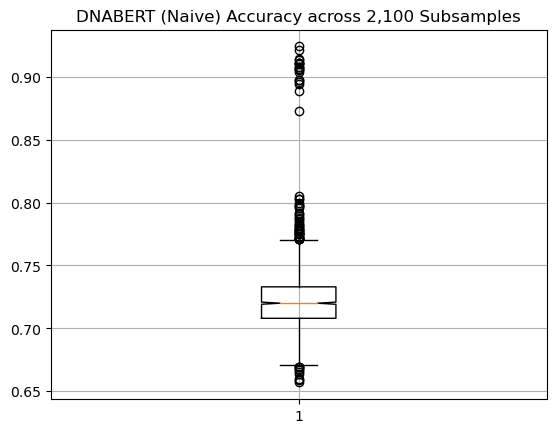

In [59]:
plt.boxplot(accuracies, notch=True)
plt.title("DNABERT (Naive) Accuracy across 2,100 Subsamples")
plt.grid()

In [61]:
np.savetxt("./logs/dnabert_taxonomy_naive_accuracy.txt", accuracies)

In [36]:
model.evaluate(sequences, taxonomies)

32/32 [==============================] - 2s 17ms/step - loss: 1.1144 - sparse_categorical_accuracy: 0.7110


[1.1143890619277954, 0.7110000252723694]

In [70]:
sample_files = list(dataset.fastas(Dataset.Split.Train))

In [68]:
accuracies[np.argsort(accuracies)[::-1][:30]]

array([0.92400002, 0.921     , 0.91399997, 0.91299999, 0.91100001,
       0.91100001, 0.91100001, 0.91000003, 0.90799999, 0.90799999,
       0.90600002, 0.90600002, 0.90499997, 0.90399998, 0.89700001,
       0.89700001, 0.89600003, 0.89399999, 0.889     , 0.87300003,
       0.80500001, 0.80299997, 0.80299997, 0.80000001, 0.79799998,
       0.79699999, 0.79699999, 0.796     , 0.792     , 0.79100001])

In [69]:
np.argsort(accuracies)[::-1][:30]

array([1514, 1515, 2094, 2095, 2097, 1510, 1518, 1519, 2093, 2091, 1517,
       2098, 2096, 1516, 1512, 1511, 2092, 2090, 1513, 2099,  472,  476,
       1168, 1166,  478,  474,  471,  479,  473, 1574])

In [ ]:
151, 209

In [72]:
print(sample_files[151].name)
print(sample_files[209].name)

WS-CCW-May2015_S49_L001_R1_001.002.fasta
WS-FC-Jul2016_S94_L001_R1_001.010.fasta


In [80]:
print(sample_files[116].name)
print(np.mean(accuracies[1160:1160+10]))
print()

print(sample_files[151].name)
print(np.mean(accuracies[1510:1510 + 10]))
print()

print(sample_files[209].name)
print(np.mean(accuracies[2090:2090 + 10]))

WS-CCE-Sep2015_S60_L001_R1_001.007.fasta
0.7825999975204467

WS-CCW-May2015_S49_L001_R1_001.002.fasta
0.9070000112056732

WS-FC-Jul2016_S94_L001_R1_001.010.fasta
0.9027999997138977
